In [1]:
%matplotlib inline
import os
import csv
import random
import logging
from tqdm import tqdm, trange
import time
import numpy as np
import pandas as pd
import random
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torch.nn as nn
from pytorch_pretrained_bert import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer, OpenAIAdam, cached_path

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
import json
from deepmoji.model_def import deepmoji_transfer
from deepmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH
from deepmoji.finetuning import (
    load_benchmark,
    finetune)
import pickle
import time
from keras.models import load_model, Model
from keras.utils import CustomObjectScope
from deepmoji.sentence_tokenizer import SentenceTokenizer
from deepmoji.attlayer import AttentionWeightedAverage
import codecs
import sys
import numpy as np

Using TensorFlow backend.


In [3]:
with CustomObjectScope({'AttentionWeightedAverage': AttentionWeightedAverage}):
    deep_moji_model = load_model(os.path.join(os.getcwd(),"./DeepMoji/model/deepmoji_weights.hdf5"))
deep_moji_model.summary()

04/03/2019 06:31:17 - WARNING - tensorflow -   From /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
04/03/2019 06:31:17 - WARNING - tensorflow -   From /home/ubuntu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
04/03/2019 06:31:20 - WARNING - tensorflow -   From /home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 256)      12867072    input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 20, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
embed_drop (SpatialDropout1D)   (None, 20, 256)      0           activation_1[0][0]               
__________________________________________________________________________________________________
bi_lstm_0 

/home/ubuntu/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
with open('./DeepMoji/model/vocabulary.json', 'r') as f:
    deep_moji_vocab = json.load(f)

In [5]:
st = SentenceTokenizer(deep_moji_vocab, 20)

In [6]:
TEST_SENTENCES = ["it was really awful", "I am doing good"]

In [7]:
tokenized, _, _ = st.tokenize_sentences(TEST_SENTENCES)

In [8]:
tokenized

array([[ 26,  25,  73, 371,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 18, 293, 345,  32,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]], dtype=uint16)

In [9]:
deep_moji_model.predict(tokenized)

array([[1.4506654e-04],
       [9.0945202e-01]], dtype=float32)

In [10]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
logger.info("Device: {}, n_gpu: {}".format(device, n_gpu))

04/03/2019 06:31:28 - INFO - __main__ -   Device: cuda, n_gpu: 1


In [12]:
special_tokens = ['<POS>', '<NEG>','<CON_START>','<CON_END>','<START>','<END>']
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt', special_tokens=special_tokens)
start_token_id = tokenizer.special_tokens['<START>']
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt', num_special_tokens=len(special_tokens))

04/03/2019 06:31:29 - INFO - pytorch_pretrained_bert.tokenization_openai -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-vocab.json from cache at /home/ubuntu/.pytorch_pretrained_bert/4ab93d0cd78ae80e746c27c9cd34e90b470abdabe0590c9ec742df61625ba310.b9628f6fe5519626534b82ce7ec72b22ce0ae79550325f45c604a25c0ad87fd6
04/03/2019 06:31:29 - INFO - pytorch_pretrained_bert.tokenization_openai -   loading merges file https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-merges.txt from cache at /home/ubuntu/.pytorch_pretrained_bert/0f8de0dbd6a2bb6bde7d758f4c120dd6dd20b46f2bf0a47bc899c89f46532fde.20808570f9a3169212a577f819c845330da870aeb14c40f7319819fce10c3b76
04/03/2019 06:31:29 - WARNING - pytorch_pretrained_bert.tokenization_openai -   ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
04/03/2019 06:31:29 - INFO - pytorch_pretrained_bert.tokenization_openai -   Special tokens {'<POS>': 40478, '<NEG>': 40479, '<C

In [13]:
path = os.path.join(os.getcwd(),"pytorch_model_1_22001.bin")
#path = os.path.join()
model_state_dict = torch.load(path)
model.load_state_dict(model_state_dict)
model.to(device)

OpenAIGPTLMHeadModel(
  (transformer): OpenAIGPTModel(
    (tokens_embed): Embedding(40484, 768)
    (positions_embed): Embedding(512, 768)
    (drop): Dropout(p=0.1)
    (h): ModuleList(
      (0): Block(
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1)
          (resid_dropout): Dropout(p=0.1)
        )
        (ln_1): BertLayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1)
        )
        (ln_2): BertLayerNorm()
      )
      (1): Block(
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1)
          (resid_dropout): Dropout(p=0.1)
        )
        (ln_1): BertLayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1)
        )
        (ln_2): BertLayerNorm()
      )
      (2): Block(
        (attn)

In [14]:
def tokenize_and_encode(file_path):
    """
    This method tokenizes the input data and encodes it using the OpenAIGPTTokenizer
    :param file_path: Path of the input file, dtype: str
    :return: encoded dataset  dtype: list
    """
    with open(file_path, 'r') as in_fp:
        lines = in_fp.read().splitlines()

    tokenized_dataset = lines
    for i, line in enumerate(tqdm(lines)):
        token = tokenizer.tokenize(line)
        tokenized_dataset[i] = tokenizer.convert_tokens_to_ids(token)
    return tokenized_dataset

In [15]:
train_data = "./data/yelp/git_repo_attribute_vocab/rl_training/processed_sentiment_dev.txt"

In [16]:
train_dataset1 = tokenize_and_encode(train_data)

100%|██████████| 8000/8000 [00:01<00:00, 6187.42it/s]


In [17]:
start_token_id=tokenizer.special_tokens['<START>']
end_token_id = tokenizer.special_tokens['<END>']
print(start_token_id, end_token_id)

40482 40483


8000
10.75325


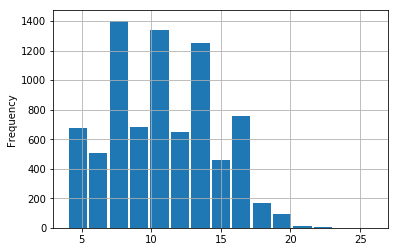

In [18]:
lengths = [len(x) for x in train_dataset1]
print(len(lengths))
average_length = np.mean(lengths)
print(average_length)
lens = pd.Series(np.array(lengths))
lens.plot.hist(grid=True, bins=15, rwidth=0.9)

In [19]:
def pre_process_dataset(encoded_dataset, max_input_length, max_total_length, start_token_id, end_token_id):
    """
    This method add the padding of '0' to all the input sentences and attach 
    '<START>' token at the end so that all the sentence can be processed in batch 
    for training and prediction.
    It also prepares prediction labels.
    """
    total_sentences = len(encoded_dataset)
    input_ids = np.zeros(shape=(total_sentences, max_input_length+1), dtype=np.int64)
    sen_length = [len(x) for x in encoded_dataset]
    labels = [0 for i in range(len(encoded_dataset))]
    for i, tokens in enumerate(encoded_dataset):
        if len(tokens) > max_input_length:
            tokens = tokens[:max_input_length]
        input_ids[i, :len(tokens)] = tokens
        input_ids[i][max_input_length] = start_token_id
        labels[i] = 1 if tokens[0] == tokenizer.special_tokens['<POS>'] else 0
        
    labels = torch.tensor(labels)
    print(labels)
    input_ids = torch.tensor(input_ids)
    sen_length = torch.tensor(sen_length)
    
    return (input_ids, sen_length, torch.tensor([x for x in range(len(encoded_dataset))]), labels)

In [20]:
max_input_length = 45
max_total_length = 95

In [21]:
train_tensor_dataset = pre_process_dataset(encoded_dataset=train_dataset1, max_input_length= max_input_length, max_total_length= max_total_length, start_token_id=start_token_id, end_token_id=end_token_id)

tensor([0, 0, 0,  ..., 0, 0, 0])


In [22]:
train_tensor_dataset[-2], train_tensor_dataset[-1]

(tensor([   0,    1,    2,  ..., 7997, 7998, 7999]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [23]:
epochs =5
bs = 2
learning_rate = 6.25e-5
warmup_proportion = 0.002
lr_schedule = 'warmup_linear'
weight_decay = 0.01
lm_coef = 0.9
max_grad_norm = 1

In [24]:
train_dataset = TensorDataset(*train_tensor_dataset)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=bs)

In [25]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
num_train_optimization_steps = len(train_dataset) * epochs * 1 // bs # Modified by Bhargav
"""
Modified the total optimization steps as 
"""
print("Optimization steps = {}".format(num_train_optimization_steps))
optimizer = OpenAIAdam(optimizer_grouped_parameters,
                       lr=learning_rate,
                       warmup=warmup_proportion,
                       max_grad_norm=max_grad_norm,
                       weight_decay=weight_decay,
                       t_total=num_train_optimization_steps)

Optimization steps = 20000


In [26]:
def reward_function(generated_sentences, true_labels):
    #rewards = [0 for i in range(len(true_labels))]
    rewards = torch.zeros(len(true_labels))
    predictions = torch.from_numpy(deep_moji_model.predict(st.tokenize_sentences(generated_sentences)[0]))
    for i in range(len(predictions)):
        if true_labels[i]:
            rewards[i] = predictions[i][0]
        else:
            rewards[i] = 1 - predictions[i][0]
    return rewards

In [27]:
log_soft_max = nn.LogSoftmax(dim=-1)

## Training Loop

In [28]:
val_func_dict = {x:[0.5] for x in range(len(train_dataset1))}
val_func_dict[0]

[0.5]

In [29]:
# Loss calculation from the reward
def calculate_loss(trace, reward, baseline, end_index):
    """
    Calculate loss for the batch 
    trace: [batch_size, max_len_in_batch], dtype: float32
    reward: [batch_size], dtype: int32 or float32
    baseline : [batch_size], dtype: float32
    
    loss = average(log p(action(t)) * (reward(t) - baseline(t))), dtype: float32
    """
    #print("End_index = {}".format(end_index))
    #loss_lt = [0 for i in range(sum(end_index) + len(end_index))]
    loss_tensor = torch.zeros(sum(end_index) + len(end_index))
    #print("Initial_loss_lt = {}".format(loss_tensor))
    count = 0
    for i, index in enumerate(end_index):
        print(index, len(trace[i]))
        for j in range(index): # We need to include the loss for <END> token prediction
            #loss_lt[count] = - trace[i][j] * (reward[i] - baseline[i])
            loss_tensor[count] = -trace[i][j] * (reward[i] - baseline[i])
            count += 1
    #loss = torch.tensor(loss_lt, dtype=torch.float32)
    print("Gradient Tensor = {}".format(loss_tensor))
    print("Gradient Ascent Value = {}".format(loss_tensor.mean()))
    return loss_tensor.mean()

In [30]:
def calculate_and_update_baseline(sen_index, rewards):
    global val_func_dict
    #b_line = [0 for i in range(len(sen_index))]
    b_line = torch.zeros(len(sen_index)) + 0.5
    for i in range(len(sen_index)):
        if len(val_func_dict[sen_index[i].item()]) > 1:
            b_line[i] = torch.mean(torch.tensor(val_func_dict[sen_index[i].item()][1:], dtype=torch.float32))
        val_func_dict[sen_index[i].item()].append(rewards[i])
    
    return torch.tensor(b_line)

In [31]:
#model.train()
nb_tr_steps, tr_loss, exp_average_reward = 0, 0, None
for epoch in trange(int(epochs), desc="EPOCH"):
    model.train()
    nb_tr_steps = 0
    average_reward = 0
    tqdm_bar = tqdm(train_dataloader, desc="Training")
    for steps, batch in enumerate(tqdm_bar):
        loss = 0
        batch = tuple(t.to(device) for t in batch)
        input_ids, seq_lengths, sen_indexes, true_labels = batch
        
        max_seq_length = max(seq_lengths)
        
        traces = torch.zeros(bs, max_seq_length, dtype = torch.float32)
        trace_indexes = torch.zeros(bs, max_seq_length, dtype = torch.float32) # To decode and feed to sentiment Block for feedback
        #rewards = torch.zeros(bs, max_seq_length, dtype = torch.float32)
        #baseline = torch.zeros(bs, max_seq_length, dtype = torch.float32)
        generated_sentences = []
        #print(max_seq_length)
        model.train()
        for k in range(max_seq_length):
            preds = model(input_ids)
            preds = log_soft_max(preds)
            #print("Softmax = {}".format(soft_max(preds)))
            #print("Log Softmax = {}".format(log_soft_max(preds)))
            preds_index = torch.argmax(preds[:,-1,:], dim= -1)
            traces[:, k], trace_indexes[:, k] = torch.max(preds[:,-1,:], dim = -1)
            input_ids = torch.cat((input_ids, preds_index.unsqueeze(1)), dim=1)
            
        end_token_indexes = []
        for i1 in range(len(trace_indexes)):
            try:
                end_token_indexes.append(trace_indexes.tolist()[i1].index(tokenizer.special_tokens['<END>']))
            except ValueError:
                end_token_indexes.append(len(trace_indexes[i1]))
        print(end_token_indexes)
        
        for j in range(bs):
            generated_sentences.append(tokenizer.decode(trace_indexes[j,:end_token_indexes[j]].tolist()).replace("<END> ",""))
            
        rewards = reward_function(generated_sentences, true_labels)
        baseline = calculate_and_update_baseline(sen_indexes, rewards)
        #print(traces)
        print("Generated_sen = {}".format(generated_sentences))
        #print(deep_moji_model.predict(st.tokenize_sentences(generated_sentences)[0]))
        #print(true_labels)
        print("Rewards = {}".format(rewards))
        print("Baseline = {}".format(baseline))
        #print(sen_indexes)
        loss = calculate_loss(traces, rewards, baseline, end_token_indexes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #print(traces.shape, trace_indexes.shape)
        
        #loss = calculate_loss(traces, rewards, baseline)
        #loss = loss * -1 # To make Gradient Ascent 
        
        average_reward += torch.mean(rewards).item()
        exp_average_reward = average_reward if exp_average_reward is None else 0.7 * exp_average_reward + 0.3 * average_reward
        nb_tr_steps += 1
        tqdm_bar.desc = "Average Reward: {:.1} lr: {:.2e}".format(exp_average_reward, optimizer.get_lr()[0])
        
        '''
        # Save predictions in the log file after every 200 steps
        if (steps % 200 == 0 and steps > 199):
            model.eval()
            #run predictions on the eval data
            with open('model_predictions.log','a') as fp:
                fp.write("\n\nPredictions After {} steps:\n\n".format(steps+1))
                for batch1 in (eval_dataloader):
                    batch1 = tuple(t.to(device) for t in batch1)
                    eval_input_ids, _, _ = batch
                    for k in range(len(eval_input_ids)):
                        temp = eval_input_ids[k].unsqueeze(0)
                        fp.write("INPUT: " + tokenizer.decode(eval_input_ids[k].tolist()).replace("<unk>","") + "\n")
                        #print(temp, temp.shape)
                        count = 0
                        predicted_index = None
                        decoded_sentence = []
                        while predicted_index != tokenizer.special_tokens['<END>'] and count < max_input_length:
                            with torch.no_grad():
                                prediction = model(temp)
                            predicted_index = torch.argmax(prediction[0, -1, :]).item()
                            count += 1
                            predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
                            decoded_sentence.append(predicted_index)
                            temp = torch.cat( (temp, torch.tensor([predicted_index]).unsqueeze(1).to(device)), 1)
                        fp.write("PREDICTION: " + tokenizer.decode(decoded_sentence) + "\n")
                    break
                                
        # save the weights after every 2000 steps
        if (steps % 2000 == 0 and steps > 0):
            model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
            output_model_file = os.path.join("./", "pytorch_model_{}_{}.bin".format(epoch+1, steps+1))
            config = model.config
            torch.save(model_to_save.state_dict(), output_model_file)
            
            model_state_dict = torch.load(output_model_file)
            model = OpenAIGPTLMHeadModel(config)
            model.load_state_dict(model_state_dict)
            model.to(device)
    
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        input_ids, labels, seq_lengths = batch
        max_seq_length = max(seq_lengths)
        with torch.no_grad():
            for k in range(max_seq_length):
                preds = model(input_ids)
                preds_index = torch.argmax(preds[:,-1,:], dim= -1)
                y_hat = labels[:,max_input_length + k]
                loss = loss_func(preds[:,-1,:], y_hat)
                eval_loss += loss.item()
                input_ids = torch.cat((input_ids, preds_index.unsqueeze(1)), dim=1)
        eval_loss = eval_loss / max_seq_length
        nb_eval_examples += 1
    eval_loss = eval_loss / nb_eval_examples
    '''

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[11, 17]
Generated_sen = ['i really expected so much more but was completely disappointed .', 'not worth checking out even after drinking all night . . . . . . . .']
Rewards = tensor([8.2089e-05, 9.9947e-01])
Baseline = tensor([0.5000, 0.5000])
11 17
17 17
Gradient Tensor = tensor([-0.0074, -0.0055, -0.0025, -0.0537, -0.0007, -0.0469, -0.0319, -0.0157,
        -0.1054, -0.3699, -0.0024,  0.2944,  0.0090,  0.0030,  0.0117,  0.3216,
         0.0210,  0.0241,  0.0060,  0.0088,  0.0329,  0.0395,  0.0849,  0.1720,
         0.2364,  0.2857,  0.0404,  0.4246,  0.0000,  0.0000],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04579911008477211


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.

Average Reward: 0.5 lr: 1.56e-06:   0%|          | 1/4000 [00:03<3:26:13,  3.09s/it]

[12, 6]
Generated_sen = ['lots of issues with the games working and giving tickets out .', 'making my wings get done .']
Rewards = tensor([0.5111, 0.6560])
Baseline = tensor([0.5000, 0.5000])
12 16
6 16
Gradient Tensor = tensor([1.2165e-02, 6.3758e-05, 3.1117e-03, 2.2097e-04, 3.7354e-04, 9.9509e-04,
        2.5619e-03, 5.3233e-05, 9.0271e-03, 4.4733e-03, 1.8702e-04, 3.1210e-04,
        6.7563e-03, 2.3793e-04, 2.2204e-03, 6.2603e-02, 1.1436e-01, 7.2462e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011348455213010311



Average Reward: 0.7 lr: 3.12e-06:   0%|          | 2/4000 [00:04<3:01:16,  2.72s/it]

[5, 4]
Generated_sen = ['poor customer service today !', 'love this location .']
Rewards = tensor([0.9997, 0.9999])
Baseline = tensor([0.5000, 0.5000])
5 7
4 7
Gradient Tensor = tensor([6.5186e-01, 1.5322e-03, 3.5457e-04, 2.9368e-01, 1.0231e-01, 3.6461e-01,
        3.1962e-03, 2.5645e-03, 9.9452e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.12919090688228607



Average Reward: 1e+00 lr: 4.69e-06:   0%|          | 3/4000 [00:05<2:24:45,  2.17s/it]

[4, 11]
Generated_sen = ['guy and service .', 'buyer beware , you buy as is not is is .']
Rewards = tensor([0.0102, 0.9944])
Baseline = tensor([0.5000, 0.5000])
4 11
11 11
Gradient Tensor = tensor([-3.2581e-01, -2.4787e-03, -4.4390e-01, -9.2038e-02,  4.5591e-02,
         3.5927e-04,  2.0019e-02,  9.5040e-03,  2.5201e-01,  1.5308e-01,
         4.1183e-02,  6.8896e-01,  1.9785e-01,  6.7564e-01,  3.2906e-01,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.09111922979354858



Average Reward: 2e+00 lr: 6.25e-06:   0%|          | 4/4000 [00:07<2:07:32,  1.91s/it]

[6, 11]
Generated_sen = ['and it was really weird !', 'their customer service through phone or in person is amazing .']
Rewards = tensor([0.9976, 0.9994])
Baseline = tensor([0.5000, 0.5000])
6 13
11 13
Gradient Tensor = tensor([2.3498e-02, 2.1801e-02, 2.0881e-04, 5.5890e-03, 7.6362e-01, 1.2485e-02,
        7.6683e-04, 9.4230e-03, 1.4522e-03, 2.2130e-01, 5.1324e-01, 9.4754e-02,
        1.5718e-01, 1.5832e-02, 9.8697e-02, 9.7090e-01, 5.7531e-03, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.1535002738237381



Average Reward: 2e+00 lr: 7.81e-06:   0%|          | 5/4000 [00:08<1:59:49,  1.80s/it]

[13, 6]
Generated_sen = ['service was horrible , food was not fresh and the prices were cheap', 'this place is not good .']
Rewards = tensor([1.0000, 0.9990])
Baseline = tensor([0.5000, 0.5000])
13 13
6 13
Gradient Tensor = tensor([3.1384e-03, 2.5023e-03, 6.4538e-01, 1.5187e-03, 9.8328e-02, 1.4104e-03,
        9.2932e-01, 4.9605e-01, 3.7588e-03, 9.1628e-02, 1.9580e-01, 6.0875e-03,
        3.7529e-01, 6.0249e-04, 6.9482e-04, 1.1560e-03, 9.5370e-01, 3.5807e-01,
        3.7125e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.2000747174024582



Average Reward: 3e+00 lr: 9.37e-06:   0%|          | 6/4000 [00:10<1:54:17,  1.72s/it]

[16, 9]
Generated_sen = ['luckily i had no cash so i guess her for exactly what i had ordered .', 'i am glad we stayed one night here .']
Rewards = tensor([0.9900, 0.4229])
Baseline = tensor([0.5000, 0.5000])
16 17
9 17
Gradient Tensor = tensor([ 1.9518e-02,  1.1390e-02,  2.5590e-02,  3.6803e-01,  1.5965e-01,
         3.2242e-02,  6.4989e-02,  5.4821e-01,  2.5364e-01,  1.9902e-02,
         1.2509e+00,  8.0885e-03,  8.0699e-02,  5.6605e-02,  8.6269e-04,
         1.0356e-02, -2.4281e-04, -8.2574e-04, -1.4301e-03, -5.6211e-04,
        -2.0154e-05, -2.3488e-03, -2.7247e-03, -3.3240e-04, -1.4076e-03,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.10743538290262222



Average Reward: 4e+00 lr: 1.09e-05:   0%|          | 7/4000 [00:12<1:59:01,  1.79s/it]

[19, 8]
Generated_sen = ["true italian food . . . . . . . one i ' ve been there with has been", 'delivery was good and food was good .']
Rewards = tensor([0.9905, 0.9994])
Baseline = tensor([0.5000, 0.5000])
19 19
8 19
Gradient Tensor = tensor([7.2032e-02, 1.1033e-01, 4.2078e-02, 3.3144e-01, 2.4582e-02, 1.2692e-01,
        1.2299e-01, 3.4267e-01, 2.0754e-01, 2.3110e-01, 1.6186e-01, 1.5009e-01,
        6.0814e-05, 3.3167e-04, 1.1852e-02, 5.6941e-03, 5.7259e-04, 5.4332e-02,
        2.5112e-02, 2.8098e-04, 7.5208e-03, 5.0547e-01, 2.7698e-03, 8.4009e-03,
        3.0403e-03, 7.0906e-01, 6.5774e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.11257653683423996



Average Reward: 4e+00 lr: 1.25e-05:   0%|          | 8/4000 [00:14<2:09:07,  1.94s/it]

[8, 7]
Generated_sen = ['the communication with this store was amazing !', 'i hate their pollo bowl !']
Rewards = tensor([0.9982, 0.9919])
Baseline = tensor([0.5000, 0.5000])
8 10
7 10
Gradient Tensor = tensor([6.0288e-04, 1.0020e-02, 2.8482e-02, 2.2994e-03, 9.9184e-03, 3.1641e-03,
        3.7507e-01, 1.6880e-03, 5.6818e-03, 9.7518e-01, 2.3230e-02, 2.5306e-02,
        3.1191e-01, 3.7166e-02, 1.5193e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.10734711587429047



Average Reward: 5e+00 lr: 1.41e-05:   0%|          | 9/4000 [00:15<1:54:39,  1.72s/it]

[12, 10]
Generated_sen = ['it was totally good and was with ricotta cheese .', 'joking i was in there and i was told .']
Rewards = tensor([0.9494, 0.9920])
Baseline = tensor([0.5000, 0.5000])
12 14
10 14
Gradient Tensor = tensor([1.1568e-03, 4.8348e-04, 1.6262e-03, 7.9121e-01, 8.3538e-04, 7.1712e-02,
        5.4353e-01, 6.6839e-03, 8.2274e-03, 1.6916e-02, 1.5046e-01, 2.0582e-02,
        5.5352e-02, 6.6890e-02, 4.3847e-03, 2.0245e-01, 2.9601e-03, 2.4387e-03,
        9.2795e-03, 3.0272e-03, 5.4491e-01, 2.5484e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.1149987280368805



Average Reward: 6e+00 lr: 1.56e-05:   0%|          | 10/4000 [00:17<1:52:42,  1.69s/it]

[15, 8]
Generated_sen = ["i took this photo after on my hair & it ' s still amazing !", 'its not my fault so worth it .']
Rewards = tensor([0.0002, 0.0953])
Baseline = tensor([0.5000, 0.5000])
15 17
8 17
Gradient Tensor = tensor([-1.7341e-03, -4.2818e-02, -2.1789e-03, -7.3121e-03, -1.6121e-02,
        -3.5772e-02, -1.4591e-03, -1.6851e-01, -3.4313e-02, -4.6337e-03,
        -1.3394e-04, -9.4094e-04, -7.5838e-03, -8.0853e-01, -2.7447e-03,
        -1.8735e-02, -3.1025e-01, -2.3833e-01, -1.8337e-01, -2.4767e-02,
        -3.6623e-01, -6.0683e-03, -1.2831e-02,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.09181424230337143



Average Reward: 7e+00 lr: 1.72e-05:   0%|          | 11/4000 [00:19<1:57:49,  1.77s/it]

[5, 8]
Generated_sen = ['their food was good .', 'the manager well i talk to her .']
Rewards = tensor([0.9929, 0.9510])
Baseline = tensor([0.5000, 0.5000])
5 11
8 11
Gradient Tensor = tensor([3.5535e-04, 4.2378e-03, 6.8860e-04, 6.2935e-01, 2.7727e-03, 2.2372e-03,
        9.2034e-05, 2.0428e-04, 1.5925e-01, 1.7638e-01, 1.0180e-03, 2.5344e-03,
        4.7019e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06558781862258911



Average Reward: 8e+00 lr: 1.87e-05:   0%|          | 12/4000 [00:20<1:48:41,  1.64s/it]

[11, 10]
Generated_sen = ['he went to prepare our food without washing his hands .', 'i called my purchases there along with another customer .']
Rewards = tensor([0.0127, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 14
10 14
Gradient Tensor = tensor([-1.6703e-03, -1.0749e-03, -2.4185e-03, -6.8195e-02, -7.7778e-03,
        -2.1862e-02, -3.7193e-03, -1.7062e-02, -1.2243e-02, -2.3725e-03,
        -1.1023e-02,  3.6483e-03,  9.1557e-01,  2.3515e-03,  3.0746e-02,
         3.6037e-03,  7.1228e-03,  5.3252e-04,  1.3157e-02,  7.2221e-03,
         1.6858e-01,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.043613605201244354



Average Reward: 8e+00 lr: 2.03e-05:   0%|          | 13/4000 [00:22<1:48:40,  1.64s/it]

[14, 7]
Generated_sen = ['all i ate there was crunchy rice and soy sauce and sweet caramel sauce', 'this place is like my favorite !']
Rewards = tensor([0.1336, 0.9991])
Baseline = tensor([0.5000, 0.5000])
14 14
7 14
Gradient Tensor = tensor([-3.9170e-04, -1.4026e-03, -4.9254e-03, -5.4509e-05, -1.7813e-03,
        -1.1989e-01, -4.2637e-02, -4.1546e-04, -1.2379e-01, -1.1624e-01,
        -2.8861e-02, -6.8754e-01, -7.2836e-01, -7.0571e-02,  8.1296e-04,
         7.6679e-04,  1.0324e-03,  2.2212e-02,  5.8340e-03,  4.6308e-01,
         9.9520e-02,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.05798319727182388



Average Reward: 9e+00 lr: 2.19e-05:   0%|          | 14/4000 [00:23<1:48:36,  1.63s/it]

[11, 9]
Generated_sen = ['i would suggest they with more experience working with customers .', 'it was the most thing he have done .']
Rewards = tensor([0.6248, 0.5629])
Baseline = tensor([0.5000, 0.5000])
11 14
9 14
Gradient Tensor = tensor([5.0025e-04, 3.2056e-03, 3.3933e-04, 5.1117e-03, 7.8353e-02, 1.3779e-02,
        3.7197e-02, 8.6892e-03, 1.3432e-03, 2.1132e-03, 1.2282e-03, 1.1293e-03,
        1.2040e-04, 9.9310e-03, 4.4006e-04, 1.6152e-01, 3.1192e-04, 4.3049e-02,
        8.4301e-04, 9.2060e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.016823960468173027



Average Reward: 9e+00 lr: 2.34e-05:   0%|          | 15/4000 [00:25<1:48:38,  1.64s/it]

[6, 12]
Generated_sen = ["that ' s that part .", "it ' s so good , so bright , so happy !"]
Rewards = tensor([0.5525, 1.0000])
Baseline = tensor([0.5000, 0.5000])
6 13
12 13
Gradient Tensor = tensor([7.4451e-04, 2.4226e-04, 4.4057e-06, 8.6119e-03, 7.7707e-03, 8.0819e-04,
        6.7945e-04, 1.1873e-04, 1.2397e-05, 1.4149e-02, 4.2423e-01, 2.2911e-03,
        6.3220e-03, 4.1906e-01, 1.4080e-03, 7.7911e-03, 6.5290e-01, 9.8294e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0778488740324974



Average Reward: 1e+01 lr: 2.50e-05:   0%|          | 16/4000 [00:27<1:46:29,  1.60s/it]

[16, 7]
Generated_sen = ["my salad was good and my fianc ' s ribs were a little soggy .", 'them a good and my call .']
Rewards = tensor([0.0012, 0.9995])
Baseline = tensor([0.5000, 0.5000])
16 17
7 17
Gradient Tensor = tensor([-6.9162e-04, -2.3621e-02, -1.0660e-03, -6.8084e-01, -8.1386e-04,
        -1.2617e-02, -4.4903e-04, -2.9139e-03, -1.2301e-03, -1.3033e-04,
        -1.0921e-02, -7.1635e-04, -2.3946e-02, -4.2054e-02, -7.6209e-01,
        -2.7026e-02,  2.5170e-01,  1.3335e-02,  7.7191e-01,  5.9862e-01,
         1.0754e-01,  1.2645e-02,  1.0520e-01,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010792945511639118



Average Reward: 1e+01 lr: 2.65e-05:   0%|          | 17/4000 [00:28<1:53:35,  1.71s/it]

[12, 10]
Generated_sen = ['ordered the pack which included wings , fries and garlic bread .', 'i love it and i know you will too .']
Rewards = tensor([0.1876, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 15
10 15
Gradient Tensor = tensor([-7.6447e-04, -1.5432e-04, -1.0909e-01, -2.8528e-02, -2.4370e-04,
        -6.1136e-01, -4.2338e-03, -1.0747e-01, -1.1408e-03, -2.3897e-03,
        -1.4535e-02, -6.7480e-02,  1.6591e-03,  3.4250e-01,  4.7381e-03,
         1.5538e-03,  4.5946e-03,  1.0402e-02,  1.4813e-02,  7.1324e-03,
         3.3964e-01,  9.1910e-03,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.008799032308161259



Average Reward: 1e+01 lr: 2.81e-05:   0%|          | 18/4000 [00:30<1:54:09,  1.72s/it]

[3, 15]
Generated_sen = ['poor service .', 'as soon as you walk in , you feel and left right at home .']
Rewards = tensor([0.9998, 0.8918])
Baseline = tensor([0.5000, 0.5000])
3 17
15 17
Gradient Tensor = tensor([0.5940, 0.0019, 0.0014, 0.0279, 0.1125, 0.0041, 0.0010, 0.0007, 0.0012,
        0.0007, 0.0057, 0.0009, 0.2116, 0.4952, 0.0238, 0.0019, 0.0023, 0.0082,
        0.0000, 0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07475004345178604



Average Reward: 1e+01 lr: 2.97e-05:   0%|          | 19/4000 [00:32<1:58:54,  1.79s/it]

[9, 3]
Generated_sen = ['small menu , but the food is good .', 'pretty good .']
Rewards = tensor([0.9980, 0.9984])
Baseline = tensor([0.5000, 0.5000])
9 11
3 11
Gradient Tensor = tensor([0.2446, 0.0702, 0.0010, 0.0072, 0.0073, 0.0024, 0.0005, 0.4151, 0.0015,
        0.0004, 0.0506, 0.0073, 0.0000, 0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.057715900242328644



Average Reward: 1e+01 lr: 3.12e-05:   0%|          | 20/4000 [00:33<1:49:23,  1.65s/it]

[14, 4]
Generated_sen = ["you wo n ' t get due to being worried about your vehicle .", 'will come back .']
Rewards = tensor([0.8803, 0.9997])
Baseline = tensor([0.5000, 0.5000])
14 16
4 16
Gradient Tensor = tensor([4.9197e-03, 4.8696e-02, 1.0154e-05, 2.9012e-06, 5.0771e-06, 4.6274e-03,
        2.9841e-02, 1.1098e-02, 3.2145e-03, 3.3495e-01, 3.5576e-04, 2.3799e-02,
        4.2764e-03, 1.4413e-02, 1.1916e-02, 5.3395e-02, 2.3256e-04, 2.6664e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.027420733124017715



Average Reward: 1e+01 lr: 3.28e-05:   1%|          | 21/4000 [00:35<1:53:14,  1.71s/it]

[8, 6]
Generated_sen = ['very excited to finally wear my watch .', 'i absolutely love their popcorn !']
Rewards = tensor([1.5673e-02, 2.2531e-05])
Baseline = tensor([0.5000, 0.5000])
8 11
6 11
Gradient Tensor = tensor([-0.0056, -0.0580, -0.0116, -0.0008, -0.0307, -0.0006, -0.0104, -0.0199,
        -0.0030, -0.0037, -0.4650, -0.0144, -0.0102, -0.0342,  0.0000,  0.0000],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.04176558181643486



Average Reward: 1e+01 lr: 3.43e-05:   1%|          | 22/4000 [00:37<1:45:21,  1.59s/it]

[3, 14]
Generated_sen = ['rude workers !', 'but as for my experience , this place has been really to us .']
Rewards = tensor([0.9995, 0.2320])
Baseline = tensor([0.5000, 0.5000])
3 17
14 17
Gradient Tensor = tensor([ 8.3312e-01,  2.3924e-02,  3.6873e-03, -1.6894e-03, -7.0621e-03,
        -5.3681e-03, -6.3560e-03, -1.7840e-04, -2.5354e-04, -3.2232e-03,
        -3.2613e-04, -2.0056e-03, -5.7679e-02, -2.0835e-03, -3.1368e-01,
        -4.2711e-03, -4.2044e-04,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.024007128551602364



Average Reward: 1e+01 lr: 3.59e-05:   1%|          | 23/4000 [00:39<1:52:34,  1.70s/it]

[10, 16]
Generated_sen = ['the stations were messy and they were short staffed .', "my cheese for my hashbrowns was n ' t melted , at all ."]
Rewards = tensor([0.9999, 0.0024])
Baseline = tensor([0.5000, 0.5000])
10 19
16 19
Gradient Tensor = tensor([ 1.0374e-03,  1.2405e-03,  1.1890e-03,  2.4993e-01,  4.8389e-04,
         1.5680e-03,  7.7661e-04,  1.6317e-01,  2.3999e-03,  1.6472e-02,
        -9.2401e-04, -5.0652e-03, -4.3358e-03, -1.7393e-03, -1.5175e-01,
        -1.2814e-04, -3.0805e-01, -2.9377e-03, -8.0726e-04, -3.4170e-05,
        -3.1299e-03, -1.2512e-01, -1.9154e-03, -4.1433e-02, -3.6215e-03,
        -2.2449e-02,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.00839879922568798



Average Reward: 2e+01 lr: 3.75e-05:   1%|          | 24/4000 [00:41<2:02:00,  1.84s/it]

[5, 9]
Generated_sen = ['the prices are astounding .', 'i will use this company in the future .']
Rewards = tensor([0.9696, 0.8592])
Baseline = tensor([0.5000, 0.5000])
5 12
9 12
Gradient Tensor = tensor([5.9559e-04, 3.2237e-01, 1.8898e-03, 2.7801e-01, 6.0706e-03, 1.7112e-03,
        9.0614e-04, 1.5768e-01, 4.2823e-04, 2.8696e-02, 5.7965e-04, 1.8842e-04,
        2.7071e-03, 2.2258e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.050252996385097504



Average Reward: 2e+01 lr: 3.90e-05:   1%|          | 25/4000 [00:42<1:53:40,  1.72s/it]

[11, 8]
Generated_sen = ['little chinese food place in our neighborhood with decent prices .', 'this is the inventory that one wanted .']
Rewards = tensor([0.9534, 0.6372])
Baseline = tensor([0.5000, 0.5000])
11 12
8 12
Gradient Tensor = tensor([4.8318e-01, 5.2601e-03, 7.2054e-02, 4.2810e-02, 4.7875e-03, 1.0355e-02,
        6.8786e-02, 5.4470e-02, 3.1034e-02, 1.2413e-01, 2.1413e-02, 6.9888e-05,
        2.7144e-04, 6.0583e-04, 1.9480e-03, 1.1524e-02, 7.8991e-03, 2.1982e-02,
        5.4966e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.046098802238702774



Average Reward: 2e+01 lr: 4.06e-05:   1%|          | 26/4000 [00:44<1:47:44,  1.63s/it]

[8, 9]
Generated_sen = ['with the actual care at the facility .', ', they made everything so hard and more .']
Rewards = tensor([0.1618, 0.0255])
Baseline = tensor([0.5000, 0.5000])
8 13
9 13
Gradient Tensor = tensor([-2.0589e-01, -5.3081e-04, -3.4700e-04, -1.2193e-03, -3.2029e-03,
        -2.1091e-04, -7.8784e-04, -1.6231e-03, -8.7958e-01, -6.1407e-04,
        -9.7251e-03, -1.6235e-01, -1.1536e-02, -1.5222e-01, -3.4030e-04,
        -1.9847e-01, -2.3756e-01,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.09822159260511398



Average Reward: 2e+01 lr: 4.21e-05:   1%|          | 27/4000 [00:45<1:45:42,  1.60s/it]

[5, 13]
Generated_sen = ['was a great trip .', 'we walked while multiple workers by before would help help help us .']
Rewards = tensor([0.9999, 0.0532])
Baseline = tensor([0.5000, 0.5000])
5 13
13 13
Gradient Tensor = tensor([ 5.9301e-02,  3.4313e-02,  5.8688e-01,  6.3746e-03,  9.0523e-03,
        -9.0550e-04, -1.0614e+00, -7.7531e-02, -5.7986e-03, -5.7700e-02,
        -3.7677e-03, -2.9968e-01, -1.7571e-02, -2.1451e-03, -9.2302e-02,
        -2.5542e-01, -7.8517e-03, -3.8483e-03,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.059500552713871



Average Reward: 2e+01 lr: 4.37e-05:   1%|          | 28/4000 [00:47<1:44:13,  1.57s/it]

[11, 4]
Generated_sen = ['i would recommend central towing , and if possible francisco !', 'rip - off !']
Rewards = tensor([0.0041, 0.0061])
Baseline = tensor([0.5000, 0.5000])
11 13
4 13
Gradient Tensor = tensor([-0.0015, -0.0067, -0.6769, -0.0179, -0.2392, -0.0046, -0.0040, -0.1013,
        -0.6694, -0.4274, -0.0335, -0.0799, -0.0068, -0.0008, -0.0471,  0.0000,
         0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.13628844916820526



Average Reward: 2e+01 lr: 4.52e-05:   1%|          | 29/4000 [00:48<1:43:17,  1.56s/it]

[3, 9]
Generated_sen = ['the worst !', 'in a delivery order and it was late .']
Rewards = tensor([0.9998, 0.9780])
Baseline = tensor([0.5000, 0.5000])
3 15
9 15
Gradient Tensor = tensor([7.5729e-02, 1.1041e+00, 4.3699e-02, 3.0193e-02, 3.7386e-03, 2.4175e-03,
        7.5674e-05, 8.9483e-03, 2.5469e-03, 3.0133e-04, 9.1634e-03, 5.4413e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.095378577709198



Average Reward: 2e+01 lr: 4.68e-05:   1%|          | 30/4000 [00:50<1:46:46,  1.61s/it]

[9, 13]
Generated_sen = ["they ' re totally new to this place .", 'the bathrooms were very clean and the booth we were in was .']
Rewards = tensor([0.9632, 0.8832])
Baseline = tensor([0.5000, 0.5000])
9 15
13 15
Gradient Tensor = tensor([1.5551e-04, 6.5826e-05, 2.3582e-03, 5.3482e-03, 1.4000e-03, 4.7845e-02,
        2.9644e-04, 3.8612e-04, 9.7767e-04, 8.1138e-05, 1.3346e-02, 2.1783e-04,
        1.7407e-02, 2.0181e-01, 7.6752e-06, 8.1577e-04, 8.5239e-03, 9.1847e-04,
        3.4173e-04, 1.1048e-02, 5.6633e-02, 3.1073e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0283633004873991



Average Reward: 2e+01 lr: 4.84e-05:   1%|          | 31/4000 [00:52<1:49:21,  1.65s/it]

[8, 8]
Generated_sen = ['it was not good worth the drive .', 'i am absolutely pleased with this store .']
Rewards = tensor([0.9992, 0.9995])
Baseline = tensor([0.5000, 0.5000])
8 10
8 10
Gradient Tensor = tensor([6.0793e-03, 5.2323e-04, 1.5932e-02, 2.8136e-01, 6.1724e-01, 1.1617e-03,
        5.9084e-03, 3.9446e-02, 6.8314e-04, 1.9970e-03, 4.1065e-04, 4.2614e-01,
        2.4963e-04, 4.8830e-04, 2.3538e-03, 1.8298e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07787758857011795



Average Reward: 2e+01 lr: 4.99e-05:   1%|          | 32/4000 [00:53<1:40:34,  1.52s/it]

[16, 10]
Generated_sen = ["but domino ' s is at least on par with pizza hut and papa dishes .", 'all in all the service and food was good !']
Rewards = tensor([0.8294, 0.9983])
Baseline = tensor([0.5000, 0.5000])
16 19
10 19
Gradient Tensor = tensor([1.9791e-03, 1.0425e-01, 9.8638e-05, 4.9005e-05, 2.7094e-03, 1.6081e-01,
        1.2715e-02, 6.3641e-02, 1.4003e-02, 4.7780e-04, 1.4037e-01, 4.0119e-02,
        2.2178e-04, 2.2681e-03, 3.8539e-01, 6.2280e-03, 2.5412e-03, 3.8106e-02,
        1.2229e-03, 1.2652e-03, 3.6714e-03, 6.5586e-04, 1.8632e-02, 2.7256e-03,
        4.3215e-01, 3.1795e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.051307741552591324



Average Reward: 2e+01 lr: 5.15e-05:   1%|          | 33/4000 [00:55<1:53:28,  1.72s/it]

[15, 9]
Generated_sen = ['some basic math and people skills would make the customer experience a lot better !', 'and a half hour for a oil change .']
Rewards = tensor([0.1286, 0.9751])
Baseline = tensor([0.5000, 0.5000])
15 18
9 18
Gradient Tensor = tensor([-8.4937e-04, -1.3569e-02, -6.1167e-03, -1.2610e-04, -4.5430e-03,
        -2.7203e-04, -5.1958e-03, -4.8705e-02, -6.3543e-04, -2.0756e-01,
        -1.9266e-01, -2.6040e-02, -2.5432e-04, -1.3396e-03, -1.9456e-03,
         5.8682e-02,  2.9655e-01,  6.4250e-04,  2.6526e-01,  1.8705e-01,
         6.0480e-03,  1.1087e-01,  1.2388e-03,  4.2691e-03,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.016183866187930107



Average Reward: 2e+01 lr: 5.30e-05:   1%|          | 34/4000 [00:57<2:00:23,  1.82s/it]

[11, 15]
Generated_sen = ['i doubt they pay on a tuesday but who knows .', "i ca n ' t see what other people could see in this place ."]
Rewards = tensor([0.9855, 0.8030])
Baseline = tensor([0.5000, 0.5000])
11 17
15 17
Gradient Tensor = tensor([1.2172e-03, 1.0449e-01, 2.4048e-03, 1.0806e+00, 7.5956e-02, 1.6941e-03,
        2.9379e-01, 1.4911e-02, 4.4387e-01, 5.2106e-01, 2.3396e-02, 6.2669e-04,
        1.8723e-04, 7.2811e-05, 1.7336e-06, 1.5024e-05, 6.6685e-04, 3.4958e-03,
        9.1210e-02, 4.7183e-04, 2.2118e-01, 2.3305e-03, 3.6059e-04, 1.5293e-03,
        3.1956e-04, 7.6740e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.10309284180402756



Average Reward: 2e+01 lr: 5.46e-05:   1%|          | 35/4000 [00:59<2:03:08,  1.86s/it]

[9, 5]
Generated_sen = ['i strongly suggest something ( anything ) else .', 'the egg was good .']
Rewards = tensor([0.0107, 0.9797])
Baseline = tensor([0.5000, 0.5000])
9 12
5 12
Gradient Tensor = tensor([-1.4590e-03, -1.6176e-02, -2.0330e-02, -8.5235e-02, -3.8961e-04,
        -3.6203e-01, -3.2874e-01, -4.0579e-02, -4.3109e-03,  1.1299e-04,
         8.6548e-04,  6.5323e-04,  3.3263e-01,  7.4655e-04,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.03276464715600014



Average Reward: 2e+01 lr: 5.61e-05:   1%|          | 36/4000 [01:01<1:54:22,  1.73s/it]

[7, 13]
Generated_sen = ['this is an awful chinese place .', "i did n ' t want to drink out of my glass ."]
Rewards = tensor([0.9999, 0.0031])
Baseline = tensor([0.5000, 0.5000])
7 16
13 16
Gradient Tensor = tensor([ 2.7205e-03,  5.9987e-03,  8.3120e-03,  1.0849e+00,  7.0791e-03,
         4.4292e-04,  2.3510e-03, -9.6630e-04, -4.0429e-03, -3.2226e-05,
        -6.6348e-06, -2.1800e-05, -2.5117e-04, -9.2934e-04, -3.7932e-03,
        -4.8230e-03, -8.6157e-04, -1.0042e-03, -1.6273e-02, -1.6040e-01,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.041743502020835876



Average Reward: 2e+01 lr: 5.77e-05:   1%|          | 37/4000 [01:02<1:56:34,  1.76s/it]

[2, 6]
Generated_sen = ['way .', 'honestly the poor service ever !']
Rewards = tensor([0.5701, 0.9992])
Baseline = tensor([0.5000, 0.5000])
2 8
6 8
Gradient Tensor = tensor([0.0135, 0.0159, 0.0423, 0.0076, 0.3106, 0.0082, 0.0116, 0.0196, 0.0000,
        0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04293372854590416



Average Reward: 2e+01 lr: 5.93e-05:   1%|          | 38/4000 [01:03<1:41:26,  1.54s/it]

[14, 13]
Generated_sen = ["` ` ` ` ` ` here you go ' ' ' ' you", 'host was rude , waiter was rude and manager was all smiles .']
Rewards = tensor([0.5859, 1.0000])
Baseline = tensor([0.5000, 0.5000])
14 14
13 14
Gradient Tensor = tensor([2.6861e-05, 2.6206e-06, 2.3380e-03, 3.9996e-04, 6.6120e-02, 7.9135e-02,
        5.1690e-02, 2.8124e-03, 1.0147e-02, 4.0921e-02, 1.1608e-02, 4.8360e-02,
        7.5366e-02, 4.5501e-02, 9.0021e-02, 4.9589e-03, 3.0445e-01, 2.3736e-03,
        5.7933e-01, 5.0012e-02, 4.2909e-01, 1.0867e-03, 7.8841e-02, 2.5524e-03,
        1.9209e-02, 8.8235e-03, 3.4269e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06926223635673523



Average Reward: 3e+01 lr: 6.08e-05:   1%|          | 39/4000 [01:05<1:43:17,  1.56s/it]

[3, 7]
Generated_sen = ['poor meal !', "i ' ll not be back ."]
Rewards = tensor([0.9973, 0.9998])
Baseline = tensor([0.5000, 0.5000])
3 9
7 9
Gradient Tensor = tensor([3.6890e-01, 4.1317e-02, 2.7170e-02, 6.3261e-03, 6.1960e-05, 3.9845e-04,
        4.8795e-02, 5.5618e-02, 5.1703e-03, 1.7427e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.047598376870155334



Average Reward: 3e+01 lr: 6.24e-05:   1%|          | 40/4000 [01:06<1:34:07,  1.43s/it]

[8, 6]
Generated_sen = ['doctor that i had food from meat .', 'stay away from this establishment .']
Rewards = tensor([0.6214, 0.9981])
Baseline = tensor([0.5000, 0.5000])
8 11
6 11
Gradient Tensor = tensor([1.3446e-01, 4.0803e-03, 6.3065e-04, 1.6417e-03, 8.9908e-02, 3.6717e-03,
        1.4102e-02, 2.7494e-03, 3.5771e-01, 1.8480e-04, 6.6177e-04, 1.4133e-03,
        6.0999e-03, 3.2314e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03878369927406311



Average Reward: 3e+01 lr: 6.24e-05:   1%|          | 41/4000 [01:07<1:31:51,  1.39s/it]

[3, 12]
Generated_sen = ['very good .', "so , his arrival did n ' t help the atmosphere ."]
Rewards = tensor([0.9995, 0.0721])
Baseline = tensor([0.5000, 0.5000])
3 14
12 14
Gradient Tensor = tensor([ 1.8808e-03,  1.7010e-01,  9.7857e-03, -7.4877e-04, -1.8311e-01,
        -1.6342e-03, -4.4267e-02, -1.2181e-02, -5.3046e-05, -5.7127e-06,
        -8.9771e-06, -2.6152e-03, -4.0483e-03, -9.2384e-01, -2.3385e-03,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.05841689929366112



Average Reward: 3e+01 lr: 6.24e-05:   1%|          | 42/4000 [01:09<1:36:32,  1.46s/it]

[6, 11]
Generated_sen = ['the worst customer service ever !', 'if i could give it a good job i would .']
Rewards = tensor([1.0000, 0.0703])
Baseline = tensor([0.5000, 0.5000])
6 11
11 11
Gradient Tensor = tensor([ 9.2779e-03,  5.2517e-02,  6.5491e-03,  1.2472e-02,  5.0399e-03,
         3.9542e-03, -5.0047e-03, -5.3887e-04, -1.4019e-03, -5.6465e-03,
        -2.9099e-03, -6.0755e-03, -1.0471e+00, -1.3414e+00, -1.6523e-03,
        -2.7628e-03, -9.5857e-03,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.12285632640123367



Average Reward: 3e+01 lr: 6.24e-05:   1%|          | 43/4000 [01:10<1:33:33,  1.42s/it]

[7, 12]
Generated_sen = ['poor food at a decent price .', "i would n ' t refer anyone to use this company ."]
Rewards = tensor([0.9979, 0.9967])
Baseline = tensor([0.5000, 0.5000])
7 15
12 15
Gradient Tensor = tensor([5.1496e-01, 2.8506e-03, 2.8278e-03, 2.3045e-03, 7.1372e-04, 1.6331e-03,
        2.0885e-03, 1.0198e-03, 9.8452e-03, 9.5108e-04, 2.5577e-05, 8.5256e-06,
        5.0207e-04, 6.0419e-02, 1.5569e-03, 2.7001e-01, 4.9804e-03, 7.1388e-02,
        2.2821e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04623379185795784



Average Reward: 3e+01 lr: 6.24e-05:   1%|          | 44/4000 [01:12<1:39:52,  1.51s/it]

[8, 9]
Generated_sen = ['if i could rate them i would .', 'do they so much to use credit cards ?']
Rewards = tensor([0.0055, 0.9754])
Baseline = tensor([0.5000, 0.5000])
8 12
9 12
Gradient Tensor = tensor([-0.0015, -0.0007, -0.0085, -0.0060, -0.0004, -0.0070, -0.0023, -0.0157,
         0.0052,  0.0425,  0.0441,  0.0003,  0.0172,  0.0004,  0.1205,  0.0052,
         0.0624,  0.0000,  0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013442585244774818



Average Reward: 3e+01 lr: 6.24e-05:   1%|          | 45/4000 [01:14<1:38:01,  1.49s/it]

[6, 19]
Generated_sen = ["i ' d not revisit !", 'i went back through the website with another fake account to verify . . . . . . .']
Rewards = tensor([0.9911, 0.9972])
Baseline = tensor([0.5000, 0.5000])
6 19
19 19
Gradient Tensor = tensor([1.2112e-03, 1.6018e-04, 1.5099e-02, 1.8466e-01, 2.8591e-01, 1.6451e-02,
        1.9203e-03, 2.8003e-03, 1.2148e-03, 4.0369e-03, 1.6880e-04, 1.6525e-02,
        6.2730e-04, 2.8454e-03, 1.2367e+00, 1.0451e+00, 3.4830e-02, 6.4880e-02,
        6.0753e-03, 3.0768e-03, 1.5830e-02, 3.5415e-02, 2.6369e-02, 1.0568e-01,
        6.4893e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.11750045418739319



Average Reward: 3e+01 lr: 6.24e-05:   1%|          | 46/4000 [01:16<1:51:40,  1.69s/it]

[8, 6]
Generated_sen = ['i love a great spot on my friends', "omg i ' m not ."]
Rewards = tensor([1.0000, 0.9976])
Baseline = tensor([0.5000, 0.5000])
8 8
6 8
Gradient Tensor = tensor([1.6850e-03, 1.3344e-01, 2.4179e-03, 1.0580e+00, 3.9585e-01, 1.6703e-03,
        7.7720e-04, 1.1001e+00, 5.7702e-01, 4.0900e-03, 1.0345e-04, 1.2338e-04,
        2.8833e-01, 3.0384e-01, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.24171625077724457



Average Reward: 3e+01 lr: 6.24e-05:   1%|          | 47/4000 [01:17<1:38:00,  1.49s/it]

[6, 15]
Generated_sen = ['i receive poor customer service .', 'tvs are now bigger and better big upgrade from when i last stayed here .']
Rewards = tensor([1.3392e-04, 8.1514e-01])
Baseline = tensor([0.5000, 0.5000])
6 18
15 18
Gradient Tensor = tensor([-1.4950e-03, -4.7079e-01, -6.9990e-01, -5.4874e-03, -9.9370e-03,
        -2.6753e-03,  1.6969e-03,  2.0665e-03,  2.4575e-01,  2.0867e-02,
         2.3406e-03,  3.3048e-03,  4.0811e-03,  1.4662e-01,  8.5775e-04,
         7.2379e-03,  2.2961e-04,  6.0280e-02,  9.5418e-02,  3.6011e-03,
         1.2560e-03,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0258557740598917



Average Reward: 3e+01 lr: 6.23e-05:   1%|          | 48/4000 [01:19<1:49:24,  1.66s/it]

[11, 10]
Generated_sen = ['the order our garlic knots were not good and hard .', "just did n ' t work out for us ."]
Rewards = tensor([0.9991, 0.8540])
Baseline = tensor([0.5000, 0.5000])
11 13
10 13
Gradient Tensor = tensor([5.9924e-04, 2.4845e-04, 2.6992e-03, 1.5716e-03, 8.1200e-04, 9.7002e-04,
        8.2801e-01, 2.9944e-01, 9.9715e-04, 2.3070e-02, 6.8744e-03, 1.6452e-02,
        1.1446e-02, 4.6583e-05, 4.0507e-06, 2.0253e-06, 1.8255e-03, 1.7853e-03,
        5.6372e-04, 8.8203e-04, 1.9004e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05218261107802391



Average Reward: 3e+01 lr: 6.23e-05:   1%|          | 49/4000 [01:20<1:46:48,  1.62s/it]

[9, 8]
Generated_sen = ["i walked in and they ' re closed .", 'i love this organization to i know .']
Rewards = tensor([0.9936, 0.9998])
Baseline = tensor([0.5000, 0.5000])
9 13
8 13
Gradient Tensor = tensor([6.4773e-04, 3.8126e-01, 1.1863e-03, 1.1580e-03, 3.7334e-03, 2.9129e-03,
        5.1781e-05, 6.1101e-02, 3.0631e-03, 1.2870e-03, 9.4814e-02, 2.4452e-04,
        2.9081e-03, 5.6769e-04, 2.2314e-02, 5.1242e-02, 1.8779e-02, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.034067027270793915



Average Reward: 3e+01 lr: 6.23e-05:   1%|▏         | 50/4000 [01:22<1:44:56,  1.59s/it]

[15, 8]
Generated_sen = ["they make the ` ` house fried rice ' ' that i know of .", 'good food , italian grocery , etc .']
Rewards = tensor([0.0487, 0.9966])
Baseline = tensor([0.5000, 0.5000])
15 18
8 18
Gradient Tensor = tensor([-1.1148e-04, -1.5373e-01, -1.2654e-04, -1.7811e-03, -3.4434e-06,
        -7.6737e-02, -2.8950e-03, -4.7682e-03, -3.0650e-03, -6.9966e-02,
        -7.1591e-02, -2.7527e-01, -1.4385e-02, -6.2937e-03, -5.5279e-03,
         8.1416e-02,  2.2588e-03,  5.3426e-04,  3.0348e-01,  1.7621e-01,
         9.7072e-03,  1.2237e-01,  7.1401e-03,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0006748224841430783



Average Reward: 3e+01 lr: 6.23e-05:   1%|▏         | 51/4000 [01:24<1:54:20,  1.74s/it]

[2, 8]
Generated_sen = ['wow ?', 'however , this is a poor school .']
Rewards = tensor([0.6781, 0.9998])
Baseline = tensor([0.5000, 0.5000])
2 10
8 10
Gradient Tensor = tensor([3.5772e-01, 7.4881e-03, 7.5307e-05, 4.0275e-04, 1.4249e-02, 3.2820e-03,
        3.3054e-02, 4.5282e-01, 1.5759e-02, 3.2889e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07647847384214401



Average Reward: 4e+01 lr: 6.23e-05:   1%|▏         | 52/4000 [01:25<1:43:55,  1.58s/it]

[13, 14]
Generated_sen = ['the food looked old , the food looked old , not good .', 'i had a bite of my husbands chicken and it was not good !']
Rewards = tensor([0.9999, 0.9996])
Baseline = tensor([0.5000, 0.5000])
13 16
14 16
Gradient Tensor = tensor([3.3893e-04, 9.3718e-04, 4.5592e-02, 6.0216e-03, 9.9820e-04, 1.2006e-02,
        1.6627e-02, 1.2524e-02, 6.8878e-01, 1.3300e-02, 4.8377e-01, 2.5895e-01,
        8.1608e-02, 3.5826e-04, 1.8719e-02, 1.7227e-03, 5.6408e-04, 5.7742e-04,
        2.3678e-04, 2.8466e-02, 1.8874e-01, 1.8390e-04, 1.2630e-03, 6.7651e-05,
        1.0429e+00, 5.9038e-02, 1.0281e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.10225194692611694



Average Reward: 4e+01 lr: 6.23e-05:   1%|▏         | 53/4000 [01:27<1:49:12,  1.66s/it]

[7, 12]
Generated_sen = ['i had great service here today .', 'no advertised as a normal item , just a ordinary item .']
Rewards = tensor([0.9999, 0.9982])
Baseline = tensor([0.5000, 0.5000])
7 13
12 13
Gradient Tensor = tensor([4.1623e-04, 3.1506e-03, 5.1051e-01, 4.1957e-03, 4.6248e-04, 1.6530e-03,
        1.8914e-03, 5.5922e-01, 5.6465e-02, 2.6699e-02, 3.4820e-03, 5.9095e-02,
        9.9562e-02, 4.9050e-02, 1.4443e-02, 3.6193e-02, 2.5479e-01, 9.5362e-02,
        2.2496e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.08470917493104935



Average Reward: 4e+01 lr: 6.23e-05:   1%|▏         | 54/4000 [01:28<1:46:39,  1.62s/it]

[9, 7]
Generated_sen = ['good chinese food , good service and good prices', 'they also have great customer service .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
7 9
Gradient Tensor = tensor([1.4453e-01, 7.1159e-03, 3.8943e-03, 1.2924e-03, 1.0280e-01, 1.0521e-03,
        2.2739e-04, 2.8810e-01, 1.7701e-02, 1.3539e-04, 6.1258e-04, 5.5891e-02,
        2.6296e-01, 6.2226e-03, 3.0811e-02, 5.7159e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05132894590497017



Average Reward: 4e+01 lr: 6.23e-05:   1%|▏         | 55/4000 [01:30<1:36:26,  1.47s/it]

[11, 10]
Generated_sen = ['the staff is rude and the sound is not good .', 'i guess the warm syrup and everything is cooked .']
Rewards = tensor([1.0000, 0.6446])
Baseline = tensor([0.5000, 0.5000])
11 12
10 12
Gradient Tensor = tensor([2.3410e-04, 1.5945e-01, 4.0608e-03, 1.3196e-02, 2.3792e-04, 1.6136e-02,
        1.8962e-03, 1.1104e-03, 5.1684e-01, 3.7843e-02, 2.1630e-02, 1.3793e-04,
        1.2480e-01, 5.6177e-04, 1.9740e-01, 8.4559e-03, 3.5999e-05, 6.2134e-02,
        1.7089e-04, 8.6050e-02, 1.5267e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05511485040187836



Average Reward: 4e+01 lr: 6.23e-05:   1%|▏         | 56/4000 [01:31<1:35:32,  1.45s/it]

[11, 3]
Generated_sen = ['they need a serious remodeling and to this up .', 'great experience .']
Rewards = tensor([0.9146, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 14
3 14
Gradient Tensor = tensor([3.0443e-04, 5.9093e-02, 4.2146e-04, 2.2888e-03, 3.5337e-01, 3.7560e-04,
        3.3132e-04, 3.5237e-01, 9.5639e-02, 4.0285e-01, 1.8625e-01, 3.4651e-01,
        2.7700e-04, 1.7784e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.1125166118144989



Average Reward: 4e+01 lr: 6.23e-05:   1%|▏         | 57/4000 [01:33<1:39:06,  1.51s/it]

[8, 10]
Generated_sen = ['save yourself the $ _ num _ .', "by far the worst i ' ve ever had ."]
Rewards = tensor([0.9936, 1.0000])
Baseline = tensor([0.5000, 0.5000])
8 12
10 12
Gradient Tensor = tensor([4.3619e-01, 1.8872e-02, 5.9413e-02, 1.3096e-03, 1.4617e-03, 4.7074e-06,
        -0.0000e+00, 1.3620e-02, 6.7183e-04, 2.5652e-04, 3.7868e-03, 3.1171e-02,
        1.2962e-02, 9.5362e-06, 1.0490e-05, 1.3806e-02, 3.1422e-04, 2.3850e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.029812127351760864



Average Reward: 4e+01 lr: 6.23e-05:   1%|▏         | 58/4000 [01:34<1:37:21,  1.48s/it]

[14, 3]
Generated_sen = ['i told them to put it on brown because that would taste better .', 'good service !']
Rewards = tensor([0.9952, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 16
3 16
Gradient Tensor = tensor([5.6953e-04, 2.2411e-01, 3.6363e-05, 1.3657e-02, 2.0821e-03, 8.5014e-03,
        7.8242e-03, 1.3486e+00, 7.2551e-02, 3.4967e-01, 2.6023e-02, 2.9210e-01,
        2.2715e-04, 1.3067e-03, 3.4734e-01, 1.7864e-03, 2.5549e-03, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.1420491635799408



Average Reward: 4e+01 lr: 6.23e-05:   1%|▏         | 59/4000 [01:36<1:44:39,  1.59s/it]

[10, 8]
Generated_sen = ['very disappointed in the poor quality of the food .', "did n ' t even acknowledge us ."]
Rewards = tensor([0.9999, 0.9883])
Baseline = tensor([0.5000, 0.5000])
10 11
8 11
Gradient Tensor = tensor([5.2196e-03, 4.2721e-01, 7.9954e-04, 3.3850e-04, 1.4434e-01, 2.3781e-02,
        8.0335e-04, 1.0250e-04, 2.8811e-03, 9.4495e-04, 5.4705e-02, 5.4016e-05,
        9.3131e-07, 1.1176e-05, 2.7008e-05, 1.8627e-01, 3.8538e-03, 8.1396e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04260767251253128



Average Reward: 4e+01 lr: 6.23e-05:   2%|▏         | 60/4000 [01:37<1:39:14,  1.51s/it]

[9, 5]
Generated_sen = ['and big waste of almost anything you want .', 'the food is good .']
Rewards = tensor([0.9969, 0.9994])
Baseline = tensor([0.5000, 0.5000])
9 11
5 11
Gradient Tensor = tensor([1.0243e-01, 2.6621e-03, 3.9613e-01, 2.8384e-04, 4.9385e-02, 3.7545e-01,
        4.2552e-04, 6.2254e-03, 2.0783e-03, 5.3345e-05, 9.5925e-04, 3.6913e-04,
        2.3929e-02, 6.5204e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06006470322608948



Average Reward: 4e+01 lr: 6.23e-05:   2%|▏         | 61/4000 [01:39<1:35:18,  1.45s/it]

[6, 5]
Generated_sen = ['i get my tip back .', 'the water was pouring .']
Rewards = tensor([0.0317, 0.9905])
Baseline = tensor([0.5000, 0.5000])
6 9
5 9
Gradient Tensor = tensor([-9.6247e-04, -2.8986e-01, -4.8101e-04, -6.3954e-02, -4.7414e-03,
        -1.3256e-03,  2.6335e-04,  1.1315e-03,  1.5372e-02,  2.3675e-01,
         5.2201e-02,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.004277285188436508



Average Reward: 4e+01 lr: 6.23e-05:   2%|▏         | 62/4000 [01:40<1:28:23,  1.35s/it]

[13, 17]
Generated_sen = ['the pizza is the best you can get outside of new york .', "yes it ' s located in the ` ` ' ' but it ' s good ."]
Rewards = tensor([0.9992, 0.9954])
Baseline = tensor([0.5000, 0.5000])
13 20
17 20
Gradient Tensor = tensor([1.9185e-04, 5.5176e-04, 1.9818e-03, 6.2750e-03, 4.7181e-02, 3.8128e-03,
        3.0182e-04, 4.9515e-03, 4.6654e-04, 1.2758e-04, 2.0137e-03, 1.7884e-01,
        1.0441e-02, 2.0020e-03, 3.5251e-02, 1.7007e-05, 9.0701e-05, 5.9309e-02,
        1.9888e-03, 3.5478e-04, 3.6644e-03, 7.3695e-05, 5.0735e-01, 4.0232e-01,
        2.6030e-01, 2.7612e-03, 1.4172e-05, 5.0264e-04, 7.4007e-01, 3.6492e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07217809557914734



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 63/4000 [01:42<1:48:12,  1.65s/it]

[10, 5]
Generated_sen = ['i clearly ordered the special when i walked in .', 'the owner was amazing !']
Rewards = tensor([0.8004, 0.9992])
Baseline = tensor([0.5000, 0.5000])
10 12
5 12
Gradient Tensor = tensor([7.4481e-04, 5.0457e-02, 1.4575e-03, 3.9819e-05, 1.3091e-03, 3.9545e-02,
        1.8248e-04, 1.6230e-01, 9.8601e-04, 5.1077e-04, 1.7805e-04, 5.8099e-03,
        5.3224e-04, 5.0649e-01, 1.6853e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.045335859060287476



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 64/4000 [01:43<1:43:47,  1.58s/it]

[3, 8]
Generated_sen = ['big mistake .', 'i was extremely pleased with our experience .']
Rewards = tensor([0.9998, 0.9995])
Baseline = tensor([0.5000, 0.5000])
3 10
8 10
Gradient Tensor = tensor([1.3684e-03, 2.7622e-02, 5.5766e-04, 5.7358e-04, 5.8120e-05, 2.0405e-02,
        1.0927e-01, 7.6700e-05, 3.3443e-04, 7.0507e-05, 2.7774e-04, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012355134822428226



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 65/4000 [01:45<1:36:24,  1.47s/it]

[11, 14]
Generated_sen = ['while the pizza was decent , the pizza was decent .', 'which my mom was sitting at who uses a walker and has moving .']
Rewards = tensor([0.4602, 0.0556])
Baseline = tensor([0.5000, 0.5000])
11 17
14 17
Gradient Tensor = tensor([-1.1886e-03, -1.0775e-05, -7.6452e-05, -4.8451e-05, -1.1159e-04,
        -2.2917e-05, -1.3382e-04, -4.8489e-03, -6.2884e-04, -5.5255e-03,
        -3.7019e-04, -1.6528e-02, -8.5575e-02, -1.0269e-03, -2.2929e-04,
        -3.1085e-02, -4.0687e-05, -1.9882e-03, -4.5155e-01, -1.0850e-04,
        -5.3105e-03, -2.6404e-04, -2.2384e-02, -2.1044e-02, -1.0436e-02,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.02446422353386879



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 66/4000 [01:47<1:46:01,  1.62s/it]

[8, 6]
Generated_sen = ['mothers has been a poor place forever .', 'four stars for poor service .']
Rewards = tensor([0.9997, 0.9997])
Baseline = tensor([0.5000, 0.5000])
8 10
6 10
Gradient Tensor = tensor([1.1358e-01, 3.4410e-02, 5.0551e-02, 2.0742e-02, 2.3668e-01, 1.1919e-02,
        1.8727e-04, 4.6984e-04, 1.9305e-01, 9.2175e-03, 1.0771e-03, 2.8105e-02,
        3.2397e-01, 3.5076e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06401892006397247



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 67/4000 [01:48<1:37:59,  1.49s/it]

[14, 13]
Generated_sen = ['first time to the place & it is an amazing place for breakfast .', 'they make their own tortillas right in front of you .']
Rewards = tensor([0.9998, 0.9988])
Baseline = tensor([0.5000, 0.5000])
14 16
13 16
Gradient Tensor = tensor([1.5569e-03, 2.1298e-03, 2.7791e-04, 5.3165e-03, 3.9279e-04, 1.7430e-01,
        2.0197e-03, 3.4655e-04, 9.7244e-05, 5.3079e-01, 5.6907e-03, 4.1472e-04,
        1.7322e-02, 1.1469e-03, 6.5175e-05, 9.7596e-02, 1.4570e-02, 1.3593e-02,
        3.1303e-04, 5.7754e-04, 1.3335e-03, 5.8648e-03, 2.9733e-04, 2.1741e-04,
        2.8068e-05, 4.7240e-04, 7.6022e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030258357524871826



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 68/4000 [01:50<1:44:56,  1.60s/it]

[10, 3]
Generated_sen = ['no paper towels anywhere in gas fill up area .', 'poor experience .']
Rewards = tensor([0.9987, 0.9994])
Baseline = tensor([0.5000, 0.5000])
10 12
3 12
Gradient Tensor = tensor([4.5567e-02, 1.8381e-02, 2.9329e-01, 3.1073e-03, 1.3649e-04, 1.6699e-01,
        1.0143e-01, 1.3268e-04, 3.3045e-02, 1.5969e-03, 1.9852e-02, 2.1489e-03,
        9.4778e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04571789875626564



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 69/4000 [01:51<1:41:21,  1.55s/it]

[14, 6]
Generated_sen = ['so we sat there for _ num _ minutes before she even sat us', 'good bosnian food .']
Rewards = tensor([0.9997, 0.9992])
Baseline = tensor([0.5000, 0.5000])
14 14
6 14
Gradient Tensor = tensor([2.9015e-03, 3.4701e-03, 1.0699e-02, 4.4418e-04, 1.3202e-04, 2.9727e-02,
        9.5319e-07, 9.5319e-07, 2.5596e-02, 1.1058e-01, 2.0508e-03, 8.0597e-03,
        2.4213e-02, 9.4080e-04, 5.1526e-01, 2.3712e-03, 6.6572e-02, 5.0765e-03,
        2.8196e-02, 5.6173e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.038038693368434906



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 70/4000 [01:53<1:43:03,  1.57s/it]

[9, 9]
Generated_sen = ["worst hotel i ' ve stayed in ever .", 'coming back if service stays at this level .']
Rewards = tensor([1.0000, 0.8291])
Baseline = tensor([0.5000, 0.5000])
9 12
9 12
Gradient Tensor = tensor([2.9853e-01, 4.0228e-03, 4.7538e-04, 4.7681e-06, 8.5825e-06, 1.0061e-03,
        2.0026e-05, 1.3680e-03, 3.8192e-04, 2.0758e-02, 1.6573e-04, 5.1838e-03,
        1.2308e-01, 1.4363e-03, 9.4260e-04, 2.1062e-04, 8.3745e-03, 3.0133e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0233133714646101



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 71/4000 [01:54<1:40:02,  1.53s/it]

[10, 7]
Generated_sen = ['every now and they have pretty good soup too !', 'the service was also very good .']
Rewards = tensor([0.9997, 0.9996])
Baseline = tensor([0.5000, 0.5000])
10 12
7 12
Gradient Tensor = tensor([2.7612e-03, 4.2013e-03, 2.4018e-04, 4.7894e-04, 5.1182e-04, 4.2890e-05,
        2.1283e-02, 8.8258e-04, 1.0622e-03, 1.7423e-03, 1.2722e-04, 3.3355e-05,
        2.9066e-05, 2.5418e-01, 1.2055e-03, 1.4642e-02, 3.0257e-04, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015985654667019844



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 72/4000 [01:56<1:37:52,  1.50s/it]

[7, 8]
Generated_sen = ["do n ' t stay here .", 'good and mighty fine waffle house food .']
Rewards = tensor([0.4048, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 10
8 10
Gradient Tensor = tensor([-7.5030e-04, -9.0769e-07, -3.6308e-07, -1.2708e-06, -4.2843e-05,
        -1.2590e-04, -1.1292e-03,  3.5574e-01,  1.9172e-02,  1.1582e-02,
         2.7052e-03,  1.5342e-03,  3.5803e-03,  1.2156e-02,  9.4940e-04,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.023845458403229713



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 73/4000 [01:57<1:32:12,  1.41s/it]

[13, 15]
Generated_sen = ['the pizza is the only you can get outside of new york .', 'the food was not good , the service was poor , the service was poor']
Rewards = tensor([0.9528, 1.0000])
Baseline = tensor([0.5000, 0.5000])
13 15
15 15
Gradient Tensor = tensor([1.8784e-04, 4.5341e-04, 6.0887e-04, 1.2283e-01, 7.7311e-02, 3.3465e-01,
        7.2027e-04, 7.2481e-03, 3.1847e-03, 1.4250e-04, 2.3577e-04, 3.1955e-05,
        2.0062e-02, 5.4355e-05, 3.8430e-04, 1.2301e-04, 3.4989e-01, 6.9117e-03,
        8.1056e-04, 3.0677e-03, 2.0874e-03, 1.7165e-04, 4.1529e-01, 1.1116e-01,
        3.4566e-02, 3.7328e-03, 1.0776e-04, 2.6132e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05857890471816063



Average Reward: 5e+01 lr: 6.23e-05:   2%|▏         | 74/4000 [01:59<1:38:46,  1.51s/it]

[14, 6]
Generated_sen = ['for the soup , i went with the chicken or gnocchi .', 'i will be going back .']
Rewards = tensor([0.0043, 1.0000])
Baseline = tensor([0.5000, 0.5000])
14 17
6 17
Gradient Tensor = tensor([-3.3526e-01, -3.4981e-05, -9.4259e-04, -1.1440e-04, -2.3163e-04,
        -4.0984e-04, -3.3279e-04, -3.5926e-05, -1.2858e-04, -3.8702e-01,
        -7.1791e-03, -9.5914e-04, -1.4961e-03, -1.8965e-03,  3.3934e-03,
         1.4256e-04,  9.8351e-02,  1.6621e-03,  1.3255e-04,  6.3271e-04,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.028714949265122414



Average Reward: 6e+01 lr: 6.23e-05:   2%|▏         | 75/4000 [02:00<1:47:33,  1.64s/it]

[13, 15]
Generated_sen = ['this place is worth driving to and will be an annual vacation .', 'when i took my first bite i was brought back to so many memories .']
Rewards = tensor([0.9998, 0.3259])
Baseline = tensor([0.5000, 0.5000])
13 18
15 18
Gradient Tensor = tensor([ 1.4300e-05,  2.6693e-05,  1.0582e-04,  4.6026e-02,  3.9377e-03,
         2.3213e-03,  7.0164e-04,  6.8005e-03,  5.0678e-03,  3.0506e-05,
         5.8300e-02,  3.8719e-03,  1.8661e-03, -1.1724e-03, -1.5894e-04,
        -1.9742e-03, -4.8047e-04, -1.0559e-03, -2.8262e-03, -2.3185e-04,
        -2.4248e-05, -2.3133e-03, -4.9409e-04, -1.1681e-02, -8.4535e-05,
        -7.3773e-04, -3.9821e-03, -8.7359e-05,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0033922032453119755



Average Reward: 6e+01 lr: 6.23e-05:   2%|▏         | 76/4000 [02:03<1:55:52,  1.77s/it]

[8, 10]
Generated_sen = ['i called different reps answered me .', 'been good here for about _ num _ minutes .']
Rewards = tensor([0.9770, 0.8289])
Baseline = tensor([0.5000, 0.5000])
8 18
10 18
Gradient Tensor = tensor([2.7978e-04, 8.0509e-01, 1.8462e-01, 6.6964e-04, 8.1795e-04, 1.7305e-03,
        6.4553e-04, 7.5107e-04, 6.6097e-02, 3.4215e-01, 1.6514e-03, 2.3430e-04,
        1.2653e-03, 1.6693e-01, 1.8819e-06, 2.5092e-06, 3.5250e-02, 3.1190e-01,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0960046797990799



Average Reward: 6e+01 lr: 6.23e-05:   2%|▏         | 77/4000 [02:05<2:01:49,  1.86s/it]

[7, 12]
Generated_sen = ['this place was a good spot .', 'i go since it is on the way home from work .']
Rewards = tensor([0.9999, 0.1182])
Baseline = tensor([0.5000, 0.5000])
7 15
12 15
Gradient Tensor = tensor([ 1.6209e-05,  1.2395e-04,  7.7233e-05,  2.1883e-04,  2.7995e-01,
         5.4973e-01,  6.0070e-05, -3.0146e-04, -5.0092e-02, -5.2457e-03,
        -1.2849e-03, -3.3059e-04, -7.1281e-02, -1.2415e-04, -2.0061e-04,
        -3.5753e-04, -1.3289e-04, -1.8517e-03, -6.9722e-04,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.033251386135816574



Average Reward: 6e+01 lr: 6.23e-05:   2%|▏         | 78/4000 [02:06<1:59:28,  1.83s/it]

[3, 14]
Generated_sen = ['extremely good .', 'this has to be the best pizza hut location i have been to .']
Rewards = tensor([0.9993, 0.9984])
Baseline = tensor([0.5000, 0.5000])
3 16
14 16
Gradient Tensor = tensor([1.7163e-02, 8.3971e-02, 1.6399e-03, 2.9470e-05, 4.7437e-03, 1.3646e-03,
        7.8428e-04, 3.2464e-04, 8.8243e-03, 9.8201e-03, 2.7949e-04, 4.8627e-02,
        3.7550e-04, 1.1664e-03, 3.2648e-02, 8.9122e-04, 1.0709e-03, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011248582042753696



Average Reward: 6e+01 lr: 6.23e-05:   2%|▏         | 79/4000 [02:08<1:59:52,  1.83s/it]

[10, 3]
Generated_sen = ['great customer service : with a great customer service :', 'nothing special .']
Rewards = tensor([0.9999, 0.9937])
Baseline = tensor([0.5000, 0.5000])
10 10
3 10
Gradient Tensor = tensor([2.7057e-01, 6.9082e-04, 7.6282e-06, 1.3517e-02, 2.5688e-03, 1.2072e-03,
        3.5299e-01, 7.7426e-04, 8.0096e-05, 7.9373e-02, 2.4627e-01, 4.6611e-04,
        1.8371e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06469031423330307



Average Reward: 6e+01 lr: 6.22e-05:   2%|▏         | 80/4000 [02:09<1:47:42,  1.65s/it]

[7, 4]
Generated_sen = ['ordered the brothers special sicilian .', 'place is good !']
Rewards = tensor([0.9907, 0.9997])
Baseline = tensor([0.5000, 0.5000])
7 10
4 10
Gradient Tensor = tensor([1.7799e-02, 4.1177e-05, 3.1667e-02, 1.6284e-04, 1.7384e-02, 6.9861e-04,
        1.5578e-02, 7.3412e-03, 2.5878e-04, 3.3791e-01, 3.5267e-04, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03301519900560379



Average Reward: 6e+01 lr: 6.22e-05:   2%|▏         | 81/4000 [02:11<1:38:58,  1.52s/it]

[3, 11]
Generated_sen = ['oh yeah !', 'the good thing different is that they the paper towel .']
Rewards = tensor([0.0125, 0.8318])
Baseline = tensor([0.5000, 0.5000])
3 13
11 13
Gradient Tensor = tensor([-4.6121e-04, -3.1122e-03, -3.4809e-03,  6.8658e-05,  2.0407e-01,
         4.8656e-03,  6.4520e-02,  2.7754e-03,  1.7377e-03,  1.4586e-04,
         1.9891e-01,  1.6908e-02,  2.0274e-02,  1.7513e-03,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03181092068552971



Average Reward: 6e+01 lr: 6.22e-05:   2%|▏         | 82/4000 [02:12<1:39:10,  1.52s/it]

[7, 15]
Generated_sen = ['the items marked as hot are !', 'if you are in the area i guess you could give them a try .']
Rewards = tensor([0.0304, 0.9375])
Baseline = tensor([0.5000, 0.5000])
7 16
15 16
Gradient Tensor = tensor([-2.1720e-04, -5.3383e-04, -1.2163e-03, -1.4161e-03, -1.3744e-03,
        -1.4830e-01, -1.5333e-01,  2.9075e-03,  5.5914e-05,  5.6289e-04,
         1.4300e-03,  4.8403e-05,  1.1421e-03,  1.2660e-03,  1.4537e-01,
         2.5119e-03,  6.6003e-01,  3.3232e-01,  2.4201e-05,  6.3424e-04,
         1.6417e-01,  6.8140e-04,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04194888100028038



Average Reward: 6e+01 lr: 6.22e-05:   2%|▏         | 83/4000 [02:14<1:45:36,  1.62s/it]

[8, 2]
Generated_sen = ["is n ' t this dinner time ?", 'good !']
Rewards = tensor([0.9895, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 11
2 11
Gradient Tensor = tensor([3.0008e-02, 1.1203e-04, 9.3362e-07, 2.8009e-06, 3.2022e-01, 1.1301e-01,
        2.6235e-04, 4.0566e-04, 4.8466e-01, 2.4276e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.09928659349679947



Average Reward: 6e+01 lr: 6.22e-05:   2%|▏         | 84/4000 [02:15<1:39:40,  1.53s/it]

[19, 15]
Generated_sen = ["the meat is dark , fatty , fatty , and does n ' t even taste like chicken .", 'the food looked old , the food looked old , the lettuce , the .']
Rewards = tensor([9.9802e-01, 2.1291e-04])
Baseline = tensor([0.5000, 0.5000])
19 20
15 20
Gradient Tensor = tensor([ 3.2296e-05,  4.8445e-05,  1.1969e-04,  5.1720e-02,  1.6623e-03,
         2.8497e-06,  1.0026e-03,  4.1609e-02,  1.0777e-03,  3.8091e-04,
         2.8651e-01,  1.1969e-04, -0.0000e+00,  4.7495e-06,  4.3505e-04,
         9.6889e-05,  3.0838e-03,  4.2897e-03,  1.6578e-02, -1.2535e-04,
        -1.1992e-03, -1.2721e-03, -8.3411e-04, -6.8054e-03, -7.3116e-03,
        -1.1707e-02, -5.5766e-04, -2.4118e-04, -2.0529e-03, -2.0758e-01,
        -2.7022e-02, -5.8578e-04, -1.6885e-01, -1.4385e-01,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.004756235517561436



Average Reward: 6e+01 lr: 6.22e-05:   2%|▏         | 85/4000 [02:18<1:54:51,  1.76s/it]

[14, 4]
Generated_sen = ["i ' m glad i have a good place to eat some breakfast !", 'good or not !']
Rewards = tensor([0.9985, 0.5349])
Baseline = tensor([0.5000, 0.5000])
14 16
4 16
Gradient Tensor = tensor([1.8770e-03, 5.7053e-06, 9.5088e-05, 1.8585e-03, 5.5294e-04, 2.5322e-03,
        9.0334e-04, 1.1507e-01, 4.1025e-02, 4.2790e-06, 3.7084e-04, 2.8431e-04,
        3.7961e-02, 3.4334e-02, 6.6790e-03, 1.7286e-02, 2.9378e-02, 1.3918e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.014580575749278069



Average Reward: 6e+01 lr: 6.22e-05:   2%|▏         | 86/4000 [02:19<1:56:41,  1.79s/it]

[11, 13]
Generated_sen = ['no burns in the blankets and little on of bed !', "i have n ' t been in awhile because of these reasons ."]
Rewards = tensor([0.9938, 0.4448])
Baseline = tensor([0.5000, 0.5000])
11 16
13 16
Gradient Tensor = tensor([ 4.3186e-01,  6.3973e-03,  3.3529e-04,  2.0061e-04,  4.3767e-02,
         1.6011e-05,  5.3147e-02,  7.5214e-03,  3.4940e-01,  5.7310e-04,
         2.6583e-03, -5.4622e-05, -4.7959e-03, -7.3742e-07, -1.0535e-07,
        -1.8225e-05, -1.7445e-04, -1.4801e-04, -1.2705e-03, -2.4112e-03,
        -7.6871e-04, -5.7361e-05, -1.8223e-03, -1.8014e-05,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0340128093957901



Average Reward: 6e+01 lr: 6.22e-05:   2%|▏         | 87/4000 [02:21<1:57:52,  1.81s/it]

[14, 7]
Generated_sen = ['ordered a large supreme and it had next to meat veggies on it .', 'the : where do i begin ?']
Rewards = tensor([0.9167, 0.0353])
Baseline = tensor([0.5000, 0.5000])
14 17
7 17
Gradient Tensor = tensor([ 1.7566e-03,  6.3985e-05,  2.9648e-04,  1.8847e-02,  3.8224e-03,
         1.5440e-03,  2.7978e-04,  1.4580e-02,  9.0095e-04,  1.3703e-03,
         1.7134e-02,  7.5629e-04,  1.2569e-02,  5.6434e-05, -1.8348e-03,
        -2.1951e-01, -1.3686e-03, -4.4031e-03, -2.8719e-04, -7.6264e-02,
        -5.5399e-04,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.010010680183768272



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 88/4000 [02:23<2:00:56,  1.85s/it]

[15, 15]
Generated_sen = ['they have a good lunch special and large that can feed a good lunch special', 'several dishes were good , and prices were good , and prices were good ,']
Rewards = tensor([0.9999, 0.9110])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([1.0535e-04, 1.8978e-03, 9.3437e-05, 1.4235e-01, 4.3376e-02, 2.4885e-04,
        1.3157e-04, 3.3716e-01, 1.7091e-02, 1.3415e-02, 1.2819e-03, 1.0154e-04,
        2.8400e-02, 2.3565e-01, 1.0011e-04, 1.5293e-01, 2.5166e-01, 7.2192e-04,
        5.9737e-03, 1.8303e-04, 1.8279e-03, 1.2914e-01, 7.5335e-03, 2.4233e-02,
        4.0094e-04, 1.4112e-02, 4.8593e-02, 5.3850e-04, 6.0411e-02, 1.0425e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04749300330877304



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 89/4000 [02:25<1:58:47,  1.82s/it]

[13, 11]
Generated_sen = ['very good , customer service very good , customer service was good .', 'this place is one you visit food and melon water !']
Rewards = tensor([0.9998, 0.0060])
Baseline = tensor([0.5000, 0.5000])
13 14
11 14
Gradient Tensor = tensor([ 9.9664e-04,  5.3964e-03,  9.1180e-04,  5.2356e-02,  1.9065e-05,
         1.3449e-01,  1.3789e-02,  2.0144e-01,  2.3748e-02,  3.8131e-06,
         1.6063e-04,  3.3534e-02,  2.6743e-02, -1.0364e-05, -2.7324e-05,
        -7.2078e-05, -2.0432e-01, -3.5615e-04, -1.1043e-02, -8.1943e-03,
        -5.9170e-04, -5.2575e-04, -5.8402e-03, -3.3830e-03,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.009970053099095821



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 90/4000 [02:27<1:55:08,  1.77s/it]

[7, 7]
Generated_sen = ['she was rude , and rude .', 'this made us a little spot .']
Rewards = tensor([1.0000, 0.9906])
Baseline = tensor([0.5000, 0.5000])
7 9
7 9
Gradient Tensor = tensor([3.1217e-03, 7.5337e-05, 3.4183e-02, 7.9438e-04, 7.2596e-03, 2.8424e-01,
        1.4091e-01, 4.3030e-03, 2.0481e-03, 6.6631e-04, 1.1324e-04, 3.2678e-02,
        5.3094e-01, 8.7547e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0651378259062767



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 91/4000 [02:28<1:42:10,  1.57s/it]

[14, 4]
Generated_sen = ['good stand in line and get to the front but good get to the', 'that is good !']
Rewards = tensor([0.9991, 0.9998])
Baseline = tensor([0.5000, 0.5000])
14 14
4 14
Gradient Tensor = tensor([1.9545e-01, 3.3079e-03, 4.9499e-05, 8.7432e-04, 9.2334e-05, 6.7309e-02,
        1.2280e-03, 5.9494e-05, 5.3544e-04, 9.4667e-04, 7.3214e-02, 3.4562e-01,
        3.0185e-03, 1.3469e-04, 5.8759e-03, 3.9084e-04, 4.1067e-02, 3.0028e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03697391599416733



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 92/4000 [02:29<1:43:25,  1.59s/it]

[16, 19]
Generated_sen = ["it ' s not knowing small businesses like these guys like these guys have stuff .", "please try if you have n ' t . . . . . . . . . . ."]
Rewards = tensor([0.9945, 0.9468])
Baseline = tensor([0.5000, 0.5000])
16 19
19 19
Gradient Tensor = tensor([6.4559e-04, 1.8863e-06, 1.2261e-05, 1.8417e-01, 1.6020e-01, 5.7674e-03,
        1.0252e-03, 6.9321e-05, 6.6813e-03, 4.2907e-01, 1.7920e-03, 3.0280e-03,
        4.1319e-01, 6.1635e-03, 3.5113e-03, 8.6694e-03, 1.3226e-02, 6.5619e-05,
        1.2868e-03, 1.1547e-04, 1.3818e-02, 3.7497e-05, 3.4088e-06, 5.9654e-06,
        1.6758e-03, 3.8349e-04, 8.4026e-04, 3.7062e-03, 1.3105e-02, 2.4106e-02,
        9.4495e-03, 7.5950e-02, 1.0730e-02, 2.8907e-01, 1.0333e-02, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.045727215707302094



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 93/4000 [02:32<1:54:55,  1.76s/it]

[14, 15]
Generated_sen = ["i ' ve stayed at other than _ num _ other than this .", 'there were many great customer dogs in the store , and was petting them !']
Rewards = tensor([0.9892, 0.9808])
Baseline = tensor([0.5000, 0.5000])
14 19
15 19
Gradient Tensor = tensor([9.7601e-04, 9.3308e-06, 4.6654e-06, 3.0139e-04, 7.4647e-06, 7.2314e-04,
        1.7301e-01, 2.4715e-01, -0.0000e+00, 2.7993e-06, 3.6291e-01, 6.7887e-02,
        6.6855e-04, 5.6965e-03, 1.3766e-01, 1.4369e-02, 1.3290e-02, 3.4235e-01,
        6.0471e-03, 5.9403e-02, 9.8592e-05, 9.3548e-05, 1.2766e-03, 5.6404e-05,
        2.8518e-03, 1.3496e-03, 3.5512e-02, 5.1098e-03, 1.2716e-02, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.048113878816366196



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 94/4000 [02:34<2:03:01,  1.89s/it]

[8, 7]
Generated_sen = ['this time i brought the family here .', 'the desserts were good as well .']
Rewards = tensor([0.9846, 0.9940])
Baseline = tensor([0.5000, 0.5000])
8 10
7 10
Gradient Tensor = tensor([2.6312e-02, 7.5091e-02, 5.6245e-04, 1.1197e-02, 8.3189e-05, 2.5056e-01,
        2.5243e-03, 3.3229e-04, 8.9041e-05, 5.2765e-05, 1.3483e-03, 4.8581e-03,
        1.0831e-03, 3.2658e-03, 8.2916e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.022202180698513985



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 95/4000 [02:35<1:49:49,  1.69s/it]

[7, 7]
Generated_sen = ['the service starting from the door .', 'worst pediatrician in town !']
Rewards = tensor([0.8517, 0.9999])
Baseline = tensor([0.5000, 0.5000])
7 14
7 14
Gradient Tensor = tensor([7.9483e-03, 3.9171e-04, 6.6433e-02, 2.1071e-03, 1.1403e-05, 2.2226e-02,
        3.0955e-04, 7.2472e-01, 2.1533e-02, 4.6599e-01, 3.7569e-02, 7.0087e-05,
        1.7648e-01, 4.1766e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.09538815915584564



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 96/4000 [02:37<1:48:44,  1.67s/it]

[15, 12]
Generated_sen = ['all i can say is . . . . . . . . . .', '& i finally found it after being on my way to .']
Rewards = tensor([0.0557, 0.0274])
Baseline = tensor([0.5000, 0.5000])
15 15
12 15
Gradient Tensor = tensor([-3.6443e-04, -3.0129e-04, -2.3357e-03, -3.6451e-03, -1.6768e-03,
        -3.1229e-02, -4.6031e-02, -2.3073e-03, -3.0921e-03, -3.6116e-03,
        -8.8844e-03, -5.2681e-03, -6.4546e-03, -7.3750e-03, -6.3309e-03,
        -1.7706e-01, -4.1102e-04, -2.7852e-04, -1.0095e-04, -5.5163e-04,
        -9.0316e-04, -1.5729e-03, -2.8565e-01, -2.4697e-04, -1.7577e-04,
        -5.9039e-05, -6.3157e-01,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0423271507024765



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 97/4000 [02:38<1:50:03,  1.69s/it]

[15, 5]
Generated_sen = ['no one could have to wait 1 / 2 hours to a vet exam .', 'its not that good !']
Rewards = tensor([0.9990, 0.9799])
Baseline = tensor([0.5000, 0.5000])
15 16
5 16
Gradient Tensor = tensor([3.6284e-01, 2.3876e-03, 2.7443e-01, 1.1148e-02, 3.7596e-04, 3.2552e-04,
        5.1946e-02, 9.4229e-05, 1.2563e-02, 3.4739e-01, 6.8692e-03, 5.1635e-04,
        6.4618e-02, 6.0916e-05, 3.0886e-04, 1.5944e-02, 2.6263e-01, 2.1593e-02,
        3.5532e-03, 8.3715e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06547439843416214



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 98/4000 [02:40<1:53:05,  1.74s/it]

[5, 14]
Generated_sen = ['it gets the done .', 'they were out of mushrooms , so i expected more veggies on it .']
Rewards = tensor([0.0119, 0.9993])
Baseline = tensor([0.5000, 0.5000])
5 17
14 17
Gradient Tensor = tensor([-1.7502e-03, -2.7255e-02, -1.5501e-04, -4.2918e-04, -5.6836e-04,
         2.8092e-04,  2.4854e-04,  2.5038e-02,  6.3325e-05,  4.3018e-02,
         7.3181e-04,  1.7374e-03,  3.3282e-03,  8.5142e-03,  4.6722e-02,
         5.2608e-02,  5.0422e-04,  9.5136e-03,  6.7611e-05,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.007724689785391092



Average Reward: 7e+01 lr: 6.22e-05:   2%|▏         | 99/4000 [02:42<1:57:24,  1.81s/it]

[3, 15]
Generated_sen = ['poor place !', "i did n ' t have tub , just a bath with a seat ."]
Rewards = tensor([0.9988, 0.0926])
Baseline = tensor([0.5000, 0.5000])
3 18
15 18
Gradient Tensor = tensor([ 1.9972e-02,  7.2727e-04,  5.7982e-04, -4.7051e-04, -9.5889e-04,
        -1.2433e-05,  0.0000e+00, -2.3312e-06, -5.4472e-04, -2.9620e-01,
        -1.1019e-03, -4.1223e-04, -6.3136e-04, -3.6745e-01, -1.1131e-03,
        -1.3560e-04, -4.3554e-01, -3.2384e-03,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.054326631128787994



Average Reward: 7e+01 lr: 6.22e-05:   2%|▎         | 100/4000 [02:44<2:02:29,  1.88s/it]

[16, 16]
Generated_sen = ["i ' ll b going back . . . . . . . . . .", 'had we had any other choices , we would have had any other choices , we']
Rewards = tensor([0.9978, 0.0416])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 4.7339e-03,  3.1335e-05,  9.6853e-05,  2.9137e-03,  8.1619e-02,
         6.0153e-04,  1.2197e-03,  2.7992e-01,  2.3069e-03,  2.1550e-03,
         2.9778e-03,  3.1596e-03,  2.5025e-03,  3.1938e-03,  9.8937e-03,
         8.7885e-03, -2.9342e-03, -1.7110e-03, -4.0568e-04, -4.4000e-03,
        -5.7836e-04, -2.6334e-03, -9.0928e-05, -2.3737e-04, -3.9436e-03,
        -6.7322e-05, -3.8053e-01, -6.6928e-03, -4.6338e-05, -3.7560e-03,
        -6.5136e-05, -1.4339e-04,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -6.215274333953857e-05



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 101/4000 [02:46<2:01:50,  1.87s/it]

[9, 17]
Generated_sen = ['will not recommend to order by them often .', 'good when i entered the store , i did taste one great when i entered the store']
Rewards = tensor([0.9967, 0.9656])
Baseline = tensor([0.5000, 0.5000])
9 17
17 17
Gradient Tensor = tensor([1.5774e-02, 8.9054e-02, 5.0274e-01, 4.4194e-04, 1.1037e-04, 8.5072e-02,
        1.7366e-02, 1.4553e-02, 1.1321e-04, 1.2328e-01, 8.4454e-04, 7.5485e-05,
        4.7545e-02, 5.3283e-06, 3.3391e-04, 1.9981e-05, 2.4968e-03, 3.2281e-04,
        9.5722e-02, 4.1484e-01, 3.5974e-01, 1.3263e-03, 1.7322e-03, 2.3212e-01,
        2.6819e-04, 1.5985e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07164474576711655



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 102/4000 [02:48<2:03:31,  1.90s/it]

[10, 9]
Generated_sen = ['the meatball prices are big , and very good .', 'yelp is my favorite review , my life .']
Rewards = tensor([0.9997, 0.9980])
Baseline = tensor([0.5000, 0.5000])
10 15
9 15
Gradient Tensor = tensor([4.0271e-04, 3.3933e-04, 3.6608e-02, 6.3877e-03, 1.3788e-03, 1.9466e-02,
        1.1114e-01, 2.7227e-03, 1.6004e-03, 1.1977e-03, 6.5159e-04, 4.3930e-04,
        1.3306e-02, 3.5347e-01, 5.4315e-01, 3.2199e-04, 2.1305e-03, 1.5634e-01,
        2.4733e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.060751501470804214



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 103/4000 [02:50<2:00:25,  1.85s/it]

[5, 16]
Generated_sen = ['kids were not good .', 'i will definitely recommend this shop to anybody looking to anybody looking to have sized or']
Rewards = tensor([0.9992, 0.9999])
Baseline = tensor([0.5000, 0.5000])
5 16
16 16
Gradient Tensor = tensor([1.4331e-03, 1.6940e-03, 3.4295e-01, 1.5066e-01, 3.0519e-04, 8.8829e-03,
        1.5541e-04, 3.3379e-01, 2.8671e-03, 1.9069e-05, 1.6735e-02, 4.9389e-04,
        7.2540e-02, 2.7174e-04, 4.3001e-04, 2.6981e-02, 1.4812e-03, 1.0641e-03,
        3.3705e-04, 1.0748e-01, 1.7220e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04729507118463516



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 104/4000 [02:52<2:00:19,  1.85s/it]

[16, 11]
Generated_sen = ['they have poor customer service , and prices are not to call in an order .', 'so basically their guarantee is that there is no guarantee .']
Rewards = tensor([0.9999, 0.0038])
Baseline = tensor([0.5000, 0.5000])
16 16
11 16
Gradient Tensor = tensor([ 3.0750e-04,  1.9539e-02,  2.2593e-01,  1.6133e-03,  9.5349e-07,
         1.4016e-04,  7.8663e-04,  1.3759e-01,  2.1587e-02,  3.3373e-01,
         1.0787e-01,  1.9408e-03,  2.6221e-05,  3.8140e-05,  4.4814e-05,
         1.9213e-04, -8.4226e-05, -5.3510e-02, -1.6689e-03, -1.7305e-01,
        -9.9699e-04, -1.1184e-02, -2.0641e-02, -7.2065e-04, -2.9894e-02,
        -2.3347e-02, -2.5388e-02,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.017615338787436485



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 105/4000 [02:54<2:00:18,  1.85s/it]

[12, 14]
Generated_sen = ['the girls are very rude and accurate when putting orders in .', 'the place is good , but it was pretty good , but it was']
Rewards = tensor([0.9999, 0.9847])
Baseline = tensor([0.5000, 0.5000])
12 14
14 14
Gradient Tensor = tensor([7.4851e-05, 1.5465e-02, 3.0715e-02, 6.8753e-03, 1.0600e-01, 2.4791e-05,
        7.7873e-03, 4.5864e-04, 3.6425e-02, 4.0810e-04, 5.7878e-04, 8.9497e-02,
        3.3742e-05, 6.6559e-05, 9.4292e-05, 3.4657e-02, 6.1013e-05, 1.1093e-03,
        1.1135e-03, 1.4791e-05, 7.8577e-05, 9.3368e-05, 2.2795e-02, 9.9330e-04,
        4.3448e-04, 3.0506e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012710276059806347



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 106/4000 [02:55<1:56:05,  1.79s/it]

[8, 15]
Generated_sen = ['man this place used to be good .', 'a little spot on the inside , but good a little spot on the inside']
Rewards = tensor([0.0159, 0.9985])
Baseline = tensor([0.5000, 0.5000])
8 15
15 15
Gradient Tensor = tensor([-2.2725e-01, -2.2205e-04, -8.6788e-05, -2.9752e-02, -2.6313e-05,
        -1.1712e-03, -1.0090e-02, -2.4051e-04,  1.2861e-02,  1.7459e-01,
         3.9357e-02,  7.5217e-03,  7.6063e-06,  5.2731e-03,  6.5605e-05,
         1.9006e-03,  7.0376e-02,  8.1605e-02,  2.3770e-04,  5.5686e-02,
         1.5262e-02,  2.5196e-05,  2.4055e-04,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00784656498581171



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 107/4000 [02:57<1:55:12,  1.78s/it]

[10, 13]
Generated_sen = ['the fries were hot and service was good too .', "it ' s pretty decent and the food is not pretty decent ."]
Rewards = tensor([0.9869, 0.6441])
Baseline = tensor([0.5000, 0.5000])
10 13
13 13
Gradient Tensor = tensor([5.2567e-04, 1.9838e-03, 3.4224e-04, 7.6742e-03, 5.5724e-05, 1.3002e-05,
        1.6067e-04, 1.5594e-01, 3.0277e-04, 3.2371e-03, 1.5082e-02, 5.4981e-07,
        1.0172e-05, 1.6494e-05, 3.5886e-03, 1.5491e-04, 2.7752e-04, 1.7594e-05,
        3.1477e-05, 5.7844e-02, 8.7584e-03, 1.1407e-02, 5.3403e-02, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012832879088819027



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 108/4000 [02:58<1:50:20,  1.70s/it]

[8, 4]
Generated_sen = ['employees were overly good , and good .', 'it was good .']
Rewards = tensor([0.9926, 0.9960])
Baseline = tensor([0.5000, 0.5000])
8 9
4 9
Gradient Tensor = tensor([2.3280e-01, 2.1188e-04, 2.3856e-01, 1.9745e-01, 1.6302e-04, 5.7620e-02,
        3.3772e-01, 1.3745e-01, 2.1118e-03, 3.4527e-05, 1.2411e-03, 9.7906e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.08610361069440842



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 109/4000 [03:00<1:38:45,  1.52s/it]

[17, 12]
Generated_sen = ['if i ever come to phoenix to phoenix to phoenix to visit i will be staying here', 'the war wonton soup is not the in the valley !']
Rewards = tensor([0.7548, 0.9973])
Baseline = tensor([0.5000, 0.5000])
17 17
12 17
Gradient Tensor = tensor([1.8612e-01, 7.4612e-05, 6.0297e-04, 8.1344e-04, 2.7706e-05, 1.2978e-04,
        8.1927e-04, 1.8471e-05, 5.1815e-04, 6.3675e-05, 2.6894e-03, 3.4989e-02,
        8.0737e-04, 8.5063e-05, 2.1778e-03, 8.1611e-04, 3.0501e-04, 6.6399e-06,
        4.6100e-04, 2.4473e-04, 1.1425e-02, 7.4037e-02, 4.3396e-04, 2.6449e-01,
        6.5023e-04, 3.3175e-01, 4.6014e-02, 1.3942e-01, 1.9237e-03, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.035545654594898224



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 110/4000 [03:01<1:47:13,  1.65s/it]

[2, 11]
Generated_sen = ['good !', 'not to start off i could give them no stars .']
Rewards = tensor([0.9975, 0.9998])
Baseline = tensor([0.5000, 0.5000])
2 12
11 12
Gradient Tensor = tensor([1.5633e-03, 1.5594e-02, 4.0622e-01, 3.2832e-02, 4.6713e-04, 1.3442e-04,
        1.5692e-03, 2.7863e-02, 1.6491e-01, 3.9086e-05, 2.2432e-01, 1.9162e-04,
        1.6778e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.058391273021698



Average Reward: 8e+01 lr: 6.22e-05:   3%|▎         | 111/4000 [03:03<1:42:44,  1.59s/it]

[15, 10]
Generated_sen = ['it took us about _ num _ minutes to get the foods on the table', 'all the star reviews are very odd to me .']
Rewards = tensor([0.0069, 0.0021])
Baseline = tensor([0.5000, 0.5000])
15 15
10 15
Gradient Tensor = tensor([-1.2504e-02, -2.6240e-03, -5.5067e-04, -1.5059e-02, -4.8907e-04,
        -9.4052e-07, -3.0097e-05, -7.6901e-03, -3.8331e-03, -1.2039e-03,
        -4.2041e-04, -4.4149e-02, -6.1792e-04, -1.5519e-05, -1.0557e-03,
        -1.1112e-04, -1.9945e-05, -3.3326e-01, -2.2604e-04, -2.5391e-02,
        -1.0025e-03, -2.7336e-02, -1.2883e-03, -4.7013e-05, -1.1824e-04,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.017742501571774483



Average Reward: 8e+01 lr: 6.21e-05:   3%|▎         | 112/4000 [03:05<1:45:43,  1.63s/it]

[15, 14]
Generated_sen = ["there ' s good room to park at least _ num _ of them .", 'my husband is not from wisconsin and he gives this dairy thumbs up !']
Rewards = tensor([0.5559, 0.0038])
Baseline = tensor([0.5000, 0.5000])
15 16
14 16
Gradient Tensor = tensor([ 8.9615e-03,  2.1329e-07,  4.6923e-06,  4.3804e-02,  2.8031e-04,
         8.5848e-06,  2.5061e-05,  3.8925e-05,  7.7817e-04,  3.3540e-02,
         3.6259e-06, -0.0000e+00,  7.6050e-03,  1.5996e-05,  5.5988e-06,
        -7.3257e-04, -5.9060e-04, -1.4514e-03, -1.5580e-01, -2.5545e-03,
        -4.6131e-03, -1.7983e-05, -6.1757e-04, -1.2388e-01, -6.0054e-04,
        -7.3142e-02, -6.4905e-02, -4.7324e-06, -9.2470e-04,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.010798851028084755



Average Reward: 8e+01 lr: 6.21e-05:   3%|▎         | 113/4000 [03:07<1:49:59,  1.70s/it]

[11, 14]
Generated_sen = ['will be coming here on our next trip to phoenix !', 'very , will not come back . . . . . . . .']
Rewards = tensor([0.9962, 0.9982])
Baseline = tensor([0.5000, 0.5000])
11 14
14 14
Gradient Tensor = tensor([2.8073e-01, 5.5401e-02, 8.0928e-04, 5.8448e-04, 3.7814e-04, 7.4633e-04,
        2.9815e-04, 1.8717e-03, 6.0104e-05, 2.1770e-05, 1.9304e-03, 3.8251e-02,
        1.2476e-01, 2.1173e-01, 2.2233e-01, 2.9226e-03, 3.8481e-05, 2.4039e-04,
        9.8488e-02, 1.7521e-03, 1.1629e-02, 3.1493e-03, 6.3916e-03, 8.3423e-04,
        3.6576e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03959275037050247



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 114/4000 [03:08<1:48:50,  1.68s/it]

[7, 12]
Generated_sen = ['their crab puffs are good too .', 'also , the prices are a joy to hang out with ?']
Rewards = tensor([0.9985, 0.9358])
Baseline = tensor([0.5000, 0.5000])
7 13
12 13
Gradient Tensor = tensor([1.2361e-05, 7.1787e-04, 3.0711e-04, 6.4175e-03, 1.5969e-03, 1.0459e-04,
        1.8256e-04, 2.2899e-04, 2.8198e-01, 1.2135e-04, 1.8563e-02, 2.5904e-01,
        1.1674e-03, 8.0626e-04, 2.0560e-03, 8.2783e-02, 2.7430e-04, 4.7794e-05,
        1.1094e-01, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03654027730226517



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 115/4000 [03:10<1:45:51,  1.63s/it]

[7, 6]
Generated_sen = ['not so good . . . .', 'good one of our favorite .']
Rewards = tensor([0.9646, 0.9995])
Baseline = tensor([0.5000, 0.5000])
7 7
6 7
Gradient Tensor = tensor([2.8409e-01, 5.8353e-04, 2.7126e-01, 6.9868e-03, 2.2846e-01, 4.7825e-03,
        1.9331e-02, 7.9017e-02, 1.7134e-03, 7.6691e-05, 1.1766e-04, 4.9227e-01,
        2.9643e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0927761122584343



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 116/4000 [03:11<1:31:23,  1.41s/it]

[14, 15]
Generated_sen = ['the cheese only pita might be the same , close to it .', 'we felt so disappointed with this shop and thats hard to come by .']
Rewards = tensor([0.9961, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 17
15 17
Gradient Tensor = tensor([4.6322e-03, 7.0635e-04, 8.8077e-01, 8.5980e-02, 2.3655e-05, 8.8802e-03,
        7.9841e-02, 1.7325e-03, 1.9024e-02, 3.6467e-03, 2.0722e-04, 8.0475e-04,
        2.7057e-03, 8.7052e-05, 5.2587e-04, 3.5171e-03, 7.2831e-03, 5.1149e-02,
        4.4530e-04, 6.1026e-05, 4.6284e-03, 7.2468e-05, 2.6100e-02, 1.6210e-05,
        4.0954e-04, 5.4923e-04, 4.5007e-04, 1.8117e-05, 2.8320e-04, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03821124508976936



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 117/4000 [03:13<1:41:56,  1.58s/it]

[13, 11]
Generated_sen = ['place is very good and prices are very good place is very good', 'the prices are pretty cheap and the food is good .']
Rewards = tensor([0.9999, 0.9991])
Baseline = tensor([0.5000, 0.5000])
13 13
11 13
Gradient Tensor = tensor([1.9023e-03, 1.2634e-04, 4.1607e-03, 2.0024e-04, 6.5848e-02, 3.2701e-03,
        6.6346e-03, 2.5426e-03, 7.2468e-05, 8.4010e-03, 1.5528e-03, 4.4582e-03,
        2.0596e-04, 6.1872e-05, 2.1584e-02, 5.0735e-04, 4.6642e-05, 7.9402e-02,
        3.6171e-05, 2.1941e-04, 2.1893e-05, 2.8651e-04, 1.4745e-03, 1.5264e-01,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013679146766662598



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 118/4000 [03:14<1:41:00,  1.56s/it]

[6, 8]
Generated_sen = ['and very poor customer service .', 'the portion size size is not good .']
Rewards = tensor([1.0000, 0.9992])
Baseline = tensor([0.5000, 0.5000])
6 8
8 8
Gradient Tensor = tensor([2.0067e-01, 1.3028e-02, 1.2397e-04, 7.5710e-02, 2.5748e-05, 7.1521e-05,
        5.5702e-05, 3.3802e-04, 2.5259e-02, 3.8415e-01, 2.8159e-02, 1.1184e-01,
        2.4064e-02, 2.5408e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05412692949175835



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 119/4000 [03:15<1:30:06,  1.39s/it]

[8, 4]
Generated_sen = ['poor product , and a run business .', 'it was good !']
Rewards = tensor([0.9993, 0.9988])
Baseline = tensor([0.5000, 0.5000])
8 10
4 10
Gradient Tensor = tensor([5.0202e-03, 1.1150e-02, 2.8715e-04, 2.3620e-03, 2.2500e-01, 7.8078e-02,
        4.3335e-04, 5.5478e-04, 1.5114e-03, 8.5631e-05, 8.6012e-04, 3.3920e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.023263072595000267



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 120/4000 [03:16<1:26:28,  1.34s/it]

[19, 4]
Generated_sen = ["this place does n ' t one start anyways the _ num _ star on hotwire .", 'everything is good !']
Rewards = tensor([0.9854, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
4 19
Gradient Tensor = tensor([2.3143e-05, 2.2218e-05, 4.2704e-03, 1.9255e-04, -0.0000e+00, 1.7589e-05,
        1.8075e-01, 1.4115e-01, 1.5788e+00, 4.8643e-03, 1.8833e-01, 1.8515e-06,
        1.1132e-03, 6.0647e-01, 2.2866e-03, 1.0794e-03, 3.0585e-02, 3.0830e-02,
        1.5330e-03, 1.5820e-02, 3.0650e-04, 5.9964e-04, 4.0326e-04, 0.0000e+00,
        0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.11157914251089096



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 121/4000 [03:18<1:42:52,  1.59s/it]

[11, 10]
Generated_sen = ['for being in a pinch they really were the worst .', 'the chicken was not good and had no flavor .']
Rewards = tensor([1.0000, 1.0000])
Baseline = tensor([0.5000, 0.5000])
11 13
10 13
Gradient Tensor = tensor([1.6472e-01, 7.0811e-03, 5.2082e-03, 4.8635e-05, 4.2398e-03, 3.7668e-03,
        1.0959e-02, 9.7508e-04, 3.1243e-01, 2.0620e-02, 2.6225e-04, 8.1056e-05,
        6.7706e-05, 2.0407e-04, 2.5098e-02, 1.3205e-02, 1.2540e-04, 4.0919e-03,
        3.0057e-03, 1.2179e-02, 2.0407e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.025670131668448448



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 122/4000 [03:20<1:41:44,  1.57s/it]

[9, 7]
Generated_sen = ['would leave no stars if i could . .', 'this place is a good spot .']
Rewards = tensor([0.9998, 1.0000])
Baseline = tensor([0.5000, 0.5000])
9 9
7 9
Gradient Tensor = tensor([2.3684e-02, 2.3719e-03, 1.0365e-01, 6.1108e-04, 1.3938e-03, 6.5065e-04,
        3.3576e-03, 8.9232e-04, 5.6523e-03, 2.8608e-06, 1.6307e-04, 1.2397e-04,
        1.8643e-04, 1.0687e-02, 5.8976e-03, 5.2886e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03823230788111687



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 123/4000 [03:21<1:32:43,  1.44s/it]

[14, 9]
Generated_sen = ['get you in and out but could not get care of you . .', 'our main course came out before the soup !']
Rewards = tensor([0.9926, 0.0416])
Baseline = tensor([0.5000, 0.5000])
14 14
9 14
Gradient Tensor = tensor([ 3.1913e-01,  1.9449e-04,  6.7415e-04,  1.7157e-03,  7.4997e-02,
         1.0821e-02,  5.0075e-01,  4.3128e-02,  5.2111e-02,  3.1969e-03,
         3.4764e-05,  1.9590e-04,  6.7837e-04,  1.6405e-03, -2.2335e-03,
        -6.8811e-04, -7.3925e-04, -5.9543e-04, -9.8363e-05, -1.5690e-02,
        -1.8361e-05, -5.2460e-06, -1.6647e-03,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.039501167833805084



Average Reward: 9e+01 lr: 6.21e-05:   3%|▎         | 124/4000 [03:23<1:36:38,  1.50s/it]

[10, 8]
Generated_sen = ['good business decision , in my opinion . . .', 'not good for service they no stars !']
Rewards = tensor([0.9998, 0.9987])
Baseline = tensor([0.5000, 0.5000])
10 10
8 10
Gradient Tensor = tensor([2.4816e-02, 7.9079e-03, 9.6513e-02, 3.7559e-04, 1.2910e-02, 1.7302e-04,
        2.5548e-04, 1.5252e-04, 3.0335e-01, 3.3879e-02, 2.8840e-01, 1.0300e-02,
        6.1735e-04, 1.3127e-04, 1.3412e-04, 1.4538e-01, 1.4934e-04, 1.2128e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.046277932822704315



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 125/4000 [03:24<1:31:07,  1.41s/it]

[9, 9]
Generated_sen = ['not good ! . . . . . .', 'very good american chinese food . . . .']
Rewards = tensor([0.8767, 1.0000])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([3.1662e-01, 2.3530e-03, 5.1039e-02, 5.1206e-02, 4.6887e-04, 1.8442e-03,
        3.1909e-03, 2.0386e-03, 2.2991e-03, 8.0892e-02, 3.0039e-04, 2.5329e-03,
        6.1909e-02, 1.1960e-01, 3.0898e-04, 1.9703e-01, 4.6347e-04, 2.3612e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04588549956679344



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 126/4000 [03:25<1:25:08,  1.32s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'waste of time . . . . . . . . .']
Rewards = tensor([0.9999, 0.9968])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0.0018, 0.0034, 0.1102, 0.0004, 0.0020, 0.0052, 0.0105, 0.0040, 0.0050,
        0.0100, 0.0056, 0.0046, 0.0518, 0.0241, 0.1704, 0.0864, 0.0005, 0.0046,
        0.0009, 0.0068, 0.0016, 0.0036, 0.0020, 0.0019, 0.0000, 0.0000],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.019897837191820145



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 127/4000 [03:26<1:27:06,  1.35s/it]

[11, 11]
Generated_sen = ['i use apple . . . . . . . .', 'totally not for any restaurant in my opinion . . .']
Rewards = tensor([0.8758, 0.9980])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.3767e-02, 1.4604e-01, 5.7555e-03, 3.6658e-02, 6.7378e-03, 2.4956e-02,
        2.2929e-02, 5.6308e-03, 4.9133e-03, 2.1115e-03, 3.4511e-03, 2.0942e-02,
        6.8134e-01, 1.5215e-02, 2.1550e-03, 4.5879e-03, 1.7571e-05, 2.9443e-04,
        1.1597e-03, 4.0365e-05, 4.4212e-04, 2.4504e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04164114221930504



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 128/4000 [03:28<1:26:23,  1.34s/it]

[8, 8]
Generated_sen = ['it was good and warm . . .', 'i believe it . . . . .']
Rewards = tensor([0.9997, 0.9858])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([8.0830e-04, 1.3821e-05, 3.1045e-03, 3.7856e-03, 5.2517e-02, 1.0051e-02,
        4.2512e-03, 2.8214e-04, 2.5990e-03, 1.2952e-01, 1.2994e-02, 4.3465e-03,
        2.4568e-03, 3.1271e-04, 6.5091e-04, 6.3376e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012684740126132965



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 129/4000 [03:29<1:19:53,  1.24s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'there are also good ! . . . . . . . . .']
Rewards = tensor([0.9999, 1.0000])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.0162e-01, 8.3608e-02, 2.8793e-04, 8.1518e-05, 5.5394e-04, 1.1055e-03,
        1.9498e-04, 2.1833e-04, 6.6120e-04, 3.4848e-04, 2.3359e-04, 6.5739e-04,
        1.3014e-04, 6.4833e-04, 2.1982e-04, 9.5556e-04, 1.9679e-03, 2.9892e-03,
        1.3232e-03, 1.0094e-02, 1.9884e-04, 1.1697e-03, 1.2221e-03, 1.2760e-03,
        9.4937e-04, 1.1205e-03, 1.9188e-03, 2.1162e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010595711879432201



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 130/4000 [03:30<1:27:34,  1.36s/it]

[11, 11]
Generated_sen = ['good food made to order , and good . . .', 'this makes my sandwhich wrapping a _ num _ waste']
Rewards = tensor([1.0000, 0.9961])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([2.8695e-03, 6.2177e-04, 3.2423e-04, 8.6261e-03, 2.4794e-05, 9.1548e-05,
        1.4613e-01, 1.9454e-03, 2.7703e-01, 6.7374e-03, 4.8206e-03, 2.5594e-04,
        7.2639e-03, 3.3178e-03, 6.9746e-02, 5.5860e-02, 3.1610e-01, 2.7440e-05,
        1.1909e+00, 1.8924e-06, 7.5695e-06, 5.9622e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.11204063892364502



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 131/4000 [03:32<1:26:52,  1.35s/it]

[12, 12]
Generated_sen = ['everything we looked at was not in pretty poor . . .', 'the noise level was quite good . . . . . .']
Rewards = tensor([0.9986, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.0301e-01, 7.9882e-05, 4.5547e-03, 6.7519e-05, 3.0098e-04, 1.9587e-01,
        1.5192e-03, 7.8969e-03, 1.1602e-03, 2.5955e-02, 2.9670e-04, 2.0541e-04,
        1.6209e-05, 6.3393e-02, 8.1118e-03, 1.1919e-04, 8.5194e-04, 6.5600e-04,
        1.9070e-05, 1.5828e-04, 1.6686e-05, 1.9022e-04, 1.1776e-04, 1.3540e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015950066968798637



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 132/4000 [03:33<1:28:16,  1.37s/it]

[16, 16]
Generated_sen = ['the store is very busy from to _ num _ pm at night . . .', 'egg drop soup very good but the egg roll was crispy . . . . .']
Rewards = tensor([0.0049, 0.9444])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-8.4988e-06, -1.1332e-04, -4.4619e-04, -2.4165e-03, -4.0922e-03,
        -1.7942e-04, -5.1452e-02, -6.6744e-01, -5.6659e-06, -4.7215e-06,
        -9.6457e-02, -1.0435e-04, -1.2224e-03, -1.8886e-04, -4.1313e-04,
        -2.9037e-04,  6.0051e-04,  8.4207e-03,  1.6104e-05,  3.8103e-03,
         5.0007e-05,  8.8996e-04,  2.4672e-01,  6.8980e-03,  1.4489e-03,
         3.7442e-03,  4.0895e-02,  1.2378e-02,  3.8565e-05,  7.4587e-05,
         7.8401e-05,  9.6624e-05,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.014666877686977386



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 133/4000 [03:35<1:37:32,  1.51s/it]

[13, 13]
Generated_sen = ['i love the food all of it . . . . . .', 'the best pizza in the phoenix area . . . . . .']
Rewards = tensor([0.9999, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([9.3286e-03, 6.0817e-02, 2.6221e-04, 2.7794e-03, 8.7770e-04, 7.5755e-04,
        1.0937e-03, 4.7198e-05, 2.0214e-04, 4.2049e-04, 1.0784e-03, 2.9549e-03,
        1.7606e-03, 9.3964e-02, 5.5842e-03, 4.1467e-03, 2.4418e-03, 5.1952e-05,
        2.6491e-03, 1.7445e-04, 1.5538e-04, 9.1513e-05, 1.0295e-04, 2.6215e-04,
        1.0757e-03, 2.0447e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0069030034355819225



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 134/4000 [03:37<1:37:55,  1.52s/it]

[13, 13]
Generated_sen = ['not grab a burger off the club grill from sally ! . .', 'sure would like to know ? ? . . . . . .']
Rewards = tensor([0.9886, 0.8527])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([4.8387e-01, 4.5235e-02, 2.0035e-05, 3.7740e-03, 1.7604e-02, 8.8525e-06,
        3.2041e-03, 1.2566e-03, 4.2087e-03, 7.6877e-05, 1.0011e-02, 3.4944e-05,
        2.7489e-05, 2.7952e-02, 1.6553e-03, 2.1899e-04, 4.7396e-04, 4.1217e-01,
        2.2824e-03, 9.5588e-02, 2.0488e-01, 1.8299e-04, 1.3859e-04, 3.5758e-04,
        1.8097e-04, 1.1874e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.046983178704977036



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 135/4000 [03:38<1:38:04,  1.52s/it]

[10, 10]
Generated_sen = ['good foods . . . . . . . .', 'the food is good and very good . . .']
Rewards = tensor([1.0000, 1.0000])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([7.4955e-04, 2.1659e-01, 5.4357e-05, 8.2965e-05, 7.2142e-04, 1.0538e-03,
        3.8159e-02, 1.1243e-03, 2.0713e-03, 3.3987e-03, 1.7642e-05, 1.6497e-04,
        8.2487e-05, 1.2635e-03, 1.2354e-03, 2.7178e-04, 4.2737e-01, 3.0663e-03,
        2.5843e-04, 7.1044e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.031718358397483826



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 136/4000 [03:39<1:32:03,  1.43s/it]

[18, 18]
Generated_sen = ['the manager was good enough - big deal . . . big deal . . . . .', 'long time streets customer who is now done with them . . . . . . . .']
Rewards = tensor([0.9984, 0.1034])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([ 1.7588e-05,  1.9965e-05,  1.6828e-04,  1.2502e-03,  1.4392e-02,
         1.7787e-02,  1.9870e-04,  2.0012e-04,  4.8011e-05,  8.6942e-04,
         3.6127e-05,  2.4007e-01,  1.0458e-04,  5.8944e-05,  1.0695e-04,
         1.5069e-04,  1.3500e-04,  1.4926e-04, -3.0413e-04, -1.4374e-05,
        -2.8934e-02, -2.1458e-02, -7.1380e-04, -4.3728e-04, -2.8371e-03,
        -1.5055e-04, -8.2085e-05, -1.4753e-04, -1.0781e-03, -2.2696e-05,
        -4.3123e-05, -7.7168e-05, -8.5490e-05, -4.4258e-05, -1.1764e-04,
        -1.2180e-04,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005765547975897789



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 137/4000 [03:41<1:44:23,  1.62s/it]

[8, 8]
Generated_sen = ['service is not good . . . .', 'more , the food . . . .']
Rewards = tensor([0.9985, 0.0409])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0.0000e+00,  2.4863e-04,  1.2398e-02,  5.7153e-03,  1.1600e-04,
         3.4229e-05,  1.2313e-04,  6.7198e-03, -2.3935e-01, -2.5209e-02,
        -5.0367e-03, -4.0283e-03, -1.5119e-03, -7.4874e-05, -1.9966e-04,
        -1.9734e-03,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.014001341536641121



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 138/4000 [03:42<1:32:29,  1.44s/it]

[13, 13]
Generated_sen = ['prices were not of low quality with no taste . . . .', 'overall is really , and it me for lunch . . . .']
Rewards = tensor([0.9996, 0.0047])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([ 3.8994e-02,  1.9275e-02,  7.1290e-02,  1.9471e-01,  4.8656e-03,
         4.4774e-02,  7.0272e-04,  1.6007e-02,  2.7632e-05,  4.1639e-04,
         4.1448e-05,  4.0972e-05,  1.3054e-04, -3.7792e-05, -4.1642e-03,
        -1.3122e-01, -2.5547e-03, -5.1019e-05, -9.1234e-03, -8.7910e-02,
        -9.0388e-03, -8.3378e-04, -4.7239e-04, -9.4479e-06, -5.4325e-05,
        -6.9914e-05,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005204619374126196



Average Reward: 1e+02 lr: 6.21e-05:   3%|▎         | 139/4000 [03:44<1:34:12,  1.46s/it]

[8, 8]
Generated_sen = ['the food was good . . . .', 'doctor and staff is patient . . .']
Rewards = tensor([0.9983, 0.9993])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([2.3759e-06, 3.1552e-04, 1.1357e-04, 7.1942e-04, 9.7887e-05, 2.5660e-05,
        1.1737e-04, 5.7449e-04, 1.7567e-02, 7.1545e-03, 7.2986e-02, 2.6855e-03,
        1.2779e-01, 5.0900e-04, 9.0944e-05, 6.9993e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012823108583688736



Average Reward: 1e+02 lr: 6.21e-05:   4%|▎         | 140/4000 [03:45<1:25:13,  1.32s/it]

[13, 13]
Generated_sen = ['i was so pleased by the way it was served . . .', 'i would have more otherwise . . . . . . . .']
Rewards = tensor([0.9985, 0.4620])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([ 8.0819e-05,  1.3787e-05,  1.1980e-04,  5.9090e-02,  1.1343e-03,
         1.2361e-05,  2.3723e-04,  1.7756e-03,  1.3977e-04,  8.0453e-03,
         8.4907e-04,  3.7557e-05,  2.8049e-05, -2.8710e-04, -1.6541e-03,
        -1.7744e-02, -1.0974e-02, -1.0628e-02, -2.9613e-04, -4.1688e-06,
        -1.7763e-05, -2.8130e-05, -1.5189e-05, -1.0875e-05, -1.0295e-05,
        -4.7560e-05,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.001065926975570619



Average Reward: 1e+02 lr: 6.21e-05:   4%|▎         | 141/4000 [03:46<1:29:07,  1.39s/it]

[8, 8]
Generated_sen = ['not good ! . . . . .', 'her entire meal was not good . .']
Rewards = tensor([0.9483, 0.9991])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.3134e-02, 2.6271e-03, 5.3882e-02, 4.2324e-05, 3.9331e-05, 3.2406e-04,
        1.0773e-03, 4.6855e-04, 2.5300e-03, 4.3983e-04, 3.3796e-04, 1.3995e-04,
        2.0606e-03, 1.2316e-02, 3.3892e-04, 2.0468e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004987706430256367



Average Reward: 1e+02 lr: 6.21e-05:   4%|▎         | 142/4000 [03:47<1:21:45,  1.27s/it]

[9, 9]
Generated_sen = ['very good ! . . . . . .', 'good , good , and good , good ,']
Rewards = tensor([1.0000, 0.9992])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([2.7179e-04, 7.8198e-05, 6.7789e-02, 1.5735e-05, 2.7656e-05, 1.1110e-04,
        2.0980e-04, 1.0490e-04, 1.8453e-04, 1.4411e-03, 7.4719e-03, 1.7178e-02,
        1.3218e-01, 1.4273e-01, 1.0251e-02, 2.2974e-01, 9.1458e-03, 7.2518e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03457221761345863



Average Reward: 1e+02 lr: 6.21e-05:   4%|▎         | 143/4000 [03:49<1:18:29,  1.22s/it]

[13, 13]
Generated_sen = ['small spot that has out the bosnian . . . .', 'this place , they used to be good . . . . .']
Rewards = tensor([0.9851, 0.1828])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([ 2.3067e-03,  3.9340e-01,  4.4945e-03,  4.7359e-01,  1.4656e-01,
         1.7642e-02,  1.2431e-02,  8.7855e-04,  1.7802e-03,  1.0520e-01,
         4.3719e-04,  6.0143e-05,  4.4413e-05, -8.2780e-02, -1.7308e-03,
        -2.4073e-03, -1.1496e-05, -1.9332e-04, -1.6034e-05, -3.5397e-05,
        -5.2066e-03, -2.5110e-05, -1.7850e-05, -2.6321e-05, -2.9346e-05,
        -5.8389e-05,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03808188810944557



Average Reward: 1e+02 lr: 6.21e-05:   4%|▎         | 144/4000 [03:50<1:24:22,  1.31s/it]

[7, 7]
Generated_sen = ['not good . . . . .', 'good service and good food . .']
Rewards = tensor([0.9879, 1.0000])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([1.5564e-01, 5.5705e-02, 3.8539e-01, 8.0968e-05, 8.3853e-04, 8.3574e-04,
        4.1740e-04, 2.5110e-03, 7.6293e-06, 9.5367e-06, 1.3070e-01, 2.1648e-04,
        1.3589e-01, 5.0544e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05429656058549881



Average Reward: 1e+02 lr: 6.20e-05:   4%|▎         | 145/4000 [03:51<1:16:22,  1.19s/it]

[16, 16]
Generated_sen = ['i guess not good . . . . . . . . . . . .', 'however i could not have two main details that in such a low spot . .']
Rewards = tensor([0.9514, 0.9995])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([3.0387e-02, 6.4659e-01, 1.7554e-03, 1.7575e-01, 2.2790e-02, 2.0232e-05,
        1.3430e-04, 3.0304e-04, 2.0636e-03, 6.2718e-04, 1.1967e-03, 3.1854e-04,
        2.3288e-04, 8.1830e-04, 5.6907e-04, 8.0840e-04, 2.9532e-05, 1.1603e-02,
        1.0250e-01, 9.6321e-03, 4.4054e-02, 9.0491e-03, 3.6368e-02, 6.5228e-01,
        1.0532e-01, 4.8531e-01, 1.0012e-03, 2.5674e-04, 9.9555e-03, 2.2327e-01,
        2.5292e-04, 3.6200e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0757431611418724



Average Reward: 1e+02 lr: 6.20e-05:   4%|▎         | 146/4000 [03:53<1:29:06,  1.39s/it]

[11, 11]
Generated_sen = ['not keep an eye on the worst . . . .', "walgreen ' s is not to me . . ."]
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([2.5830e-02, 9.2382e-03, 1.5253e-05, 1.7322e-03, 5.3452e-02, 1.0963e-05,
        7.4031e-01, 1.4395e-04, 4.5283e-05, 9.2378e-04, 1.3075e-03, 6.6726e-06,
        1.1111e-02, 7.8880e-04, 1.9065e-06, 9.1496e-03, 1.4689e-03, 5.1598e-02,
        2.9502e-04, 2.4593e-04, 1.8111e-05, 3.0027e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.037833135575056076



Average Reward: 1e+02 lr: 6.20e-05:   4%|▎         | 147/4000 [03:54<1:27:50,  1.37s/it]

[17, 17]
Generated_sen = ['that was _ num _ weeks ago . . . . . . . . . .', 'good even when they about and could get rid of their food . . . . .']
Rewards = tensor([0.8932, 0.9678])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([7.5495e-02, 8.3620e-05, 1.0018e-02, -0.0000e+00, 2.9998e-06, 2.8213e-01,
        6.9975e-03, 7.4996e-06, 1.2374e-05, 2.2911e-04, 3.9860e-04, 4.1323e-04,
        3.7460e-04, 1.1692e-03, 3.0748e-04, 4.4435e-04, 3.6973e-04, 1.3076e-03,
        3.7512e-02, 3.6350e-02, 5.3980e-05, 9.4109e-03, 8.5655e-04, 2.0992e-01,
        3.8372e-02, 2.7639e-02, 1.7845e-06, 1.4584e-03, 1.5614e-03, 7.2271e-05,
        6.6918e-06, 1.9183e-05, 9.4131e-05, 8.4762e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.020643506199121475



Average Reward: 1e+02 lr: 6.20e-05:   4%|▎         | 148/4000 [03:56<1:39:15,  1.55s/it]

[13, 13]
Generated_sen = ['the server was not good , the food was not good , not', 'i would normally give deldela . . . . . .']
Rewards = tensor([0.9998, 0.2466])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([ 3.8609e-05,  3.3704e-03,  2.0639e-04,  8.2733e-03,  1.7877e-02,
         1.4490e-04,  3.4171e-03,  1.4300e-05,  3.5273e-05,  4.8285e-04,
         9.6425e-02,  9.9164e-03,  2.1704e-01, -1.1915e-04, -3.9395e-04,
        -1.7420e-02, -5.7255e-04, -2.2491e-01, -2.5264e-01, -4.5482e-02,
        -2.4809e-01, -1.9335e-06, -7.7339e-06, -5.3171e-06, -2.8519e-05,
        -3.9153e-05,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.015445063821971416



Average Reward: 1e+02 lr: 6.20e-05:   4%|▎         | 149/4000 [03:58<1:39:05,  1.54s/it]

[17, 17]
Generated_sen = ['the receptionist me serious shade . . . . . . . . . . . .', "it ' s a waste to watch this place could not take the _ num _ turn"]
Rewards = tensor([0.8314, 0.9999])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.6069e-02, 2.4377e-02, 9.3952e-02, 2.1882e-02, 2.6722e-03, 1.1300e-03,
        1.6436e-05, 3.7930e-05, 3.9510e-05, 8.7239e-05, 8.2497e-05, 3.4137e-05,
        6.7009e-05, 1.4160e-04, 2.2695e-04, 1.8080e-04, 1.4951e-04, 2.7328e-02,
        1.9071e-06, 2.8606e-05, 1.5205e-01, 1.2941e-01, 9.2731e-03, 4.5770e-05,
        6.2933e-05, 4.1955e-05, 5.8509e-03, 2.1280e-01, 3.2635e-02, 2.0501e-05,
        3.5118e-01, 1.9071e-06, 1.9071e-06, 1.9142e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030105389654636383



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 150/4000 [04:00<1:47:09,  1.67s/it]

[11, 11]
Generated_sen = ['you can tell them they the good . . . .', "my standards are n ' t met . . . ."]
Rewards = tensor([1.0000, 0.7487])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([2.7321e-04, 5.3878e-04, 4.1977e-03, 2.2783e-02, 5.1218e-01, 8.8483e-02,
        3.4387e-02, 6.3080e-04, 1.4781e-05, 2.0979e-05, 2.5604e-04, 2.9760e-03,
        1.3375e-02, 9.3667e-05, 4.2352e-04, 1.8970e-06, 1.2331e-05, 5.0654e-02,
        1.5485e-04, 1.1399e-03, 6.1654e-06, 6.7820e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030527999624609947



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 151/4000 [04:01<1:40:26,  1.57s/it]

[7, 7]
Generated_sen = ['very poor man . . . .', 'i love this place ! . .']
Rewards = tensor([0.9999, 1.0000])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([1.2551e-01, 8.9846e-02, 1.4481e-02, 3.7661e-05, 5.8160e-05, 2.2883e-05,
        7.1127e-04, 3.1043e-02, 9.3219e-03, 5.0543e-05, 1.0814e-03, 2.4769e-01,
        1.2397e-05, 2.3841e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03249324858188629



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 152/4000 [04:02<1:27:32,  1.37s/it]

[16, 16]
Generated_sen = ['i visit phoenix quite a good spot and i have to eat here . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.3099e-02, 1.9261e-03, 1.7402e-04, 3.6829e-03, 3.0512e-05, 3.8546e-02,
        1.3124e-01, 3.2440e-01, 3.0689e-03, 2.7121e-02, 3.5990e-03, 2.5793e-04,
        3.3447e-01, 1.4779e-05, 3.0989e-05, 2.1454e-05, 1.9917e-01, 1.1371e-02,
        8.1026e-06, 4.0513e-05, 6.9110e-05, 1.5776e-04, 1.2202e-04, 1.5395e-04,
        3.0313e-04, 8.6745e-05, 1.7683e-04, 3.4603e-04, 3.0218e-04, 3.5365e-04,
        2.7215e-04, 3.2458e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.032204240560531616



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 153/4000 [04:04<1:36:56,  1.51s/it]

[13, 13]
Generated_sen = ['the entire visit lasted two and a half hours . . . .', 'impressed . . . . . . . . . . . .']
Rewards = tensor([0.4049, 0.9999])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-1.0526e-05, -1.7966e-05, -5.3536e-05, -6.1703e-04, -3.5048e-02,
        -2.0099e-04, -3.8111e-06, -1.1328e-03, -1.5186e-03, -1.3339e-05,
        -8.8017e-06, -7.3499e-06, -6.8055e-06,  2.4905e-01,  1.4942e-03,
         1.4780e-05,  5.1969e-05,  1.5639e-04,  7.3902e-05,  1.3827e-04,
         2.4745e-04,  3.8095e-04,  4.3578e-04,  5.9074e-04,  4.9776e-04,
         2.5556e-04,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.007669555488973856



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 154/4000 [04:05<1:37:17,  1.52s/it]

[15, 15]
Generated_sen = ['first off we were treated over the drive thru order . . . . .', 'they seem to care about my cat . . . . . . . .']
Rewards = tensor([0.9756, 0.0193])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([ 3.1584e-03,  4.5354e-05,  3.6691e-04,  1.3153e-04,  7.3958e-02,
         2.7212e-06,  1.9502e-05,  8.7170e-04,  1.5275e-03,  2.1863e-01,
         5.9480e-01,  4.5354e-06,  8.1637e-06,  1.6327e-04,  3.3562e-05,
        -3.8144e-04, -4.3213e-02, -1.8804e-01, -1.5987e-02, -3.1542e-04,
        -1.9654e-03, -2.3762e-03, -2.0351e-03, -1.8797e-05, -5.7766e-05,
        -3.9886e-05, -1.2470e-04, -1.2928e-04, -1.9668e-04, -6.0975e-05,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.019961802288889885



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 155/4000 [04:07<1:41:37,  1.59s/it]

[12, 12]
Generated_sen = ['not good . . . . . . . . . .', 'the sight of the food was not just completely good . .']
Rewards = tensor([0.8547, 0.9891])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([9.0932e-02, 2.2897e-01, 1.4638e-01, 8.8280e-05, 3.4771e-04, 2.4184e-04,
        7.7761e-04, 4.5459e-04, 5.1581e-04, 2.5774e-04, 1.3563e-04, 1.6256e-03,
        1.3526e-05, 6.4189e-02, 4.4777e-05, 1.8657e-06, 8.3957e-05, 2.7239e-04,
        1.8104e-01, 9.3286e-05, 1.4217e-01, 3.7422e-01, 2.1922e-05, 1.9124e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.047419123351573944



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 156/4000 [04:08<1:38:28,  1.54s/it]

[14, 14]
Generated_sen = ['i had not . . . . . . . . . . .', 'i could not need to pay my back . . . . . .']
Rewards = tensor([0.6590, 0.9697])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.5741e-03, 5.4076e-03, 1.8971e-02, 9.4647e-02, 1.7743e-05, 1.9866e-05,
        1.0767e-04, 3.0573e-04, 8.7806e-04, 4.3433e-04, 3.5062e-04, 3.8338e-04,
        1.0945e-03, 6.7485e-04, 9.1545e-02, 1.9785e-01, 4.5065e-04, 8.8426e-02,
        5.8682e-05, 6.8923e-01, 2.9614e-03, 4.2068e-02, 3.0282e-04, 2.0158e-05,
        1.4872e-04, 4.2466e-04, 1.8680e-04, 5.0261e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04130132868885994



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 157/4000 [04:10<1:40:17,  1.57s/it]

[17, 17]
Generated_sen = ['not good , . . . . . . . . . . . . . .', 'first impression when i walk into the place is the smell of carpets . . . .']
Rewards = tensor([0.6211, 0.0945])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([ 1.0294e-02,  1.8021e-02,  1.3700e-02,  4.1446e-03,  4.1563e-05,
         9.8400e-04,  4.5915e-04,  2.0399e-03,  3.1461e-04,  8.1278e-05,
         4.9413e-04,  3.1034e-04,  6.8463e-05,  4.3087e-04,  7.6545e-05,
         3.0872e-04,  1.6544e-04, -1.7438e-03, -4.3883e-02, -4.4474e-04,
        -4.2927e-05, -6.6208e-04, -4.7954e-04, -7.7346e-07, -5.7236e-05,
        -4.0877e-04, -2.0881e-01, -1.4486e-01, -5.2595e-05, -2.8744e-01,
        -2.0535e-04, -2.2430e-05, -3.0938e-06, -1.9452e-04,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.017704719677567482



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 158/4000 [04:12<1:47:54,  1.69s/it]

[14, 14]
Generated_sen = ['i generally like olive garden but this location is the best . . .', 'i would give this place a good spot if . . . . .']
Rewards = tensor([0.9995, 0.9995])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.2435e-04, 4.8819e-02, 2.4026e-03, 1.9053e-06, 8.7930e-04, 4.1345e-04,
        2.0339e-04, 9.7551e-04, 5.0014e-05, 1.6238e-03, 2.8012e-01, 3.9535e-05,
        5.9493e-04, 3.3343e-05, 4.3821e-05, 4.0677e-04, 7.0049e-02, 1.0479e-05,
        1.3527e-03, 9.9074e-05, 2.4874e-02, 5.8758e-02, 3.9677e-04, 3.0113e-03,
        8.5737e-06, 1.2337e-04, 7.7163e-05, 3.1437e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.016520794481039047



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 159/4000 [04:14<1:47:02,  1.67s/it]

[9, 9]
Generated_sen = ['good . . . . . . . .', 'we love the food and service ! . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([2.2786e-04, 2.9447e-02, 4.0996e-05, 3.7278e-04, 1.9878e-04, 2.4884e-04,
        3.4656e-04, 4.2807e-04, 4.8718e-04, 1.8909e-01, 8.7433e-02, 2.4314e-05,
        1.0155e-02, 4.7675e-06, 3.4891e-01, 3.0834e-01, 5.6733e-05, 4.0047e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04879295453429222



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 160/4000 [04:15<1:36:08,  1.50s/it]

[16, 16]
Generated_sen = ['first time to the place & it is not an awful place for breakfast . .', 'good kid as well . . . . . . . . . . . .']
Rewards = tensor([0.9924, 0.9993])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.6925e-03, 1.8785e-06, 4.4948e-03, 1.4136e-04, 5.3406e-03, 2.1124e-03,
        3.6160e-02, 1.2304e-04, 2.2449e-02, 1.0050e-04, 7.1962e-01, 1.9367e-03,
        5.0720e-05, 1.8001e-03, 4.6963e-05, 5.6355e-06, 1.1129e-02, 4.3907e-03,
        3.6006e-02, 8.5814e-04, 2.0953e-05, 2.5716e-05, 5.6193e-05, 3.0240e-04,
        4.8098e-04, 2.3001e-04, 2.1287e-04, 2.2430e-04, 1.3048e-04, 2.1096e-04,
        3.1906e-04, 2.1096e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.025025920942425728



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 161/4000 [04:17<1:42:44,  1.61s/it]

[14, 14]
Generated_sen = ['i had not to get off freeway . . . . . . .', 'not online pick up you better be ready for long _ num _ hours']
Rewards = tensor([0.9989, 0.9998])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.5638e-03, 5.5260e-02, 7.5538e-02, 2.4698e-01, 9.3581e-04, 2.4890e-02,
        9.7261e-02, 6.1044e-01, 3.5206e-05, 5.8518e-05, 7.4027e-04, 6.2229e-04,
        2.2408e-04, 1.2541e-03, 1.3167e-02, 1.7495e-04, 2.0588e-03, 4.7669e-06,
        5.2607e-03, 3.5885e-03, 4.8327e-03, 8.1705e-04, 2.7076e-04, 1.7924e-04,
        6.4200e-01, 9.5338e-07, 9.5338e-07, 7.0591e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.08313561975955963



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 162/4000 [04:18<1:43:14,  1.61s/it]

[18, 18]
Generated_sen = ['the customer service was very poor today . . . . . . . . . . .', "the waiter i could n ' t take the shrimp home because it was anyways good . ."]
Rewards = tensor([0.9999, 0.3244])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([ 2.1527e-02,  2.9583e-03,  8.8677e-05,  1.2701e-03,  3.7826e-02,
         2.8599e-01,  4.0663e-03,  2.0024e-05,  3.0036e-05,  1.1919e-05,
         5.6639e-04,  1.8260e-04,  7.4374e-05,  2.8891e-04,  4.4815e-05,
         2.0834e-04,  3.0083e-04,  2.9321e-04, -8.3754e-06, -2.8763e-03,
        -1.7588e-05, -1.0424e-01, -6.7003e-07,  0.0000e+00, -6.0303e-06,
        -2.7890e-04, -3.3501e-06, -3.3083e-04, -1.4370e-03, -2.1863e-02,
        -8.3754e-05, -5.8628e-06, -1.5392e-01, -4.7153e-04, -1.5578e-05,
        -2.3451e-06,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.001847041305154562



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 163/4000 [04:20<1:52:01,  1.75s/it]

[11, 11]
Generated_sen = ['this restaurant is a good spot in the valley . .', 'not good . . . . . . . . .']
Rewards = tensor([1.0000, 0.8374])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([9.5358e-07, 4.2911e-05, 1.6974e-04, 4.1004e-05, 7.0670e-03, 8.5012e-04,
        2.7390e-01, 1.0013e-05, 5.3151e-01, 4.6726e-05, 9.5358e-06, 1.9622e-03,
        2.4037e-04, 2.1495e-04, 4.9553e-05, 6.9182e-05, 2.1945e-04, 3.6296e-04,
        4.9875e-04, 3.3526e-03, 1.5574e-04, 5.7180e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03422246873378754



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 164/4000 [04:22<1:43:46,  1.62s/it]

[12, 12]
Generated_sen = ['food comes , everything is good , whatever . . . .', 'was a good evening ! . . . . . . .']
Rewards = tensor([0.9996, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.2943e-02, 6.5489e-01, 3.7724e-01, 3.4725e-02, 9.2498e-03, 4.1918e-02,
        1.3342e-05, 5.9944e-03, 3.4308e-03, 8.5770e-06, 5.6227e-05, 1.6106e-04,
        9.7536e-03, 1.4302e-05, 3.3274e-02, 9.3474e-02, 4.9104e-04, 2.2883e-05,
        1.2395e-05, 5.1011e-05, 1.3492e-04, 5.5302e-05, 1.3444e-04, 7.1034e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04954330250620842



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 165/4000 [04:23<1:39:58,  1.56s/it]

[11, 11]
Generated_sen = ['the food was good . . . . . . .', "i ' m so pleased i found him . . ."]
Rewards = tensor([0.9996, 0.9998])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.6677e-05, 1.6200e-05, 1.4294e-05, 2.1537e-04, 4.2882e-05, 5.7177e-06,
        7.4806e-05, 1.0149e-04, 2.6873e-04, 7.9094e-05, 3.3687e-04, 1.5252e-05,
        9.5327e-07, 2.2878e-05, 8.5651e-04, 2.3232e-01, 8.9679e-03, 8.5794e-05,
        8.2219e-04, 1.4823e-04, 1.4299e-05, 7.5785e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010187518782913685



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 166/4000 [04:24<1:35:30,  1.49s/it]

[9, 9]
Generated_sen = ['we made the right choice ! . . .', 'i have been so good ! . . .']
Rewards = tensor([0.9999, 1.0000])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([8.9635e-05, 1.3553e-02, 1.1443e-05, 9.0588e-05, 6.6463e-04, 2.4125e-04,
        1.0012e-04, 1.4780e-05, 2.1026e-04, 4.1960e-05, 3.2577e-02, 7.4670e-04,
        1.1205e-04, 3.0516e-05, 4.5217e-03, 1.0013e-05, 3.1470e-05, 2.8800e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0026667355559766293



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 167/4000 [04:25<1:28:19,  1.38s/it]

[15, 15]
Generated_sen = ["do n ' t could n ' t could n ' t give them your", 'the noodles are not had for the first time with my girlfriend . . .']
Rewards = tensor([0.0928, 0.9995])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-5.4504e-03, -1.0874e-05,  0.0000e+00, -5.4372e-06, -2.6771e-01,
        -2.3613e-04,  0.0000e+00, -6.9906e-06, -9.0806e-02, -1.9263e-04,
        -7.7674e-07, -7.7674e-07, -6.5515e-02, -6.2139e-06, -5.3513e-03,
         4.1254e-04,  1.0337e-02,  1.3720e-04,  1.7245e-04,  6.1614e-03,
         3.9938e-02,  4.2874e-05,  3.6967e-04,  3.8110e-06,  2.1103e-04,
         1.2052e-03,  2.3000e-02,  2.2199e-04,  1.5244e-05,  9.9086e-05,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.011030138470232487



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 168/4000 [04:27<1:35:31,  1.50s/it]

[12, 12]
Generated_sen = ['good store ! . . . . . . . . .', 'i love them how long it would take me . . .']
Rewards = tensor([1.0000, 0.9947])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.4857e-03, 3.8573e-04, 3.9098e-05, 3.5283e-05, 3.4807e-05, 7.0567e-05,
        4.5773e-05, 9.0592e-05, 6.5322e-05, 5.4832e-05, 1.5687e-04, 8.3440e-05,
        3.2082e-05, 3.2102e-01, 1.1465e-04, 2.1762e-01, 1.1606e-04, 1.5833e-03,
        3.6274e-02, 2.8573e-02, 1.0049e-04, 1.0271e-03, 5.6615e-06, 1.9815e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.023424267768859863



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 169/4000 [04:29<1:34:27,  1.48s/it]

[15, 15]
Generated_sen = ["the pizza and the wings were n ' t all that . . . .", 'good place in for a burger and fries ! . . . . . .']
Rewards = tensor([0.9141, 0.9999])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([2.8795e-03, 3.6093e-04, 1.1452e-05, 3.2697e-04, 6.3633e-03, 2.6260e-04,
        5.1336e-05, 3.1591e-06, 1.0267e-05, 2.6244e-03, 2.1419e-03, 8.8811e-04,
        4.7387e-06, 1.1017e-04, 7.6214e-05, 1.8708e-01, 3.1802e-01, 7.6276e-06,
        1.0110e-02, 1.0011e-05, 1.6879e-01, 7.6276e-06, 1.8741e-02, 1.6852e-03,
        8.2951e-05, 6.8649e-05, 1.7067e-04, 2.3789e-04, 2.6363e-04, 1.9737e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.022549966350197792



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 170/4000 [04:30<1:40:17,  1.57s/it]

[12, 12]
Generated_sen = ['made good bread for the good bread and fruit drinks ! .', 'not such a waste and not very good for food . .']
Rewards = tensor([0.9993, 0.9990])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.9689e-01, 4.6531e-02, 3.2597e-03, 7.8659e-04, 7.1421e-06, 6.5987e-01,
        9.4444e-02, 2.7754e-02, 1.0907e-02, 9.6657e-04, 5.6471e-04, 1.6665e-05,
        3.8970e-02, 2.4583e-01, 6.3818e-04, 1.8881e-02, 3.9071e-04, 5.0284e-01,
        3.5769e-03, 1.1802e-04, 1.9034e-02, 1.7751e-04, 7.1861e-05, 1.1422e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07202065736055374



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 171/4000 [04:32<1:40:19,  1.57s/it]

[15, 15]
Generated_sen = ['the arizona is a good world . . . . . . . . .', 'she did not even to come over my way . . . . . .']
Rewards = tensor([0.9998, 0.9994])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([3.8131e-06, 1.3203e-04, 1.6877e-02, 1.0486e-05, 5.0305e-02, 2.4105e-01,
        1.8003e-01, 6.1963e-06, 1.7635e-05, 3.8607e-05, 8.0075e-05, 8.3411e-05,
        2.9551e-05, 1.8255e-04, 6.1009e-05, 3.2159e-01, 9.9817e-04, 1.8531e-01,
        7.8101e-05, 1.4325e-01, 4.8361e-03, 3.8098e-06, 1.3296e-03, 1.5287e-03,
        4.9528e-05, 1.8097e-05, 2.5716e-04, 1.3287e-04, 2.4907e-04, 1.4811e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03589637205004692



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 172/4000 [04:34<1:44:06,  1.63s/it]

[11, 11]
Generated_sen = ['cashier was very good and willing to help . . .', 'we will be coming back . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([9.9156e-05, 4.5287e-05, 4.7671e-05, 4.6575e-04, 2.8603e-06, 5.6957e-03,
        1.8449e-04, 2.9909e-03, 8.5808e-06, 1.1441e-05, 2.0022e-05, 2.9560e-05,
        3.5282e-05, 4.6138e-02, 1.0584e-04, 1.1443e-05, 4.4817e-05, 2.8607e-06,
        2.0978e-05, 4.9108e-05, 4.7678e-05, 3.5758e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00233720731921494



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 173/4000 [04:35<1:38:30,  1.54s/it]

[11, 11]
Generated_sen = ['the chicken egg foo young was not good . .', 'i love this place . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([2.5743e-05, 1.6209e-05, 4.0306e-02, 1.4331e-02, 1.1441e-05, 2.0852e-01,
        2.2673e-03, 1.1275e-03, 5.0466e-03, 1.0631e-04, 4.2905e-06, 4.1000e-05,
        7.5574e-03, 2.8605e-05, 4.0047e-05, 2.6221e-05, 4.2907e-06, 3.3372e-05,
        3.2419e-05, 9.5350e-05, 9.4396e-05, 1.0441e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011659364216029644



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 174/4000 [04:36<1:34:27,  1.48s/it]

[8, 8]
Generated_sen = ['good ! . . . . . .', 'the portion size size size . . .']
Rewards = tensor([0.9998, 0.6681])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([2.7010e-03, 8.6649e-04, 9.5324e-06, 9.0558e-06, 2.8121e-05, 2.3354e-04,
        9.6277e-05, 2.2401e-04, 1.1223e-06, 8.9338e-04, 1.3789e-05, 3.5273e-06,
        1.2827e-06, 2.7130e-03, 2.9137e-02, 2.2928e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0020529881585389376



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 175/4000 [04:37<1:25:30,  1.34s/it]

[12, 12]
Generated_sen = ['i clearly ordered the _ num _ special when i walked in', '. . . . . . . . . . . .']
Rewards = tensor([0.9563, 0.9852])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.0008e-04, 2.1614e-02, 2.4715e-03, 2.2191e-05, 2.3208e-01, -0.0000e+00,
        -0.0000e+00, 5.4387e-02, 1.4546e-03, 1.0526e-03, 1.2854e-03, 6.6574e-05,
        8.9079e-03, 2.0821e-05, 1.5453e-04, 1.5870e-04, 5.0895e-05, 2.8131e-04,
        7.4029e-05, 9.4386e-05, 2.1052e-04, 8.7446e-05, 1.0919e-04, 1.5731e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012488544918596745



Average Reward: 1e+02 lr: 6.20e-05:   4%|▍         | 176/4000 [04:39<1:27:18,  1.37s/it]

[11, 11]
Generated_sen = ['i love this place ! . . . . . .', 'but i have to a real salon . . . .']
Rewards = tensor([1.0000, 0.9809])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([9.5841e-05, 4.6185e-03, 4.8159e-05, 2.1934e-05, 4.6728e-05, 2.6416e-04,
        1.4305e-05, 1.1682e-04, 4.8159e-05, 6.3894e-05, 4.2914e-05, 7.1546e-05,
        9.4477e-05, 1.3240e-02, 9.1772e-04, 1.2154e-03, 1.1208e-02, 3.6355e-01,
        2.1097e-05, 1.0090e-05, 7.3381e-06, 1.1007e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0164888147264719



Average Reward: 1e+02 lr: 6.19e-05:   4%|▍         | 177/4000 [04:40<1:26:35,  1.36s/it]

[14, 14]
Generated_sen = ['my husband purchased some of their house made hot sausage . . . .', 'not a fan . . . . . . . . . . .']
Rewards = tensor([0.1084, 0.8365])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-3.5551e-04, -1.1128e-04, -3.8762e-02, -3.5103e-05, -2.0968e-03,
        -1.5236e-04, -3.8949e-04, -1.5684e-05, -7.0789e-03, -3.6522e-04,
        -1.8000e-04, -5.6015e-06, -2.6887e-05, -4.3057e-04,  1.0437e-01,
         6.9002e-05,  2.2006e-01,  1.4121e-04,  1.0912e-05,  7.7026e-05,
         6.0337e-05,  5.7769e-05,  1.8390e-04,  3.2896e-04,  1.1008e-04,
         1.7427e-04,  1.5951e-04,  2.5011e-03,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.009276810102164745



Average Reward: 1e+02 lr: 6.19e-05:   4%|▍         | 178/4000 [04:42<1:32:11,  1.45s/it]

[13, 13]
Generated_sen = ['i was not so surprised by the way it was served . .', 'i did not believe them like i could . . . . .']
Rewards = tensor([0.9990, 0.9991])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([2.2841e-05, 1.3276e-04, 9.7659e-02, 4.9297e-04, 4.1925e-01, 6.9706e-03,
        5.8053e-05, 5.9005e-05, 1.2063e-03, 7.1852e-05, 9.2409e-04, 9.8405e-04,
        7.1377e-06, 5.9498e-05, 4.3596e-03, 6.3078e-02, 3.2462e-04, 3.6175e-05,
        6.1731e-03, 1.0281e-04, 2.8447e-01, 4.2077e-04, 8.5678e-06, 1.8088e-05,
        1.8373e-04, 1.3613e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.031686265021562576



Average Reward: 1e+02 lr: 6.19e-05:   4%|▍         | 179/4000 [04:43<1:33:59,  1.48s/it]

[7, 7]
Generated_sen = ['not really this place ! . .', 'good . . . . . .']
Rewards = tensor([0.9973, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([1.2955e-01, 1.4144e-02, 1.3386e-02, 1.2141e-04, 4.8754e-04, 1.7548e-05,
        9.4852e-06, 2.8375e-01, 4.1434e-02, 1.2392e-05, 6.5772e-05, 9.3415e-05,
        2.8025e-04, 2.4736e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030225293710827827



Average Reward: 1e+02 lr: 6.19e-05:   4%|▍         | 180/4000 [04:44<1:23:08,  1.31s/it]

[11, 11]
Generated_sen = ['first time great customer with my dad today . . .', 'best p r i d . . . . . .']
Rewards = tensor([0.9988, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.9924e-02, 2.8539e-06, 2.6523e-01, 7.3250e-05, 7.6104e-06, 1.2034e-04,
        5.1275e-04, 6.2120e-04, 1.1891e-05, 1.8550e-05, 2.1404e-05, 3.1380e-02,
        1.8735e-02, 3.8398e-03, 1.8408e-03, 7.4461e-02, 3.6424e-04, 1.2872e-04,
        3.2420e-05, 8.5817e-06, 7.2944e-05, 6.9130e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.017394689843058586



Average Reward: 1e+02 lr: 6.19e-05:   5%|▍         | 181/4000 [04:46<1:23:51,  1.32s/it]

[13, 13]
Generated_sen = ['i took the room and headed to 3rd floor . . . .', 'there was good chicken on the inside . . . . . .']
Rewards = tensor([0.5126, 0.9902])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.2255e-06, 1.5757e-03, 3.0037e-07, 2.1437e-04, 1.1798e-05, 4.8290e-04,
        1.2711e-03, 2.0418e-03, 3.6957e-05, 1.4418e-06, 3.8447e-07, 6.6081e-07,
        3.7606e-06, 8.8356e-05, 2.2440e-05, 1.4779e-01, 3.1602e-04, 7.4478e-02,
        5.1424e-06, 2.4403e-04, 1.7297e-05, 3.7399e-06, 8.4148e-06, 5.0709e-03,
        2.4029e-04, 2.5712e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008355556055903435



Average Reward: 1e+02 lr: 6.19e-05:   5%|▍         | 182/4000 [04:47<1:27:51,  1.38s/it]

[10, 10]
Generated_sen = ['i love vca ! . . . . .', 'the pizza was really good as well . . .']
Rewards = tensor([1.0000, 0.9997])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([1.2826e-04, 1.1527e-02, 1.2111e-03, 1.6646e-02, 8.3537e-04, 9.0117e-05,
        3.5761e-05, 7.8674e-05, 1.0919e-04, 2.0026e-05, 1.4772e-05, 1.9776e-04,
        1.7632e-05, 1.6960e-03, 4.7558e-04, 6.1987e-03, 4.5937e-04, 1.9061e-05,
        1.0960e-05, 1.6202e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0018085134215652943



Average Reward: 1e+02 lr: 6.19e-05:   5%|▍         | 183/4000 [04:48<1:24:32,  1.33s/it]

[16, 16]
Generated_sen = ['i request a _ num _ _ _ _ _ _ _ _ _ _ _', 'i usually find some really good . . . . . . . . . .']
Rewards = tensor([0.9970, 0.9991])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([4.6927e-05, 2.9904e-01, 1.8012e-05, 5.1803e-02, -0.0000e+00, -0.0000e+00,
        2.9785e-02, 1.0732e-02, 3.4965e-02, 2.4526e-02, 1.1669e-02, 1.4605e-02,
        3.5061e-02, 1.5132e-02, 6.4693e-03, 3.7034e-02, 8.5668e-06, 2.4455e-02,
        1.8928e-03, 5.7112e-05, 2.1450e-03, 8.2813e-05, 2.3606e-03, 9.5187e-07,
        1.8561e-05, 2.9508e-05, 6.5203e-05, 6.6631e-05, 6.3775e-05, 2.4939e-04,
        2.1941e-04, 1.4849e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.017727795988321304



Average Reward: 1e+02 lr: 6.19e-05:   5%|▍         | 184/4000 [04:50<1:34:51,  1.49s/it]

[11, 11]
Generated_sen = ['she had no compassion during a time of _ num _', 'good quality , at good , at best . . .']
Rewards = tensor([0.9994, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([9.7118e-04, 1.3504e-02, 6.2396e-03, 1.7333e-01, 8.4820e-02, 6.3348e-05,
        2.3091e-01, 4.6297e-04, 7.9919e-03, 5.7156e-06, -0.0000e+00, 8.0026e-02,
        5.9479e-02, 2.3835e-05, 2.4879e-02, 1.9450e-01, 1.5546e-02, 2.3067e-02,
        3.3218e-01, 6.8597e-04, 1.0011e-05, 1.0392e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.052033472806215286



Average Reward: 1e+02 lr: 6.19e-05:   5%|▍         | 185/4000 [04:52<1:31:31,  1.44s/it]

[10, 10]
Generated_sen = ['not good . . . . . . . .', 'the communication with this store was not good ! .']
Rewards = tensor([0.8964, 0.9996])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([2.1698e-04, 8.7511e-04, 6.5775e-05, 4.7630e-05, 1.0547e-04, 2.6197e-04,
        5.7043e-04, 1.6444e-04, 1.0743e-03, 1.6633e-04, 1.7677e-04, 2.9350e-04,
        7.0993e-05, 9.1480e-05, 1.1244e-04, 8.3381e-05, 8.4810e-05, 2.1107e-04,
        1.5993e-02, 4.7646e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0009395906236022711



Average Reward: 1e+02 lr: 6.19e-05:   5%|▍         | 186/4000 [04:53<1:27:03,  1.37s/it]

[15, 15]
Generated_sen = ['they all have quality food that makes for a dinner . . . . .', 'long story short , short , of us as they were . . . .']
Rewards = tensor([0.9996, 0.0574])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([ 4.7650e-06,  2.1919e-05,  9.5539e-04,  2.6936e-01,  1.9489e-04,
         4.9794e-04,  2.3357e-02,  2.7308e-03,  4.7650e-06,  1.9732e-01,
         5.9563e-05,  3.8120e-06,  1.2389e-05,  5.3845e-05,  1.6249e-04,
        -4.9808e-05, -9.5226e-04, -3.9720e-04, -9.3284e-05, -2.0428e-01,
        -2.7014e-05, -2.6757e-03, -2.1008e-01, -6.6372e-02, -2.4283e-02,
        -2.0430e-04, -4.5380e-03, -1.1397e-05, -1.3549e-04, -2.1105e-05,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0006052481476217508



Average Reward: 1e+02 lr: 6.19e-05:   5%|▍         | 187/4000 [04:55<1:34:09,  1.48s/it]

[9, 9]
Generated_sen = ['it was not the same if not . .', 'good big spot . . . . . .']
Rewards = tensor([0.9997, 1.0000])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([1.3070e-02, 5.1470e-05, 1.2391e-05, 8.1971e-05, 9.5648e-03, 2.3554e-02,
        9.9768e-02, 6.2565e-02, 7.4822e-05, 1.0076e-01, 1.4679e-01, 5.1164e-04,
        2.5749e-05, 1.0967e-05, 5.7220e-05, 8.0107e-05, 1.5974e-04, 1.8549e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.022865865379571915



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 188/4000 [04:56<1:27:01,  1.37s/it]

[19, 19]
Generated_sen = ["he good things like i could n ' t afford ` ' ' . . . . . .", 'went for an hour , will not come back for more ! . . . . . . .']
Rewards = tensor([0.9992, 0.9991])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([5.9608e-04, 4.5608e-01, 1.5850e-03, 6.5702e-05, 8.4413e-04, 2.9706e-02,
        2.3520e-04, 9.5221e-07, 9.5221e-06, 1.3174e-01, 3.1397e-01, 3.3354e-01,
        3.1860e-01, 3.1260e-02, 2.4281e-05, 4.4754e-05, 4.8563e-05, 2.4281e-05,
        6.4750e-05, 1.8271e-01, 1.0319e-03, 1.1965e-03, 4.7043e-03, 1.1899e-05,
        5.8258e-02, 2.4654e-04, 7.6951e-03, 4.6643e-05, 2.6091e-03, 1.7968e-01,
        1.0889e-01, 1.4278e-05, 5.1878e-05, 9.9473e-05, 2.7177e-04, 2.3940e-04,
        5.2735e-04, 1.3136e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05417134240269661



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 189/4000 [04:58<1:42:25,  1.61s/it]

[20, 20]
Generated_sen = ['not good place . . . . . . . . . . . . . . . . .', "i say again , do n ' t ever stay at this hotel ! . . . . . ."]
Rewards = tensor([0.5785, 0.5517])
Baseline = tensor([0.5000, 0.5000])
20 20
20 20
Gradient Tensor = tensor([1.5314e-03, 2.0777e-02, 2.5139e-05, 2.5438e-06, 6.1350e-06, 5.9106e-06,
        1.3243e-05, 5.1025e-05, 6.5315e-05, 3.1648e-05, 2.9403e-05, 4.2347e-05,
        5.1474e-05, 7.7585e-05, 1.3916e-05, 1.0759e-04, 6.2323e-05, 5.3195e-05,
        3.6264e-04, 6.1350e-05, 2.0220e-06, 2.4492e-02, 4.6505e-05, 8.8769e-07,
        1.8676e-04, 1.8740e-06, -0.0000e+00, 5.9179e-07, 9.3257e-05, 2.3916e-03,
        5.0302e-06, 1.0850e-06, 1.9384e-03, 3.4750e-03, 1.5781e-06, 3.4521e-07,
        3.3535e-06, 1.8469e-04, 1.2033e-05, 6.7563e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.001338454196229577



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 190/4000 [05:00<1:55:37,  1.82s/it]

[13, 13]
Generated_sen = ['the cashier was very good . . . . . . . .', "i could not probably n ' t be back for another _ num"]
Rewards = tensor([0.9999, 0.9997])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.9070e-06, 1.3543e-02, 3.5280e-05, 1.4303e-05, 1.9070e-05, 8.1048e-06,
        6.1978e-06, 3.8140e-06, 1.5733e-05, 5.5303e-05, 2.0977e-05, 4.7675e-05,
        1.3349e-05, 2.5879e-04, 4.3798e-01, 3.7174e-05, 8.1572e-02, 8.0070e-02,
        9.5319e-07, 9.9132e-05, 1.6466e-03, 4.1245e-03, 3.8890e-04, 2.7900e-03,
        1.4436e-02, -0.0000e+00, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.022756753489375114



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 191/4000 [05:02<1:50:55,  1.75s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'will , ever visit this establishment again ! . . .']
Rewards = tensor([0.9999, 0.9951])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.0556e-01, 7.0897e-03, 6.6749e-06, 5.4353e-05, 9.3449e-05, 1.7927e-04,
        5.9597e-05, 1.0728e-04, 1.4256e-04, 2.2409e-05, 1.2730e-04, 2.1718e-05,
        5.9017e-05, 4.7250e-01, 5.0180e-02, 5.3823e-05, 1.4164e-05, 4.7214e-05,
        4.6668e-02, 6.0905e-05, 4.2492e-06, 1.3036e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.028514673933386803



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 192/4000 [05:03<1:46:57,  1.69s/it]

[13, 13]
Generated_sen = ['five stars for carrying new mexico _ num _ stars for carrying new', 'not good , poor bottom line , not good , not good .']
Rewards = tensor([0.6160, 0.9996])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([8.6576e-02, 4.1197e-03, 1.6815e-05, 5.2412e-02, 3.6948e-05, 4.1185e-04,
        2.8315e-02, 2.2125e-07, -0.0000e+00, 2.2520e-02, 2.8873e-05, 1.7994e-02,
        2.1970e-04, 5.8068e-02, 8.1331e-04, 6.8527e-02, 3.6801e-03, 6.8631e-01,
        6.5751e-05, 6.6227e-05, 1.0425e-02, 5.2982e-04, 3.7969e-02, 2.7544e-03,
        5.6222e-05, 2.9431e-01, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.049151066690683365



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 193/4000 [05:05<1:50:27,  1.74s/it]

[16, 16]
Generated_sen = ['good taste . . . . . . . . . . . . . .', "i do n ' t like big brother hovering over my _ num _ . ."]
Rewards = tensor([0.9999, 0.0128])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 4.6952e-03,  1.1330e-01,  3.2420e-05,  1.8117e-05,  3.8141e-05,
         3.0036e-05,  1.3397e-04,  6.4840e-05,  1.9833e-04,  2.6222e-05,
         1.1633e-04,  8.6295e-05,  1.4446e-04,  2.4649e-04,  7.5806e-05,
         6.3410e-05, -1.1152e-05, -1.8308e-04, -4.2099e-04,  0.0000e+00,
        -2.7880e-06, -1.3383e-04, -7.8065e-05, -4.0519e-04, -1.0869e+00,
        -4.1542e-04, -1.8029e-04, -1.1086e-01, -9.2934e-07,  0.0000e+00,
        -6.0980e-01, -1.0223e-05,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.049710962921381



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 194/4000 [05:07<1:58:14,  1.86s/it]

[16, 16]
Generated_sen = ['their old recipe and cooking process . . . . . . . . . .', "i ' ve had service here , and we are here often . . . ."]
Rewards = tensor([0.9934, 0.9840])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.1482e-04, 1.7035e-04, 1.5200e-03, 9.4116e-07, 8.3857e-03, 2.3618e-03,
        7.8022e-03, 9.4116e-07, 1.6000e-05, 3.5764e-05, 1.3176e-05, 5.4587e-05,
        1.3647e-05, 5.7411e-05, 7.4822e-05, 9.6939e-05, 4.3384e-05, -0.0000e+00,
        5.5384e-06, 1.6795e-02, 5.8702e-03, 8.3076e-06, 1.8542e-02, 2.8615e-05,
        4.9845e-05, 2.8384e-04, 5.0040e-02, 1.3411e-02, 2.2569e-04, 7.8460e-06,
        7.8460e-05, 1.8877e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.003714641323313117



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 195/4000 [05:09<2:03:55,  1.95s/it]

[15, 15]
Generated_sen = ['we wish we were not even offered any water or anything . . . .', 'with the first bite i knew it was what i expected . . . .']
Rewards = tensor([0.9970, 0.2189])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([ 6.3984e-05,  3.5668e-01,  6.1614e-04,  3.0475e-04,  1.5873e-03,
         6.5475e-02,  2.1982e-03,  2.8136e-02,  2.9907e-04,  4.0201e-03,
         1.7321e-02,  3.5310e-04,  1.2323e-05,  4.1519e-04,  2.0001e-04,
        -8.6038e-04, -1.6087e-06, -5.5768e-04, -1.5926e-04, -1.9572e-05,
        -1.6007e-02, -9.1052e-04, -3.5927e-05, -3.1316e-04, -5.5500e-05,
        -2.9343e-03, -1.4210e-05, -1.6087e-05, -2.2173e-04, -6.3811e-05,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.014234590344130993



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 196/4000 [05:11<2:04:41,  1.97s/it]

[16, 16]
Generated_sen = [', i am happy , i am happy to say the same about my experience here', 'not good . . . . . . . . . . . . . .']
Rewards = tensor([0.9928, 0.8787])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.1393e-02, 2.9611e-05, 2.5851e-04, 4.2368e-01, 2.6511e-01, 1.0199e-04,
        3.2149e-04, 2.0047e-01, 2.6020e-03, 1.8519e-04, 1.1672e-02, 1.8641e-03,
        2.7470e-01, 2.6998e-02, 2.6458e-01, 5.3582e-05, 2.1301e-02, 5.1932e-02,
        2.6466e-01, 9.0291e-06, 2.8171e-05, 4.6915e-04, 4.0559e-04, 5.3813e-05,
        3.0554e-04, 3.0771e-04, 1.1384e-03, 5.5836e-04, 2.0622e-04, 7.3027e-04,
        1.0185e-04, 4.3520e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.053725212812423706



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 197/4000 [05:14<2:08:08,  2.02s/it]

[11, 11]
Generated_sen = ["i ' m not glad i found it . . .", 'not negative . . . . . . . . .']
Rewards = tensor([0.8974, 0.7804])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([3.2213e-05, 9.0955e-06, 9.0197e-05, 1.8847e-03, 1.6823e-03, 3.4945e-02,
        9.2471e-05, 2.8044e-04, 2.1981e-05, 1.4401e-05, 1.1066e-04, 7.1649e-02,
        2.0959e-02, 1.9596e-02, 4.5463e-06, 6.5787e-05, 5.2416e-05, 1.4842e-04,
        2.5218e-04, 3.7199e-04, 3.2332e-04, 1.8907e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00636560982093215



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 198/4000 [05:15<1:59:40,  1.89s/it]

[14, 14]
Generated_sen = ['he was very good and good . . . . . . . .', 'i could not see him interact with other tables and seems very poor .']
Rewards = tensor([1.0000, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([4.1005e-05, 7.6288e-06, 9.5360e-06, 9.1641e-04, 4.3389e-05, 1.9001e-03,
        3.6714e-05, 9.0592e-06, 2.0026e-05, 1.2397e-05, 3.6714e-05, 4.6250e-05,
        5.1494e-05, 5.3878e-05, 1.5732e-05, 9.0545e-02, 3.7470e-04, 4.5331e-03,
        2.0022e-04, 1.0852e-02, 4.9579e-05, 4.9755e-03, 2.4620e-01, 2.8603e-06,
        1.3579e-02, 6.4472e-03, 3.9995e-01, 1.3825e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.026035251095891



Average Reward: 2e+02 lr: 6.19e-05:   5%|▍         | 199/4000 [05:17<1:55:05,  1.82s/it]

[11, 11]
Generated_sen = ['that is not good ! . . . . . .', 'she was not too to answer my question . . .']
Rewards = tensor([0.9903, 0.9996])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.0785e-02, 6.5465e-05, 3.3668e-05, 1.3425e-03, 1.8028e-02, 4.6761e-06,
        5.7516e-05, 4.4376e-04, 3.6286e-04, 7.0796e-04, 5.9947e-04, 4.9458e-04,
        6.7183e-05, 7.4616e-03, 5.5743e-03, 6.7275e-01, 8.1859e-04, 2.5587e-04,
        3.5831e-04, 2.6206e-05, 1.1912e-05, 5.4318e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03001258708536625



Average Reward: 2e+02 lr: 6.19e-05:   5%|▌         | 200/4000 [05:18<1:45:54,  1.67s/it]

[19, 19]
Generated_sen = ['the breakfast are worth coming back for . . . . . . . . . . . .', "it simply did not ` ` ` ` ` ` ` ` ' ' ' ' ' ' '"]
Rewards = tensor([0.9998, 0.9990])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([1.9066e-06, 7.7218e-05, 1.4901e-01, 2.9382e-01, 2.9858e-03, 4.7666e-05,
        1.4409e-03, 9.5331e-05, 2.8599e-06, 4.7666e-06, 1.4300e-05, 2.0973e-05,
        6.0535e-05, 5.7675e-05, 2.7646e-05, 1.6683e-04, 2.0496e-05, 1.0725e-04,
        7.8171e-05, 1.0894e-03, 1.2037e-01, 3.0001e-03, 8.8923e-02, 1.6181e-05,
        1.1898e-04, 7.0877e-03, 2.0064e-03, 9.9037e-03, 1.7210e-01, 2.4162e-01,
        1.5115e-01, 1.0327e-01, 7.5337e-04, 2.2707e-02, 7.2962e-03, 1.2760e-01,
        5.6987e-02, 7.2948e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0409245602786541



Average Reward: 2e+02 lr: 6.19e-05:   5%|▌         | 201/4000 [05:20<1:55:49,  1.83s/it]

[15, 15]
Generated_sen = ['their _ num _ old recipe and cooking process . . . . . .', 'good shop . . . . . . . . . . . . .']
Rewards = tensor([0.0774, 1.0000])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-1.4149e-03, -8.5459e-02,  0.0000e+00, -8.0601e-07, -1.7249e-04,
        -4.6942e-03, -1.2090e-05, -1.4909e-02, -8.7734e-04, -2.2603e-01,
        -5.6420e-06, -6.8107e-05, -1.0236e-04, -7.9795e-05, -3.2240e-05,
         2.1386e-03,  2.8433e-03,  2.3841e-05,  3.3378e-06,  7.6293e-06,
         4.7206e-05,  2.2411e-05,  6.1511e-05,  1.9645e-04,  2.2268e-04,
         2.2268e-04,  3.5762e-05,  8.0584e-05,  2.4747e-04,  1.8596e-04,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.010234962217509747



Average Reward: 2e+02 lr: 6.19e-05:   5%|▌         | 202/4000 [05:22<1:54:47,  1.81s/it]

[10, 10]
Generated_sen = ['there was not no one else in there . .', 'this was pretty not to me . . . .']
Rewards = tensor([0.9999, 0.9992])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([4.6958e-04, 7.3893e-05, 4.9478e-02, 3.6086e-01, 2.0771e-03, 2.8794e-04,
        7.6277e-06, 7.5323e-04, 8.1044e-05, 7.1509e-06, 2.4757e-05, 1.4283e-05,
        3.0274e-02, 8.6855e-03, 9.9982e-05, 2.5948e-04, 1.3283e-04, 2.0472e-05,
        1.8235e-04, 1.0955e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02067657932639122



Average Reward: 2e+02 lr: 6.19e-05:   5%|▌         | 203/4000 [05:23<1:43:35,  1.64s/it]

[9, 9]
Generated_sen = ['not the location , but not good . .', 'i was not surprised because the staff is not']
Rewards = tensor([0.9969, 0.9996])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([4.0703e-04, 4.8427e-04, 3.8083e-03, 5.6861e-06, 1.6911e-03, 8.6988e-03,
        1.5395e-03, 7.8212e-03, 1.4689e-05, 3.5255e-05, 3.4636e-04, 2.4779e-03,
        2.9425e-01, 2.6441e-02, 4.9548e-05, 5.5984e-02, 1.0386e-04, 6.8557e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.020242150872945786



Average Reward: 2e+02 lr: 6.19e-05:   5%|▌         | 204/4000 [05:24<1:33:35,  1.48s/it]

[13, 13]
Generated_sen = ['like _ num _ am i going to do with cherry sauce ?', 'is not the worst ! . . . . . . . .']
Rewards = tensor([4.1273e-04, 9.9086e-01])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-1.0968e-03, -2.4016e-02,  0.0000e+00,  0.0000e+00, -2.3303e-01,
        -1.5723e-05, -6.5749e-05, -1.9058e-06, -4.8597e-05, -2.8777e-04,
        -1.3150e-04, -8.7529e-02, -3.6686e-05,  1.2415e-01,  2.0959e-02,
         5.7579e-05,  1.0396e-01,  1.5717e-02,  5.1493e-06,  7.9580e-06,
         1.7554e-04,  9.4560e-05,  5.4302e-05,  1.1422e-04,  7.9580e-05,
         1.3201e-04,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0028841253370046616



Average Reward: 2e+02 lr: 6.19e-05:   5%|▌         | 205/4000 [05:26<1:34:43,  1.50s/it]

[16, 16]
Generated_sen = ['they keep medical records on their system . . . . . . . . .', 'i have given them good stars . . . . . . . . . .']
Rewards = tensor([0.0233, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-3.0005e-05, -4.0912e-01, -1.7770e-01, -3.4328e-02, -3.6006e-04,
        -4.9049e-03, -1.4812e-03, -4.2280e-05, -9.0924e-06, -3.6370e-05,
        -3.0914e-05, -1.0320e-04, -8.0922e-05, -3.0914e-05, -5.5009e-05,
        -7.1375e-05,  9.5323e-06,  1.6760e-02,  1.7005e-02,  2.9550e-05,
         1.7717e-02,  4.9972e-02,  1.5728e-05,  7.1492e-06,  3.2410e-05,
         3.1457e-05,  1.0676e-04,  7.0062e-05,  1.1486e-04,  8.3408e-05,
         5.3857e-05,  8.6267e-05,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.015478954650461674



Average Reward: 2e+02 lr: 6.19e-05:   5%|▌         | 206/4000 [05:28<1:41:36,  1.61s/it]

[13, 13]
Generated_sen = ['my kids love their pizza . . . . . . . .', 'we walked in and the place was not clean and well lit .']
Rewards = tensor([0.9998, 0.6131])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([2.6863e-01, 1.5990e-01, 6.4435e-02, 1.1298e-04, 4.9099e-04, 1.3919e-04,
        7.1504e-06, 5.7203e-06, 8.0084e-05, 1.3729e-04, 5.7203e-05, 7.8654e-05,
        1.4587e-04, 6.3835e-05, 4.9154e-03, 3.0192e-05, 1.7253e-06, 2.1997e-05,
        2.8618e-04, 8.6263e-07, 1.1354e-04, 1.0926e-01, 3.7524e-05, 4.9493e-04,
        5.0432e-04, 1.9517e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02178455889225006



Average Reward: 2e+02 lr: 6.19e-05:   5%|▌         | 207/4000 [05:29<1:40:05,  1.58s/it]

[14, 14]
Generated_sen = ['by far the worst and not good by the area . . . .', 'the service was not good , we not really eating here . . .']
Rewards = tensor([0.9998, 0.9994])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([6.1695e-03, 5.1004e-05, 4.7301e-02, 1.3514e-03, 1.0201e-04, 2.9991e-01,
        2.2813e-03, 1.6254e-04, 1.3171e-01, 1.7274e-03, 4.7667e-05, 1.6683e-05,
        4.4807e-05, 3.7275e-04, 2.8578e-06, 1.0478e-05, 8.0970e-06, 1.8561e-03,
        7.7060e-03, 1.7675e-03, 9.3354e-05, 3.5248e-01, 9.1382e-02, 4.4962e-04,
        4.7629e-06, 1.2050e-04, 8.0970e-06, 1.3241e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.031575702130794525



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 208/4000 [05:31<1:41:02,  1.60s/it]

[6, 6]
Generated_sen = ['i not the worst ! .', 'good mashed potatoes . . .']
Rewards = tensor([0.9998, 0.9990])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([2.1572e-03, 1.7079e-01, 5.5764e-04, 6.9057e-03, 2.0889e-01, 3.0980e-05,
        6.0916e-04, 4.3707e-03, 3.6231e-03, 4.6401e-04, 2.0940e-05, 1.9988e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.028459623456001282



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 209/4000 [05:32<1:25:44,  1.36s/it]

[17, 17]
Generated_sen = ["the food is not absolutely good and you ca n ' t beat the price . .", "thank you fellow yelper ' s for this recommendation ! . . . . . ."]
Rewards = tensor([0.9871, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([6.3550e-04, 3.8093e-05, 2.4156e-05, 3.1766e-02, 3.4392e-02, 5.2597e-02,
        2.2391e-04, 2.0812e-04, 1.8615e-02, 1.2728e-04, 9.2909e-07, 6.5036e-06,
        3.0148e-02, 8.8263e-06, 3.2611e-04, 7.8508e-05, 1.8117e-05, 2.3359e-01,
        2.8599e-06, 4.3066e-03, 1.3156e-04, 1.8875e-01, 1.9066e-06, 1.5280e-02,
        9.4816e-03, 1.1440e-05, 2.5482e-02, 1.4300e-05, 1.7970e-04, 1.7636e-05,
        2.3833e-05, 3.7179e-05, 3.4319e-05, 3.9562e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01796131208539009



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 210/4000 [05:34<1:37:04,  1.54s/it]

[17, 17]
Generated_sen = ['i not really like that they will not waste your food to how good you want .', 'not experience ever ! . . . . . . . . . . . . .']
Rewards = tensor([0.9982, 0.8394])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.6818e-04, 1.9521e-03, 1.4926e-02, 1.4452e-03, 8.8623e-03, 3.0216e-03,
        3.1261e-04, 2.7541e-02, 4.1982e-02, 1.0500e-04, 4.8507e-04, 1.8243e-04,
        4.4782e-03, 6.5078e-01, 7.3297e-03, 2.2293e-01, 3.5204e-04, 1.1862e-01,
        2.0973e-04, 3.8192e-05, 3.7279e-03, 3.3013e-05, 3.4308e-05, 1.7526e-03,
        2.4048e-04, 9.0366e-04, 5.2530e-04, 8.9492e-04, 2.9560e-03, 2.1621e-03,
        5.1106e-04, 2.4339e-04, 3.0528e-03, 2.9877e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03127065300941467



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 211/4000 [05:36<1:45:09,  1.67s/it]

[12, 12]
Generated_sen = ['but , the shrimp linguini ini totally blown . . .', 'i would not recommend this to anyone ! . . . .']
Rewards = tensor([0.9929, 0.9998])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.7134e-02, 6.0219e-04, 1.1725e-01, 1.4291e-04, 2.7211e-01, 3.4571e-01,
        7.1355e-01, 1.0336e-02, 2.3905e-01, 1.0436e-04, 1.8334e-05, 8.4617e-06,
        1.1773e-04, 1.6340e-02, 1.6205e-05, 2.6720e-01, 5.3858e-05, 1.8909e-01,
        4.0928e-03, 1.2202e-04, 2.7644e-05, 2.8311e-04, 2.3783e-04, 7.2823e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.08503380417823792



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 212/4000 [05:37<1:40:39,  1.59s/it]

[12, 12]
Generated_sen = ['good and his good . . . . . . . .', 'the staff seemed very not very good and well taken care of']
Rewards = tensor([1.0000, 0.9388])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.1054e-02, 2.3296e-03, 2.4267e-01, 1.7415e-01, 4.4051e-01, 3.7667e-05,
        1.4399e-04, 1.4971e-04, 9.3452e-05, 3.6952e-04, 9.1545e-05, 1.2969e-04,
        9.2100e-04, 1.7017e-01, 4.9565e-03, 5.2708e-03, 2.6355e-01, 3.7237e-01,
        1.9077e-03, 5.0214e-05, 5.3561e-05, 4.3468e-02, 9.2058e-06, 6.2349e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06709691137075424



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 213/4000 [05:39<1:37:28,  1.54s/it]

[17, 17]
Generated_sen = ['i the wings but they are not not worth the _ num _ beyond poor service .', 'the next room was under construction but clearly needed work . . . . . . .']
Rewards = tensor([0.9999, 0.1236])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([ 2.8130e-05,  9.0202e-02,  2.8752e-02,  5.1683e-04,  4.3864e-05,
         2.7987e-04,  3.6598e-03,  7.1192e-01,  5.7424e-01,  2.8607e-06,
         5.9393e-03, -0.0000e+00,  1.0489e-05,  1.6959e-01,  2.8160e-01,
         4.7678e-06,  1.3350e-05, -2.1536e-06, -1.0995e-01, -2.0065e-04,
        -1.3640e-05, -3.4832e-03, -1.3977e-03, -4.4652e-04, -4.6483e-03,
        -2.4430e-02, -9.2276e-02, -2.4408e-05, -5.0277e-03, -1.8306e-05,
        -4.8816e-05, -3.1084e-04, -9.4042e-05, -2.1536e-05,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04512256383895874



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 214/4000 [05:41<1:45:18,  1.67s/it]

[16, 16]
Generated_sen = ["it ' s not a place with old arcade games and not of seating . .", 'good reason i gave a _ num _ _ _ _ _ star was _ num']
Rewards = tensor([0.9989, 0.0014])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 1.6392e-03,  1.9032e-06,  3.0452e-05,  2.7768e-02,  7.6129e-06,
         8.3482e-02,  2.5694e-05,  4.0920e-04,  1.7265e-02,  5.5527e-04,
         8.7073e-05,  5.4523e-02,  7.7685e-03,  2.2536e-02,  3.8964e-03,
         1.3323e-05, -2.6982e-02, -1.2713e-02, -1.3790e-05, -4.6078e-04,
        -1.9021e-05, -6.4229e-03,  0.0000e+00,  0.0000e+00, -2.6791e-03,
        -2.4875e-03, -3.6829e-02, -1.3253e-03, -3.1072e-01, -1.0033e-04,
        -3.7665e-01, -9.8747e-02,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.019298234954476357



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 215/4000 [05:42<1:48:50,  1.73s/it]

[8, 8]
Generated_sen = ['i could not to say . . .', 'not of _ num _ and not of']
Rewards = tensor([0.9995, 0.9994])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([4.2393e-05, 1.1906e-01, 6.6686e-06, 3.1107e-01, 1.2956e-04, 1.7967e-03,
        1.2337e-04, 3.7344e-04, 1.2384e-04, 2.8946e-01, 4.1095e-01, -0.0000e+00,
        9.5258e-07, 7.9551e-02, 1.4098e-04, 3.0959e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.08457864820957184



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 216/4000 [05:43<1:35:07,  1.51s/it]

[18, 18]
Generated_sen = ["this is not no one of my ' s establishments . . . . . . . .", "my _ num _ pasta bowl was not , i do n ' t know a better ."]
Rewards = tensor([0.9959, 0.9999])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([1.7026e-05, 1.7215e-04, 1.7405e-04, 1.5430e-01, 1.1765e-01, 6.6213e-06,
        1.9455e-02, 5.9732e-02, 8.9672e-04, 1.0385e-02, 3.4998e-05, 7.5199e-05,
        2.9796e-05, 8.1679e-04, 6.5220e-04, 4.5545e-04, 3.6086e-04, 2.2891e-04,
        6.3193e-03, 8.4378e-03, -0.0000e+00, 9.5342e-07, 1.1436e-01, 1.7781e-03,
        9.7725e-05, 8.5808e-06, 7.2121e-02, 9.2864e-02, 3.8161e-03, 4.7214e-02,
        -0.0000e+00, 3.8137e-06, 9.1052e-05, 3.0033e-05, 4.2332e-04, 1.3396e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01876678504049778



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 217/4000 [05:46<1:45:41,  1.68s/it]

[12, 12]
Generated_sen = ['good spot for my car looked good . . . . .', 'she was good and was on of everything . . . .']
Rewards = tensor([1.0000, 0.9976])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.2863e-03, 2.3350e-01, 2.2410e-05, 6.0554e-05, 1.9210e-03, 1.5401e-04,
        7.8244e-04, 3.5760e-05, 1.1443e-05, 9.5361e-06, 3.9098e-05, 9.4407e-05,
        5.5666e-04, 8.5421e-06, 2.5075e-02, 4.1287e-05, 7.3462e-04, 6.5483e-02,
        6.5964e-05, 6.8305e-02, 6.4065e-05, 1.9931e-05, 4.8880e-05, 6.6438e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015360995195806026



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 218/4000 [05:47<1:40:57,  1.60s/it]

[13, 13]
Generated_sen = ['i would totally not them to ! . . . . . .', 'the crust is not totally good and not so in my mouth !']
Rewards = tensor([0.6191, 0.9989])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.3290e-05, 8.6240e-04, 2.8562e-03, 1.4335e-04, 3.0199e-03, 3.9758e-06,
        1.1681e-01, 1.0110e-05, 1.6244e-05, 9.1783e-05, 1.3699e-04, 6.2476e-05,
        1.7039e-05, 4.7583e-06, 7.1755e-04, 1.9985e-05, 3.1671e-03, 8.2470e-03,
        7.7479e-03, 5.7099e-05, 1.7387e-03, 9.7640e-04, 2.0599e-03, 6.4237e-05,
        2.3825e-03, 3.1405e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00540222879499197



Average Reward: 2e+02 lr: 6.18e-05:   5%|▌         | 219/4000 [05:48<1:39:33,  1.58s/it]

[12, 12]
Generated_sen = ['there is not a across the street ! . . . .', 'our waitress seemed and even came back to town . . .']
Rewards = tensor([0.9963, 0.9510])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([7.0052e-05, 4.0706e-05, 2.4336e-01, 3.0047e-03, 1.5278e-01, 9.4665e-07,
        5.2045e-02, 2.8305e-04, 3.8813e-05, 1.4200e-04, 7.9661e-04, 2.1584e-04,
        1.9700e-04, 1.2233e-03, 6.8005e-03, 3.2570e-01, 1.1160e-02, 5.1692e-01,
        8.0006e-05, 5.1617e-06, 8.5518e-02, 1.1528e-04, 4.2154e-05, 6.8822e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.053867124021053314



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 220/4000 [05:50<1:36:30,  1.53s/it]

[8, 8]
Generated_sen = ['good spot for you service ! . .', 'oh not in _ num _ hours !']
Rewards = tensor([1.0000, 0.9971])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.2353e-02, 3.5588e-01, 3.3903e-04, 3.8623e-05, 6.2560e-04, 5.6266e-05,
        6.9665e-04, 2.5749e-05, 1.3023e-01, 1.5659e-02, 3.2683e-01, 3.4534e-01,
        -0.0000e+00, 1.0429e-05, 2.0943e-01, 5.4374e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07767049968242645



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 221/4000 [05:51<1:26:32,  1.37s/it]

[14, 14]
Generated_sen = ['the exam was decent , but after that exam was not decent , but', 'oh god in : ! . . . . . . . . .']
Rewards = tensor([0.9585, 0.9436])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([3.4982e-06, 9.3138e-04, 3.1046e-05, 1.0639e-03, 1.0932e-05, 2.6236e-04,
        5.6744e-02, 8.4349e-04, 2.8596e-01, 1.5742e-04, 5.3347e-05, 2.5139e-03,
        3.3763e-01, 6.0097e-02, 1.7993e-02, 6.2598e-02, 7.6142e-06, 5.8767e-02,
        3.6620e-03, 5.3621e-03, 1.2310e-04, 2.7665e-04, 9.7327e-03, 1.2898e-03,
        5.3215e-04, 2.9949e-04, 9.3486e-05, 6.6159e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03025672771036625



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 222/4000 [05:53<1:31:30,  1.45s/it]

[16, 16]
Generated_sen = ['last week we had the calzone since we here to az . . . .', "it ' s good to order , and family owned , and _ num _ family"]
Rewards = tensor([0.0839, 0.9999])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-5.4898e-02, -7.5993e-02, -4.4840e-04, -9.3529e-04, -1.3095e-05,
        -1.1973e-02, -4.8716e-02, -8.2669e-03, -1.8254e-05, -6.8008e-02,
        -5.3173e-05, -3.4151e-01, -2.7380e-05, -5.5554e-06, -7.9363e-06,
        -2.3015e-05,  1.4446e-03, -0.0000e+00,  1.2968e-04,  3.1561e-02,
         3.0492e-01,  5.7210e-06,  4.7675e-06,  5.2442e-05,  6.1172e-01,
         4.5027e-01,  2.0174e-01,  6.8175e-05,  1.2187e-01, -0.0000e+00,
         1.5256e-05,  5.8640e-01,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04997933655977249



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 223/4000 [05:54<1:39:03,  1.57s/it]

[18, 18]
Generated_sen = ['both are not good and usually can feed 3 - 4 people if not pory --- .', "this place ' s not good as good as good as good as good as good as good"]
Rewards = tensor([0.9946, 0.1147])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([ 9.4346e-05,  1.0615e-01,  6.1325e-05,  1.5769e-01,  9.7129e-04,
         8.3280e-02,  2.7131e-01,  7.1499e-02,  2.2793e-01,  6.4485e-03,
         2.3355e-03,  1.5477e-03,  1.6746e-04,  9.6062e-02,  2.3539e-04,
         5.4120e-01,  6.9338e-01,  1.7001e-01, -7.3488e-06, -3.5826e-04,
         0.0000e+00, -2.9395e-06, -1.0126e-01, -7.5680e-02, -1.4110e-04,
        -1.1294e-02, -9.4980e-03, -6.2758e-02, -9.5902e-05, -1.0013e-01,
        -1.9934e-03, -7.3040e-02, -3.5789e-04, -2.4266e-01, -1.0310e-03,
        -6.9724e-02,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04421907663345337



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 224/4000 [05:56<1:48:27,  1.72s/it]

[16, 16]
Generated_sen = ["pizza ' s pizza ' s pizza ' s pizza . . . . . .", 'i would definitely recommend this place at all ! . . . . . . .']
Rewards = tensor([0.9077, 1.0000])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([7.1856e-04, -0.0000e+00, 7.7766e-07, 6.3768e-05, 4.9809e-04, 1.0887e-05,
        1.4892e-04, 9.1410e-02, 1.7108e-05, 5.0295e-03, 4.6671e-03, 2.3971e-03,
        2.5274e-05, 2.5274e-05, 2.7607e-05, 1.2831e-05, 1.6212e-05, 3.8099e-04,
        1.6500e-01, 2.2888e-05, 5.7220e-06, 1.1444e-05, 8.5831e-06, 2.5749e-04,
        1.9073e-05, 2.0590e-03, 8.1062e-06, 3.8624e-05, 3.3855e-05, 4.7207e-05,
        3.5763e-05, 3.6240e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008030496537685394



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 225/4000 [05:58<1:50:56,  1.76s/it]

[19, 19]
Generated_sen = ['good words for this experience . . . . . . . . . . . . . .', 'not . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.7130])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([2.1787e-03, 5.4693e-04, 4.5307e-04, 2.8585e-06, 5.7170e-06, 6.6698e-06,
        1.2387e-05, 1.7627e-05, 8.5374e-04, 4.5736e-05, 4.9547e-05, 6.4030e-04,
        3.0967e-05, 6.9081e-05, 8.0991e-05, 9.4331e-05, 4.9547e-05, 1.6484e-04,
        1.9343e-04, 1.6045e-02, 1.2009e-01, 6.4995e-06, 1.4218e-05, 1.8280e-05,
        1.9295e-05, 1.1577e-05, 8.8352e-05, 7.9822e-05, 8.4696e-05, 4.4075e-05,
        4.7528e-05, 6.5198e-05, 1.2105e-04, 1.0663e-04, 4.7934e-05, 5.8292e-05,
        1.2390e-04, 6.5807e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.003565756604075432



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 226/4000 [06:00<1:58:44,  1.89s/it]

[14, 14]
Generated_sen = ['not , not , not , not good , not in , not in', 'not have our time . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9597])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.7925e-02, 8.9579e-02, 4.8793e-03, 2.3974e-01, 1.5538e-03, 1.7952e-02,
        6.6824e-04, 1.7515e-01, 8.5795e-06, 1.7159e-05, 5.8592e-01, 1.3485e-02,
        4.5757e-05, 2.0972e-05, 3.2629e-03, 1.7116e-02, 3.2927e-04, 1.8590e-04,
        5.3885e-04, 4.7790e-05, 5.8313e-05, 7.6289e-05, 7.1905e-05, 1.7362e-04,
        1.0917e-04, 1.7669e-04, 4.3757e-04, 1.3850e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.039363838732242584



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 227/4000 [06:02<1:54:03,  1.81s/it]

[15, 15]
Generated_sen = ['a good place you can bring the family or _ num _ or just go', 'all was well prepared and served . . . . . . . . .']
Rewards = tensor([0.9987, 0.9998])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([1.4647e-04, 5.7710e-02, 6.1299e-04, 3.8045e-05, 3.3289e-05, 5.5498e-04,
        2.8533e-06, 1.5407e-01, 2.1590e-01, 1.1013e-01, -0.0000e+00, 2.8533e-06,
        3.0216e-01, 3.2317e-01, 2.3086e-02, 3.9181e-04, 4.4663e-04, 4.7666e-06,
        9.3043e-04, 3.3843e-05, 1.9950e-01, 7.0019e-02, 1.2393e-05, 6.6255e-05,
        2.7646e-05, 2.6044e-03, 4.8142e-05, 6.5302e-05, 6.8162e-05, 3.0983e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04568350315093994



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 228/4000 [06:04<1:52:47,  1.79s/it]

[15, 15]
Generated_sen = ['she to upsell me on the meal , i could say . . .', 'good spot . . . . . . . . . . . . .']
Rewards = tensor([0.0065, 1.0000])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-7.8067e-02, -1.4964e-02, -2.0984e-02, -3.0583e-02, -3.3802e-03,
        -1.9202e-04, -1.0335e-03, -1.3329e-03, -3.2475e-05, -1.0354e-05,
        -2.0096e-01, -2.0683e-01, -3.1707e-03, -8.0010e-06, -4.2358e-06,
         8.0965e-04,  2.6676e-01,  1.8596e-05,  2.8609e-06,  3.5285e-05,
         6.7232e-05,  2.9086e-05,  1.4400e-04,  1.3589e-04,  8.9643e-05,
         4.7682e-05,  2.3269e-04,  5.0066e-05,  9.1073e-05,  1.6164e-04,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.009152413345873356



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 229/4000 [06:06<1:51:51,  1.78s/it]

[7, 7]
Generated_sen = ['not such a place ! . .', 'this place was good . . .']
Rewards = tensor([0.9980, 0.9986])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([7.5983e-06, 7.2184e-05, 3.8941e-05, 3.2453e-01, 3.7992e-06, 1.5197e-05,
        1.5197e-05, -0.0000e+00, 5.7062e-06, 8.5593e-06, 1.1412e-04, 4.2796e-06,
        2.8531e-06, 9.0348e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02030182257294655



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 230/4000 [06:07<1:35:10,  1.51s/it]

[7, 7]
Generated_sen = ['not service ! . . . .', 'merchandise is really good . . .']
Rewards = tensor([0.9984, 1.0000])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([1.5972e-04, 5.2549e-02, 5.3240e-05, 2.7095e-05, 7.5581e-05, 4.2782e-05,
        2.2817e-04, 3.1945e-02, 2.8609e-05, 1.9056e-02, 2.5748e-05, 1.4781e-05,
        3.5284e-05, 1.2397e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006515872664749622



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 231/4000 [06:07<1:23:27,  1.33s/it]

[17, 17]
Generated_sen = ['not even when they about _ num _ people and not trying to get rid of their', 'hope they will open up . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.0045])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([ 2.8588e-06,  7.6855e-04,  2.1439e-01,  3.8118e-06,  1.3208e-03,
         2.7337e-01, -0.0000e+00,  2.8588e-06,  2.8516e-01,  3.5831e-04,
         9.5796e-02,  2.7226e-03,  9.5294e-07,  1.6009e-04,  7.4885e-02,
        -0.0000e+00,  2.9303e-04, -3.4624e-01, -7.5615e-06, -3.8753e-05,
        -8.8035e-02, -1.8904e-06, -8.8299e-03, -1.3705e-05, -2.0648e-03,
        -1.3611e-04, -7.2307e-05, -4.2959e-04, -3.7807e-05, -2.7741e-04,
        -4.7874e-04, -1.0633e-04, -1.1957e-04, -8.1758e-05,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01395176351070404



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 232/4000 [06:09<1:35:16,  1.52s/it]

[4, 4]
Generated_sen = ['good spot . .', 'not good . .']
Rewards = tensor([0.9999, 0.9970])
Baseline = tensor([0.5000, 0.5000])
4 4
4 4
Gradient Tensor = tensor([4.9586e-04, 8.3624e-03, 1.2397e-05, 1.0013e-05, 2.6827e-04, 1.4810e-01,
        2.0855e-05, 2.4647e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015729403123259544



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 233/4000 [06:10<1:17:42,  1.24s/it]

[14, 14]
Generated_sen = ['not if you like these chinese _ num _ chinese _ chinese _ chinese', 'we get back home and the order was good . . . . .']
Rewards = tensor([0.9999, 0.9918])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.9271e-03, 4.0989e-02, 1.5732e-04, 4.7315e-03, 1.2986e-03, 2.5266e-04,
        1.6355e-01, 9.5345e-07, 2.2549e-04, 5.2440e-05, 3.6237e-01, 1.1966e-04,
        1.6391e-01, 1.7496e-04, 2.5326e-05, 1.8339e-01, 3.8739e-04, 1.0777e-01,
        1.4445e-04, 1.6415e-05, 6.5660e-05, 1.3601e-05, 1.2081e-03, 4.2210e-06,
        1.0787e-05, 5.3466e-05, 4.6900e-06, 1.1256e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.034461867064237595



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 234/4000 [06:12<1:25:03,  1.36s/it]

[18, 18]
Generated_sen = ['i not the soup . . . . . . . . . . . . . .', '7 : 30 hours , i am not surprised , i am not surprised , i am not']
Rewards = tensor([0.8412, 0.9999])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([3.0585e-05, 1.7114e-04, 1.7368e-03, 3.0585e-05, 9.5333e-05, 9.1103e-06,
        2.6680e-05, 2.0108e-04, 1.6041e-04, 8.1960e-04, 2.3654e-04, 1.4088e-04,
        6.0844e-05, 3.8686e-04, 1.1908e-04, 2.2613e-04, 3.9044e-05, 3.4587e-04,
        2.8999e-01, 1.0203e-02, 1.2999e-01, 6.9484e-02, 7.4175e-04, 2.4312e-05,
        2.4917e-03, 3.5495e-03, 1.0827e-01, 1.7938e-03, 4.2903e-05, 9.2480e-04,
        3.1596e-03, 7.9309e-03, 5.1102e-04, 3.7135e-04, 3.3895e-01, 8.4519e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02563433349132538



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 235/4000 [06:14<1:38:29,  1.57s/it]

[13, 13]
Generated_sen = ['thanks though of the food . . . . . . . .', 'also good way too much cheese . . . . . . .']
Rewards = tensor([0.9885, 0.9967])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([8.1834e-02, 5.4038e-01, 9.3169e-07, 1.8634e-06, 1.6828e-01, 1.5280e-04,
        5.5902e-06, 4.2159e-04, 3.0699e-04, 3.9830e-04, 1.0564e-02, 5.1709e-05,
        2.2272e-03, 8.0480e-02, 1.9113e-03, 1.2979e-04, 1.0686e-03, 2.8113e-03,
        3.6105e-03, 9.1422e-05, 5.6843e-06, 1.0421e-05, 3.3632e-05, 2.9369e-05,
        3.8842e-05, 3.2211e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.031959887593984604



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 236/4000 [06:15<1:37:53,  1.56s/it]

[14, 14]
Generated_sen = ['this place is the place i have ever been too . . . .', 'the food portions are huge for a price . . . . . .']
Rewards = tensor([0.9829, 0.9969])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([6.4468e-06, 2.0261e-05, 1.3815e-05, 1.4736e-04, 1.4828e-04, 9.2097e-06,
        3.1064e-03, 5.5166e-04, 8.5742e-04, 2.5603e-04, 2.3301e-04, 6.4468e-06,
        1.0131e-05, 2.9011e-05, 2.8431e-06, 9.2873e-05, 8.7339e-03, 2.0849e-05,
        1.2258e-01, 1.7020e-03, 5.6861e-06, 5.6824e-01, 4.1698e-05, 1.3884e-04,
        1.0425e-05, 2.0375e-05, 1.4689e-05, 6.9181e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.023569051176309586



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 237/4000 [06:17<1:39:17,  1.58s/it]

[16, 16]
Generated_sen = ['not use that gift card for your movie _ num _ movie tickets . . .', 'but they could be getting any further business from me . . . . . .']
Rewards = tensor([0.9982, 0.0126])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 1.3124e-03,  2.2204e-03,  3.2833e-04,  1.5420e-02,  2.2489e-03,
         3.9722e-04,  1.4521e-03,  2.5107e-03,  3.4850e-01,  9.5030e-07,
        -0.0000e+00,  2.0625e-02,  1.4709e-02,  3.9437e-05,  4.7515e-06,
         1.0881e-04, -5.4848e-05, -2.1614e-04, -2.3044e-01, -8.8346e-02,
        -4.3753e-03, -3.0964e-02, -2.5901e-01, -2.8539e-04, -9.2963e-07,
        -8.4596e-05, -6.6468e-05, -3.2537e-06, -7.9018e-06, -1.4409e-05,
        -1.4874e-05, -2.6494e-05,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.006000963505357504



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 238/4000 [06:19<1:44:16,  1.66s/it]

[11, 11]
Generated_sen = ['i ordered _ num _ chicken strips for my daughter .', 'i wish i could give this place no _ num _']
Rewards = tensor([0.9987, 0.9993])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([5.6695e-04, 6.0410e-03, 2.2934e-01, -0.0000e+00, 1.3508e-04, 1.1688e-02,
        9.3304e-02, 9.8051e-03, 2.4971e-04, 8.9989e-04, 2.6255e-04, 2.3572e-04,
        3.9616e-02, 2.5619e-04, 4.4096e-04, 2.3619e-04, 1.6191e-05, 3.2381e-04,
        5.1696e-03, 3.3854e-01, 9.5240e-07, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030713768675923347



Average Reward: 2e+02 lr: 6.18e-05:   6%|▌         | 239/4000 [06:20<1:37:43,  1.56s/it]

[17, 17]
Generated_sen = ['this place was not . . . . . . . . . . . . .', 'i did not care for the food , thought it was good . . . . .']
Rewards = tensor([0.9974, 0.6413])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.3838e-03, 3.8904e-03, 2.8463e-06, 4.7439e-06, 3.2186e-01, 1.5180e-05,
        1.6347e-03, 4.9317e-03, 1.7068e-03, 1.3406e-03, 2.9322e-03, 6.7856e-03,
        1.1025e-03, 7.0347e-03, 2.3681e-03, 2.5256e-03, 7.5095e-04, 1.6171e-06,
        4.6627e-05, 2.2944e-02, 1.8643e-03, 8.0644e-03, 2.6952e-07, 1.0781e-06,
        8.0857e-07, 1.3967e-03, 2.7101e-04, 5.3905e-07, 4.1237e-05, 7.6814e-06,
        3.5038e-06, 2.9243e-05, 8.8943e-06, 4.1237e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010971940122544765



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 240/4000 [06:22<1:45:17,  1.68s/it]

[16, 16]
Generated_sen = ['my husband and i _ num _ _ _ place and have not was coming for', 'the food is not good and the staff is not to our _ num _ needs']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([6.2554e-04, 2.6889e-03, 1.1434e-05, 1.6779e-01, 9.8171e-03, 9.5284e-07,
        -0.0000e+00, 2.5366e-02, 6.8956e-02, 2.2455e-01, 2.3821e-05, 6.1711e-02,
        1.1209e-01, 2.5626e-01, 2.2850e-02, 2.8585e-04, 2.9539e-05, 6.8035e-04,
        1.8105e-05, 4.7644e-06, 3.9455e-02, 1.1522e-01, 8.7665e-05, 1.0117e-01,
        2.0773e-04, 5.3933e-04, 1.9763e-02, 8.6698e-03, 2.9025e-01, -0.0000e+00,
        9.5288e-07, 1.1012e-01, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04821324348449707



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 241/4000 [06:24<1:48:31,  1.73s/it]

[14, 14]
Generated_sen = ["the arizona ' s for _ num _ _ _ _ _ _ _", 'good and we had service . . . . . . . . .']
Rewards = tensor([0.9951, 0.9993])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.8885e-05, 9.0487e-02, 6.5211e-03, 9.4427e-07, 3.8004e-02, 1.1435e-03,
        9.4427e-07, -0.0000e+00, 1.4353e-04, 1.9103e-03, 7.5542e-06, 7.0353e-03,
        3.5316e-03, 1.7091e-04, 2.1049e-01, 8.7776e-03, 1.4286e-05, 8.5242e-05,
        4.5221e-03, 3.3335e-06, 7.7480e-04, 1.1905e-05, 4.0954e-05, 3.5240e-05,
        8.0480e-05, 9.0957e-05, 2.3811e-05, 1.7715e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012470100075006485



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 242/4000 [06:25<1:46:41,  1.70s/it]

[17, 17]
Generated_sen = ['i gave him the same _ num _ _ _ _ _ _ _ _ _ _', 'this place did and i was happy to finish my $ _ num _ _ _ _']
Rewards = tensor([0.9999, 0.8330])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([2.7648e-05, 3.4521e-02, 7.6460e-02, 1.6865e-03, 3.4237e-01, 7.6128e-03,
        -0.0000e+00, -0.0000e+00, 6.6118e-03, 1.9106e-03, 2.6976e-02, 3.4991e-02,
        4.1191e-02, 3.5495e-03, 2.6619e-03, 4.4283e-02, 1.6019e-02, 6.3508e-07,
        1.2702e-06, 1.2003e-04, 1.4607e-05, 8.8911e-06, 4.7631e-06, 1.9127e-01,
        2.5403e-05, 2.5057e-03, 2.6007e-04, 1.0271e-01, 2.5403e-06, -0.0000e+00,
        -0.0000e+00, 2.9153e-02, 3.2011e-03, 4.8111e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.028285128995776176



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 243/4000 [06:27<1:51:32,  1.78s/it]

[16, 16]
Generated_sen = ['this is not a place that to the _ num _ customers request . . .', 'i leave even a _ num _ block away even a _ _ _ _ _']
Rewards = tensor([9.9971e-01, 4.0808e-04])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 3.8125e-06,  3.1453e-05,  7.6128e-02,  9.5313e-06,  2.8594e-06,
         1.1570e-01,  9.5790e-05,  3.0057e-03,  2.1776e-01, -0.0000e+00,
        -0.0000e+00,  1.6305e-01,  3.9633e-02,  2.0683e-04,  4.7657e-06,
         2.4781e-05, -6.6703e-06, -2.5652e-03, -9.1569e-03, -6.7179e-05,
        -3.4460e-02, -7.6232e-06,  0.0000e+00, -6.4293e-02, -1.1911e-04,
        -3.4593e-02, -5.3029e-04, -1.5953e-02, -1.1816e-03, -3.0936e-03,
        -3.2213e-03, -4.0222e-02,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011946718208491802



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 244/4000 [06:29<1:52:56,  1.80s/it]

[14, 14]
Generated_sen = ['the food is very good . . . . . . . . .', 'my kids absolutely the best video _ num _ video games and ice cream']
Rewards = tensor([1.0000, 0.9991])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.8610e-06, 1.0776e-04, 5.7220e-06, 4.6730e-05, 9.5367e-06, 1.1921e-05,
        3.3378e-06, 1.0967e-05, 4.4345e-05, 1.8120e-05, 3.1948e-05, 5.7697e-05,
        8.1062e-05, 7.6293e-05, 8.0910e-05, 3.1317e-04, 4.2592e-01, 1.1280e-04,
        1.0495e-01, 1.2735e-02, 4.7823e-03, 9.5189e-07, -0.0000e+00, 9.3241e-02,
        3.4425e-01, 1.8562e-05, 1.4660e-01, 1.0614e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03778757154941559



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 245/4000 [06:31<1:49:48,  1.75s/it]

[11, 11]
Generated_sen = ['the eggs and gyro plate is good ! . .', 'this place is good . . . . . . .']
Rewards = tensor([1.0000, 1.0000])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([3.8146e-06, 1.8289e-01, 2.8609e-06, 2.5912e-01, 2.1510e-02, 1.0013e-04,
        3.1470e-05, 4.4141e-02, 8.5828e-06, 1.9216e-04, 8.5828e-06, 1.9073e-06,
        2.8610e-06, 1.1921e-04, 3.1948e-03, 1.4782e-05, 1.0967e-05, 2.7656e-05,
        5.6266e-05, 1.2159e-04, 5.4358e-05, 2.2840e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.021326793357729912



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 246/4000 [06:32<1:41:33,  1.62s/it]

[16, 16]
Generated_sen = ['my appetizer was not , half of the _ num _ _ _ _ _ _', 'she rings me up and hands me up and hands me up and hands me one']
Rewards = tensor([0.9999, 0.2975])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 4.8725e-04,  2.3490e-02,  8.5817e-06,  3.5078e-01,  6.1979e-05,
         1.0560e-01,  4.1955e-05,  2.9655e-04,  8.7243e-03,  9.5352e-07,
        -0.0000e+00,  8.1924e-02,  1.0296e-02,  2.5033e-01,  2.0839e-01,
         2.2616e-02, -3.9325e-04, -1.9830e-03, -6.5670e-05, -5.4081e-06,
        -5.6012e-06, -1.2670e-04, -1.7383e-05, -2.4021e-02, -1.5452e-06,
        -1.4358e-02, -8.1122e-06, -1.4293e-05, -1.2941e-05, -6.3159e-04,
        -1.1975e-05, -3.8116e-02,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02891974337399006



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 247/4000 [06:34<1:45:50,  1.69s/it]

[13, 13]
Generated_sen = ['so , this place was not to just _ num _ place ,', 'this place is not _ num _ . . . . . .']
Rewards = tensor([0.9999, 0.9970])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.6701e-03, 3.6712e-05, 1.4637e-04, 7.9144e-05, 2.8606e-06, 1.5543e-04,
        3.4628e-03, 1.3517e-02, 5.8924e-03, 5.7213e-06, -0.0000e+00, 1.1482e-01,
        2.5746e-05, 4.4162e-03, 1.5257e-02, 5.0243e-05, 1.4220e-05, 2.4749e-01,
        -0.0000e+00, -0.0000e+00, 1.3695e-02, 1.2324e-05, 2.8913e-05, 6.1619e-05,
        5.6405e-05, 6.5410e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015034343115985394



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 248/4000 [06:36<1:42:47,  1.64s/it]

[9, 9]
Generated_sen = ['this is not in _ num _ _ _', '_ num _ _ _ _ _ _ _']
Rewards = tensor([0.9994, 0.9940])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([5.7153e-06, 2.7930e-01, 8.5729e-05, 5.0733e-01, 9.8017e-04, -0.0000e+00,
        -0.0000e+00, 4.2264e-03, 1.6384e-03, 4.5653e-02, 2.8267e-06, -0.0000e+00,
        8.0517e-02, 2.6259e-01, 1.4684e-01, 2.2425e-01, 8.5351e-02, 4.4128e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.08414499461650848



Average Reward: 2e+02 lr: 6.17e-05:   6%|▌         | 249/4000 [06:37<1:32:41,  1.48s/it]

[11, 11]
Generated_sen = ['we had o _ num _ _ spot to stay there', 'good spot to anyone with a _ num _ _ _']
Rewards = tensor([0.4105, 0.9997])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-2.0489e-06, -9.1286e-04, -2.0481e-03, -1.9131e-04,  0.0000e+00,
         0.0000e+00, -2.1645e-03, -6.5474e-02, -5.6942e-05, -1.1661e-04,
        -3.4148e-07,  3.2968e-02,  1.5406e-03,  7.7149e-04,  2.7137e-02,
         9.4351e-05,  1.0483e-05,  1.5498e-02,  1.8108e-05, -0.0000e+00,
         1.2876e-02,  2.3838e-01,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010763692669570446



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 250/4000 [06:38<1:29:28,  1.43s/it]

[12, 12]
Generated_sen = ["they do n ' t have my ink . . . .", 'do not trust the _ num _ _ _ _ _ _']
Rewards = tensor([0.8650, 0.9998])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([3.8287e-05, 4.4426e-03, 3.1189e-01, 6.9612e-07, 5.5690e-06, 1.6776e-03,
        1.0905e-03, 8.8355e-03, 1.7901e-03, 5.9170e-06, 7.0308e-05, 1.3922e-05,
        7.5021e-03, 1.0390e-04, 9.1960e-03, 5.1952e-04, 1.9065e-06, -0.0000e+00,
        -0.0000e+00, 9.5325e-07, 1.9065e-06, -0.0000e+00, 1.8112e-05, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013354028575122356



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 251/4000 [06:39<1:29:11,  1.43s/it]

[16, 16]
Generated_sen = ['not fully _ num _ _ _ _ _ _ _ _ _ . . .', 'i personally the _ num _ _ tacos with no _ tacos with _ _ tacos']
Rewards = tensor([0.9990, 0.9989])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([8.2775e-03, 1.8849e-02, 7.5946e-04, -0.0000e+00, -0.0000e+00, 2.6695e-04,
        7.4976e-03, 4.6063e-04, 6.1290e-04, 3.1121e-04, 8.1847e-05, 1.7416e-04,
        5.1927e-02, 2.0997e-02, 3.4499e-04, 3.2358e-05, 6.9106e-03, 3.4899e-01,
        1.4987e-01, 3.2315e-03, -0.0000e+00, -0.0000e+00, 6.2002e-02, 9.4245e-02,
        8.7495e-04, 4.2989e-01, 1.1528e-02, 1.2859e-01, 1.4011e-02, 3.7601e-01,
        8.3736e-05, 4.9099e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05252722278237343



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 252/4000 [06:41<1:37:08,  1.56s/it]

[15, 15]
Generated_sen = ['_ num _ _ _ _ _ _ _ _ _ _ _ _ _', 'i not _ num _ place . . . . . . . . .']
Rewards = tensor([0.9945, 0.9526])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([2.6103e-01, -0.0000e+00, -0.0000e+00, 4.7155e-06, -0.0000e+00, 4.4326e-05,
        2.3106e-04, 1.0091e-04, 1.4147e-05, 9.4311e-07, 1.7165e-04, 1.0374e-05,
        9.4311e-07, 2.8293e-06, 9.4311e-07, 5.3690e-04, 6.4311e-03, 3.1542e-01,
        1.7264e-05, -0.0000e+00, 2.0856e-02, 4.1519e-03, 9.0634e-05, 4.3116e-04,
        4.0147e-03, 5.7272e-04, 9.4993e-04, 2.2227e-04, 1.3271e-03, 5.8049e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.019288258627057076



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 253/4000 [06:43<1:40:45,  1.61s/it]

[15, 15]
Generated_sen = ['to say , i have been back since _ num _ _ _ spot .', 'they absolutely have the best kung pao ever ! . . . . .']
Rewards = tensor([0.1173, 1.0000])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-1.0713e-02, -1.2950e-01, -2.9201e-06, -3.7232e-05, -2.6135e-04,
        -3.0307e-01, -5.5811e-04, -5.0106e-03, -2.4106e-03,  0.0000e+00,
         0.0000e+00, -2.6008e-01, -2.5491e-01, -1.9369e-01, -4.4467e-02,
         2.9562e-05,  1.2874e-04,  9.8221e-04,  3.8144e-06,  1.9513e-02,
         3.3842e-02,  2.3096e-03,  4.4819e-05,  1.4294e-03,  1.4209e-04,
         5.2906e-03,  1.7642e-05,  6.2938e-05,  4.2149e-04,  5.0064e-05,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.03563893958926201



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 254/4000 [06:45<1:43:09,  1.65s/it]

[7, 7]
Generated_sen = ['not , not , and not ,', 'service was not too ! . .']
Rewards = tensor([0.9989, 0.9988])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([2.9985e-03, 7.0318e-03, 6.1019e-02, 1.1525e-02, 5.1420e-03, 6.8801e-04,
        6.0907e-03, 2.4090e-03, 8.5627e-06, 1.7696e-04, 2.2406e-04, 1.0247e-01,
        1.5080e-04, 2.0979e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012509282678365707



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 255/4000 [06:46<1:28:58,  1.43s/it]

[13, 13]
Generated_sen = ['service i have ever gotten at this olive garden . . . .', 'good store . . . . . . . . . . .']
Rewards = tensor([0.9728, 1.0000])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([2.9344e-02, 1.0821e-05, 1.8282e-03, 4.5929e-03, 2.3621e-02, 4.6078e-04,
        3.2462e-04, 3.2063e-01, 3.0639e-01, 1.0234e-04, 2.8855e-05, 3.4446e-04,
        9.0623e-05, 1.2011e-01, 3.2408e-02, 3.0516e-05, 6.1986e-06, 6.3893e-05,
        4.9589e-05, 1.2111e-04, 2.0265e-04, 1.6116e-04, 1.0585e-04, 3.6238e-05,
        1.3446e-04, 1.8644e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030049696564674377



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 256/4000 [06:47<1:30:44,  1.45s/it]

[5, 5]
Generated_sen = ['good big spot . .', 'good place ! . .']
Rewards = tensor([1.0000, 0.9999])
Baseline = tensor([0.5000, 0.5000])
5 5
5 5
Gradient Tensor = tensor([3.4220e-01, 1.5449e-04, 1.2492e-04, 6.9137e-05, 9.0593e-05, 9.8116e-03,
        5.0531e-05, 2.9360e-03, 1.3348e-04, 4.8624e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.029635153710842133



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 257/4000 [06:48<1:16:21,  1.22s/it]

[15, 15]
Generated_sen = ['not _ num _ _ _ _ _ _ _ _ _ _ _ _', 'although the _ num _ burger looked _ _ _ _ _ _ _ _']
Rewards = tensor([9.9972e-01, 7.8372e-04])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([ 1.6282e-02,  1.6408e-03, -0.0000e+00, -0.0000e+00,  9.1501e-05,
         3.0110e-03,  1.9063e-06,  1.5250e-05,  6.6719e-06,  3.4313e-05,
         9.5313e-05,  2.8594e-06,  9.5313e-06,  1.0484e-05,  9.5313e-05,
        -7.9573e-02, -1.1006e-02, -6.0978e-03, -3.8087e-06,  0.0000e+00,
        -2.2007e-02, -1.4007e-03, -3.2031e-03, -2.7613e-05, -3.1422e-05,
        -3.6183e-05, -2.7613e-05, -4.7609e-06, -6.6653e-06, -3.8087e-06,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0031916045118123293



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 258/4000 [06:50<1:25:58,  1.38s/it]

[16, 16]
Generated_sen = ['good spot in _ num _ _ _ _ _ _ _ _ _ _ _', 'not in a _ num _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.8795, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([3.3875e-02, 6.5378e-03, 2.9895e-04, 6.8878e-03, -0.0000e+00, -0.0000e+00,
        8.9540e-04, 1.4102e-02, 4.2203e-02, 2.1006e-03, 1.3174e-03, 8.4846e-03,
        1.2450e-03, 2.7361e-04, 1.0228e-03, 5.0018e-04, 6.4344e-04, 3.1457e-05,
        1.4575e-03, 1.4203e-04, 9.5324e-07, -0.0000e+00, 1.6205e-05, 2.6405e-04,
        2.3440e-03, 1.9065e-06, 5.4926e-02, 6.6727e-06, 8.5792e-06, 2.4832e-02,
        5.0236e-04, 1.9160e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006032772362232208



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 259/4000 [06:51<1:34:50,  1.52s/it]

[12, 12]
Generated_sen = ['not _ num _ place to go for _ _ place to', 'good yeah ! . . . . . . . . .']
Rewards = tensor([0.9987, 1.0000])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([3.4240e-05, 2.7374e-02, -0.0000e+00, -0.0000e+00, 1.0805e-03, 7.1334e-06,
        1.1889e-04, 3.1905e-03, 1.1151e-01, 1.2355e-01, 3.1653e-03, 1.5693e-04,
        3.8034e-01, 3.0924e-01, 1.3351e-05, 4.7633e-04, 2.6224e-05, 3.8621e-05,
        8.0581e-05, 1.0347e-04, 1.6927e-04, 8.7733e-05, 1.4447e-04, 2.5080e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03696784749627113



Average Reward: 2e+02 lr: 6.17e-05:   6%|▋         | 260/4000 [06:53<1:32:56,  1.49s/it]

[16, 16]
Generated_sen = ['the food is good ! . . . . . . . . . . .', "it ' s hard to _ num _ _ _ _ _ _ _ _ _"]
Rewards = tensor([9.9996e-01, 7.6033e-04])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 2.9562e-05,  9.4111e-03,  7.6288e-06,  8.6253e-04, -0.0000e+00,
         4.5597e-03,  5.2448e-05,  3.1946e-05,  5.4832e-05,  1.9549e-05,
         7.2474e-05,  5.7693e-05,  9.0592e-05,  6.1984e-05,  1.0394e-04,
         1.2158e-04, -2.7015e-02, -9.5222e-07, -2.4758e-05, -2.9264e-02,
        -1.8092e-05, -1.4593e-02,  0.0000e+00,  0.0000e+00, -3.3233e-04,
        -2.5710e-05, -9.5222e-07,  0.0000e+00, -2.8567e-06, -9.5222e-07,
        -1.3045e-04, -7.6178e-06,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0016434940043836832



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 261/4000 [06:55<1:39:38,  1.60s/it]

[13, 13]
Generated_sen = ['he did even _ num _ _ _ _ _ _ _ _', 'not _ num _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([9.5430e-04, 9.9977e-01])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-5.0305e-04, -8.0908e-05, -7.4653e-02, -1.3126e-03, -9.5185e-07,
         0.0000e+00, -9.5185e-07,  0.0000e+00, -3.0840e-04,  0.0000e+00,
        -4.9592e-04, -2.8556e-06, -5.7111e-06,  1.2878e-03,  4.2566e-03,
        -0.0000e+00, -0.0000e+00,  2.0971e-05,  1.4754e-01,  3.5269e-05,
         9.5323e-06,  9.5323e-07,  9.5323e-07,  1.9065e-06, -0.0000e+00,
         9.5323e-07,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0027066704351454973



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 262/4000 [06:56<1:38:20,  1.58s/it]

[11, 11]
Generated_sen = ['may i not _ num _ _ _ _ _ _', 'the _ num _ _ _ _ steak had absolutely taste']
Rewards = tensor([0.9998, 0.3078])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([ 2.0468e-03,  1.3311e-02,  2.2742e-02,  3.5534e-02,  2.8600e-06,
        -0.0000e+00,  6.6733e-06,  1.9066e-06, -0.0000e+00,  9.5332e-07,
         9.5332e-07, -1.8875e-05, -4.5345e-02, -3.6651e-07,  0.0000e+00,
        -5.5783e-04, -1.1967e-02, -8.0886e-03, -3.5844e-02, -3.8759e-04,
        -4.7427e-04, -2.3444e-03,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0013075718889012933



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 263/4000 [06:58<1:33:26,  1.50s/it]

[17, 17]
Generated_sen = ['i _ num _ _ _ _ _ _ _ _ _ _ _ _ _ _', 'i would not _ num _ _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.0012, 0.9999])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-2.6640e-05, -1.5401e-01, -1.9028e-06,  0.0000e+00,  0.0000e+00,
        -9.5142e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -3.8057e-06, -1.8077e-05,  0.0000e+00,
        -1.9028e-06, -1.9028e-06,  5.1493e-04,  2.2900e-03,  1.2746e-02,
         6.5994e-02,  9.5357e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.002014576457440853



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 264/4000 [07:00<1:42:02,  1.64s/it]

[6, 6]
Generated_sen = ['good service too . . .', 'not the _ num _ _']
Rewards = tensor([0.9999, 0.9986])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([1.2194e-03, 2.9556e-05, 1.1060e-04, 3.8613e-05, 4.2903e-06, 1.4301e-05,
        4.9447e-05, 1.8209e-01, 6.4662e-05, -0.0000e+00, -0.0000e+00, 1.7116e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013116888701915741



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 265/4000 [07:00<1:26:14,  1.39s/it]

[12, 12]
Generated_sen = ['would good . . . . . . . . . .', '_ num _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9996, 0.9955])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.6614e-02, 2.1980e-03, 1.5009e-04, 3.2876e-05, 8.2906e-05, 1.0721e-04,
        2.4538e-04, 1.0768e-04, 1.6200e-04, 1.2341e-04, 3.5354e-04, 2.5253e-04,
        3.3759e-02, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0020841630175709724



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 266/4000 [07:02<1:26:49,  1.40s/it]

[12, 12]
Generated_sen = ['the food is good and a price . . . . .', 'not _ num _ _ _ _ _ _ _ _ _']
Rewards = tensor([1.0000, 0.9998])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.6688e-05, 3.5646e-03, 7.6289e-06, 2.4742e-03, 1.5258e-05, 2.7083e-04,
        6.9614e-04, 1.2469e-03, 3.8621e-05, 1.8119e-05, 6.9137e-05, 8.0538e-03,
        5.1130e-03, 1.7141e-02, 9.5321e-06, -0.0000e+00, 9.5321e-07, 1.8111e-05,
        1.9064e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0014906179858371615



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 267/4000 [07:03<1:27:15,  1.40s/it]

[19, 19]
Generated_sen = ['i _ num _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _', 'girl is in the _ num _ _ _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9986, 0.0023])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([ 1.7690e-04,  1.2583e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -3.4436e-02,
        -6.5642e-04, -1.3290e-05, -1.9503e-03, -1.5274e-03, -2.8478e-06,
        -9.4927e-07, -1.0641e-03, -1.6916e-03, -9.0181e-05, -3.3224e-05,
        -5.6956e-06, -2.5630e-05, -1.3859e-04, -6.6449e-06, -9.4927e-07,
        -3.7971e-06, -4.7463e-06, -1.3290e-05,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.002108521992340684



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 268/4000 [07:05<1:41:41,  1.63s/it]

[12, 12]
Generated_sen = ['the _ num _ _ _ _ _ _ _ _ _', 'the _ num _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9968, 0.9968])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.5502e-02, 1.1029e-03, 9.4750e-07, -0.0000e+00, 6.2251e-04, 5.0217e-05,
        8.4327e-05, 2.8425e-06, 1.2696e-04, 9.4750e-07, 3.7900e-05, -0.0000e+00,
        2.8788e-01, 2.7705e-02, 2.8425e-06, -0.0000e+00, 5.1165e-05, 1.8950e-06,
        3.4110e-05, 2.5582e-05, 1.8950e-06, 1.2223e-04, -0.0000e+00, 9.4750e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012821280397474766



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 269/4000 [07:07<1:37:46,  1.57s/it]

[12, 12]
Generated_sen = ['_ num _ _ _ _ _ _ _ _ _ _', 'she was good ! . . . . . . . .']
Rewards = tensor([0.9955, 0.9998])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([4.5604e-02, -0.0000e+00, -0.0000e+00, 1.7013e-05, 2.8356e-06, 9.4518e-07,
        7.7505e-05, 9.4518e-07, 9.4518e-07, 9.4518e-07, 6.8053e-05, 2.2873e-04,
        1.2774e-02, 2.8600e-06, 2.6922e-03, -0.0000e+00, 6.9306e-04, 6.9116e-05,
        6.3872e-05, 1.2774e-04, 2.0735e-04, 6.3872e-05, 5.9106e-05, 1.4252e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.002419165102764964



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 270/4000 [07:08<1:34:55,  1.53s/it]

[15, 15]
Generated_sen = ['i not to _ num _ _ _ _ _ _ _ _ _ _', 'i was not so very surprised . . . . . . . . .']
Rewards = tensor([0.9998, 0.8630])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([8.0937e-02, 4.3293e-02, 4.8663e-04, 1.4450e-01, -0.0000e+00, -0.0000e+00,
        8.4838e-05, -0.0000e+00, -0.0000e+00, 8.1978e-05, 3.7176e-05, 8.3885e-05,
        1.9065e-06, 9.5324e-07, -0.0000e+00, 6.0233e-05, 8.8237e-04, 2.8801e-04,
        2.5855e-02, 2.2078e-03, 1.4318e-02, 6.8887e-05, 2.5270e-05, 2.2051e-04,
        1.2670e-04, 4.5347e-05, 4.9709e-04, 1.1320e-04, 8.8964e-05, 3.5101e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.009832913987338543



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 271/4000 [07:10<1:38:53,  1.59s/it]

[17, 17]
Generated_sen = ["overall would visit that location again and would n ' t you to visit that location again", 'not _ num _ _ _ _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.0105, 0.9996])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-8.0946e-04, -1.9994e-03, -4.6355e-04, -1.4513e-03, -1.1638e-01,
        -6.0686e-05, -2.8009e-06, -5.0183e-04, -1.1832e-02, -1.8673e-06,
        -8.4027e-06, -3.2630e-04, -5.3964e-04, -1.6474e-03, -3.4682e-01,
        -4.5157e-02, -4.4301e-04,  2.8397e-04,  4.5263e-04, -0.0000e+00,
        -0.0000e+00, -0.0000e+00,  9.5292e-07, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.01465851441025734



Average Reward: 2e+02 lr: 6.17e-05:   7%|▋         | 272/4000 [07:12<1:45:50,  1.70s/it]

[14, 14]
Generated_sen = ['_ num _ _ _ _ _ _ _ _ _ _ _ _', 'was not so to me and i felt not so surprised to _ num']
Rewards = tensor([0.9949, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.0550e-02, -0.0000e+00, -0.0000e+00, 3.7760e-06, 9.4401e-07, 7.5521e-06,
        3.7760e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 3.2792e-03, 3.9184e-03, 3.9586e-02, 3.0056e-03,
        2.2023e-01, 3.1269e-02, 3.4322e-05, 5.0592e-03, 3.1280e-02, 5.9136e-02,
        2.5335e-01, 1.7113e-04, 3.5654e-01, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03391410782933235



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 273/4000 [07:14<1:44:32,  1.68s/it]

[12, 12]
Generated_sen = ['not coming back if _ num _ _ _ _ _ _', 'also have good also have good and good also have good also']
Rewards = tensor([0.9999, 0.9997])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.4695e-04, 6.7389e-02, 1.3444e-04, 7.8749e-02, 1.6495e-04, 1.9069e-06,
        -0.0000e+00, 2.9624e-03, 3.4611e-04, 4.0999e-05, 6.0354e-04, -0.0000e+00,
        3.8127e-06, 2.1513e-03, 2.1295e-02, 6.3205e-03, 4.0091e-03, 2.4649e-01,
        1.5168e-02, 4.9888e-01, 2.2511e-01, 1.9731e-04, 1.4565e-03, 4.8983e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0469503179192543



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 274/4000 [07:15<1:39:42,  1.61s/it]

[18, 18]
Generated_sen = ['they , ` ` ` ` ` ` ` ` ` ` ` ` ` _ _ num', '_ num _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.0099, 0.9952])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-3.6328e-02, -3.3656e-05, -8.6944e-05,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -9.3488e-07,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -9.2179e-04, -9.4437e-02, -4.5002e-02,  9.4443e-06,  8.3110e-05,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.004650451708585024



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 275/4000 [07:17<1:48:22,  1.75s/it]

[17, 17]
Generated_sen = ['the service is good and cooked . . . . . . . . . . .', '_ num _ _ _ _ _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([1.0000, 0.0061])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([ 1.0490e-05,  1.0872e-04,  1.5926e-04,  5.6599e-04,  6.6755e-06,
         4.0355e-02,  1.5882e-01,  1.7642e-05,  3.4331e-05,  1.8596e-05,
         6.7709e-05,  8.3444e-05,  5.5311e-04,  8.1536e-05,  9.3934e-05,
         7.2477e-05,  2.0026e-05, -2.8094e-03, -9.4213e-07, -9.4213e-07,
        -9.4213e-07, -9.4213e-07, -9.4213e-07,  0.0000e+00,  0.0000e+00,
        -9.4213e-07,  0.0000e+00,  0.0000e+00, -9.4213e-07,  0.0000e+00,
         0.0000e+00, -9.4213e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005507036577910185



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 276/4000 [07:19<1:52:26,  1.81s/it]

[14, 14]
Generated_sen = ['you get the _ num _ _ _ _ _ _ _ _ _', 'the _ num _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9976, 0.9967])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([3.0292e-01, 3.1046e-01, 5.1251e-05, 1.1389e-05, 2.8473e-06, -0.0000e+00,
        1.8412e-04, 6.2925e-04, 3.7964e-06, -0.0000e+00, 3.7964e-06, 3.7964e-06,
        -0.0000e+00, 7.7826e-05, 7.8967e-04, 1.1668e-01, -0.0000e+00, -0.0000e+00,
        4.7370e-06, 3.6002e-05, 2.4633e-05, 1.8948e-06, -0.0000e+00, 1.8948e-06,
        -0.0000e+00, 1.6106e-05, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02439691685140133



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 277/4000 [07:21<1:49:08,  1.76s/it]

[12, 12]
Generated_sen = ['good deal ! . . . . . . . . .', 'the _ num _ _ _ _ _ _ _ _ _']
Rewards = tensor([1.0000, 0.0032])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([ 7.4381e-05,  3.0935e-03,  4.7680e-06,  2.5747e-05,  8.5824e-06,
         1.7832e-04,  6.1508e-05,  9.0116e-05,  1.4590e-04,  9.5837e-05,
         2.4794e-04,  8.1533e-05, -2.8425e-06, -1.3136e-01,  0.0000e+00,
         0.0000e+00, -5.8082e-04, -3.5057e-05, -3.8037e-03, -4.2732e-04,
        -7.5800e-05, -7.5800e-06, -9.4750e-07, -1.2317e-05,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.005084425676614046



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 278/4000 [07:22<1:42:54,  1.66s/it]

[17, 17]
Generated_sen = ['i wo not _ num _ _ _ _ _ _ _ _ _ _ _ _', 'not by _ num _ _ _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9998, 0.9995])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([2.4787e-05, 3.3308e-02, 3.2946e-01, 1.6816e-01, 9.5335e-07, -0.0000e+00,
        1.7160e-05, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 3.1107e-03,
        8.0199e-02, 1.2090e-03, 9.5276e-07, -0.0000e+00, 9.5276e-07, 3.8110e-06,
        1.1433e-05, 2.8583e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00, 2.8583e-06,
        -0.0000e+00, 3.8110e-06, -0.0000e+00, 1.9055e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.017097851261496544



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 279/4000 [07:24<1:48:31,  1.75s/it]

[8, 8]
Generated_sen = ['not _ num _ _ _ _ _', 'good beside that food . . . .']
Rewards = tensor([0.9995, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([4.3751e-02, 1.0453e-01, -0.0000e+00, -0.0000e+00, 1.4198e-02, 6.4789e-05,
        8.6979e-03, 8.9647e-03, 1.9065e-05, 3.5094e-01, 4.0909e-03, 1.1609e-01,
        1.0430e-02, 2.8598e-06, 3.3364e-05, 1.1391e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03677348792552948



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 280/4000 [07:25<1:34:32,  1.52s/it]

[5, 5]
Generated_sen = ['good service . . .', 'good service ! . .']
Rewards = tensor([0.9999, 1.0000])
Baseline = tensor([0.5000, 0.5000])
5 5
5 5
Gradient Tensor = tensor([5.4637e-04, 8.5818e-06, 4.2909e-05, 1.8594e-05, 9.0586e-06, 1.8881e-04,
        7.5333e-04, 8.5823e-06, 1.6211e-05, 1.2397e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00013373764522839338



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 281/4000 [07:26<1:18:53,  1.27s/it]

[14, 14]
Generated_sen = ["i did n ' t to give you a _ num _ _ _", 'very good man . . . . . . . . . . .']
Rewards = tensor([0.0065, 1.0000])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-5.6481e-06, -1.6737e-02, -2.0945e-04, -6.9660e-05, -1.8827e-06,
        -1.5067e-01, -6.5944e-02, -2.6076e-04, -2.7299e-05, -5.3006e-02,
        -1.8827e-06, -1.8827e-06, -7.3427e-02,  0.0000e+00,  1.5965e-02,
         1.1348e-04,  1.2054e-01,  5.7696e-05,  8.5828e-06,  5.0543e-05,
         1.5354e-04,  1.9311e-04,  1.0299e-04,  1.2827e-04,  1.2111e-04,
         5.0067e-05,  6.9140e-05,  1.6021e-04,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.007421588990837336



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 282/4000 [07:27<1:25:30,  1.38s/it]

[13, 13]
Generated_sen = ['not again shall i use this _ num _ _ _ _ _', 'good toppings , just good toppings , just good _ num']
Rewards = tensor([0.9997, 0.9991])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([4.3399e-03, 8.3252e-04, 1.1418e-02, 1.2295e-04, 6.1675e-02, 1.6564e-01,
        3.1452e-05, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 3.8080e-05, 3.3491e-03, 2.5512e-02, 4.7600e-06, 8.7107e-05,
        3.5029e-03, 1.0971e-02, 1.1290e-01, 4.2092e-03, 4.1412e-05, 8.7322e-03,
        1.8321e-01, 1.9040e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02130805514752865



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 283/4000 [07:29<1:28:14,  1.42s/it]

[15, 15]
Generated_sen = ['not take out dinner for _ num _ _ _ _ _ _ _ _', 'all the _ num _ _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9995, 0.0058])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([ 6.5102e-02,  4.0886e-01,  1.6219e-03,  3.4582e-01,  1.8287e-03,
         4.5728e-04,  1.9054e-06, -0.0000e+00,  2.3817e-05, -0.0000e+00,
         4.7634e-06,  2.8866e-03,  9.5268e-07,  1.9054e-06, -0.0000e+00,
        -3.7705e-04, -3.8082e-04, -4.9960e-05,  0.0000e+00,  0.0000e+00,
        -3.6009e-04, -1.8410e-03, -3.4095e-03, -1.9795e-04, -2.1492e-04,
        -2.1681e-05, -1.4140e-05, -1.9701e-04, -3.3935e-05, -9.4264e-07,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02560974285006523



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 284/4000 [07:31<1:34:05,  1.52s/it]

[12, 12]
Generated_sen = ['three _ num _ _ _ _ _ _ _ _ _', "is good and we ' ve always good . . . ."]
Rewards = tensor([0.9978, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.6611e-01, 6.2010e-02, -0.0000e+00, -0.0000e+00, 2.6586e-05, -0.0000e+00,
        9.4950e-07, 7.4061e-05, 1.3293e-05, 3.5131e-05, -0.0000e+00, 4.9374e-05,
        2.2027e-01, 4.5242e-03, 3.4802e-05, 2.0023e-05, 1.9069e-06, 1.7222e-02,
        2.4493e-01, 3.6555e-01, 6.3110e-03, 6.6743e-06, 1.4779e-05, 3.0988e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.041816845536231995



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 285/4000 [07:32<1:32:15,  1.49s/it]

[12, 12]
Generated_sen = ['greeted as if they are here . . . . . .', '_ num _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9445, 0.0045])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([ 2.4171e-02,  6.3160e-05,  2.2013e-03,  1.8397e-04,  5.7650e-05,
         4.9578e-02,  1.0979e-04,  4.6628e-06,  1.2293e-05,  3.6031e-05,
         6.9519e-05,  4.0270e-05, -1.0213e-03,  0.0000e+00,  0.0000e+00,
        -1.2855e-04, -9.3573e-05, -8.4027e-04, -1.7141e-03, -2.2401e-04,
        -6.9802e-04, -3.7108e-03, -1.0886e-02, -3.7426e-02,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0007609709282405674



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 286/4000 [07:33<1:30:58,  1.47s/it]

[12, 12]
Generated_sen = ['good we decided on may , good we decided on may ,', 'do not spend your _ num _ _ _ _ _ _']
Rewards = tensor([9.8397e-01, 3.0064e-04])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([ 1.4946e-02,  3.9970e-04,  1.0761e-02,  1.6967e-03,  1.2643e-02,
         4.2924e-05,  9.4221e-02,  6.2955e-04,  1.8238e-02,  1.0253e-01,
         5.8142e-02,  5.5386e-06, -1.9419e-03, -3.7353e-01, -6.3143e-03,
        -4.7655e-05, -3.1614e-03, -1.9062e-06,  0.0000e+00, -1.9062e-06,
         0.0000e+00, -3.8124e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0027209287509322166



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 287/4000 [07:35<1:30:00,  1.45s/it]

[14, 14]
Generated_sen = ['not got _ num _ _ _ _ _ _ _ _ _ _', 'i ordered the _ num _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9998, 0.9991])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.1566e-03, 1.0261e-01, 1.1454e-01, 9.5321e-07, -0.0000e+00, 1.0485e-04,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5321e-07,
        5.7193e-06, 9.5321e-07, 7.6164e-06, 6.9366e-03, 2.3801e-05, 9.5014e-04,
        2.8561e-06, 4.7602e-06, 7.6164e-06, -0.0000e+00, 7.8068e-05, -0.0000e+00,
        9.5205e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.007581031881272793



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 288/4000 [07:37<1:33:22,  1.51s/it]

[16, 16]
Generated_sen = ['it was good to shop because there is good to shop because there is good to', 'there are way better _ num _ _ _ _ _ _ _ _ _ _']
Rewards = tensor([0.9994, 0.9999])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.0199e-01, 7.6203e-06, 5.8438e-04, 2.4290e-05, 1.8960e-03, 5.5327e-02,
        3.5244e-05, 2.1146e-04, 2.1337e-04, 7.8584e-05, 4.4959e-04, 1.2120e-01,
        2.6385e-04, 1.4545e-03, 6.6106e-04, 1.6955e-04, 2.5967e-02, 4.7386e-04,
        1.7687e-02, 2.4449e-01, 4.0962e-02, 9.5343e-07, 3.8137e-06, 8.8669e-05,
        1.3157e-04, 9.2483e-05, 1.7543e-04, 3.8137e-06, 1.0488e-05, 3.8137e-06,
        1.2395e-05, 7.6275e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0210198312997818



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 289/4000 [07:38<1:39:41,  1.61s/it]

[13, 13]
Generated_sen = ['the second _ num _ _ _ _ _ _ _ _ _', 'good you to hang up and the good spot for the service we']
Rewards = tensor([0.0011, 0.9987])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-9.5160e-07, -1.0258e-01, -3.6643e-02, -9.5160e-07, -9.5160e-07,
        -3.5200e-03, -5.1862e-04, -3.2007e-03, -5.5003e-04, -6.1759e-04,
        -2.4171e-04, -5.0102e-03, -6.5470e-04,  6.9692e-02,  2.7250e-04,
         9.8444e-05,  5.1672e-01,  3.6158e-02,  5.8971e-05,  1.3387e-03,
         1.5500e-01,  2.4216e-03,  8.2655e-04,  1.1414e-05,  7.0310e-02,
         1.1414e-05,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.024977851659059525



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 290/4000 [07:40<1:38:08,  1.59s/it]

[11, 11]
Generated_sen = ['the food is good and very good . . . .', 'a _ num _ _ _ _ _ _ _ _']
Rewards = tensor([1.0000, 0.0073])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0.0000e+00,  1.6787e-02,  9.5360e-06,  5.3402e-05,  1.5258e-05,
         1.8118e-05,  4.7680e-06,  4.1149e-01,  5.4355e-05,  2.2410e-05,
         3.0038e-05, -3.8060e-05, -2.2930e-04,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.8795e-06, -1.8795e-06, -9.3976e-07,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.017842374742031097



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 291/4000 [07:41<1:33:04,  1.51s/it]

[13, 13]
Generated_sen = ['the staff is not surprised and not surprised and not surprised . .', "like they ' s doing the work for free ! . . ."]
Rewards = tensor([0.9998, 0.9662])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.0485e-05, 6.7710e-02, 3.1456e-05, 2.6690e-05, 2.8506e-01, 4.3371e-05,
        1.9064e-05, 2.5486e-01, 7.3741e-02, 7.3397e-05, 6.5099e-02, 5.7192e-05,
        1.6681e-05, 4.0681e-03, 1.7786e-06, 5.3358e-06, 2.4569e-01, 6.8387e-04,
        8.8929e-07, 1.7163e-04, 4.6110e-04, 3.8910e-02, 3.5572e-06, 2.0236e-03,
        1.6007e-05, 9.7378e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03710285946726799



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 292/4000 [07:43<1:33:28,  1.51s/it]

[14, 14]
Generated_sen = ['but would i , i was not surprised , i was not surprised ,', 'good deal at $ _ num _ deal at $ _ deal ! .']
Rewards = tensor([0.9995, 0.8424])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.5725e-05, 1.3568e-02, 3.1441e-05, 3.9129e-01, 6.6694e-06, 4.9960e-01,
        2.2899e-01, 9.4801e-04, 4.9068e-05, 1.6197e-05, 2.4219e-03, 6.0177e-03,
        2.2009e-04, 9.4801e-05, 1.5218e-04, 1.4434e-04, 1.9594e-05, 8.1273e-03,
        1.3455e-04, -0.0000e+00, -0.0000e+00, 1.8340e-01, 1.2801e-04, 1.3102e-03,
        9.8682e-03, 8.2308e-02, 1.9774e-02, 7.0539e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.048290617763996124



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 293/4000 [07:44<1:35:44,  1.55s/it]

[12, 12]
Generated_sen = ['service here is not service and very poor service . . .', 'good _ num _ good _ _ _ _ _ _ _']
Rewards = tensor([1.0000, 0.9673])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.0217e-04, 4.7510e-03, 1.3685e-04, 1.5258e-05, 1.7614e-02, 2.0345e-01,
        4.6490e-03, 2.4642e-02, 3.0337e-02, 9.9321e-04, 1.0013e-05, 4.6251e-05,
        1.3281e-04, 8.9135e-07, 5.3481e-06, 1.7827e-06, 2.2614e-03, -0.0000e+00,
        3.5676e-02, 8.9135e-07, 8.9483e-03, 6.4111e-03, 3.6412e-04, 6.9491e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01577470451593399



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 294/4000 [07:46<1:33:19,  1.51s/it]

[7, 7]
Generated_sen = ['not good ! . . . .', 'i not _ num _ _ _']
Rewards = tensor([0.9754, 0.9991])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([1.7228e-05, 5.7214e-04, 9.0672e-07, 1.8134e-05, 5.7667e-04, 2.2305e-04,
        3.7538e-04, 1.1946e-04, 8.7237e-03, 5.7114e-05, 9.5190e-07, 9.5190e-07,
        3.9028e-05, 1.4279e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.000679219258017838



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 295/4000 [07:47<1:21:50,  1.33s/it]

[6, 6]
Generated_sen = ['not mashed potatoes . . .', 'good service ever . . .']
Rewards = tensor([0.9990, 1.0000])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([5.2445e-04, 3.9196e-03, 3.0823e-02, 1.5229e-04, 6.2344e-05, 3.5170e-04,
        5.0540e-05, 1.9072e-06, 2.6701e-05, 7.8194e-05, 2.6462e-04, 4.7203e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0025930542033165693



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 296/4000 [07:48<1:11:50,  1.16s/it]

[14, 14]
Generated_sen = ['do not come here with not coming here without not coming over _ num', 'i washed my hands _ num _ _ _ _ night . . .']
Rewards = tensor([1.0000, 0.9978])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.9959e-02, 9.5362e-07, 1.0878e-01, 2.5748e-05, 7.6713e-02, 1.2274e-01,
        2.4326e-01, 2.5748e-05, 6.7163e-02, 1.0635e-01, 1.2418e-01, 7.0711e-03,
        1.3374e-02, 4.9588e-05, 1.0443e-05, 7.6906e-02, 2.4494e-04, 1.3957e-01,
        1.2940e-02, -0.0000e+00, 3.7976e-06, 6.6743e-02, 4.2352e-03, 5.6963e-06,
        1.8022e-01, 7.2313e-02, 1.4241e-05, 3.0713e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04810679703950882



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 297/4000 [07:49<1:20:30,  1.30s/it]

[11, 11]
Generated_sen = ['not the in the all night . . . . .', 'good fries . . . . . . . . .']
Rewards = tensor([0.7706, 1.0000])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([5.5221e-03, 6.1938e-06, 5.6570e-04, 9.2908e-06, 6.7052e-02, 1.8316e-03,
        2.0672e-04, 4.9757e-04, 3.0974e-02, 7.4342e-02, 3.8402e-04, 4.2912e-05,
        8.2582e-04, 1.6211e-05, 1.6688e-05, 2.4317e-05, 6.8993e-04, 9.3453e-05,
        3.4234e-04, 2.1170e-04, 4.0385e-04, 1.8724e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.007747121620923281



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 298/4000 [07:50<1:20:41,  1.31s/it]

[18, 18]
Generated_sen = ["good every time i drive by the store i ' m pleased . . . . . .", 'the pizza is very not very , and the pizza is not very good very good , and']
Rewards = tensor([0.9997, 0.9993])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([4.1403e-02, 4.8552e-02, 9.5301e-07, 1.9060e-06, 1.1806e-02, 3.2402e-05,
        2.8590e-06, 1.1055e-04, 9.5301e-06, -0.0000e+00, 1.7195e-01, 3.7023e-01,
        1.0229e-01, 3.8120e-06, 2.8590e-06, 2.1919e-05, 1.1913e-05, 3.2402e-05,
        3.8092e-06, 4.6238e-02, 1.5237e-05, 4.5560e-02, 5.0715e-02, 1.4666e-04,
        2.2090e-01, 4.6663e-05, 2.1379e-04, 2.1821e-01, 1.4285e-05, 4.2972e-02,
        8.8565e-05, 3.3970e-01, 2.7384e-03, 2.6821e-02, 1.9522e-05, 3.0760e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.045820578932762146



Average Reward: 2e+02 lr: 6.16e-05:   7%|▋         | 299/4000 [07:53<1:34:45,  1.54s/it]

[8, 8]
Generated_sen = ['good alternative to buffet chinese . . .', 'good coffee , their good pancakes . .']
Rewards = tensor([0.9996, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.6200e-05, 1.7657e-01, 1.1883e-03, 4.2169e-01, 2.7863e-02, 6.4458e-02,
        8.0998e-06, 2.3347e-05, 9.5322e-05, 3.5937e-04, 3.3839e-05, 8.3783e-02,
        2.6728e-03, 1.7503e-01, 3.8149e-02, 4.2895e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05510766804218292



Average Reward: 2e+02 lr: 6.16e-05:   8%|▊         | 300/4000 [07:54<1:24:57,  1.38s/it]

[14, 14]
Generated_sen = ['you not really going with fried shrimp . . . . . . .', 'if i am not _ num _ place , i would not surprised ,']
Rewards = tensor([0.9887, 0.9990])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([3.7285e-05, 1.3078e-02, 1.3343e-02, 9.7649e-03, 5.1593e-04, 4.9426e-02,
        4.3064e-03, 7.7767e-03, 2.7964e-05, 3.5887e-05, 3.4955e-05, 2.5773e-04,
        1.1512e-04, 4.2878e-05, 2.3605e-03, 1.6181e-05, 1.6455e-01, 1.5002e-02,
        3.6225e-01, -0.0000e+00, 8.5665e-06, 2.8008e-01, 1.4937e-01, 7.6147e-06,
        1.8062e-02, 2.8555e-06, 6.5676e-05, 8.8936e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03931587189435959



Average Reward: 2e+02 lr: 6.16e-05:   8%|▊         | 301/4000 [07:55<1:29:45,  1.46s/it]

[10, 10]
Generated_sen = ['good serves and good . . . . . .', 'the beans were good . . . . . .']
Rewards = tensor([1.0000, 0.9904])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([7.6293e-05, 2.1448e-03, 3.2902e-04, 4.6730e-05, 1.1015e-04, 5.0544e-05,
        2.3365e-05, 1.0586e-04, 8.7261e-05, 1.0967e-04, 4.6766e-06, 1.8762e-03,
        3.9283e-05, 1.0288e-05, 6.0780e-02, 4.5830e-05, 9.3531e-06, 3.5542e-05,
        1.3562e-05, 2.8995e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0029966840520501137



Average Reward: 2e+02 lr: 6.16e-05:   8%|▊         | 302/4000 [07:56<1:25:14,  1.38s/it]

[16, 16]
Generated_sen = ['there is good another good thing about the restaurant . . . . . . .', 'good sauce and really good ! . . . . . . . . . .']
Rewards = tensor([0.9972, 1.0000])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.7873e-02, 5.5003e-05, 3.3572e-01, 1.1773e-02, 1.8113e-04, 7.8371e-02,
        1.9915e-05, 9.4833e-07, 2.2912e-03, 2.5605e-05, 1.5648e-05, 1.7544e-05,
        5.3277e-03, 4.0778e-05, 1.4228e-02, 1.8199e-03, 8.5824e-05, 1.5137e-01,
        1.8119e-05, 1.4256e-01, 1.7165e-05, 5.8740e-02, 9.4931e-04, 2.2410e-05,
        1.4304e-04, 1.5878e-04, 6.9136e-05, 3.7667e-04, 5.8170e-05, 7.8529e-04,
        3.3805e-04, 1.3350e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.024223018437623978



Average Reward: 2e+02 lr: 6.16e-05:   8%|▊         | 303/4000 [07:58<1:33:50,  1.52s/it]

[8, 8]
Generated_sen = ['the food is not very very good very', 'good do eat here . . . .']
Rewards = tensor([0.9955, 1.0000])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.0397e-05, 2.5378e-02, 1.1342e-05, 2.4783e-02, 9.3572e-05, 1.2447e-02,
        4.5983e-04, 2.2750e-02, 6.7658e-04, 2.1736e-02, 1.0006e-02, 1.8881e-04,
        4.2435e-05, 1.0490e-05, 1.5258e-05, 2.3363e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006590623874217272



Average Reward: 2e+02 lr: 6.16e-05:   8%|▊         | 304/4000 [07:59<1:24:13,  1.37s/it]

[12, 12]
Generated_sen = ['good i love this location . . . . . . .', '( he was under a _ num _ _ year old _']
Rewards = tensor([1.0000, 0.0012])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([ 2.3533e-02,  5.8743e-04,  7.4292e-02,  3.8145e-05,  2.0346e-03,
         1.3351e-05,  7.6290e-06,  1.0013e-05,  4.9112e-05,  4.5774e-05,
         1.0681e-04,  8.6780e-05, -1.9007e-02, -6.6118e-05, -2.8540e-06,
        -8.4131e-03, -3.8053e-06, -3.4090e-01, -4.7567e-06, -4.3286e-04,
        -1.7974e-02, -2.9730e-01, -1.9012e-03, -6.2623e-01,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.04659348353743553



Average Reward: 2e+02 lr: 6.15e-05:   8%|▊         | 305/4000 [08:01<1:25:06,  1.38s/it]

[12, 12]
Generated_sen = ['the staff had good the good had good . . . .', 'had not a meal here from start to finish . . .']
Rewards = tensor([0.9995, 0.9929])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.0797e-01, 1.6391e-01, 2.5806e-03, 4.9545e-05, 2.4496e-03, 3.1100e-01,
        2.3914e-01, 4.8592e-05, 2.1261e-01, 4.6210e-05, 1.0481e-05, 5.0974e-05,
        9.9228e-02, 1.0231e-02, 1.1282e-05, 5.8861e-02, 1.7863e-05, 4.7948e-05,
        3.0151e-03, 4.6162e-04, 3.7983e-04, 3.2906e-05, 6.5811e-06, 1.2692e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04662212356925011



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 306/4000 [08:02<1:25:45,  1.39s/it]

[14, 14]
Generated_sen = ['_ num _ normal but he is not normal but he is not normal', 'not worst ! . . . . . . . . . . .']
Rewards = tensor([0.9933, 0.9091])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.1119e-01, -0.0000e+00, 1.3174e-05, 5.3680e-01, 1.8937e-03, 5.6129e-04,
        6.5219e-03, 1.8819e-06, 2.3037e-01, 5.4200e-04, 5.1706e-04, 2.9353e-01,
        4.7048e-06, 1.2272e-01, 1.4046e-05, 2.1520e-01, 3.8888e-01, 7.0230e-06,
        1.5997e-05, 1.5997e-05, 3.7456e-05, 8.1935e-06, 4.1357e-05, 6.8084e-04,
        4.1357e-05, 1.4826e-04, 1.4592e-04, 4.8107e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06367957592010498



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 307/4000 [08:04<1:30:16,  1.47s/it]

[12, 12]
Generated_sen = ['but there good but there came a good point that i love', 'was definitely impressed when i in town . . . . .']
Rewards = tensor([0.9843, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.2309e-02, 4.3551e-03, 1.8837e-01, 2.8863e-03, 2.6138e-03, 1.1937e-01,
        2.7713e-04, 1.3672e-04, 1.5392e-01, 1.4041e-04, 7.3901e-06, 3.3384e-01,
        1.5829e-02, 3.0439e-01, 6.1024e-05, 2.4791e-05, 2.0977e-05, 1.1804e-03,
        2.4166e-01, 2.9559e-05, 3.5280e-05, 3.8617e-05, 4.2908e-06, 3.5756e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.053136106580495834



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 308/4000 [08:05<1:29:25,  1.45s/it]

[13, 13]
Generated_sen = ['not as soon as you walk in the room it not as soon', 'will not anyone else i am not . . . . . .']
Rewards = tensor([0.9990, 0.9986])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.3447e-03, 1.1640e-02, 2.9983e-03, 9.6215e-04, 2.8550e-06, 3.9400e-04,
        2.7599e-05, 1.9034e-06, 2.3744e-04, 3.2584e-01, 1.7049e-03, 1.0706e-04,
        2.5770e-02, 3.1784e-03, 5.2308e-05, 3.3649e-01, 8.5595e-05, 2.6629e-05,
        9.0968e-03, 4.7553e-06, 1.4491e-01, 5.7063e-06, 6.6574e-06, 3.1860e-05,
        1.9972e-05, 2.9483e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030891956761479378



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 309/4000 [08:07<1:30:46,  1.48s/it]

[16, 16]
Generated_sen = ['i visit not quite a bit and i am not quite surprised quite a bit and', 'good again will i going there . . . . . . . . . .']
Rewards = tensor([0.9223, 0.9999])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([8.0548e-07, 2.5383e-01, 3.3591e-01, 2.2623e-02, 3.6247e-05, 4.7398e-03,
        6.1910e-02, 2.4970e-05, 1.2408e-03, 6.4438e-06, 7.9617e-02, 7.7576e-03,
        1.6471e-01, 1.2928e-04, 1.6122e-03, 4.5468e-02, 1.3863e-03, 1.7816e-03,
        4.4813e-05, 7.1034e-05, 2.5908e-01, 1.8593e-04, 5.2060e-04, 1.1442e-05,
        2.4790e-05, 3.6709e-05, 3.2418e-05, 2.8604e-05, 8.5812e-05, 1.7639e-05,
        9.1056e-05, 9.9161e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.036562055349349976



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 310/4000 [08:09<1:37:42,  1.59s/it]

[16, 16]
Generated_sen = ['i am good there twice and the food was good and good . . . .', 'good service . . . . . . . . . . . . . .']
Rewards = tensor([0.9990, 1.0000])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.8554e-06, 4.3523e-01, 7.8883e-02, 5.3301e-05, 3.9907e-02, 2.9030e-05,
        9.1849e-05, 5.0446e-05, 1.3839e-03, 1.4277e-05, 9.3629e-03, 7.2050e-02,
        9.5133e-04, 1.2373e-05, 4.7590e-06, 2.3795e-05, 7.2474e-05, 5.4355e-05,
        2.1456e-05, 8.6301e-05, 8.1056e-06, 3.0515e-05, 2.9085e-05, 8.1056e-05,
        6.3891e-05, 5.2925e-05, 3.4950e-04, 6.1936e-04, 1.7594e-04, 1.8881e-04,
        1.7880e-04, 5.6978e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.018842175602912903



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 311/4000 [08:10<1:42:35,  1.67s/it]

[14, 14]
Generated_sen = ['the restrooms was not work , not work , not work , not work', 'this is not place , the food , the chicken tacos are not ,']
Rewards = tensor([0.9997, 0.9997])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.9062e-06, 2.6033e-02, 7.6246e-06, 9.5308e-07, 1.6548e-02, 9.5308e-06,
        6.1240e-02, 4.8413e-02, 9.0542e-06, 8.3585e-04, 7.2434e-04, 2.1921e-05,
        1.0239e-02, 5.0932e-03, 1.1437e-05, 6.2901e-05, -0.0000e+00, 6.3375e-01,
        3.3356e-05, 2.6180e-03, 2.0662e-01, 9.8892e-03, 1.5139e-03, 1.4679e-01,
        9.7163e-04, 2.9926e-04, 1.9061e-06, 1.7856e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04500993713736534



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 312/4000 [08:12<1:41:56,  1.66s/it]

[16, 16]
Generated_sen = ["it ' ' ' s good for sure the next thing ' s good for making", 'but , good but , the food is good . . . . . . .']
Rewards = tensor([0.9986, 0.9997])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.6528e-03, 9.5099e-07, 2.7161e-01, 3.3641e-01, 1.2553e-03, 4.7549e-06,
        1.4769e-03, 1.2482e-03, 1.2553e-04, 2.7000e-02, 5.5553e-02, 9.4844e-02,
        1.0062e-01, 5.9674e-04, 9.0691e-02, 1.4645e-04, 2.5178e-03, 1.6156e-04,
        7.0030e-03, 8.8812e-03, 2.5890e-02, 4.7659e-06, 6.9582e-05, 8.5786e-06,
        2.8595e-06, 4.3684e-03, 5.6238e-05, 1.1915e-05, 2.1447e-05, 2.2400e-05,
        3.1455e-05, 3.1455e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030391879379749298



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 313/4000 [08:14<1:45:28,  1.72s/it]

[14, 14]
Generated_sen = ["i ' good . . . . . . . . . . .", 'place was not like a place and no wonder like a place and not']
Rewards = tensor([0.9993, 0.9995])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.2976e-02, -0.0000e+00, 1.4571e-02, 4.6329e-04, 1.5159e-02, 1.4285e-05,
        3.6664e-05, 8.7136e-05, 2.9093e-04, 8.1898e-05, 5.1900e-05, 1.1904e-04,
        1.0332e-04, 1.1047e-04, 2.8466e-02, 4.4780e-05, 2.1198e-02, 6.7908e-03,
        1.1033e-03, 1.1943e-01, 2.0008e-05, 4.7872e-02, 6.1325e-01, 4.2969e-04,
        2.2485e-04, 1.0195e-04, 6.6693e-06, 4.2486e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.031182819977402687



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 314/4000 [08:15<1:43:58,  1.69s/it]

[15, 15]
Generated_sen = ['not , not , not , not , not , not , not , not', 'that is good to say , service was good to the valley . . .']
Rewards = tensor([0.9994, 0.9995])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([4.8576e-05, 2.0381e-02, 2.7336e-04, 9.2760e-02, 9.9728e-03, 1.7559e-03,
        1.0287e-04, 5.9563e-03, 4.1975e-03, 2.4440e-03, 4.7719e-04, 2.9922e-03,
        2.3193e-04, 1.4830e-03, 7.0721e-04, 2.3263e-03, 9.0500e-05, 1.3337e-05,
        9.6219e-02, 9.4627e-02, 4.2868e-06, 6.2466e-01, 9.6139e-03, 1.4289e-05,
        1.2912e-02, 3.9054e-01, 1.9049e-01, 5.2347e-02, 2.9293e-04, 1.0003e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.050560541450977325



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 315/4000 [08:17<1:44:52,  1.71s/it]

[15, 15]
Generated_sen = ['good food , good . . . . . . . . . . .', 'good also , good also , good also , good also , good also ,']
Rewards = tensor([1.0000, 0.9995])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([3.1417e-01, 5.8793e-04, 1.1968e-04, 1.1275e-01, 3.2967e-01, 9.3459e-05,
        2.9087e-05, 1.4305e-04, 1.8120e-05, 8.1538e-05, 3.9100e-05, 3.8623e-05,
        3.9577e-05, 2.3508e-04, 1.4877e-04, 5.2308e-04, 5.7168e-06, 2.7583e-04,
        7.9082e-05, 1.0481e-04, 6.9078e-05, 3.1299e-04, 2.5611e-02, 2.2910e-03,
        3.1719e-03, 9.3531e-03, 1.4931e-02, 2.3139e-03, 3.5253e-05, 2.3585e-01,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.032909274101257324



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 316/4000 [08:19<1:45:32,  1.72s/it]

[11, 11]
Generated_sen = ['will not made this place a place . . . .', 'not at all cost . . . . . . .']
Rewards = tensor([0.9985, 0.9814])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.9598e-03, 6.4709e-04, 5.0295e-01, 2.4438e-04, -0.0000e+00, 1.1192e-03,
        -0.0000e+00, 3.0115e-03, 1.4739e-05, 1.0460e-05, 2.2346e-05, 1.8363e-06,
        1.3623e-01, 5.5089e-06, 1.1022e-01, 6.3353e-05, 1.3772e-04, 2.2036e-05,
        2.2036e-05, 1.2257e-04, 7.1616e-05, 7.4371e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0315396822988987



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 317/4000 [08:20<1:38:05,  1.60s/it]

[11, 11]
Generated_sen = ['is good so good so good , kind and good .', 'good steak and ribs . . . . . . .']
Rewards = tensor([0.9999, 1.0000])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([2.2739e-02, 3.1095e-03, 1.6261e-02, 4.7676e-06, 1.8508e-03, 2.1740e-04,
        5.0632e-04, 4.1478e-04, 5.6210e-04, 5.5004e-03, 7.8349e-02, 8.5826e-06,
        1.6307e-04, 4.6251e-05, 2.3645e-02, 6.4703e-04, 3.4807e-05, 3.3377e-05,
        1.0251e-04, 6.1985e-05, 2.3602e-04, 1.6593e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006444197613745928



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 318/4000 [08:22<1:32:52,  1.51s/it]

[12, 12]
Generated_sen = ['good place was good by the place . . . . .', 'not when the food is not when the food itself not when']
Rewards = tensor([0.9997, 0.9996])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([5.3376e-05, 9.5313e-07, 7.7204e-05, 1.0484e-04, 1.7871e-04, 7.6251e-06,
        3.0024e-03, 5.2518e-04, 1.0008e-05, 3.8125e-06, 2.2399e-05, 3.3836e-05,
        3.3820e-01, 5.6709e-02, -0.0000e+00, 1.9058e-05, 1.9900e-01, 8.5762e-06,
        1.2964e-03, 4.2286e-03, 2.6110e-04, 5.9633e-03, 3.8117e-06, 1.8135e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.024148019030690193



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 319/4000 [08:23<1:31:09,  1.49s/it]

[9, 9]
Generated_sen = ['this place good ! . . . . .', 'not , not , not , , not ,']
Rewards = tensor([1.0000, 0.9994])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([1.7085e-03, -0.0000e+00, 1.9073e-05, 2.8609e-06, 1.4391e-03, 9.7272e-05,
        6.6755e-06, 3.9100e-05, 2.4795e-05, 5.4387e-04, 7.9247e-04, 2.8741e-03,
        1.7669e-04, 2.2470e-01, 2.6670e-05, 1.2911e-01, 6.1955e-02, 7.8580e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02117941342294216



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 320/4000 [08:24<1:24:07,  1.37s/it]

[14, 14]
Generated_sen = ['the staff is very good very good very good very good very good .', 'they good . . . . . . . . . . . .']
Rewards = tensor([1.0000, 1.0000])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([3.8146e-06, 5.9713e-02, 2.0026e-05, 1.2951e-01, 1.6784e-04, 1.1640e-01,
        1.1444e-05, 3.5463e-02, 2.8609e-06, 1.9372e-02, 1.7166e-05, 4.3091e-02,
        4.7682e-06, 2.4842e-01, 2.0027e-05, 2.6584e-01, 1.1631e-01, 2.1934e-05,
        1.0013e-05, 3.9100e-05, 3.1947e-05, 6.1034e-05, 5.2451e-06, 9.4888e-05,
        7.6769e-05, 7.1524e-05, 7.5338e-05, 5.3214e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03451268747448921



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 321/4000 [08:26<1:28:57,  1.45s/it]

[12, 12]
Generated_sen = ['not good ! . . . . . . . . .', 'we met there was not very very very very very very very']
Rewards = tensor([0.8205, 0.9992])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.2225e-06, 1.1579e-01, 3.4099e-02, 2.2005e-05, 8.9241e-05, 5.8374e-05,
        1.5281e-05, 6.6625e-05, 1.5587e-05, 6.0513e-05, 3.7897e-05, 5.2872e-05,
        8.4972e-04, 1.9722e-03, 1.9041e-05, 1.5750e-01, 1.2767e-03, 2.9895e-03,
        4.1034e-04, 1.1520e-03, 5.2411e-04, 6.8939e-03, 3.1608e-04, 2.3802e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012470632791519165



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 322/4000 [08:27<1:28:26,  1.44s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'good - . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9996])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.0206e-01, 7.2654e-02, 9.5330e-06, 9.5330e-07, 3.8132e-06, 7.6264e-06,
        9.4853e-05, 2.1449e-05, 5.0525e-05, 2.8122e-05, 1.9543e-05, 5.2431e-06,
        4.1468e-05, 5.2479e-04, 2.6692e-05, 4.4328e-05, 1.9066e-05, 7.5285e-05,
        9.6869e-03, 1.6350e-01, 5.2023e-03, 1.5429e-03, 3.2449e-04, 6.0942e-04,
        8.0002e-04, 2.6397e-04, 1.2131e-03, 1.6534e-04, 3.5360e-03, 1.9774e-04,
        1.9379e-02, 1.1300e-02, 2.3538e-04, 1.9221e-03, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010988034307956696



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 323/4000 [08:29<1:37:55,  1.60s/it]

[9, 9]
Generated_sen = ['good what a good . . . . .', 'good . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([1.1441e-05, 6.4543e-02, 1.2040e-02, 5.9112e-05, 2.4755e-01, 5.2438e-06,
        3.3369e-06, 2.8126e-05, 7.6273e-06, 5.7204e-06, 1.7517e-02, 1.1455e-03,
        2.5265e-05, 3.7182e-05, 9.1526e-05, 3.4036e-04, 1.2871e-04, 1.2728e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.017183389514684677



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 324/4000 [08:30<1:28:51,  1.45s/it]

[17, 17]
Generated_sen = ['not shopping here ! . . . . . . . . . . . . .', "it ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '"]
Rewards = tensor([0.8992, 0.7795])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([4.5684e-05, 3.4883e-02, 1.5228e-06, 2.2690e-02, 2.8172e-05, 1.6602e-03,
        3.4263e-05, 1.1192e-04, 5.0633e-05, 8.9844e-05, 1.4466e-04, 3.1598e-05,
        6.5099e-05, 4.2257e-05, 6.1673e-05, 5.9769e-05, 2.5202e-04, 7.8102e-02,
        -0.0000e+00, 1.7328e-04, 4.6786e-04, 6.4728e-04, 6.8780e-04, 1.2177e-02,
        1.7435e-04, 3.4657e-05, 7.5231e-04, 8.7788e-04, 8.5309e-06, 2.7192e-05,
        1.6529e-05, 1.3783e-04, 1.4636e-04, 8.4082e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004320115316659212



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 325/4000 [08:32<1:38:10,  1.60s/it]

[16, 16]
Generated_sen = ['we not not the service ever at a price . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.2485, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-4.9409e-05, -2.4826e-02, -2.3985e-06, -4.1326e-03, -8.7353e-04,
        -4.7970e-07, -1.1836e-03, -5.8763e-05, -5.3896e-03, -5.9962e-05,
        -2.9022e-05, -3.8376e-06, -1.3431e-05, -3.2379e-05, -1.3431e-05,
        -3.9575e-05,  1.2900e-01,  8.8460e-02,  2.1448e-05,  2.8597e-06,
         1.2869e-05,  4.2896e-06,  1.5729e-05,  9.0558e-06,  2.8597e-05,
         6.6727e-05,  2.8121e-05,  1.4775e-05,  1.1916e-04,  1.0629e-04,
         5.3048e-04,  7.8786e-04,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005367533769458532



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 326/4000 [08:34<1:42:49,  1.68s/it]

[12, 12]
Generated_sen = ['the end ! . . . . . . . . .', 'not room was not room cleaned and not room cleaned and not']
Rewards = tensor([0.9379, 0.9974])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([4.7774e-04, 1.1806e-01, 2.4721e-02, 1.2445e-04, 3.8002e-05, 5.5959e-05,
        2.0463e-04, 1.3113e-04, 1.5744e-04, 3.3826e-05, 3.0485e-05, 1.0899e-04,
        5.7467e-01, 2.8762e-03, 4.1936e-04, 2.2726e-02, 3.6387e-01, 3.1087e-01,
        4.2031e-04, 3.0873e-03, 1.1286e-03, 1.8059e-02, 3.4318e-03, 1.0900e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05602298304438591



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 327/4000 [08:36<1:38:10,  1.60s/it]

[17, 17]
Generated_sen = ["good place ' ' ' ' ' ' ' ' ' ' ' ' ' ' '", 'sat down and saw not seated that in there after i was not . . . .']
Rewards = tensor([0.9865, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([5.5674e-06, 3.9157e-03, 1.2599e-01, 1.8883e-04, 1.6647e-03, 1.8057e-03,
        1.7524e-01, 1.8080e-03, 1.0620e-03, 4.4999e-03, 6.5756e-02, 1.5502e-02,
        5.7994e-04, 8.8151e-03, 6.5740e-02, 4.2015e-03, 2.0771e-02, 1.8033e-01,
        1.5395e-04, 2.0495e-05, 5.4041e-02, 1.2166e-01, 5.3739e-03, 5.9387e-04,
        8.0549e-05, 3.1718e-01, 1.4923e-03, 5.4335e-05, 1.0390e-04, 6.8347e-03,
        6.2879e-02, 1.7635e-04, 5.7194e-06, 2.0495e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03468139097094536



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 328/4000 [08:37<1:44:43,  1.71s/it]

[9, 9]
Generated_sen = ['not good . . . . . . .', 'not making me just not making me just not']
Rewards = tensor([0.9364, 0.9992])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([2.8356e-02, 1.9332e-01, 2.9177e-04, 4.1622e-06, 1.8730e-05, 4.4535e-05,
        2.2892e-05, 1.2487e-05, 2.1643e-05, 4.0098e-03, 1.7828e-02, 4.4628e-01,
        1.7055e-02, 4.7612e-06, 4.3324e-02, 2.9519e-05, 1.5369e-01, 2.5076e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.046469222754240036



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 329/4000 [08:39<1:33:47,  1.53s/it]

[12, 12]
Generated_sen = ['good the good . . . . . . . . .', 'i not not food here very very very very not very very']
Rewards = tensor([0.9999, 0.9994])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([9.5341e-07, 2.6505e-03, 3.2416e-05, 1.3841e-02, 1.0058e-04, 5.7205e-06,
        1.7638e-05, 3.0509e-05, 1.0488e-05, 5.5298e-05, 1.3824e-04, 2.6695e-04,
        7.6205e-06, 3.1451e-02, 4.0008e-05, 2.6554e-02, 1.6479e-04, 6.5156e-04,
        5.0862e-03, 1.6310e-01, 7.4095e-02, 1.0214e-02, 1.5532e-03, 4.5661e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0128704272210598



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 330/4000 [08:40<1:31:40,  1.50s/it]

[13, 13]
Generated_sen = ['also is not also a of not not not a of meats .', 'not inside and the sales associate was not very inside and the sales']
Rewards = tensor([0.9988, 0.9995])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.7851e-01, 1.7877e-01, 1.5221e-05, 2.7493e-04, 2.0219e-01, 3.7672e-04,
        1.0484e-01, 6.3365e-02, 2.5764e-02, 3.2810e-02, 3.7767e-04, 9.1802e-04,
        1.7457e-04, 3.1136e-01, 4.2493e-04, 1.6673e-05, 2.0008e-04, 1.0796e-02,
        4.4179e-03, 5.7165e-06, 1.7321e-03, 1.0242e-03, 3.0798e-01, 2.0241e-03,
        1.6401e-01, 1.0687e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05725264921784401



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 331/4000 [08:42<1:32:09,  1.51s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'i was not to go in than an hour . . . .']
Rewards = tensor([0.9998, 0.9992])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([7.6257e-06, 1.1534e-04, 3.5031e-04, 1.9064e-05, 9.4368e-05, 1.6205e-05,
        3.6222e-05, 8.5790e-05, 2.7310e-04, 1.6205e-05, 3.8605e-05, 3.8844e-03,
        1.9255e-04, 4.1848e-04, 3.4830e-03, 9.5216e-07, 1.3697e-02, 1.3559e-02,
        2.8565e-06, 8.7225e-02, 3.1853e-01, 3.4468e-04, 1.8091e-05, 5.2369e-06,
        8.0934e-06, 4.2371e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015802396461367607



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 332/4000 [08:43<1:32:29,  1.51s/it]

[21, 21]
Generated_sen = ["i am not want want ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '", 'good . . . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9972, 0.9998])
Baseline = tensor([0.5000, 0.5000])
21 21
21 21
Gradient Tensor = tensor([2.1339e-05, 8.9388e-04, 1.8968e-06, 1.7371e-02, 1.8282e-01, 4.7421e-06,
        1.8209e-04, 3.7936e-06, 9.4841e-07, 1.4226e-05, 5.3111e-05, 5.6905e-06,
        4.7421e-06, 4.7421e-06, 1.8968e-06, 3.7936e-06, 4.7421e-06, 3.7936e-06,
        2.2288e-05, 5.6905e-06, 1.2329e-05, 2.8597e-06, 2.4979e-02, 4.1213e-03,
        2.6118e-04, 4.1513e-04, 1.5728e-05, 2.3354e-05, 4.7661e-06, 1.1725e-04,
        3.0027e-05, 1.1915e-05, 8.9126e-04, 2.7643e-05, 1.6729e-04, 1.0176e-03,
        5.6240e-05, 1.4689e-03, 2.6738e-04, 1.8736e-03, 1.0867e-04, 2.5975e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00539902038872242



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 333/4000 [08:46<1:50:23,  1.81s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not actually semi . . . . . . . .']
Rewards = tensor([0.9999, 0.9853])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([5.7213e-06, 1.0902e-01, 3.5669e-02, 1.3736e-03, 2.3839e-05, 2.4792e-05,
        4.7010e-04, 2.0025e-05, 2.0788e-04, 3.9763e-04, 4.0049e-05, 6.4795e-06,
        5.0524e-01, 7.7795e-01, 2.1836e-03, 2.7769e-06, 2.4067e-05, 3.9803e-05,
        1.0645e-05, 9.1176e-05, 7.2663e-05, 6.9886e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.059706028550863266



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 334/4000 [08:47<1:41:31,  1.66s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([5.7193e-06, 7.1968e-05, 1.0514e-03, 1.4055e-02, 3.0503e-05, 3.2409e-05,
        3.9558e-05, 2.3387e-03, 2.1352e-04, 4.1942e-05, 8.2930e-05, 4.4897e-04,
        4.9663e-04, 4.7661e-06, 5.2427e-06, 2.8415e-01, 7.1730e-04, 9.5322e-06,
        2.5594e-04, 4.0640e-03, 4.6708e-05, 1.1200e-04, 1.9922e-04, 3.5584e-03,
        1.6975e-02, 9.7705e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011753911152482033



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 335/4000 [08:48<1:39:02,  1.62s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.8115e-05, 3.5420e-04, 4.0997e-05, 4.7671e-06, 1.4778e-05, 4.8148e-05,
        1.0869e-04, 1.1918e-04, 8.0088e-05, 2.4169e-04, 1.3872e-04, 2.1929e-04,
        1.7543e-04, 3.5515e-04, 9.5343e-07, 2.7268e-04, 4.7671e-06, 3.8137e-06,
        4.2904e-06, 1.7162e-05, 5.2438e-06, 7.1507e-06, 1.9545e-05, 1.4301e-05,
        8.5808e-06, 3.2655e-04, 2.0975e-05, 5.1628e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00010471784480614588



Average Reward: 3e+02 lr: 6.15e-05:   8%|▊         | 336/4000 [08:50<1:39:15,  1.63s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'not impressed when i saw impressed when i saw how they not impressed when']
Rewards = tensor([0.9999, 0.9978])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([5.7206e-06, 5.9489e-02, 4.7671e-06, 1.9069e-06, 1.1918e-05, 1.9545e-05,
        1.4778e-05, 2.3359e-05, 2.1452e-05, 1.5732e-05, 1.7162e-05, 1.4826e-04,
        6.1973e-06, 2.5742e-05, 1.9938e-05, 8.6874e-04, 7.5765e-04, 1.8989e-06,
        1.4686e-02, 9.8609e-03, 7.7446e-02, 2.8483e-06, 2.0544e-01, 8.9926e-03,
        2.0331e-01, 7.8281e-04, 1.2569e-01, 2.9104e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03328992798924446



Average Reward: 3e+02 lr: 6.14e-05:   8%|▊         | 337/4000 [08:52<1:39:29,  1.63s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'not first ! . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.7570])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([8.5761e-06, 2.2393e-05, 5.1456e-05, 4.7645e-06, 3.8116e-05, 7.1467e-06,
        3.3685e-04, 1.8581e-05, 2.5728e-05, 2.8587e-05, 7.2420e-05, 2.8110e-05,
        4.9074e-05, 8.5284e-05, 2.1917e-05, 9.8048e-06, 7.2513e-02, 1.8967e-01,
        2.9659e-05, 7.4271e-05, 4.4121e-06, 6.8633e-06, 3.0885e-05, 1.8384e-05,
        2.1570e-05, 2.3531e-05, 2.4512e-05, 3.5052e-05, 1.3482e-05, 3.4317e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008228421211242676



Average Reward: 3e+02 lr: 6.14e-05:   8%|▊         | 338/4000 [08:53<1:41:34,  1.66s/it]

[9, 9]
Generated_sen = ['not good good for my car looked not good', 'not well done ! . . . . .']
Rewards = tensor([0.9969, 0.6427])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([1.8955e-06, 1.2643e-03, 1.1628e-01, 1.8876e-01, 1.8291e-04, 3.6772e-03,
        1.7865e-04, 3.4118e-05, 5.5774e-04, 5.4450e-07, 1.7696e-05, 1.9602e-05,
        5.7173e-06, 7.6230e-06, 3.9477e-06, 6.5340e-06, 1.0890e-05, 1.2115e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015551162883639336



Average Reward: 3e+02 lr: 6.14e-05:   8%|▊         | 339/4000 [08:55<1:31:19,  1.50s/it]

[17, 17]
Generated_sen = ['not a golfing in the valley . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9315, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([3.2094e-05, 9.1547e-02, 5.9865e-01, 4.7730e-05, 8.2293e-07, 1.6668e-02,
        7.9001e-05, 8.2293e-07, 1.6459e-06, 1.7282e-05, 1.3167e-05, 6.9949e-06,
        9.4637e-06, 1.6870e-05, 3.2917e-05, 1.6047e-05, 3.6209e-05, 6.6731e-06,
        1.9066e-06, 9.5330e-07, 2.3832e-06, 3.8132e-06, 3.3365e-06, 1.3823e-05,
        3.3365e-06, 4.3852e-05, 1.5729e-05, 2.0019e-05, 5.2431e-06, 2.5262e-05,
        3.0505e-05, 2.0496e-05, 1.5253e-05, 1.8589e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01965007744729519



Average Reward: 3e+02 lr: 6.14e-05:   8%|▊         | 340/4000 [08:56<1:39:48,  1.64s/it]

[16, 16]
Generated_sen = ['not otherwise not usual otherwise good ! . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.1659, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-2.5487e-06, -1.3729e-02, -1.6279e-01, -6.7603e-01, -1.7684e-01,
        -1.6452e-01, -1.7841e-05, -3.1859e-06, -1.9116e-06, -7.9648e-06,
        -1.2744e-05, -6.3718e-06, -7.3276e-06, -6.3718e-06, -1.0514e-05,
        -1.7523e-05,  2.8597e-06,  3.8130e-05,  5.2429e-06,  3.8130e-06,
         5.7195e-06,  5.7195e-06,  6.1961e-06,  2.8597e-06,  1.1916e-05,
         7.1493e-06,  9.0558e-06,  2.0971e-05,  7.6260e-06,  6.6727e-06,
         8.1026e-06,  1.2392e-05,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.03511346876621246



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 341/4000 [08:58<1:43:44,  1.70s/it]

[13, 13]
Generated_sen = ['i was not normally give . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9763, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([3.1796e-05, 1.3401e-02, 3.0146e-02, 3.2010e-02, 2.3416e-01, 1.3425e-01,
        8.1761e-06, 1.8169e-06, 2.1803e-05, 1.1810e-05, 2.5437e-05, 3.1796e-05,
        2.6345e-05, 1.0485e-05, 1.1443e-03, 2.8597e-05, 1.9064e-06, 1.9064e-06,
        9.5322e-06, 1.9541e-05, 1.0009e-05, 8.5790e-06, 1.1439e-05, 2.2401e-05,
        7.1491e-06, 1.7158e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015908118337392807



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 342/4000 [09:00<1:40:31,  1.65s/it]

[15, 15]
Generated_sen = ['not got off the phone again . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9435, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([1.6919e-05, 2.9364e-01, 4.2019e-03, 1.0997e-05, 9.3055e-04, 6.7532e-02,
        7.5925e-04, 2.9609e-06, 3.3838e-06, 2.1149e-06, 1.1420e-05, 3.1723e-05,
        1.5650e-05, 9.7285e-06, 4.1029e-05, 3.8116e-06, 1.0005e-05, 1.9058e-06,
        9.5290e-07, 3.3351e-06, 1.9058e-06, 8.0996e-06, 2.8587e-06, 2.8587e-06,
        2.3346e-05, 8.0996e-06, 9.5290e-07, 6.1938e-06, 1.0482e-05, 1.9058e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011478129774332047



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 343/4000 [09:02<1:42:13,  1.68s/it]

[13, 13]
Generated_sen = ['not well worth a trip for a taste of italy . . .', 'not good ! . . . . . . . . . .']
Rewards = tensor([0.8161, 0.7730])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.5373e-04, 2.5259e-04, -0.0000e+00, 1.1756e-05, 2.0557e-04, 3.1044e-03,
        3.7979e-05, 1.2994e-01, 2.9389e-04, 5.4969e-02, 1.0520e-04, 1.5071e-06,
        5.1242e-06, 3.1237e-06, 1.2182e-04, 5.3102e-05, 1.5618e-05, 1.5618e-06,
        9.8916e-06, 8.3298e-06, 4.2950e-05, 1.9263e-05, 1.8482e-05, 1.5618e-05,
        2.7072e-05, 8.5901e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006765145808458328



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 344/4000 [09:03<1:39:28,  1.63s/it]

[18, 18]
Generated_sen = ['good . . . . . . . . . . . . . . . . .', 'not very very very very very very very very very very very very good . . . .']
Rewards = tensor([0.9998, 0.7581])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([1.9065e-06, 2.8598e-06, 5.7196e-06, 2.3832e-06, 3.3364e-06, 1.5252e-05,
        3.0028e-05, 1.6206e-05, 2.0495e-05, 1.1439e-05, 7.1495e-06, 1.2869e-05,
        3.6224e-05, 1.3346e-05, 1.0963e-05, 1.7159e-05, 8.5794e-06, 1.8112e-05,
        1.8523e-03, 1.9202e-05, 4.6775e-05, 2.3388e-04, 1.3688e-04, 5.3176e-04,
        1.6273e-04, 9.3551e-06, 1.0094e-04, 1.5426e-03, 1.5630e-03, 3.1487e-04,
        2.8508e-04, 3.4466e-06, 2.3388e-05, 1.4771e-06, 9.8474e-07, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0001858613541116938



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 345/4000 [09:05<1:47:26,  1.76s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'there are not also ! . . . . . .']
Rewards = tensor([0.9999, 0.6887])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([5.7213e-06, 3.8142e-06, 9.5356e-07, 1.9071e-06, 9.5356e-07, 2.8607e-06,
        2.3839e-06, 9.5356e-07, 4.2910e-06, 3.8142e-06, 7.1517e-06, 3.3618e-03,
        5.3922e-02, 5.7019e-02, 1.9435e-05, 1.1408e-01, 8.9978e-06, 1.0977e-05,
        1.2237e-05, 7.1983e-07, 8.8179e-06, 2.3394e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.009519891813397408



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 346/4000 [09:07<1:39:13,  1.63s/it]

[8, 8]
Generated_sen = ['service is not on too . . .', 'good . . . . . . .']
Rewards = tensor([0.9997, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0.0000e+00, 7.6249e-06, 4.2509e-04, 6.7671e-04, 8.6257e-05, 1.4583e-04,
        3.8125e-06, 2.8593e-06, 5.7193e-06, 1.0962e-05, 6.6725e-06, 1.9064e-06,
        6.6725e-06, 1.9541e-05, 2.8597e-06, 1.5728e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 7.879119220888242e-05



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 347/4000 [09:08<1:27:38,  1.44s/it]

[8, 8]
Generated_sen = ['good . . . . . . .', 'good . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.4298e-05, 6.4527e-02, 1.9064e-06, 2.8597e-06, 9.0556e-06, 2.0971e-05,
        3.8129e-06, 1.4775e-05, 5.7193e-06, 8.5790e-06, 7.6258e-06, 4.2895e-06,
        5.7193e-06, 6.1959e-06, 3.0503e-05, 2.5260e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.003593829460442066



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 348/4000 [09:09<1:19:30,  1.31s/it]

[11, 11]
Generated_sen = ["the hot n ' ' ' ' ' ' ' '", 'not we ! . . . . . . . .']
Rewards = tensor([0.6570, 0.0710])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([ 2.9002e-02,  1.1283e-03,  1.3136e-01,  3.8932e-06,  8.1752e-02,
         2.8750e-05,  2.8955e-03,  1.0152e-04,  7.1875e-06,  3.7435e-05,
         5.6002e-05, -1.6366e-06, -6.8358e-02, -3.0853e-01, -2.7004e-05,
        -2.4549e-06, -3.6824e-06, -1.7184e-05, -1.6775e-05, -1.2684e-05,
        -1.1047e-05, -3.7642e-05,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.00544336112216115



Average Reward: 3e+02 lr: 6.14e-05:   9%|▊         | 349/4000 [09:10<1:19:38,  1.31s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.0485e-05, 2.7643e-05, 9.5322e-07, 5.7193e-06, 1.7158e-05, 7.6257e-06,
        1.5728e-05, 3.8129e-06, 1.3345e-05, 1.9064e-06, 9.0556e-06, 1.1439e-05,
        7.1491e-06, 7.6257e-06, 1.9064e-06, 2.8597e-06, 2.8597e-06, 5.7193e-06,
        9.5322e-07, 6.6725e-06, 4.2895e-06, 7.1491e-06, 1.0009e-05, 1.0962e-05,
        1.5251e-05, 1.9064e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 7.5065813689434435e-06



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 350/4000 [09:11<1:23:38,  1.37s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.1441e-05, 3.8138e-06, 1.2395e-05, 9.5344e-07, 6.1974e-06, 5.7207e-06,
        2.3359e-05, 1.7639e-05, 2.2406e-05, 6.1974e-06, 7.1508e-06, 1.7639e-05,
        2.8603e-06, 1.0068e-03, 3.1464e-04, 2.8603e-06, 4.7672e-06, 7.1508e-06,
        5.7207e-06, 1.0011e-05, 9.5344e-07, 8.5810e-06, 6.1974e-06, 1.7162e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.856333518750034e-05



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 351/4000 [09:13<1:24:28,  1.39s/it]

[12, 12]
Generated_sen = ['but it was not all that . . . . . .', 'not i already like time . . . . . . .']
Rewards = tensor([0.9987, 0.5410])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([5.5884e-02, 8.0373e-04, 1.9023e-06, 2.8535e-06, 2.1401e-05, 2.5206e-05,
        3.4860e-04, 6.2301e-02, 3.8427e-04, 1.3459e-04, 3.9901e-04, 1.6931e-04,
        2.7342e-06, 7.7339e-06, 1.7339e-02, 5.0583e-05, 2.6734e-02, 5.3903e-06,
        2.3436e-07, 7.0308e-07, 5.4684e-07, 9.7651e-07, 1.8749e-06, 1.1327e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006331549026072025



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 352/4000 [09:14<1:25:05,  1.40s/it]

[21, 21]
Generated_sen = ['good . . . . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
21 21
21 21
Gradient Tensor = tensor([4.2895e-05, 4.7661e-06, 2.8597e-06, 1.9064e-06, 7.1492e-06, 7.1492e-06,
        9.0556e-06, 1.0485e-05, 1.4298e-05, 1.2392e-05, 9.0556e-06, 1.0009e-05,
        1.1915e-05, 4.2895e-06, 1.4298e-05, 2.0494e-05, 1.0485e-05, 1.2869e-05,
        1.1915e-05, 1.7158e-05, 1.7158e-05, 2.1733e-04, 3.3363e-06, 1.9064e-06,
        9.5322e-07, 3.3363e-06, 7.6258e-06, 1.2392e-05, 1.5252e-05, 7.6258e-06,
        4.7661e-06, 8.1024e-06, 1.0485e-05, 7.6258e-06, 1.2392e-05, 7.6258e-06,
        1.3822e-05, 5.2427e-06, 1.0485e-05, 1.0962e-05, 7.6258e-06, 1.0485e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.4363345144374762e-05



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 353/4000 [09:17<1:43:55,  1.71s/it]

[15, 15]
Generated_sen = ["not good for a moment i ' ' ' ' ' ' ' ' '", 'not . . . . . . . . . . . . . .']
Rewards = tensor([0.9950, 0.9537])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([1.0386e-05, 8.4847e-02, 9.9612e-04, 5.6651e-06, 7.1938e-03, 2.1622e-04,
        4.8092e-02, 8.4977e-06, 1.2841e-04, 2.5588e-04, 1.8884e-06, 1.6051e-05,
        5.8540e-05, 7.5535e-06, 4.7210e-06, 1.9469e-04, 1.2081e-02, 1.2547e-04,
        4.3264e-06, 7.7875e-06, 1.8171e-05, 6.4896e-06, 9.5181e-06, 2.8122e-05,
        3.3313e-05, 1.0383e-05, 1.2979e-05, 8.2202e-06, 2.5093e-05, 5.7109e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004827079363167286



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 354/4000 [09:18<1:44:38,  1.72s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([6.6226e-05, 1.2864e-05, 4.2880e-06, 1.9058e-06, 1.9058e-06, 3.8116e-06,
        9.5290e-07, 1.1435e-05, 6.1938e-06, 2.8587e-06, 7.6232e-06, 9.0525e-06,
        1.3341e-05, 5.7174e-06, 7.1467e-06, 1.9058e-06, 9.5290e-07, 3.8116e-06,
        2.8587e-06, 6.6703e-06, 3.3351e-06, 4.2880e-06, 2.8587e-06, 1.3817e-05,
        1.0482e-05, 1.0005e-05, 1.0005e-05, 8.0996e-06, 1.0482e-05, 3.0969e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.620741027698386e-06



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 355/4000 [09:20<1:45:02,  1.73s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not at that point i had not at that point i had not']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([5.7193e-06, 9.5322e-07, 1.9064e-06, 3.8129e-06, 1.9064e-06, 3.8129e-06,
        1.9064e-06, 4.7661e-06, 7.1491e-06, 7.6257e-06, 9.5322e-07, 4.2895e-06,
        2.8597e-06, 4.1560e-04, 1.1885e-01, 4.7437e-03, 1.1439e-05, 3.8129e-06,
        3.4697e-04, 1.8731e-04, 1.1605e-03, 6.2474e-03, 7.2445e-05, 9.5322e-05,
        2.9073e-05, 2.8122e-01, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.014765641652047634



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 356/4000 [09:22<1:41:24,  1.67s/it]

[10, 10]
Generated_sen = ['not new equipment has been remodeled . . .', 'their salsas are not spicy or not spicy .']
Rewards = tensor([0.9957, 0.9932])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([1.8168e-01, 7.0582e-04, 6.5145e-04, 1.1395e-02, 1.8492e-01, 1.9525e-04,
        9.6630e-04, 8.4150e-05, 2.1747e-05, 9.4550e-07, 1.7259e-01, 9.4676e-04,
        9.2056e-03, 1.5615e-04, 2.6785e-03, 1.3224e-02, 1.5367e-01, 1.5991e-04,
        1.0733e-02, 1.6891e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03458542004227638



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 357/4000 [09:23<1:33:04,  1.53s/it]

[16, 16]
Generated_sen = ['had an attitude and got not an attitude and got no orders . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9993, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.0955e-03, 9.1704e-04, 6.7831e-02, 1.6665e-05, 6.8945e-04, 3.0366e-01,
        2.8631e-02, 5.7608e-03, 4.3805e-05, 8.3800e-05, 3.5721e-02, 4.4086e-01,
        3.8091e-06, 1.5236e-05, 4.2852e-06, 8.0943e-06, 3.8130e-06, 9.5325e-07,
        9.5325e-07, 9.5325e-07, 7.6260e-06, 1.9065e-06, 6.6727e-06, 2.3831e-06,
        -0.0000e+00, 5.2429e-06, 9.5325e-07, 7.6260e-06, 6.6727e-06, 1.7158e-05,
        9.0558e-06, 8.5792e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.026071444153785706



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 358/4000 [09:25<1:38:51,  1.63s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not everything was good . . . . . . . . .']
Rewards = tensor([0.9998, 0.9511])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([4.0035e-05, 1.5251e-05, 3.8129e-05, 3.8129e-06, 9.5322e-07, 6.1959e-06,
        9.5322e-07, 4.2895e-06, 3.9082e-05, 6.1959e-06, 7.1491e-06, 7.6257e-06,
        9.5322e-06, 1.4041e-01, 3.7716e-02, 1.7207e-06, 1.8722e-01, 5.1620e-06,
        3.4414e-06, -0.0000e+00, 1.7207e-06, 1.7207e-06, 5.1620e-06, 4.4308e-05,
        4.1296e-05, 1.5486e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013058825396001339



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 359/4000 [09:26<1:37:10,  1.60s/it]

[12, 12]
Generated_sen = ['not cut and not cut and color ! . . . .', 'the food is not quality and cost is not quality and cost']
Rewards = tensor([0.9932, 0.9996])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.6650e-04, 9.7687e-03, 4.1248e-04, 5.7027e-03, 1.4653e-02, 8.8209e-02,
        1.3195e-01, 4.7033e-06, 4.2330e-05, 1.8813e-06, 8.9363e-06, 8.4659e-06,
        2.8588e-06, 6.6706e-06, 9.5294e-07, 3.1447e-05, 6.7659e-05, 2.6682e-05,
        4.6504e-03, 7.6712e-05, 8.3859e-05, 3.7837e-03, 2.3824e-05, 8.3144e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010019882582128048



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 360/4000 [09:28<1:33:52,  1.55s/it]

[16, 16]
Generated_sen = ["i ' ' ' ' ' ' ' ' ' ' ' ' ' ' '", 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.7732, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([8.3103e-04, -0.0000e+00, 4.6892e-05, 2.9333e-04, 7.6069e-05, 5.4186e-05,
        3.1261e-06, 1.0941e-05, 5.7312e-06, 2.6051e-06, 5.2102e-07, 2.6051e-06,
        1.1983e-05, 5.2102e-07, 3.1261e-06, 1.0420e-06, 3.2410e-05, 9.5325e-07,
        1.9065e-06, 9.5325e-07, 4.7662e-06, 2.3831e-06, 1.1439e-05, 4.2896e-06,
        9.0558e-06, 2.8597e-06, 5.2429e-06, 5.2429e-06, 1.3822e-05, 9.5325e-06,
        6.6727e-06, 1.0009e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 4.309555879444815e-05



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 361/4000 [09:30<1:39:21,  1.64s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'service . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.0081])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([ 1.5253e-05,  4.2898e-06,  1.9066e-06,  9.5330e-07,  4.2898e-06,
         2.8599e-06,  9.5330e-07,  2.8599e-06,  4.7665e-06,  1.0486e-05,
         3.8132e-06,  8.1030e-06,  1.1916e-05,  4.2898e-06,  2.1926e-05,
         2.8599e-06,  6.6731e-06, -7.6554e-04, -1.0897e-02, -3.2836e-06,
        -3.7527e-06, -1.7356e-05, -5.1599e-06, -8.9125e-06, -1.7825e-05,
        -3.6588e-05, -4.6908e-06, -1.1258e-05, -1.7825e-05, -4.2217e-06,
        -1.5949e-05, -1.5011e-05, -7.5053e-06, -5.6290e-06,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.00032582052517682314



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 362/4000 [09:32<1:45:18,  1.74s/it]

[10, 10]
Generated_sen = ['not trying places so good . . . . .', 'his front office are not all and not all and']
Rewards = tensor([0.0857, 0.9910])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-1.5013e-05, -1.5306e-03, -4.5467e-03, -5.6577e-04, -1.0507e-01,
        -7.3605e-02, -2.3705e-06, -6.7165e-06, -9.4821e-06, -2.7656e-06,
         1.1607e-03,  1.1869e-03,  2.1444e-04,  3.0467e-02,  9.1377e-03,
         3.7457e-05,  1.0507e-01,  1.2923e-04,  2.7906e-04,  7.6246e-02,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0017536082305014133



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 363/4000 [09:33<1:35:41,  1.58s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([2.4791e-05, 1.9070e-06, 6.6745e-06, 4.2908e-06, 9.5351e-07, 1.2396e-05,
        1.0489e-05, 8.5815e-06, 5.7210e-06, 4.7675e-06, 3.8140e-06, 1.9070e-06,
        4.2908e-06, 1.9070e-06, 4.7675e-06, 9.0583e-06, 1.9070e-06, 2.8605e-06,
        5.2443e-06, 2.8605e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.4176439334696624e-06



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 364/4000 [09:34<1:28:58,  1.47s/it]

[11, 11]
Generated_sen = ['i not about it . . . . . . .', 'good . . . . . . . . . .']
Rewards = tensor([0.9386, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([4.6851e-05, 2.9179e-02, 5.0736e-02, 1.0291e-04, 1.4641e-05, 8.3663e-07,
        8.3663e-07, 2.3844e-05, 3.0955e-05, 1.8824e-05, 2.2589e-05, 2.8607e-06,
        -0.0000e+00, 1.9071e-06, 9.5356e-07, 5.7213e-06, 4.7678e-06, 6.1981e-06,
        6.6749e-06, 8.5820e-06, 6.1981e-06, 1.0489e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.003342968411743641



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 365/4000 [09:35<1:26:08,  1.42s/it]

[6, 6]
Generated_sen = ['not so much . . .', 'not phoenix ! . . .']
Rewards = tensor([0.9991, 0.9918])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([3.6934e-04, 2.1301e-02, 3.9029e-05, 2.7939e-04, 9.5192e-07, 2.8558e-06,
        5.6285e-06, 8.2960e-01, 4.6904e-06, 1.8021e-03, 3.7523e-05, 9.8499e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06096094846725464



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 366/4000 [09:36<1:14:42,  1.23s/it]

[9, 9]
Generated_sen = ['not a very feel . . . . .', 'good . . . . . . . .']
Rewards = tensor([0.9795, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([1.6406e-01, 6.1280e-05, 1.8293e-06, 6.9488e-02, 3.7957e-05, 1.8293e-06,
        1.8293e-06, 1.8293e-06, 5.0305e-06, 1.1870e-04, 1.9068e-06, 6.6738e-06,
        2.8602e-06, 2.8602e-06, 4.7670e-06, 9.5339e-07, 9.5339e-07, 9.5339e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011690139770507812



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 367/4000 [09:37<1:12:14,  1.19s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.8603e-06, 1.9069e-06, 9.5344e-07, 9.5344e-07, 1.9069e-06, 4.7672e-06,
        5.7207e-06, 5.2439e-06, 1.9069e-06, 4.2905e-06, 9.0577e-06, 1.1441e-05,
        6.0544e-05, -0.0000e+00, 9.5344e-07, 2.8603e-06, 5.7207e-06, 8.1043e-06,
        1.1441e-05, 9.5344e-07, 1.1918e-05, 8.1043e-06, 2.8603e-06, 6.6741e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.582415608136216e-06



Average Reward: 3e+02 lr: 6.14e-05:   9%|▉         | 368/4000 [09:39<1:16:18,  1.26s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([6.6725e-06, 2.3830e-06, 1.9064e-06, 3.8129e-06, 5.7193e-06, 8.5790e-06,
        3.8129e-06, 9.5322e-07, 2.3830e-06, 1.3345e-05, 3.8129e-06, 5.7193e-06,
        8.1023e-06, 5.2427e-05, 1.9064e-06, 1.9064e-06, 5.7193e-06, 3.8129e-06,
        6.6725e-06, 3.8129e-06, 1.2868e-05, 2.8597e-06, 4.7661e-06, 5.2427e-06,
        3.8129e-06, 1.0485e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.553364528372185e-06



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 369/4000 [09:40<1:21:07,  1.34s/it]

[10, 10]
Generated_sen = ['not of the six of them . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9846, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([8.3185e-06, 2.9577e-05, 9.2428e-07, 1.5222e-02, 8.5865e-04, 8.2972e-03,
        7.3942e-06, 9.2428e-07, 7.3942e-06, 2.2183e-05, 3.9094e-05, 5.2443e-06,
        5.7210e-06, 1.9070e-06, 6.6745e-06, 9.5351e-06, 7.6280e-06, 5.2443e-06,
        5.7210e-06, 6.1978e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0011158171109855175



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 370/4000 [09:41<1:18:45,  1.30s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not got no portions . . . . . . .']
Rewards = tensor([0.9999, 0.9881])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([2.6700e-05, 2.8607e-06, 1.9071e-06, 5.7213e-06, 1.9071e-06, 4.7678e-06,
        7.6285e-06, 9.0588e-06, 1.5734e-05, 2.3839e-06, 1.8118e-05, 2.8215e-02,
        4.2484e-01, 7.1841e-01, 2.3270e-02, 7.7736e-05, 2.3740e-05, 9.3097e-07,
        1.2568e-05, 1.7223e-05, 2.4205e-05, 1.2103e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.049791350960731506



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 371/4000 [09:43<1:18:57,  1.31s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'not right . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9509])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([2.9550e-05, 4.7661e-06, 2.8597e-06, 4.2895e-06, 9.5322e-07, 4.2895e-06,
        5.2427e-06, 2.8597e-06, 6.6726e-06, 9.5322e-07, 1.9064e-06, 4.7661e-06,
        4.7661e-06, 3.3363e-06, 3.3363e-06, 5.2427e-06, 8.1024e-06, 6.6726e-06,
        1.9064e-06, 4.9835e-04, 9.4596e-06, 4.2386e-01, 6.0198e-06, 1.7199e-06,
        6.4497e-06, 2.0639e-05, 1.7629e-05, 1.5909e-05, 2.4079e-05, 1.2040e-05,
        8.1697e-06, 1.7199e-05, 4.2568e-05, 1.9349e-05, 2.5799e-05, 1.7199e-05,
        4.2998e-06, 2.6229e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010618376545608044



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 372/4000 [09:45<1:34:48,  1.57s/it]

[11, 11]
Generated_sen = ['the delivery was not good and the pizza was not good', 'good . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.3132e-03, 5.3557e-04, 2.0012e-05, 1.6200e-05, 1.7944e-01, 2.9542e-04,
        3.0495e-05, 1.2770e-04, 3.8119e-06, 7.8143e-05, 4.8850e-02, 1.2396e-05,
        1.1347e-04, 1.9071e-06, 3.8142e-06, 2.8607e-06, 6.6749e-06, 1.0966e-05,
        5.2446e-06, 4.7678e-06, 9.5356e-06, 1.3827e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.009620730765163898



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 373/4000 [09:46<1:30:20,  1.49s/it]

[15, 15]
Generated_sen = ['not the service . . . . . . . . . . . .', "i not even bring myself ' ' ' ' ' ' ' ' ' '"]
Rewards = tensor([0.8589, 0.9966])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([6.8463e-07, 6.8463e-07, 2.7385e-06, 1.2666e-05, 4.1078e-06, 1.3693e-06,
        6.1616e-06, 2.0196e-05, 1.2666e-05, 1.4719e-05, 1.8143e-05, 2.5331e-05,
        2.8070e-05, 1.8485e-05, 1.6431e-05, 4.8065e-03, 2.5392e-01, 2.4568e-03,
        2.5650e-02, 1.8942e-06, -0.0000e+00, 9.4710e-07, 3.5043e-05, 1.8942e-06,
        6.6297e-06, 2.5098e-05, 1.8942e-06, 2.8413e-06, 4.7355e-05, 7.8609e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008975650183856487



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 374/4000 [09:48<1:34:51,  1.57s/it]

[10, 10]
Generated_sen = ['not going back . . . . . . .', 'the service is not and food was not good and']
Rewards = tensor([0.9862, 0.9996])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([3.7092e-04, 3.3647e-02, 1.5208e-04, 1.8082e-05, 6.0274e-06, 7.4184e-06,
        2.7819e-06, 4.4047e-05, 2.1791e-05, 3.4310e-05, 7.6228e-05, -0.0000e+00,
        2.8586e-06, -0.0000e+00, 3.4543e-01, 1.4169e-03, 3.8114e-06, 6.6700e-06,
        7.9658e-04, 2.2192e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01746615581214428



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 375/4000 [09:49<1:28:20,  1.46s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not got basic orders correct . . . . . . .']
Rewards = tensor([0.9999, 0.8716])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.1441e-05, 6.6741e-06, 1.9069e-06, 3.8138e-06, 2.3836e-06, 3.8138e-06,
        3.3370e-06, 2.8603e-06, 2.8603e-06, 2.8603e-06, 3.8138e-06, 8.5810e-06,
        1.4174e-06, 3.7132e-02, 5.5843e-02, 1.3677e-04, 1.5095e-02, 1.0630e-05,
        9.9215e-06, 2.1260e-06, 1.8426e-05, 5.6694e-06, 4.9607e-06, 2.9056e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004167058039456606



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 376/4000 [09:50<1:27:37,  1.45s/it]

[17, 17]
Generated_sen = ['not get something to go or stay for awhile , not get not got something to go', 'not so good so . . . . . . . . . . . . .']
Rewards = tensor([0.9992, 0.8096])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([2.1845e-02, 6.3694e-03, 5.4158e-03, 1.2426e-04, 2.3796e-03, 5.0239e-02,
        1.2393e-03, 1.5081e-01, 4.0141e-03, 2.8567e-06, 2.4086e-01, 1.1356e-01,
        3.0021e-01, 3.8462e-01, 7.8594e-02, 1.8568e-05, 4.1539e-02, 2.7492e-03,
        5.6520e-03, 7.0130e-03, 6.7331e-02, 4.6693e-02, -0.0000e+00, 2.9530e-06,
        4.4294e-06, 1.5946e-05, 2.3624e-06, 2.9530e-06, 7.3824e-06, 2.0671e-06,
        4.7247e-06, 2.8053e-05, 4.1341e-06, 7.3824e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04253773391246796



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 377/4000 [09:52<1:36:55,  1.61s/it]

[20, 20]
Generated_sen = ['the food is not very good and very good . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.2074, 0.9998])
Baseline = tensor([0.5000, 0.5000])
20 20
20 20
Gradient Tensor = tensor([-3.5914e-02, -3.7395e-05, -2.2325e-06,  0.0000e+00, -5.9497e-02,
        -1.6050e-01, -2.2325e-05, -3.0139e-05, -1.2382e-03, -9.3738e-04,
        -1.1163e-06, -2.7906e-06, -2.2325e-06, -1.3953e-06, -5.3022e-06,
        -2.5116e-06, -4.1860e-06, -2.7906e-06, -5.5813e-06, -1.1163e-06,
         5.7193e-06,  3.4656e-02,  1.1439e-05,  9.5322e-07,  3.3363e-06,
         1.2392e-05,  3.3363e-06,  4.2895e-06,  5.2427e-06,  1.4298e-06,
         8.5790e-06,  6.1960e-06,  2.3831e-06,  9.5322e-07,  1.4012e-04,
         5.2427e-06,  6.6726e-06,  1.7158e-05,  2.5737e-05,  6.6726e-06,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.005316400434821844



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 378/4000 [09:55<1:49:41,  1.82s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.7824e-03, 9.5343e-07, 5.7206e-06, 3.8137e-06, 5.7206e-06, 9.5343e-07,
        2.3836e-06, 9.0575e-06, 1.9069e-06, 6.1973e-06, 5.2438e-06, 9.5343e-07,
        1.9069e-06, 7.1507e-06, 6.5786e-05, 1.4301e-06, 9.5343e-07, 1.9069e-06,
        1.9069e-06, 7.6274e-06, 2.1929e-05, 6.1973e-06, 3.8137e-06, 4.2904e-06,
        3.8137e-06, 8.5808e-06, 4.7671e-06, 6.6740e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 6.580223271157593e-05



Average Reward: 3e+02 lr: 6.13e-05:   9%|▉         | 379/4000 [09:56<1:46:31,  1.77s/it]

[14, 14]
Generated_sen = ['not also , the prices are not also , the prices are not also', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9993, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([8.8797e-03, 9.7130e-05, 9.5225e-07, 7.5228e-05, 3.9061e-02, 1.2379e-05,
        1.4271e-02, 5.0392e-02, 1.3332e-05, 2.1381e-02, 4.0252e-03, 4.6660e-05,
        8.4255e-03, 1.3617e-04, 2.6648e-04, 9.5343e-07, 4.7671e-06, 9.5343e-07,
        3.3370e-06, 9.0575e-06, 8.5808e-06, 6.6740e-06, 3.3370e-06, 7.1507e-06,
        1.1441e-05, 6.1973e-06, 2.3836e-06, 1.1918e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004905395209789276



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 380/4000 [09:58<1:44:11,  1.73s/it]

[15, 15]
Generated_sen = ['the place in general was not in general was not in general was not in', 'not the dressing was thin and not thin and not thin , very little blue']
Rewards = tensor([0.9998, 0.9959])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([5.8396e-03, 2.6693e-05, 2.6312e-04, 7.3407e-04, 4.8620e-05, -0.0000e+00,
        9.5333e-06, 3.8710e-03, 1.4777e-05, 9.5333e-07, 1.2393e-05, 2.4167e-04,
        1.0344e-04, -0.0000e+00, 1.9114e-04, 1.9863e-04, 6.7243e-03, 1.3242e-05,
        5.6753e-06, 3.0345e-01, 2.6012e-04, 6.8103e-05, 5.4199e-02, 8.5602e-05,
        2.2829e-01, 4.6159e-02, 1.5787e-02, 2.9805e-03, 2.0829e-01, 3.5973e-01,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.038674913346767426



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 381/4000 [10:00<1:44:29,  1.73s/it]

[15, 15]
Generated_sen = ['not good ! . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.8082, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([3.5270e-06, 1.4455e-03, 4.4299e-03, 5.8783e-06, 4.4087e-06, 4.7026e-06,
        1.3226e-05, 9.6992e-06, 3.6445e-05, 1.0287e-05, 9.6992e-06, 4.1736e-05,
        1.2638e-05, 3.8209e-05, 8.2296e-06, 4.5739e-05, 9.5290e-07, 3.8116e-06,
        9.5290e-07, 5.2409e-06, 7.6232e-06, 1.4293e-05, 1.0958e-05, 7.1467e-06,
        5.7174e-06, 1.7629e-05, 1.1911e-05, 5.7174e-06, 1.4293e-05, 2.8587e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00019465274817775935



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 382/4000 [10:02<1:44:42,  1.74s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'good . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([3.0514e-05, 9.5356e-07, 1.9071e-06, 9.5356e-07, 2.3839e-06, 2.3839e-06,
        5.2446e-06, 7.1517e-06, 2.3839e-06, 2.8607e-06, 1.3827e-05, 2.5746e-05,
        9.5356e-07, 6.6749e-06, 9.5356e-07, 1.9071e-06, 9.5356e-07, 4.7678e-06,
        1.0966e-05, 2.8607e-06, 4.7678e-06, 7.1517e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 5.761070042353822e-06



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 383/4000 [10:03<1:37:04,  1.61s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([5.5666e-03, 1.9069e-06, 1.9069e-06, 9.5343e-07, 9.5343e-07, 5.2438e-06,
        8.5808e-06, 3.3370e-06, 1.9069e-06, 1.0011e-05, 5.7206e-06, 4.7671e-06,
        4.7671e-06, 1.1441e-05, 2.0022e-05, 1.9069e-06, 5.7206e-06, 3.8137e-06,
        2.8603e-06, 5.7206e-06, 9.5343e-07, 6.6740e-06, 1.0964e-05, 9.5343e-07,
        4.7671e-06, 1.1918e-05, 9.5343e-06, 9.5343e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00019049429101869464



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 384/4000 [10:04<1:37:25,  1.62s/it]

[11, 11]
Generated_sen = ['not however i will not however . . . . .', 'not b going back . . . . . . .']
Rewards = tensor([0.9984, 0.9965])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.9963e-05, 4.2597e-03, 4.5741e-02, 6.2782e-02, 1.8062e-05, 2.3803e-01,
        4.6366e-03, 3.8024e-06, 1.9012e-06, 5.7037e-06, 3.8500e-05, 2.1783e-05,
        1.3710e-02, 1.8942e-05, 2.4151e-04, 3.0307e-05, 1.7313e-03, 6.6296e-06,
        3.6936e-05, 4.7354e-05, 1.8468e-05, 3.5516e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015476345084607601



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 385/4000 [10:06<1:32:00,  1.53s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.5823e-04, 9.5322e-07, 1.9064e-06, 1.9064e-06, 3.3363e-06, 9.5322e-07,
        5.2427e-05, 4.7661e-06, 1.9064e-06, 4.7661e-06, 3.3363e-06, 3.8129e-06,
        2.3830e-06, 1.3345e-05, 1.9064e-06, 1.9064e-06, 2.8597e-06, 9.0556e-06,
        4.2895e-06, 8.1023e-06, 1.9064e-06, 6.6725e-06, 6.6725e-06, 7.6257e-06,
        1.9064e-06, 9.5322e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.0996037417498883e-05



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 386/4000 [10:07<1:32:02,  1.53s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not movie night ! . . . . . . .']
Rewards = tensor([0.9999, 0.8380])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([5.6260e-05, 1.9071e-06, 5.7213e-06, 1.9071e-06, 9.5356e-07, 4.7678e-06,
        2.8607e-06, 9.5356e-07, 4.7678e-06, 3.3374e-06, 4.7678e-06, 1.9341e-06,
        5.2398e-03, 3.2235e-06, 3.0520e-03, 1.9341e-06, 1.9341e-06, 1.2894e-06,
        9.0259e-06, 2.8689e-05, 3.5459e-06, 1.8374e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0003520837926771492



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 387/4000 [10:09<1:28:12,  1.46s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'not the food is not the food is not . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.1892e-03, 1.9066e-06, 6.6731e-06, 1.2393e-05, 6.1011e-05, 1.9066e-06,
        1.9066e-06, 1.9066e-06, 3.8132e-06, 9.0563e-06, 1.1916e-05, 3.3365e-06,
        9.5330e-06, 4.7665e-06, 7.1497e-06, 1.0486e-05, 6.6731e-06, 9.2469e-05,
        1.9066e-06, 7.6930e-04, 2.8599e-06, -0.0000e+00, 1.0283e-02, 7.7931e-04,
        8.5796e-06, 1.9066e-06, 2.9743e-03, 3.8132e-06, 2.8599e-06, 1.9066e-06,
        1.4299e-05, 9.5329e-06, 1.0010e-05, 6.9113e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00045467953896149993



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 388/4000 [10:11<1:37:07,  1.61s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.2249e-04, 9.5322e-07, 2.8597e-06, 9.5322e-07, 4.7661e-06, 1.9064e-06,
        9.5322e-07, 3.3363e-06, 1.9064e-06, 1.0962e-05, 7.1491e-06, 5.2427e-06,
        4.7661e-06, 8.7219e-05, 1.9064e-06, 3.8129e-06, 2.8597e-06, 1.9064e-06,
        9.5322e-07, 5.7193e-06, 3.3363e-06, 5.7193e-06, 3.8129e-06, 6.6725e-06,
        1.9064e-06, 5.2427e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.068964775186032e-05



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 389/4000 [10:12<1:35:36,  1.59s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'not very about not very about very safety and not very about not very about safety and']
Rewards = tensor([0.9998, 0.9952])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([4.2898e-05, 1.9066e-06, 9.5330e-07, 9.5330e-07, 9.5330e-07, 2.8599e-06,
        6.6731e-06, 1.9066e-06, 4.2898e-06, 9.5330e-07, 3.8132e-06, 4.2898e-06,
        1.9066e-06, 5.7198e-06, 5.7198e-06, 3.8132e-06, 6.6731e-06, 1.8892e-05,
        1.1673e-02, 1.2610e-04, 1.7900e-03, 2.7795e-03, 8.0951e-04, 9.7666e-03,
        6.1680e-02, 1.8892e-06, 1.3387e-01, 4.8372e-03, 1.4169e-05, 3.8180e-03,
        1.8528e-03, 1.3904e-03, 4.0558e-01, 6.6121e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.017781013622879982



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 390/4000 [10:14<1:42:19,  1.70s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'not , after years of going there i was not , not , not , not ,']
Rewards = tensor([0.9998, 0.9999])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.0200e-04, 1.9066e-06, 2.8599e-06, 3.8132e-06, 9.5330e-07, 2.3832e-06,
        2.8599e-06, 1.9066e-06, 1.9066e-06, 1.9066e-06, 4.7665e-06, 2.8599e-06,
        -0.0000e+00, 5.7198e-06, 9.5330e-06, 4.7665e-06, 1.2393e-05, 9.5348e-07,
        3.0364e-03, 2.3816e-02, 1.9602e-01, 1.9070e-06, 5.3395e-05, -0.0000e+00,
        2.3360e-05, 2.5379e-01, 7.6279e-06, 4.2430e-05, 1.5237e-03, 8.8912e-04,
        7.0424e-03, 1.0393e-04, 1.1919e-04, 5.9116e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013519193045794964



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 391/4000 [10:16<1:47:03,  1.78s/it]

[13, 13]
Generated_sen = ['not beyond food . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.4527, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([ 0.0000e+00, -9.8977e-05, -1.4614e-02, -1.8479e-06, -6.3100e-07,
        -9.9608e-06, -1.1719e-06, -5.8593e-07, -2.7944e-06, -1.1268e-06,
        -1.7578e-06, -2.5240e-06, -3.2001e-06,  4.7661e-06,  9.5322e-07,
         8.1023e-06,  3.3363e-06,  9.5322e-07,  9.5322e-07,  9.5322e-07,
         9.0556e-06,  9.5322e-07,  1.0485e-05,  2.3830e-06,  1.3345e-05,
         4.7661e-06,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0005241880426183343



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 392/4000 [10:18<1:42:30,  1.70s/it]

[13, 13]
Generated_sen = ['not crowded and the workers are not crowded and the workers are not', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9980, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([8.4540e-05, 2.6266e-02, 1.6623e-05, 1.6633e-03, 8.8815e-04, 2.2797e-05,
        7.0292e-05, 1.3289e-03, 7.1242e-06, 1.4122e-02, 1.1389e-03, 1.1399e-05,
        2.3747e-05, 6.6249e-05, 2.8597e-06, 2.8597e-06, 9.5322e-07, 2.8597e-06,
        8.1023e-06, 4.2895e-06, 1.2868e-05, 7.1491e-06, 3.3363e-06, 7.1491e-06,
        5.7193e-06, 1.0485e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0016349318902939558



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 393/4000 [10:19<1:39:17,  1.65s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.1441e-05, 1.9069e-06, 3.8137e-06, 1.9069e-06, 9.5343e-07, 1.9069e-06,
        2.8603e-06, 4.2904e-06, 3.3370e-06, 4.2904e-06, 1.9069e-06, 2.8603e-06,
        1.9069e-06, 4.2904e-06, 9.6630e-04, 7.1507e-06, 9.5343e-07, 9.5343e-07,
        2.3836e-06, 1.9069e-06, 3.8137e-06, 5.7206e-06, 8.1041e-06, 6.6740e-06,
        1.2871e-05, 1.4301e-05, 4.7671e-06, 8.1041e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 3.63890576409176e-05



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 394/4000 [10:21<1:38:58,  1.65s/it]

[16, 16]
Generated_sen = ['not so not so i was not so so surprised but not so surprised but not', 'not . . . . . . . . . . . . . . .']
Rewards = tensor([0.9983, 0.9617])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([4.1347e-04, 4.2117e-03, 2.5692e-01, 1.6957e-03, 1.9516e-01, 4.1347e-05,
        1.9010e-06, 2.3477e-04, 3.2722e-01, 1.6655e-02, 2.1862e-05, 3.7117e-04,
        3.8068e-03, 2.6728e-03, 3.9921e-05, 1.2357e-05, 8.8053e-07, 3.4226e-03,
        2.4215e-04, 1.5409e-05, 3.5221e-06, 4.8869e-05, 1.1447e-05, 2.4215e-05,
        2.9057e-05, 5.5473e-05, 1.1579e-04, 2.2894e-05, 1.2680e-04, 5.1951e-05,
        8.7613e-05, 2.9938e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.023934174329042435



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 395/4000 [10:23<1:42:43,  1.71s/it]

[18, 18]
Generated_sen = ['not too big but was not not too big but was not too big but was not too', 'good . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9988, 0.9998])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([6.4558e-03, 1.1026e-02, 2.3479e-03, 2.9492e-05, 5.6605e-05, 1.9027e-06,
        2.6777e-01, 9.7855e-03, 1.3705e-02, 8.7523e-05, 3.3297e-05, 2.8540e-06,
        5.9425e-02, 4.0584e-02, 3.2346e-05, 1.4270e-04, 4.7567e-06, 2.6162e-03,
        5.3192e-04, 1.9065e-06, 1.9065e-06, 9.5327e-07, 1.9065e-06, 4.7663e-06,
        1.0009e-05, 5.7196e-06, 1.9065e-06, 3.8131e-06, 4.7663e-06, 9.5327e-07,
        2.8598e-06, 9.5327e-06, 4.2897e-06, 8.1028e-06, 3.8131e-06, 1.2392e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010913762263953686



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 396/4000 [10:25<1:49:17,  1.82s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([6.6740e-06, 8.1041e-06, 4.7671e-06, 1.9069e-06, 2.8603e-06, 3.8137e-06,
        2.3836e-06, 1.9069e-06, 5.2438e-06, 1.9069e-06, 3.8137e-06, 2.8603e-06,
        4.2904e-06, 3.8137e-06, 1.1441e-05, 1.9069e-06, 3.8137e-06, 1.9069e-06,
        3.3370e-06, 5.7206e-06, 6.6740e-06, 9.0575e-06, 3.8137e-06, 9.5343e-07,
        8.5808e-06, 9.5343e-06, 3.8137e-06, 7.6274e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 4.417536274559097e-06



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 397/4000 [10:26<1:46:05,  1.77s/it]

[12, 12]
Generated_sen = ['not where i come from they not where i come from they', 'not incredibly . . . . . . . . . .']
Rewards = tensor([0.9990, 0.3056])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([ 9.5172e-07,  5.0822e-04,  1.9034e-06,  4.1827e-02,  3.1259e-03,
         1.7704e-02,  2.9503e-05,  2.0034e-04,  1.9034e-06,  1.3797e-01,
         9.5172e-07,  3.2577e-03,  0.0000e+00, -3.0492e-02, -3.7699e-04,
        -5.1922e-06, -2.0398e-06, -1.4649e-05, -6.1194e-06, -9.4572e-06,
        -3.9683e-05, -1.5762e-05, -2.5961e-05, -7.0465e-06,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006678109522908926



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 398/4000 [10:28<1:39:59,  1.67s/it]

[15, 15]
Generated_sen = ['not cons : the first room they put me in of cat ! . .', 'but i am not to a real salon . . . . . . .']
Rewards = tensor([0.9738, 0.9962])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, 6.2177e-03, 6.9099e-02, 1.5228e-04, 1.4514e-03, 1.0637e-03,
        9.0374e-07, 2.8856e-03, 1.2562e-04, 7.0356e-04, 3.5698e-05, 7.7019e-02,
        3.3118e-03, 1.8075e-05, 3.6150e-06, 2.8014e-02, 3.8330e-05, 4.8073e-03,
        3.0285e-05, 1.4111e-02, 5.2526e-05, 6.1233e-04, 1.1357e-05, 1.6704e-04,
        7.5713e-06, 9.9374e-06, 2.8393e-06, 4.2589e-06, 6.1517e-06, 8.5178e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00656158709898591



Average Reward: 3e+02 lr: 6.13e-05:  10%|▉         | 399/4000 [10:30<1:41:20,  1.69s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.2588e-02, 6.1961e-06, 9.5325e-07, 1.9065e-06, 2.8597e-06, 2.8597e-06,
        4.2896e-06, 2.3831e-06, 7.6260e-06, 2.3831e-06, 5.2429e-06, 1.9065e-06,
        4.7662e-06, 5.0107e-03, 1.9065e-06, 4.7662e-06, 3.7177e-05, 9.5325e-07,
        4.7662e-06, 9.5325e-07, 9.5325e-07, 9.5325e-07, 3.3364e-06, 4.2896e-06,
        4.2896e-06, 9.5325e-06, 2.8597e-06, 7.6260e-06, 5.7195e-06, 1.9065e-06,
        6.1961e-06, 5.7195e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0008160485303960741



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 400/4000 [10:31<1:44:20,  1.74s/it]

[8, 8]
Generated_sen = ['not very portion and not very taste and', 'not food was not just good just not']
Rewards = tensor([0.9972, 0.9988])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0.0000e+00, 7.9657e-05, 1.3248e-03, 2.8449e-06, 3.8880e-05, 2.0531e-04,
        2.1037e-02, 6.1914e-03, -0.0000e+00, 3.0794e-03, 1.9029e-06, 4.8349e-02,
        8.6915e-04, 1.9849e-02, 1.9696e-02, 5.0479e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.009511251002550125



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 401/4000 [10:32<1:31:04,  1.52s/it]

[12, 12]
Generated_sen = ['not totally . . . . . . . . . .', "not steak was not steak ' ' ' ' ' ' '"]
Rewards = tensor([0.8383, 0.9969])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([4.5163e-02, 1.3662e-03, 1.2904e-04, 8.9412e-03, 2.0969e-05, 2.5163e-05,
        9.7264e-03, 1.4327e-03, 7.5037e-03, 4.1293e-04, 2.3259e-04, 1.3227e-05,
        -0.0000e+00, 1.8752e-03, 3.1276e-05, 3.4025e-04, 1.1672e-03, 8.1508e-05,
        9.4777e-07, 9.4777e-07, 2.8433e-06, -0.0000e+00, 9.4777e-07, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0030179903842508793



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 402/4000 [10:34<1:29:17,  1.49s/it]

[14, 14]
Generated_sen = ['not no no no one playing , not no one playing , not no', 'not found a mirror to my life ! . . . . . .']
Rewards = tensor([0.9999, 0.8316])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.9071e-06, 1.3588e-02, 2.4873e-01, 2.0884e-01, 6.6330e-02, 4.2623e-04,
        2.3839e-05, 2.6585e-03, 5.6011e-03, 1.0508e-03, 7.7237e-04, 4.7677e-06,
        3.3648e-01, 2.7685e-02, -0.0000e+00, 1.1628e-01, 1.4662e-03, 1.8891e-03,
        1.3916e-05, 3.7541e-04, 7.1160e-05, 9.7094e-05, 8.3178e-05, 4.3961e-05,
        1.4865e-05, 1.5497e-05, 4.7440e-06, 3.5106e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03441964089870453



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 403/4000 [10:35<1:31:51,  1.53s/it]

[14, 14]
Generated_sen = ['not at 6am cutting night start to sleep . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9670, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([8.9075e-07, 2.3204e-04, 2.3338e-02, 1.5508e-03, 8.2744e-02, 9.3226e-03,
        4.0195e-02, 2.0487e-04, 3.9556e-01, 2.4098e-01, 7.1260e-06, 1.1312e-04,
        1.0155e-04, 5.2554e-04, 2.0022e-05, 3.8137e-06, 5.7206e-06, 2.8603e-06,
        2.8603e-06, 2.3836e-06, 2.8603e-06, 6.6740e-06, 4.2904e-06, 1.9069e-06,
        9.5343e-07, 6.6740e-06, 1.9069e-06, 2.8603e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02649781107902527



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 404/4000 [10:37<1:33:44,  1.56s/it]

[11, 11]
Generated_sen = ['not very very very very very very very very very very', 'not went when not went back . . . . .']
Rewards = tensor([0.9983, 0.9986])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0.0000e+00, 4.0868e-05, 1.2634e-01, 1.8605e-03, 5.4174e-05, 2.5614e-04,
        1.1718e-02, 3.1433e-01, 8.9055e-04, 1.2717e-03, 7.2194e-03, 9.5094e-07,
        4.4623e-01, 1.1025e-01, 9.0420e-02, 1.1922e-01, 4.3268e-04, 4.1271e-04,
        4.2792e-06, 1.2838e-05, 4.7547e-06, 7.2272e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0512937493622303



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 405/4000 [10:38<1:29:22,  1.49s/it]

[8, 8]
Generated_sen = ['good . . . . . . .', 'not as usual . . . . .']
Rewards = tensor([0.9998, 0.9586])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.0485e-05, 1.2392e-05, 5.7193e-06, 3.8129e-06, -0.0000e+00, 7.6258e-06,
        4.7661e-06, 9.5322e-07, -0.0000e+00, 2.9565e-03, 5.8150e-02, 6.9977e-06,
        3.0615e-06, 8.7471e-06, 3.2802e-05, 9.1844e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.003400707384571433



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 406/4000 [10:39<1:20:28,  1.34s/it]

[13, 13]
Generated_sen = ['not phoenix ! . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.8470, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([6.6180e-07, 1.3236e-05, 5.5973e-02, 1.5552e-05, 9.2652e-06, 4.6657e-05,
        2.4156e-05, 4.2024e-05, 2.1509e-05, 7.5114e-05, 1.9854e-05, 3.9046e-05,
        6.5849e-05, 4.9329e-04, 6.1959e-06, 2.6690e-05, 8.5790e-06, 1.6681e-05,
        4.7375e-04, 5.2427e-06, 7.6257e-06, 1.9064e-06, 1.2392e-05, 7.6257e-06,
        4.2895e-06, 9.5322e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.002050709677860141



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 407/4000 [10:41<1:23:41,  1.40s/it]

[14, 14]
Generated_sen = ['not coming back ! . . . . . . . . . .', 'not not not two other customers had not not two other customers had not']
Rewards = tensor([0.9199, 0.9995])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 4.9339e-04, 9.3712e-05, 3.5523e-04, 9.7717e-05, 1.5979e-04,
        3.1638e-05, 3.8046e-05, 4.7657e-05, 7.2086e-06, 6.2875e-05, 2.0024e-05,
        2.4029e-05, 1.3977e-04, 1.5244e-05, 2.6594e-01, 1.8992e-02, 8.9816e-02,
        5.0974e-04, 1.2364e-02, 1.7879e-01, 3.4567e-03, 4.4175e-02, 8.3800e-02,
        7.7175e-05, 1.0208e-02, 1.4720e-04, 5.4404e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.023680290207266808



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 408/4000 [10:43<1:27:55,  1.47s/it]

[10, 10]
Generated_sen = ['not very people ! . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.8924, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0.0000e+00, 7.4847e-07, 1.2648e-01, -0.0000e+00, 5.2393e-06, 2.9939e-06,
        1.5344e-05, 1.2724e-05, 4.1540e-05, 1.7215e-05, 5.2443e-05, 1.8593e-05,
        3.8140e-06, 1.9070e-06, 1.9070e-06, 9.5351e-07, 2.8605e-06, 6.6745e-06,
        6.6745e-06, 9.5351e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005757652688771486



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 409/4000 [10:44<1:23:23,  1.39s/it]

[8, 8]
Generated_sen = ['not ny pizza ! . . . .', 'not coming back . . . . .']
Rewards = tensor([0.9899, 0.9948])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([9.3439e-07, 4.9319e-01, 3.6352e-03, 3.1769e-05, 2.1538e-04, 4.8121e-05,
        3.5974e-05, 1.8688e-05, -0.0000e+00, 1.8992e-01, 1.4015e-04, 3.6336e-05,
        6.0874e-05, 1.2741e-05, 5.2852e-05, 1.5101e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03818979486823082



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 410/4000 [10:45<1:16:15,  1.27s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([1.9070e-05, 2.8605e-06, 9.5351e-07, 4.7675e-06, 1.9070e-06, 5.7210e-06,
        8.5815e-06, 6.6745e-06, 5.7210e-06, 1.1442e-05, 5.7210e-06, 5.2443e-06,
        1.9070e-06, 1.4303e-05, 1.9070e-06, 1.9070e-06, 9.5351e-06, 6.6745e-06,
        7.6280e-06, 9.5351e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.612679615296656e-06



Average Reward: 3e+02 lr: 6.12e-05:  10%|█         | 411/4000 [10:46<1:15:01,  1.25s/it]

[15, 15]
Generated_sen = ['not the food here is not the food here is not the food here is', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9991, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([2.8561e-06, 1.9040e-06, 6.6641e-06, 3.1226e-04, 3.8081e-06, -0.0000e+00,
        1.8065e-03, 9.0771e-02, 2.1040e-04, 5.2361e-05, -0.0000e+00, 3.7129e-05,
        4.2127e-04, 1.2305e-01, 9.5202e-06, 9.5290e-06, 4.9655e-03, 1.9058e-06,
        2.8587e-06, 1.9058e-06, 2.3822e-06, 2.3822e-06, 9.5290e-07, -0.0000e+00,
        1.9058e-06, 1.9058e-06, 2.3822e-06, 9.5290e-07, 5.7174e-06, 3.8116e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006927736569195986



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 412/4000 [10:48<1:23:39,  1.40s/it]

[14, 14]
Generated_sen = ['not no items over the years and not over the years and not no', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9990, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.9035e-06, 1.6941e-03, 7.1983e-02, 1.0650e-03, 9.5173e-07, 1.4428e-01,
        1.7131e-05, 1.3039e-04, 6.4909e-02, 4.3780e-05, 1.2370e-02, 3.7593e-05,
        9.5173e-07, 1.7289e-01, 9.5343e-06, 6.6740e-06, 9.5343e-07, 1.9069e-06,
        1.9069e-06, 1.9069e-06, 4.2904e-06, 9.5343e-07, 2.8603e-06, 9.5343e-07,
        2.8603e-06, 2.8603e-06, 1.9069e-06, 6.6740e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01564917340874672



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 413/4000 [10:49<1:27:56,  1.47s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not new pedicure chairs and the staff is not new flats and']
Rewards = tensor([0.9998, 0.9995])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([7.5304e-05, 2.1968e-02, 4.8137e-05, 8.5790e-05, 5.3332e-04, 9.5798e-05,
        1.6205e-05, 1.6205e-05, 9.0556e-06, 2.9073e-05, 7.1491e-06, 9.0556e-06,
        2.3830e-06, -0.0000e+00, 1.4465e-02, 3.7972e-03, 1.0327e-03, 5.6610e-03,
        5.7158e-06, 2.8583e-01, 1.4473e-01, 1.5939e-02, 9.5264e-07, 1.4947e-03,
        9.6945e-01, 2.2291e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.053128112107515335



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 414/4000 [10:51<1:28:57,  1.49s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'good . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([3.2421e-05, 2.8607e-06, 1.9071e-06, 2.8607e-06, 2.8607e-06, 9.5356e-07,
        3.8142e-06, 3.8142e-06, 2.8607e-06, 4.2910e-06, 1.9071e-06, 4.7678e-06,
        5.2446e-06, 4.7678e-06, 2.8607e-06, 3.8142e-06, 5.7213e-06, 3.8142e-06,
        5.7213e-06, 5.2446e-06, 4.7678e-06, 5.7213e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 4.708184405899374e-06



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 415/4000 [10:52<1:25:50,  1.44s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([2.7646e-05, 4.7665e-06, 3.8132e-06, 2.3832e-06, 4.7665e-06, 3.8132e-06,
        1.9066e-06, 3.3365e-06, 1.9066e-06, 4.7665e-06, 5.2431e-06, 1.6683e-05,
        2.8599e-06, 3.8132e-06, 5.2431e-06, 5.7198e-06, 1.0963e-05, 1.2393e-05,
        1.9066e-06, 3.3365e-06, 1.1821e-04, 9.5330e-07, 1.9066e-06, 2.3832e-06,
        4.2898e-06, 4.7665e-06, 3.3365e-06, 2.8599e-06, 8.1030e-06, 4.2898e-06,
        7.6264e-06, 6.1964e-06, 1.9066e-06, 1.3346e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 8.539939699403476e-06



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 416/4000 [10:54<1:35:10,  1.59s/it]

[9, 9]
Generated_sen = ['not fat not fat not not fat not fat', 'good . . . . . . . .']
Rewards = tensor([0.9989, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([9.5159e-07, 6.1492e-03, 4.3821e-03, 3.9602e-02, 1.5355e-01, 2.9327e-02,
        1.1196e-02, 2.2668e-01, 8.7099e-03, 7.6272e-06, 7.1505e-06, 2.8602e-06,
        3.8136e-06, 3.8136e-06, 9.5339e-07, 6.1971e-06, 9.5339e-07, 1.7161e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.023982034996151924



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 417/4000 [10:55<1:26:27,  1.45s/it]

[14, 14]
Generated_sen = ['not ribeye and both were not ribeye and shrimp and', 'not for breakfast at 10 : 30 : 30 not for breakfast at :']
Rewards = tensor([0.9995, 0.9983])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([9.5267e-07, 1.3337e-05, 5.4178e-03, 1.2291e-01, 9.5267e-07, 9.7733e-02,
        4.7633e-05, 1.9053e-06, 2.8580e-06, 3.8188e-03, 1.2352e-01, 3.8107e-06,
        3.4281e-01, 9.5267e-07, 9.5052e-07, 1.6103e-02, 3.2318e-05, 6.3685e-04,
        3.1202e-01, 2.8943e-04, 4.1348e-04, 5.9051e-03, 1.2908e-03, 2.4482e-01,
        1.9267e-03, 1.7347e-04, 4.7811e-04, 1.0348e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04612842947244644



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 418/4000 [10:57<1:29:57,  1.51s/it]

[17, 17]
Generated_sen = ['not thought the carne asada was not thought the staff was thought the carne', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9982, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([9.5023e-07, 3.5131e-01, 9.5023e-07, 1.5845e-03, 3.9544e-03, 7.0526e-02,
        6.8775e-01, 1.2427e-01, 1.9005e-06, 2.0896e-03, -0.0000e+00, 2.4562e-01,
        1.4487e-02, 2.1103e-01, 7.6019e-06, 8.0912e-04, 8.5740e-01, 3.8132e-06,
        4.7665e-06, 4.7665e-06, 3.8132e-06, 1.9066e-06, 4.7665e-06, 2.3832e-06,
        3.8132e-06, 7.1497e-06, 2.8599e-06, 5.2431e-06, 3.3365e-06, 7.1497e-06,
        3.3365e-06, 9.0563e-06, 1.9066e-06, 1.0963e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07141456753015518



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 419/4000 [10:59<1:38:08,  1.64s/it]

[14, 14]
Generated_sen = ['not on the other hand was not on the other hand was not on', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([7.6265e-06, 3.9848e-04, -0.0000e+00, 3.8132e-06, 6.7685e-05, 3.4939e-04,
        9.5712e-04, 3.4987e-04, -0.0000e+00, 2.8599e-06, 1.2679e-04, 9.2233e-04,
        5.7199e-06, 1.8825e-02, 2.7649e-05, 5.7206e-06, 3.8137e-06, 7.6274e-06,
        4.7671e-06, 9.5343e-07, 3.8137e-06, 9.0575e-06, 9.5343e-06, 1.9069e-06,
        4.2904e-06, 4.2904e-06, 9.5343e-06, 1.0488e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0007373225525952876



Average Reward: 4e+02 lr: 6.12e-05:  10%|█         | 420/4000 [11:01<1:37:59,  1.64s/it]

[9, 9]
Generated_sen = ['good . . . . . . . .', 'good . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([1.2394e-05, 3.3369e-06, 2.8602e-06, 4.7670e-06, 4.7670e-06, 1.0964e-05,
        4.2903e-06, 6.6738e-06, 9.5339e-06, 1.1441e-05, 1.0011e-05, 2.8602e-06,
        1.9068e-06, 3.3369e-06, 2.8602e-06, 7.6272e-06, 3.8136e-06, 9.5339e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.648865226248745e-06



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 421/4000 [11:02<1:28:25,  1.48s/it]

[15, 15]
Generated_sen = ['not , not , not , not , not , not , not , not', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9994, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([9.5247e-07, 1.2287e-02, 1.2055e-01, 5.7339e-04, 1.5108e-02, 6.4816e-04,
        1.2153e-01, 2.4955e-04, 5.8196e-04, 1.1001e-04, 9.7002e-02, 3.9861e-04,
        5.4291e-04, 2.7179e-03, 1.5573e-04, 2.1917e-05, 2.8587e-06, 4.7645e-06,
        3.8116e-06, 9.5290e-06, 1.0482e-05, 3.8116e-06, 1.9058e-06, 1.0482e-05,
        9.5290e-07, 3.8116e-06, 7.1467e-06, 4.2880e-06, 6.1938e-06, 5.7174e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011642391793429852



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 422/4000 [11:03<1:33:01,  1.56s/it]

[6, 6]
Generated_sen = ['good . . . . .', 'not big mistake . . .']
Rewards = tensor([0.9995, 0.9992])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([5.7169e-06, 4.2877e-06, 7.2414e-05, 5.2405e-06, 3.8112e-06, 1.4769e-05,
        -0.0000e+00, 1.1331e-04, 1.8609e-01, 2.8348e-02, 5.7129e-06, 1.2378e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015333717688918114



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 423/4000 [11:04<1:19:18,  1.33s/it]

[6, 6]
Generated_sen = ['not and not and not and', 'good . . . . .']
Rewards = tensor([0.9985, 0.9995])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([1.9016e-06, 1.6615e-03, 1.9016e-06, 9.8881e-05, -0.0000e+00, 1.8065e-05,
        1.2387e-05, 2.8584e-06, 4.7641e-06, 9.5281e-07, 3.8112e-06, 5.7169e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00012948039511684328



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 424/4000 [11:05<1:09:30,  1.17s/it]

[16, 16]
Generated_sen = ['not a hole in the wall in the wall in the middle of wall in the', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9906, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, 6.6437e-05, 2.0305e-04, 1.0106e-04, -0.0000e+00, 2.5078e-03,
        4.3137e-04, 9.3573e-07, 1.1020e-02, 6.7789e-03, -0.0000e+00, 1.3812e-01,
        -0.0000e+00, 8.7380e-01, 1.0995e-04, 9.3573e-07, 1.4299e-05, 3.8130e-06,
        8.5792e-06, 2.8597e-06, 2.8597e-06, 4.2896e-06, 7.6260e-06, 2.8597e-06,
        1.1439e-05, 7.1493e-06, 8.5792e-06, 1.9065e-06, 8.1026e-06, 1.2392e-05,
        1.3345e-05, 5.7195e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03038993664085865



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 425/4000 [11:07<1:21:38,  1.37s/it]

[9, 9]
Generated_sen = ['not and not and not and not and not', 'not in no target . . . . .']
Rewards = tensor([0.9988, 0.9913])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0.0000e+00, 7.6116e-06, 9.5145e-06, 4.0436e-05, 9.5145e-07, 2.5213e-05,
        9.5145e-07, 8.5630e-06, 4.7572e-06, 1.8740e-06, 5.5814e-01, 1.2768e-01,
        8.9942e-03, 7.0743e-05, 5.6219e-06, 1.1712e-05, 6.5589e-06, 3.3263e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03475189954042435



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 426/4000 [11:08<1:16:57,  1.29s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not and not and , this location is not food done right']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([7.6275e-06, 8.1043e-06, 2.8603e-06, 5.7207e-06, 1.9069e-06, 1.9069e-06,
        6.6741e-06, 4.2905e-06, 4.7672e-06, 1.0488e-05, 9.0577e-06, 2.8603e-06,
        1.9069e-06, 1.0011e-05, 1.1330e-02, 4.7672e-06, 6.8311e-02, 2.7958e-02,
        1.0535e-03, 6.6740e-05, 8.7144e-04, 1.1099e-01, 3.7279e-04, 9.5343e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008501516655087471



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 427/4000 [11:09<1:19:11,  1.33s/it]

[16, 16]
Generated_sen = ['not had not had not had not had not had not had not had not had', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9995, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, 1.7722e-04, 1.8705e-02, 1.0152e-03, 1.1693e-02, 1.0195e-04,
        3.0936e-01, 6.6541e-03, 7.9958e-02, 6.6170e-04, 7.6285e-02, 5.5785e-04,
        4.0283e-03, 6.6694e-05, 7.2372e-02, 3.7825e-04, 2.6691e-05, 2.4784e-05,
        7.6260e-06, 6.6727e-06, 6.1961e-06, 1.2869e-05, 1.0009e-05, 6.1961e-06,
        4.7662e-06, 9.0558e-06, 8.5792e-06, 3.8130e-06, 1.6205e-05, 1.2869e-05,
        1.4299e-05, 7.6260e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.017123330384492874



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 428/4000 [11:11<1:28:25,  1.49s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([1.6210e-05, 1.7163e-05, 8.5815e-06, 8.5815e-06, 9.5351e-07, 2.8605e-06,
        4.7675e-06, 1.0489e-05, 2.8605e-06, 9.0583e-06, 1.2396e-05, 2.8605e-06,
        1.9070e-06, 1.9070e-06, 4.2908e-06, 3.3373e-06, 4.2908e-06, 3.8140e-06,
        7.6280e-06, 8.1048e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.002749614708591e-06



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 429/4000 [11:12<1:23:32,  1.40s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not ` ` ` not ` ` ` ` ` ` ` `']
Rewards = tensor([0.9998, 0.9991])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([9.5322e-06, 5.2427e-06, 8.5790e-06, 6.6725e-06, 1.9064e-06, 4.7661e-06,
        7.1491e-06, 3.8129e-06, 5.7193e-06, 4.7661e-06, 6.1959e-06, 3.8129e-06,
        1.4775e-05, -0.0000e+00, 7.5258e-01, 9.5200e-07, 6.9553e-03, 1.8314e-01,
        1.8469e-04, -0.0000e+00, 3.1607e-04, 1.2615e-02, 2.0412e-01, 2.1591e-02,
        9.4118e-02, 1.5020e-01, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05092540755867958



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 430/4000 [11:14<1:25:46,  1.44s/it]

[14, 14]
Generated_sen = ['not came back and i would not came back and i would not came', 'good . . . . . . . . . . . . .']
Rewards = tensor([1.0000, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([9.5360e-07, 3.0596e-01, 2.9514e-04, 9.5360e-07, 6.9612e-05, 8.2343e-04,
        3.0134e-04, 1.4580e-03, 2.1217e-04, 1.9072e-06, 1.7165e-05, 1.4380e-03,
        4.5773e-05, 5.5855e-02, 7.6274e-06, 3.3370e-06, 5.7206e-06, 7.6274e-06,
        6.6740e-06, 4.7671e-06, 7.6274e-06, 2.8603e-06, 1.9069e-06, 6.6740e-06,
        9.5343e-06, 1.9069e-06, 4.7671e-06, 1.5732e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012218877673149109



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 431/4000 [11:16<1:29:15,  1.50s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.3345e-05, 4.2895e-06, 2.8597e-06, 1.6205e-05, 4.7661e-06, 2.8597e-06,
        5.2427e-06, 9.5322e-07, 2.8597e-06, 4.7661e-06, 6.1959e-06, 7.1491e-06,
        2.8597e-06, 2.3830e-05, 3.3363e-06, 3.8129e-06, 6.1959e-06, 2.8597e-06,
        9.5322e-07, 7.6257e-06, 6.1959e-06, 1.3345e-05, 9.0556e-06, 5.7193e-06,
        1.1439e-05, 1.1439e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.434212991734967e-06



Average Reward: 4e+02 lr: 6.12e-05:  11%|█         | 432/4000 [11:17<1:29:44,  1.51s/it]

[12, 12]
Generated_sen = ['not reserved not reserved not girary a room with not smoked', 'not in no shriek . . . . . . . .']
Rewards = tensor([0.9993, 0.9566])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0.0000e+00, 1.3729e-01, 2.1559e-01, 9.2967e-02, 2.2828e-01, 1.1541e+00,
        9.8191e-01, 3.2905e-01, 7.9991e-04, 4.6790e-03, 9.8084e-05, 1.9867e-01,
        -0.0000e+00, 8.2513e-01, 5.8784e-01, 1.1724e+00, 2.0989e-04, 1.0015e-05,
        5.2254e-06, 2.5256e-05, 1.4849e-04, 3.7013e-05, 6.1833e-05, 1.5502e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.22805668413639069



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 433/4000 [11:18<1:28:17,  1.49s/it]

[9, 9]
Generated_sen = ['not place and not place and not place and', 'not crispy and not crispy and not crispy and']
Rewards = tensor([0.9991, 0.9991])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0.0000e+00, 6.6638e-06, 1.2444e-02, 6.6638e-05, 1.9039e-06, 3.8079e-06,
        4.7599e-06, 9.5197e-07, 1.4280e-05, -0.0000e+00, 4.5602e-04, 2.4181e-04,
        3.2369e-05, 3.7895e-03, 1.4280e-05, 2.8561e-06, 4.6649e-05, 1.0853e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0008617631974630058



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 434/4000 [11:20<1:21:29,  1.37s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([8.5808e-06, 1.0011e-05, 3.8137e-06, 1.9069e-06, 2.3836e-06, 1.9069e-06,
        8.1041e-06, 1.6685e-05, 1.0964e-05, 4.7671e-06, 1.4301e-05, 5.2438e-06,
        6.6740e-06, 3.0033e-05, 9.5343e-06, 1.3825e-05, 9.5343e-06, 5.7206e-06,
        1.9069e-06, 7.6274e-06, 1.2871e-05, 4.2904e-06, 4.7671e-06, 5.2438e-06,
        1.4778e-05, 3.8137e-06, 8.1041e-06, 9.0575e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 7.88164743426023e-06



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 435/4000 [11:21<1:26:12,  1.45s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([5.7198e-06, 2.3677e-02, 1.9066e-06, 1.9066e-06, 3.8132e-06, 5.2431e-06,
        1.9066e-06, 3.3365e-06, 1.9066e-06, 2.8599e-06, 1.0963e-05, 3.8132e-06,
        7.1497e-06, 7.1497e-06, 4.6235e-05, 1.2393e-05, 6.1964e-06, 9.5330e-06,
        8.1030e-06, 2.0973e-05, 9.5330e-07, 3.3365e-06, 4.2898e-06, 4.2898e-06,
        2.8599e-06, 3.8132e-06, 5.2431e-06, 1.9066e-06, 3.8132e-06, 5.2431e-06,
        6.6731e-06, 5.7198e-06, 1.0010e-05, 8.1030e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0006640100618824363



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 436/4000 [11:23<1:35:29,  1.61s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not waitresses are not waitresses . . . . . .']
Rewards = tensor([0.9999, 0.9989])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([4.0049e-05, 1.9071e-06, 1.6210e-05, 1.9071e-05, 6.6749e-06, 6.6749e-06,
        1.2396e-05, 1.9071e-06, 3.8142e-06, 7.1517e-06, 5.7213e-06, -0.0000e+00,
        6.8269e-03, 1.5444e-01, -0.0000e+00, 8.2113e-04, 1.3173e-02, 7.1362e-06,
        1.1894e-05, 3.6156e-05, 5.1380e-05, 8.1352e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.007315398659557104



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 437/4000 [11:25<1:30:21,  1.52s/it]

[9, 9]
Generated_sen = ['not and not and not and not and not', 'good . . . . . . . .']
Rewards = tensor([0.9988, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0.0000e+00, 4.6621e-05, 6.6601e-06, 5.3043e-04, 2.3786e-05, 6.6601e-06,
        6.6601e-06, 3.5203e-05, 4.7572e-06, 2.6695e-05, 1.9068e-06, 2.8602e-06,
        9.5339e-07, 4.7670e-06, 2.3835e-06, 3.8136e-06, 8.5806e-06, 6.6738e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 3.597064642235637e-05



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 438/4000 [11:26<1:22:58,  1.40s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([5.7193e-06, 1.6681e-05, 1.3345e-05, 9.5322e-07, 3.3363e-06, 7.1491e-06,
        3.8129e-06, 6.6725e-06, 4.2895e-06, 4.2895e-06, 8.5790e-06, 1.0009e-05,
        1.0962e-05, 1.6205e-05, 1.9064e-06, 4.7661e-06, 3.8129e-06, 4.7661e-06,
        6.6725e-06, 2.8597e-06, 1.9064e-06, 5.7193e-06, 1.9064e-06, 2.8597e-06,
        7.1491e-06, 1.0009e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.940583378105657e-06



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 439/4000 [11:27<1:25:20,  1.44s/it]

[15, 15]
Generated_sen = ['not well , taco bell is not well , taco bell not well , taco', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9992, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, 9.6636e-05, 7.8070e-05, 4.8175e-04, 2.7991e-04, 4.7789e-03,
        9.5207e-07, 2.8562e-05, 1.3329e-05, 1.3144e-02, 3.3370e-04, 2.5372e-02,
        1.4839e-01, 6.1885e-06, 1.3827e-02, 1.1435e-05, 9.5290e-07, 4.1451e-05,
        1.0482e-05, 1.9058e-06, 1.9058e-06, 9.5290e-07, 1.9058e-06, 4.2880e-06,
        2.8587e-06, 5.7174e-06, 3.8116e-06, 2.8587e-06, 2.8587e-06, 1.2864e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00646676030009985



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 440/4000 [11:29<1:30:44,  1.53s/it]

[15, 15]
Generated_sen = ['not with not not not with not not with not with not with not with', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9973, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([9.4853e-07, 4.2854e-02, 6.6397e-06, 3.6518e-03, 9.8832e-03, 5.1852e-02,
        9.4853e-07, 3.1323e-01, 3.6089e-01, 1.2331e-04, 9.5940e-02, -0.0000e+00,
        7.5930e-04, 2.8456e-06, 2.2583e-02, 7.6232e-06, 1.0482e-05, 5.7174e-06,
        3.3351e-06, 1.9058e-06, 3.3351e-06, 4.2880e-06, 4.7645e-06, 6.6703e-06,
        5.7174e-06, 5.2409e-06, 8.5761e-06, 7.6232e-06, 1.0005e-05, 1.0958e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.028183622285723686



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 441/4000 [11:31<1:34:36,  1.59s/it]

[13, 13]
Generated_sen = ['not a not a not a not a not not a not a', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9975, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0.0000e+00, 1.4049e-03, 3.7071e-03, 2.6402e-02, 9.9758e-02, 2.8566e-01,
        3.5112e-05, 1.4166e-01, 2.0877e-05, 3.0838e-02, 3.6189e-02, 3.9301e-03,
        6.4368e-03, 2.8597e-06, 2.0494e-05, 5.7193e-06, 5.7193e-06, 2.8597e-06,
        1.0009e-05, 1.9064e-06, 7.6257e-06, 4.7661e-06, 2.8597e-06, 1.0485e-05,
        3.3363e-06, 7.6257e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.022718695923686028



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 442/4000 [11:32<1:33:23,  1.57s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not way . . . . . . . . .']
Rewards = tensor([0.9999, 0.9798])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([3.8142e-06, 5.7213e-06, 4.7678e-06, 4.7678e-06, 6.1981e-06, 1.9071e-06,
        3.8142e-06, 4.7678e-06, 1.3350e-05, 9.5356e-06, 1.1919e-05, 9.1507e-07,
        1.0354e-03, 1.3781e-02, 6.6800e-05, 1.7386e-05, 1.0523e-04, 3.6603e-05,
        8.6474e-05, 3.8067e-04, 1.1804e-04, 2.0772e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0006627828697673976



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 443/4000 [11:34<1:28:47,  1.50s/it]

[18, 18]
Generated_sen = ['good . . . . . . . . . . . . . . . . .', 'not want not want to fix not ` ` ` ` ` ` ` ` ` ` `']
Rewards = tensor([0.9998, 0.9985])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([2.7645e-05, 2.3832e-06, 8.5794e-06, 2.3832e-06, 1.9065e-06, 1.9065e-06,
        6.1962e-06, 4.2897e-06, 8.1028e-06, 4.2897e-06, 3.3364e-06, 9.5327e-06,
        1.1916e-05, 2.2402e-05, 4.4804e-05, 4.7663e-06, 5.2430e-06, 2.1925e-05,
        -0.0000e+00, 2.6074e-02, 3.2395e-02, 2.3152e-03, 1.1672e-02, 1.1312e-02,
        7.9486e-04, 2.5988e-01, 4.3784e-03, 5.3339e-04, 2.6461e-03, 9.5079e-07,
        4.5543e-04, 1.9016e-06, 1.9016e-06, 2.0917e-05, 1.9016e-06, 4.3996e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010438834317028522



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 444/4000 [11:36<1:38:54,  1.67s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not , and equipment is not , and not , not ,']
Rewards = tensor([0.9999, 0.9998])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.7650e-05, 1.2395e-05, 1.9069e-06, 1.0965e-05, 6.1974e-06, 6.1974e-06,
        4.7672e-06, 2.8603e-06, 9.0577e-06, 1.0488e-05, 1.6209e-05, 4.7672e-06,
        -0.0000e+00, 1.2959e-02, 1.0077e-03, 1.4843e-02, 5.4341e-05, -0.0000e+00,
        2.5741e-05, 3.7896e-04, 6.1015e-05, 9.1522e-05, 5.4020e-02, 6.3974e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005674176383763552



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 445/4000 [11:37<1:34:37,  1.60s/it]

[11, 11]
Generated_sen = ['not and the service is not and the service is not', 'not of not in not in not in not in not']
Rewards = tensor([0.9997, 0.9974])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0.0000e+00, 1.7049e-02, -0.0000e+00, 1.9062e-06, 8.5778e-06, 9.5309e-07,
        6.6716e-06, 6.6716e-06, 1.9062e-06, 1.9062e-05, 5.7185e-06, -0.0000e+00,
        3.5523e-01, 1.3339e-03, 3.8175e-01, 1.5341e-03, 5.6924e-06, 2.0967e-04,
        1.6223e-04, 3.7949e-06, 8.5386e-06, 9.4873e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03155587241053581



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 446/4000 [11:38<1:29:38,  1.51s/it]

[14, 14]
Generated_sen = ['not and not like pork , not like not in the valley , not', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9997, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 3.8646e-01, 1.5095e-02, 3.7861e-01, 3.6682e-01, 2.3036e-03,
        6.6715e-06, 1.9919e-04, 2.8363e-01, 2.9423e-01, 7.0388e-02, 4.6701e-05,
        1.4296e-05, 2.2874e-05, 8.5808e-06, 3.8137e-06, 2.8603e-06, 9.5343e-07,
        3.3370e-06, 1.9069e-06, 6.6740e-06, 1.0964e-05, 1.1918e-05, 5.7206e-06,
        6.1973e-06, 4.2904e-06, 2.8603e-06, 4.7671e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.059930067509412766



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 447/4000 [11:40<1:31:52,  1.55s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not looking at ` ` ` ` ` ` ` `']
Rewards = tensor([0.9999, 0.9988])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([2.6700e-05, 6.1981e-06, 4.7678e-06, 4.7678e-06, 2.8607e-06, 2.8607e-06,
        4.2910e-06, 4.2910e-06, 2.3839e-06, 7.1517e-06, 7.6285e-06, -0.0000e+00,
        1.1350e-02, 4.2685e-01, 5.9306e-01, 4.7569e-06, -0.0000e+00, -0.0000e+00,
        9.5138e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04297216236591339



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 448/4000 [11:41<1:27:44,  1.48s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.9065e-05, 1.9065e-06, 2.8597e-06, 9.5325e-07, 2.8597e-06, 6.1961e-06,
        8.5792e-06, 6.1961e-06, 8.5792e-06, 9.0558e-06, 1.9542e-05, 1.1439e-05,
        1.2869e-05, 6.6727e-06, 6.1961e-06, 1.7158e-05, 5.7195e-06, 9.5325e-06,
        7.6260e-06, 8.5792e-06, 4.2896e-06, 9.5325e-07, 1.9065e-06, 4.2896e-06,
        4.7662e-06, 4.2896e-06, 1.5252e-05, 3.8130e-06, 2.8597e-06, 5.2429e-06,
        2.8597e-06, 1.0486e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.840939931862522e-06



Average Reward: 4e+02 lr: 6.11e-05:  11%|█         | 449/4000 [11:43<1:34:15,  1.59s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'not came when we not received not country gravy not on both our order was not country ne gravy']
Rewards = tensor([0.9998, 0.9999])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([6.6726e-06, 6.6630e-04, 4.7661e-06, 2.8597e-06, 3.8129e-06, 4.2895e-06,
        5.7193e-06, 4.7661e-06, 8.5790e-06, 8.5790e-06, 8.5790e-06, 3.8129e-06,
        1.0962e-05, 8.1024e-06, 1.7158e-05, 1.0009e-05, 2.8120e-05, 7.6258e-06,
        1.1439e-05, 9.5349e-07, 7.4718e-01, 5.2251e-04, 1.1904e-03, 6.0896e-02,
        7.0527e-01, 1.6604e-02, 8.9350e-02, 7.7557e-01, 1.7694e-01, 1.8822e-03,
        6.0998e-02, 4.0667e-04, 6.6745e-06, 3.7091e-04, -0.0000e+00, 9.2727e-04,
        4.1408e-01, 9.8567e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07657220214605331



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 450/4000 [11:45<1:44:37,  1.77s/it]

[17, 17]
Generated_sen = ['not in not in not in not in not in not in not in not in not', 'not very not very not very not very service . . . . . . . .']
Rewards = tensor([0.9973, 0.9973])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([9.4851e-07, 9.3670e-02, 1.4702e-04, 2.9404e-05, 4.7425e-06, 1.1382e-05,
        2.3713e-05, 5.6910e-06, 9.4851e-07, 2.8455e-06, -0.0000e+00, 1.8970e-06,
        -0.0000e+00, 1.6125e-05, 1.8970e-06, 9.4851e-07, -0.0000e+00, 9.4857e-07,
        4.7428e-06, 2.6526e-02, 6.6400e-06, 8.6604e-03, 3.6994e-05, 1.1764e-01,
        2.7508e-05, 5.5112e-04, 4.2685e-06, 1.4228e-05, 2.7508e-05, 1.7074e-05,
        1.7596e-04, 1.0434e-05, 7.2565e-05, 2.1817e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006881088949739933



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 451/4000 [11:47<1:48:06,  1.83s/it]

[11, 11]
Generated_sen = ['not in not in not in not in not in not', 'good . . . . . . . . . .']
Rewards = tensor([0.9961, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([9.4627e-07, 1.8339e-01, 4.4191e-04, 1.0409e-05, 1.5207e-03, 4.5989e-04,
        -0.0000e+00, 2.8388e-06, -0.0000e+00, 1.8925e-06, 2.8388e-05, 1.2396e-05,
        6.6749e-06, 1.8118e-05, 9.5356e-07, 4.7678e-06, 1.3827e-05, 1.0966e-05,
        4.7678e-06, 6.1981e-06, 7.6285e-06, 1.6687e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.007748457137495279



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 452/4000 [11:49<1:39:03,  1.68s/it]

[8, 8]
Generated_sen = ['good . . . . . . .', 'not in not in not in not in']
Rewards = tensor([0.9998, 0.9932])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([4.7661e-06, 7.1492e-06, 1.9064e-06, 2.8597e-06, 1.9064e-06, 5.2427e-06,
        6.1959e-06, 6.1959e-06, -0.0000e+00, 2.3792e-01, 9.4023e-04, 5.6442e-06,
        3.7628e-06, 1.0348e-05, -0.0000e+00, 2.0884e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013284651562571526



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 453/4000 [11:50<1:27:02,  1.47s/it]

[13, 13]
Generated_sen = ['not in not in not in not in not in not in not', 'not every time i go to phoenix i will not visit . .']
Rewards = tensor([0.9965, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0.0000e+00, 1.1940e-02, 2.4623e-05, 1.2312e-05, 9.4706e-07, 3.7882e-06,
        7.5764e-06, 6.6294e-06, 7.0082e-05, 9.4706e-07, -0.0000e+00, 9.4706e-07,
        9.4706e-07, -0.0000e+00, 6.8497e-01, -0.0000e+00, 3.8134e-06, 1.8312e-02,
        3.0704e-02, 1.4300e-05, 2.8600e-05, 3.1461e-05, 1.1698e-03, 1.2203e-03,
        1.0849e-01, 3.2128e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.030619334429502487



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 454/4000 [11:51<1:28:06,  1.49s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.6205e-05, 2.8597e-06, 7.6260e-06, 5.7195e-06, 2.8597e-06, 1.3345e-05,
        1.9065e-06, 4.2896e-06, 6.1961e-06, 8.5792e-06, 8.5792e-06, 1.5729e-05,
        5.7195e-06, 9.0558e-06, 1.5252e-05, 1.1439e-05, 2.3831e-05, 1.7158e-05,
        3.8130e-06, 1.9065e-06, 9.5325e-07, 2.8597e-06, 1.2869e-05, 7.1493e-06,
        5.7195e-06, 1.3345e-05, 7.1493e-06, 1.9065e-06, 1.6682e-05, 5.2429e-06,
        1.1439e-05, 1.7635e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.38295636640396e-06



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 455/4000 [11:53<1:34:28,  1.60s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'but not getting not got not got not got not got not got not got not']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([7.6260e-06, 3.8130e-06, 5.7195e-06, 1.9065e-06, 4.2896e-06, 4.2896e-06,
        6.6727e-06, 5.2429e-06, 4.2896e-06, 9.5325e-07, 1.9542e-05, 6.1961e-06,
        6.6727e-06, 5.2429e-06, 1.4299e-05, 3.8130e-06, 1.1352e-01, -0.0000e+00,
        2.5997e-01, 3.3367e-05, 1.4650e-02, 2.0325e-03, 2.7446e-01, 1.9067e-06,
        3.3559e-01, 9.5334e-07, 2.7534e-01, -0.0000e+00, 1.5168e-01, -0.0000e+00,
        5.7610e-03, -0.0000e+00, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.042151521891355515



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 456/4000 [11:55<1:38:53,  1.67s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not like not inside . . . . . . . . .']
Rewards = tensor([0.9998, 0.8942])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([2.1924e-05, 8.1023e-06, 2.7643e-05, 2.0018e-05, 6.6725e-06, 5.2427e-06,
        2.8597e-06, 6.6725e-06, 2.8597e-06, 5.7193e-06, 7.6257e-06, 8.1023e-06,
        3.8129e-06, -0.0000e+00, 1.5037e-05, 1.2834e-03, 2.2307e-03, 1.2551e-01,
        1.5789e-05, 7.8943e-06, 1.8307e-04, 3.6464e-05, 5.1877e-05, 1.1917e-04,
        1.3909e-05, 1.6879e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004634540062397718



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 457/4000 [11:56<1:36:19,  1.63s/it]

[12, 12]
Generated_sen = ['not overall , not in not in not in not in not', 'good . . . . . . . . . . .']
Rewards = tensor([0.9991, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0.0000e+00, 2.7115e-01, 6.2354e-05, 1.0691e-03, 4.5187e-02, 3.8079e-06,
        1.8088e-05, -0.0000e+00, 1.9040e-06, -0.0000e+00, 9.5198e-07, -0.0000e+00,
        9.5344e-06, 2.8603e-06, 6.6741e-06, 8.5810e-06, 4.7672e-06, 2.3836e-06,
        9.5344e-07, 2.8603e-06, 1.7639e-05, 2.8603e-06, 5.7207e-06, 4.7672e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012213953770697117



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 458/4000 [11:58<1:32:42,  1.57s/it]

[18, 18]
Generated_sen = ['good . . . . . . . . . . . . . . . . .', 'not extremely loud , but not extremely loud , not extremely not ` ` ` ` ` `']
Rewards = tensor([0.9998, 0.9992])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([2.0019e-05, 9.5327e-07, 1.1439e-05, 3.8131e-06, 3.8131e-06, 3.8131e-06,
        8.5794e-06, 4.2897e-06, 7.6261e-06, 7.6261e-06, 3.8131e-06, 5.2430e-06,
        6.1962e-06, 2.0019e-05, 1.2869e-05, 4.7663e-06, 8.5794e-06, 1.7635e-05,
        9.5216e-07, 2.0344e-01, 3.3983e-01, 5.7130e-06, 3.4706e-03, 3.4596e-02,
        8.0265e-02, 1.7114e-01, 6.6651e-06, 2.2912e-01, 1.9494e-01, 5.3321e-04,
        8.0761e-02, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.035217322409152985



Average Reward: 4e+02 lr: 6.11e-05:  11%|█▏        | 459/4000 [12:00<1:41:36,  1.72s/it]

[14, 14]
Generated_sen = ['not and is not to high in town . . . . . .', 'not because ` ` ` ` ` ` ` ` ` ` ` `']
Rewards = tensor([0.9962, 0.9942])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 2.8393e-06, 2.9382e-03, 9.4643e-07, 5.0413e-02, 7.5378e-03,
        7.2212e-04, 1.4081e-02, 8.4915e-02, 1.5900e-04, 2.8393e-06, 5.3000e-05,
        2.5553e-05, 3.0286e-05, -0.0000e+00, 1.3568e-03, 2.4262e-01, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013495178893208504



Average Reward: 4e+02 lr: 6.11e-05:  12%|█▏        | 460/4000 [12:02<1:40:06,  1.70s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'not clearly shared by by not not in not in not in not in not']
Rewards = tensor([0.9996, 0.9993])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([2.8587e-06, 4.2880e-06, 1.0482e-05, 7.6232e-06, 5.7174e-06, 2.8587e-06,
        7.6232e-06, 5.2409e-06, 4.7645e-06, 1.9058e-06, 1.4293e-05, 8.5761e-06,
        6.6703e-06, 3.3351e-06, 5.7174e-06, 2.1904e-05, 8.0830e-01, 2.2931e-01,
        3.8999e-04, 6.7837e-03, 3.9699e-03, 4.7496e-01, 6.1904e-04, 3.4758e-01,
        3.8095e-06, -0.0000e+00, 1.9047e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05850088223814964



Average Reward: 4e+02 lr: 6.11e-05:  12%|█▏        | 461/4000 [12:03<1:40:56,  1.71s/it]

[13, 13]
Generated_sen = ['not place and will not absolutely not absolutely not absolutely not absolutely not', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9990, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([9.5181e-07, 3.6793e-01, 1.9036e-06, 8.5979e-02, 8.5663e-06, 3.2266e-04,
        2.8554e-06, 3.4075e-04, 1.9036e-06, 1.8275e-04, 9.5181e-06, 1.3896e-04,
        1.9036e-06, 1.0485e-05, 6.1959e-06, 5.2427e-06, 2.8597e-06, 1.9064e-06,
        5.7193e-06, 7.1491e-06, 8.1023e-06, 4.7661e-06, 6.6725e-06, 1.3822e-05,
        5.2427e-06, 1.9064e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.016250111162662506



Average Reward: 4e+02 lr: 6.11e-05:  12%|█▏        | 462/4000 [12:05<1:37:49,  1.66s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'not of not of not of not of not of not of not of']
Rewards = tensor([0.9999, 0.9981])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([3.8137e-06, 6.1973e-06, 9.5343e-06, 4.7671e-06, 2.8603e-06, 7.1507e-06,
        1.9069e-06, 5.7206e-06, 5.2438e-06, 1.0964e-05, 8.1041e-06, 1.1918e-05,
        2.8603e-06, 8.5808e-06, 2.8500e-06, 1.2379e-03, 3.2301e-04, 5.7381e-04,
        8.7211e-04, 4.5601e-05, 9.0251e-04, 1.6150e-04, 5.1902e-02, 7.0586e-04,
        2.7987e-01, 1.2445e-04, 1.6801e-02, 1.9950e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011787708848714828



Average Reward: 4e+02 lr: 6.11e-05:  12%|█▏        | 463/4000 [12:06<1:37:27,  1.65s/it]

[18, 18]
Generated_sen = ['not , not , not , not , not , not , not , not , not ,', 'good . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9995, 0.9998])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0.0000e+00, 5.1831e-04, 7.2830e-03, 3.0346e-03, 6.8981e-04, 1.0481e-04,
        9.5278e-07, 6.4217e-04, 3.6206e-05, 1.1052e-04, -0.0000e+00, 4.5733e-05,
        -0.0000e+00, 4.7829e-04, -0.0000e+00, 3.4681e-04, -0.0000e+00, 8.8132e-05,
        1.1439e-05, 3.8131e-06, 1.3346e-05, 1.8112e-05, 5.2430e-06, 9.5327e-07,
        4.2897e-06, 2.8598e-06, 3.8131e-06, 9.0560e-06, 4.7663e-06, 9.0560e-06,
        9.0560e-06, 1.2392e-05, 1.3822e-05, 1.2869e-05, 5.2430e-06, 4.7663e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0003559015749488026



Average Reward: 4e+02 lr: 6.11e-05:  12%|█▏        | 464/4000 [12:08<1:44:49,  1.78s/it]

[16, 16]
Generated_sen = ['not really do not got not got not got not really do not got not got', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, 1.3812e-01, 1.7100e-02, -0.0000e+00, 2.0527e-02, 8.1943e-05,
        2.0481e-01, 6.6698e-06, 1.0333e-02, 3.4302e-05, 5.8399e-02, 6.2148e-03,
        9.5283e-07, 1.1560e-02, 1.8104e-05, 1.7400e-01, 9.5325e-06, 9.5325e-06,
        3.8130e-06, 7.6260e-06, -0.0000e+00, 2.3831e-06, 7.6260e-06, 6.1961e-06,
        6.6727e-06, 7.1493e-06, 1.3345e-05, 5.2429e-06, 8.1026e-06, 1.0486e-05,
        1.8588e-05, 1.0962e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.018862690776586533



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 465/4000 [12:10<1:46:08,  1.80s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.8112e-05, 9.0558e-06, 1.0486e-05, 1.8588e-05, 9.5325e-07, 2.8597e-06,
        2.8597e-06, 6.6727e-06, 3.8130e-06, 1.9065e-06, 6.6727e-06, 6.6727e-06,
        1.3822e-05, 5.2429e-06, 3.4793e-05, 5.7195e-06, 1.2392e-05, 6.1961e-06,
        1.0486e-05, 1.1439e-05, 4.7662e-06, 5.2429e-06, 1.9065e-06, 1.0486e-05,
        3.8130e-06, 3.3364e-06, 1.9065e-06, 1.1439e-05, 7.1493e-06, 5.2429e-06,
        7.1493e-06, 1.0486e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 7.69605776440585e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 466/4000 [12:12<1:47:03,  1.82s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([1.9058e-06, 1.9058e-06, 2.1917e-05, 1.7152e-05, 9.5290e-07, 2.8587e-06,
        1.0005e-05, 1.1911e-05, 9.0525e-06, 6.6703e-06, 7.6232e-06, 3.3828e-05,
        8.0996e-06, 1.1911e-05, 1.0005e-05, 1.8105e-05, 1.4770e-05, 1.6199e-05,
        2.4299e-05, 2.8587e-06, 2.8587e-06, 3.3351e-06, 2.3822e-06, 6.1938e-06,
        4.7645e-06, 4.7645e-06, 5.7174e-06, 5.2409e-06, 2.4299e-05, 1.4293e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 9.558748388371896e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 467/4000 [12:14<1:45:44,  1.80s/it]

[9, 9]
Generated_sen = ['good . . . . . . . .', 'good . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([4.7670e-06, 5.3388e-02, 5.7204e-06, 9.5339e-07, 9.5339e-07, 4.7670e-06,
        2.8602e-06, 7.1505e-06, 4.2903e-06, 1.3348e-05, 5.7204e-06, 5.7204e-06,
        9.5339e-07, 5.7204e-06, 2.8602e-06, 8.5806e-06, 7.1505e-06, 1.9068e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0026735817082226276



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 468/4000 [12:15<1:33:30,  1.59s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([1.9058e-06, 2.4885e-03, 8.5761e-06, 1.9058e-06, 4.2880e-06, 1.9058e-06,
        2.8587e-06, 1.9058e-06, 1.9058e-06, 4.7645e-06, 4.2880e-06, 1.9058e-06,
        1.0005e-05, 1.0005e-05, 5.7174e-06, 4.4786e-05, 1.9058e-06, 2.5728e-05,
        1.6199e-05, 9.5290e-07, 1.9058e-06, 1.5246e-05, 2.8587e-06, 8.0996e-06,
        7.6232e-06, 3.8116e-06, 6.6703e-06, 7.1467e-06, 4.7645e-06, 1.6199e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.482272824039683e-05



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 469/4000 [12:17<1:36:10,  1.63s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([7.6275e-06, 5.7207e-06, 2.6696e-05, 5.7207e-06, 2.0499e-05, 9.5344e-07,
        2.8603e-06, 4.7672e-06, 8.1043e-06, 8.5810e-06, 7.6275e-06, 1.7162e-05,
        1.1441e-05, 3.8138e-06, 4.5765e-05, 4.5288e-05, 9.5344e-07, 2.8603e-06,
        3.8138e-06, 3.8138e-06, 3.8138e-06, 4.2905e-06, 9.5344e-07, 4.7672e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 9.534418495604768e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 470/4000 [12:18<1:32:22,  1.57s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([8.5792e-06, 2.5738e-05, 2.0971e-05, 7.6260e-06, 4.2896e-06, 4.7662e-06,
        3.3364e-06, 3.3364e-06, 5.2429e-06, 6.1961e-06, 8.5792e-06, 6.1961e-06,
        7.1493e-06, 1.1916e-05, 1.2869e-05, 3.8130e-06, 2.2878e-05, 8.5792e-06,
        8.5792e-06, 3.8130e-06, 4.2896e-06, 4.2896e-06, 6.1961e-06, 5.7195e-06,
        5.7195e-06, 6.1961e-06, 4.2896e-06, 4.2896e-06, 1.5252e-05, 6.1961e-06,
        3.5270e-05, 1.2869e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.67734070197912e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 471/4000 [12:20<1:37:17,  1.65s/it]

[9, 9]
Generated_sen = ['not no no no no no no no no', 'good . . . . . . . .']
Rewards = tensor([0.9995, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([4.7638e-06, 5.2683e-03, 1.7342e-02, 4.7159e-01, 2.7260e-01, 2.3679e-01,
        3.1916e-02, 2.0362e-02, 8.6064e-03, 6.6738e-06, 5.2437e-06, 9.5339e-06,
        1.4301e-05, 5.7204e-06, 3.8136e-06, 6.1971e-06, 1.2871e-05, 3.8136e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05322735756635666



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 472/4000 [12:21<1:27:41,  1.49s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not made not me not want not made not want not made']
Rewards = tensor([0.9999, 0.9993])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([9.5344e-06, 2.8603e-06, 1.0488e-05, 9.5344e-06, 3.8138e-06, 3.3370e-06,
        3.8138e-06, 5.2439e-06, 1.0011e-05, 5.7207e-06, 7.1508e-06, 3.8138e-06,
        -0.0000e+00, 6.3979e-01, 7.0476e-05, 2.8000e-04, 5.3589e-02, 7.7459e-02,
        1.5238e-05, 1.5582e-01, 5.8000e-04, 7.5896e-02, 4.7619e-06, 2.3409e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.039499443024396896



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 473/4000 [12:23<1:26:28,  1.47s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not place and old not place and old not place and not inside']
Rewards = tensor([0.9998, 0.9993])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([8.5790e-06, 1.0962e-05, 2.8597e-06, 1.9064e-06, 2.8597e-06, 9.5322e-07,
        1.2868e-05, 2.3830e-06, 6.1959e-06, 1.9064e-06, 1.0485e-05, 8.5790e-06,
        2.8597e-06, 1.4475e-04, 2.3808e-05, 1.0475e-05, 6.9518e-05, 2.4809e-02,
        1.4761e-04, 2.0475e-05, 2.9617e-03, 3.6473e-04, 9.2474e-02, 8.5707e-06,
        2.4712e-04, 1.7565e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00439685070887208



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 474/4000 [12:24<1:27:24,  1.49s/it]

[8, 8]
Generated_sen = ['good . . . . . . .', 'not bunkers are not and ` ` `']
Rewards = tensor([0.9998, 0.9933])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([4.7661e-06, 9.5322e-06, 2.3831e-05, 7.6258e-06, 8.1024e-06, 3.8129e-06,
        5.2427e-06, 1.9064e-06, -0.0000e+00, 1.3591e-03, 1.5055e-05, 5.8337e-05,
        1.7548e-04, 3.0207e-01, 1.8818e-06, 9.4091e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.016874611377716064



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 475/4000 [12:25<1:18:51,  1.34s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not sign # not ` ` ` ` ` ` ` `']
Rewards = tensor([0.9999, 0.9988])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([5.7207e-06, 4.2905e-06, 5.7207e-06, 1.1441e-05, 6.6741e-06, 1.0488e-05,
        2.8603e-06, 8.5810e-06, 2.3836e-06, 1.6685e-05, 1.0488e-05, 3.8138e-06,
        9.5136e-07, 1.4031e-01, 1.1116e-01, 1.3573e-02, 6.5914e-02, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01273265853524208



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 476/4000 [12:27<1:20:10,  1.37s/it]

[13, 13]
Generated_sen = ['not well i not well i not talked not spoke not well i', 'not way i not made not across not across not in not in']
Rewards = tensor([0.9995, 0.9996])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.9054e-06, 8.5742e-06, 6.4783e-05, 3.1583e-02, 1.5815e-02, 2.3341e-05,
        1.5148e-01, 4.5661e-01, 6.0019e-05, 5.5119e-01, 1.2861e-04, 4.5984e-01,
        4.4300e-05, 9.5296e-07, 1.8297e-04, 9.5296e-06, 2.3157e-04, 9.9442e-04,
        1.9059e-06, 1.2988e-01, 2.9447e-04, 1.2868e-01, 9.5296e-07, 3.1835e-01,
        9.5296e-07, 5.6034e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.08021580427885056



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 477/4000 [12:28<1:22:59,  1.41s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not in not in not in not in not in not not in']
Rewards = tensor([0.9998, 0.9973])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.9064e-06, 1.5251e-05, 1.0485e-05, 2.6213e-05, 9.5322e-07, 1.9064e-06,
        3.8129e-06, 2.8597e-06, 6.1959e-06, 8.5790e-06, 8.1023e-06, 5.7193e-06,
        4.2895e-06, 9.4862e-07, 2.5718e-02, 2.8459e-06, 1.8972e-05, -0.0000e+00,
        6.6403e-06, -0.0000e+00, 3.1304e-05, -0.0000e+00, 3.9842e-05, -0.0000e+00,
        3.1532e-03, 1.8972e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.001038229325786233



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 478/4000 [12:30<1:25:00,  1.45s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'good . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([5.7213e-06, 6.1981e-06, 1.5257e-05, 2.0501e-05, 5.7213e-06, 3.8142e-06,
        3.8142e-06, 3.8142e-06, 3.8142e-06, 1.2873e-05, 1.2396e-05, 3.6235e-05,
        1.5734e-05, 2.4792e-05, 9.5356e-07, 9.5356e-07, 3.8142e-06, 6.1981e-06,
        1.0489e-05, 6.1981e-06, 8.5820e-06, 8.1052e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 8.999187230074313e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 479/4000 [12:31<1:22:38,  1.41s/it]

[14, 14]
Generated_sen = ['not made this not made not made not made not made not made not', 'not and ` ` ` ` ` ` ` ` ` ` ` `']
Rewards = tensor([0.9996, 0.9949])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 1.4793e-02, 8.6250e-03, 3.8589e-04, 5.0500e-05, 2.2601e-03,
        2.8585e-05, 1.9056e-06, 2.2868e-05, 9.5282e-07, 5.9552e-05, 2.8585e-06,
        5.3358e-05, -0.0000e+00, -0.0000e+00, 7.5272e-01, 2.6922e-01, -0.0000e+00,
        9.4386e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03494109958410263



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 480/4000 [12:33<1:26:37,  1.48s/it]

[17, 17]
Generated_sen = ['not the right place when you want not in not in not place when not in not', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9986, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0.0000e+00, 2.1648e-01, 2.6058e-04, 1.4299e-03, 2.6819e-04, 1.0659e-02,
        2.9352e-02, 1.3885e-04, 1.8417e-01, 3.4237e-04, 2.6629e-05, 1.9021e-06,
        1.6234e-03, 5.7062e-05, 6.0747e-02, 2.0775e-03, 9.8907e-05, 3.0505e-05,
        2.0019e-05, 7.6264e-06, 5.7198e-06, 2.8599e-06, 9.5330e-07, 6.1964e-06,
        5.2431e-06, 5.2431e-06, 3.8132e-06, 3.8132e-06, 3.8132e-06, 7.6264e-06,
        4.7665e-06, 1.2393e-05, 6.1964e-06, 1.0486e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.014107408002018929



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 481/4000 [12:35<1:35:07,  1.62s/it]

[18, 18]
Generated_sen = ['good . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([2.8598e-06, 1.7159e-05, 6.6729e-06, 6.6729e-06, 2.3832e-06, 1.0486e-05,
        1.9065e-06, 3.3364e-06, 3.2411e-05, 1.0486e-05, 5.7196e-06, 6.1962e-06,
        1.0438e-04, 1.7159e-05, 5.2430e-06, 1.4776e-05, 1.0009e-05, 3.7177e-05,
        1.2073e-01, 4.7663e-06, 3.0505e-05, 3.1458e-05, 2.8598e-06, 4.7663e-06,
        1.9065e-06, 8.5794e-06, 3.3364e-06, 3.3364e-06, 4.7663e-06, 6.1962e-06,
        8.5794e-06, 1.1916e-05, 6.6729e-06, 6.1962e-06, 2.8121e-05, 4.2420e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00319035560823977



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 482/4000 [12:37<1:43:03,  1.76s/it]

[8, 8]
Generated_sen = ['the sides were not sides were not sides', 'good . . . . . . .']
Rewards = tensor([0.9989, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.2988e-02, 6.8539e-03, 1.7708e-03, 5.5189e-05, 3.7177e-02, 6.3610e-04,
        1.1556e-03, 6.5408e-03, 1.1439e-05, 3.8129e-06, 2.1924e-05, 2.8597e-05,
        6.6725e-06, 6.1959e-06, 7.6258e-06, 7.6258e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.003737267106771469



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 483/4000 [12:38<1:29:48,  1.53s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([4.7671e-06, 8.5808e-06, 9.5343e-06, 5.7206e-06, 1.9069e-06, 3.8137e-06,
        5.2438e-06, 6.1973e-06, 4.7671e-06, 4.2904e-06, 2.8603e-06, 7.1507e-06,
        7.1507e-06, 1.4778e-05, 3.2416e-05, 1.2871e-05, 1.9069e-06, 7.6274e-06,
        2.8603e-06, 3.8137e-06, 3.8137e-06, 2.8603e-06, 1.9069e-06, 1.9069e-06,
        5.2438e-06, 1.9069e-06, 4.7671e-06, 8.5808e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 5.974798568786355e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 484/4000 [12:39<1:31:32,  1.56s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not so southern and not so southern and not so southern and not']
Rewards = tensor([0.9998, 0.9942])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([2.0971e-05, 8.5790e-06, 3.8129e-06, 2.8597e-06, 1.2392e-05, 4.7661e-06,
        2.8597e-06, 1.0485e-05, 1.1439e-05, 7.6257e-06, 4.7661e-06, 4.2895e-06,
        1.9064e-06, -0.0000e+00, 1.3455e-02, 5.2188e-03, 1.8681e-03, 4.0892e-03,
        4.9012e-05, 5.8779e-02, 2.6499e-03, -0.0000e+00, 6.7862e-05, 5.0111e-02,
        2.3469e-04, 2.8276e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004879365675151348



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 485/4000 [12:41<1:30:56,  1.55s/it]

[11, 11]
Generated_sen = ['not at not at not at not in not in not', 'good . . . . . . . . . .']
Rewards = tensor([0.9982, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([9.5028e-07, 2.0604e-02, 5.1676e-03, 4.4799e-02, 2.0925e-03, 1.8205e-01,
        1.2949e-02, 1.3148e-01, 7.6022e-06, 3.5564e-03, -0.0000e+00, 6.6749e-06,
        2.8607e-06, 2.8607e-06, 7.6285e-06, 1.2396e-05, 2.8607e-06, 4.2910e-06,
        2.8607e-06, 7.1517e-06, 2.8607e-06, 2.8607e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01678144372999668



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 486/4000 [12:42<1:26:41,  1.48s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not and quality gave not gave not given not given not']
Rewards = tensor([0.9999, 0.9995])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([2.0978e-05, 6.1981e-06, 9.5356e-06, 8.5820e-06, 5.7213e-06, 4.2910e-06,
        5.2446e-06, 3.3374e-06, 1.0489e-05, 1.9071e-06, 7.6285e-06, 7.1459e-05,
        4.7640e-06, 2.4022e-01, 4.1611e-01, 1.5107e-02, 1.4299e-01, -0.0000e+00,
        2.1809e-01, 4.7640e-06, 2.9829e-01, 2.8584e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05545709654688835



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 487/4000 [12:43<1:23:39,  1.43s/it]

[15, 15]
Generated_sen = ['not offered not offered not to not offered not not to not in not in', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9994, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, 6.1826e-03, 5.4296e-05, 4.2679e-02, 1.8099e-05, 8.9350e-04,
        3.0829e-01, 1.4331e-01, 1.9051e-05, 3.3423e-02, 1.4802e-02, 2.9339e-04,
        2.5469e-02, -0.0000e+00, 7.1680e-04, 2.8587e-06, 4.7645e-06, 3.8116e-06,
        1.9058e-06, 4.2880e-06, 9.5290e-07, 9.5290e-07, 3.8116e-06, 2.8587e-06,
        7.1467e-06, 6.6703e-06, 1.0482e-05, 1.4293e-05, 7.6232e-06, 1.7629e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01800747588276863



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 488/4000 [12:45<1:29:06,  1.52s/it]

[8, 8]
Generated_sen = ['good . . . . . . .', 'good . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([3.8129e-06, 1.0962e-05, 5.7193e-06, 8.5790e-06, 6.1959e-06, 2.8597e-06,
        4.7661e-06, 4.7661e-06, 6.6725e-06, 3.6699e-05, 9.5322e-06, 3.5269e-05,
        7.1492e-06, 4.7661e-06, 6.6725e-06, 1.9064e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 8.68490224092966e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 489/4000 [12:46<1:19:53,  1.37s/it]

[12, 12]
Generated_sen = ["not ' ` ` ` ` ` ` ` ` ` `", 'not in not in not in not in not in not in']
Rewards = tensor([0.9985, 0.9957])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.8524e-06, 1.4130e-01, 6.5985e-02, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        4.7541e-06, 1.9016e-06, -0.0000e+00, -0.0000e+00, 1.9016e-06, -0.0000e+00,
        1.1346e-05, 2.1746e-05, 1.4882e-03, 2.0801e-05, 1.3467e-01, 1.8910e-06,
        -0.0000e+00, 2.8365e-06, 6.6184e-06, 4.7274e-06, -0.0000e+00, 9.4549e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013212665915489197



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 490/4000 [12:48<1:20:49,  1.38s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'good . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([4.7661e-06, 3.8129e-06, 3.1456e-05, 5.7193e-06, 7.1491e-06, 5.7193e-06,
        6.6725e-06, 3.8129e-06, 1.0962e-05, 7.1491e-06, 4.7661e-06, 1.9064e-06,
        7.1491e-06, 1.0962e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 7.00017108101747e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 491/4000 [12:48<1:12:13,  1.23s/it]

[20, 20]
Generated_sen = ['good . . . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
20 20
20 20
Gradient Tensor = tensor([1.0485e-05, 1.2392e-05, 4.7661e-06, 1.8588e-05, 2.8597e-06, 1.9064e-06,
        5.2427e-06, 1.6252e-04, 4.2895e-06, 8.5790e-06, 1.9064e-06, 1.3345e-05,
        5.7193e-06, 5.2427e-06, 6.1960e-06, 1.7635e-05, 2.0018e-05, 1.5728e-05,
        1.0009e-05, 1.7158e-05, 1.8111e-05, 2.3831e-05, 2.7167e-05, 1.0485e-05,
        9.5322e-07, 3.3363e-06, 2.2877e-05, 1.9064e-05, 7.6258e-06, 4.2895e-06,
        4.7661e-06, 1.9541e-05, 8.1024e-06, 2.2401e-05, 1.4298e-05, 2.0018e-05,
        7.1492e-06, 2.2401e-05, 2.3354e-05, 1.1915e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.5149444152484648e-05



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 492/4000 [12:51<1:30:50,  1.55s/it]

[8, 8]
Generated_sen = ['not going here for not going here for', 'good . . . . . . .']
Rewards = tensor([0.9992, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([9.5219e-07, 9.2586e-02, 2.8566e-06, 4.0944e-05, 1.9628e-02, 1.9298e-01,
        1.4283e-05, 4.0944e-05, 1.3345e-05, 2.8597e-06, 1.2392e-05, 3.8129e-06,
        3.8129e-06, 5.2427e-06, 4.2895e-06, 2.8597e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01696321740746498



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 493/4000 [12:52<1:21:11,  1.39s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not waited not waited not to move not in . . . . . . .']
Rewards = tensor([0.9998, 0.9977])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.9551e-05, 5.2429e-06, 1.4299e-05, 1.2869e-05, 4.7662e-06, 3.8130e-06,
        1.9065e-06, 7.1493e-06, 6.6727e-06, 6.1961e-06, 9.5325e-06, 5.7195e-06,
        7.6260e-06, 9.5325e-06, 8.1026e-06, 8.5792e-06, -0.0000e+00, 3.2283e-01,
        2.1836e-05, 2.2282e-01, 1.8987e-06, 3.2168e-01, 2.3708e-01, 2.6434e-01,
        5.2827e-01, 3.6181e-01, 6.4685e-03, 1.6804e-04, 4.6045e-05, 1.0728e-04,
        1.3529e-04, 2.3734e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06664545834064484



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 494/4000 [12:54<1:29:13,  1.53s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([1.4293e-05, 1.7629e-05, 1.3341e-05, 3.8116e-06, 1.9058e-06, 4.2880e-06,
        1.9058e-06, 3.8116e-06, 6.6703e-06, 1.9058e-06, 8.0996e-06, 9.5290e-06,
        2.8587e-06, 5.2409e-06, 1.0482e-05, 1.7152e-05, 1.5246e-05, 5.7174e-06,
        1.0482e-05, 9.5290e-07, 8.5761e-06, 6.1938e-06, 1.9058e-06, 3.3351e-06,
        3.8116e-06, 9.0525e-06, 9.0525e-06, 6.6703e-06, 8.5761e-06, 1.1911e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 7.012727110122796e-06



Average Reward: 4e+02 lr: 6.10e-05:  12%|█▏        | 495/4000 [12:55<1:32:56,  1.59s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not in not in not in not in not in not in not']
Rewards = tensor([0.9998, 0.9965])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([4.7661e-06, 1.7396e-04, 1.0485e-05, 2.4784e-05, 2.8597e-06, 2.8597e-06,
        8.1023e-06, 8.1023e-06, 6.1959e-06, 3.3363e-06, 6.1959e-06, 4.7661e-06,
        9.5322e-06, -0.0000e+00, 3.1466e-03, 6.6294e-06, 1.5153e-05, -0.0000e+00,
        2.7465e-05, 9.4706e-07, 1.0957e-03, 9.4706e-07, 1.9888e-05, -0.0000e+00,
        5.8717e-05, -0.0000e+00, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0001656438980717212



Average Reward: 4e+02 lr: 6.09e-05:  12%|█▏        | 496/4000 [12:57<1:31:49,  1.57s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'not in not in not in not']
Rewards = tensor([0.9998, 0.9943])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([1.4298e-05, 1.3822e-05, 4.7661e-06, 4.7661e-06, 1.9064e-06, 1.9064e-06,
        4.2895e-06, 9.4275e-07, 4.5724e-05, 1.8855e-06, 1.0832e-03, 3.7710e-06,
        2.0693e-04, -0.0000e+00, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.67647904669866e-05



Average Reward: 4e+02 lr: 6.09e-05:  12%|█▏        | 497/4000 [12:58<1:19:53,  1.37s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([4.7661e-06, 7.6257e-06, 2.8597e-05, 2.8597e-06, 2.8597e-06, 3.3363e-06,
        3.8129e-06, 3.3363e-06, 7.1491e-06, 1.1915e-05, 3.3363e-06, 4.2895e-06,
        1.9064e-06, 1.0485e-05, 7.1491e-06, 2.8597e-06, 4.7661e-06, 2.8597e-06,
        3.3363e-06, 5.7193e-06, 3.3363e-06, 4.7661e-06, 4.2895e-06, 1.3822e-05,
        7.1491e-06, 4.7661e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.753344339609612e-06



Average Reward: 4e+02 lr: 6.09e-05:  12%|█▏        | 498/4000 [12:59<1:22:36,  1.42s/it]

[16, 16]
Generated_sen = ['not beyond not ` ` ` ` ` ` ` ` ` ` ` ` `', 'not the orange chicken was not made up ` ` ` ` ` ` ` `']
Rewards = tensor([0.9967, 0.9996])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([4.0830e-04, 6.2284e-02, 1.2056e-02, 2.2155e-01, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 8.2187e-04,
        5.4553e-03, 5.2886e-05, 1.0263e-03, 9.5290e-07, 5.2462e-01, 2.2194e-01,
        4.1637e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.043134987354278564



Average Reward: 4e+02 lr: 6.09e-05:  12%|█▏        | 499/4000 [13:01<1:30:09,  1.55s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'good . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([9.5356e-06, 7.1517e-06, 2.8130e-05, 2.8607e-06, 1.9071e-06, 8.5820e-06,
        3.8142e-06, 6.6749e-06, 1.2396e-05, 1.9071e-06, 7.1517e-06, 1.9071e-06,
        4.2910e-06, 1.0489e-05, 5.7213e-06, 3.2898e-05, 3.8142e-06, 1.9071e-06,
        4.7678e-06, 3.8142e-06, 2.8607e-06, 4.7678e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 6.972881237743422e-06



Average Reward: 4e+02 lr: 6.09e-05:  12%|█▎        | 500/4000 [13:02<1:26:08,  1.48s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not ` ` ` ` ` ` ` ` ` ` ` `']
Rewards = tensor([0.9998, 0.9943])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([6.6725e-06, 1.3345e-05, 2.0971e-05, 1.4298e-05, 4.7661e-06, 3.3363e-06,
        1.9064e-06, 1.9064e-06, 4.7661e-06, 4.7661e-06, 1.0485e-05, 3.8129e-06,
        1.1915e-05, 9.4282e-07, 5.0760e-02, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0018165615620091558



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 501/4000 [13:04<1:26:58,  1.49s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.8603e-06, 9.2484e-05, 5.7207e-06, 2.2406e-05, 4.2905e-06, 3.3370e-06,
        7.6275e-06, 4.7672e-06, 3.2417e-05, 6.6741e-06, 5.7207e-06, 1.1441e-05,
        7.6275e-06, 8.1043e-06, 2.6696e-05, 1.3348e-05, 1.9069e-06, 2.8603e-06,
        9.5344e-07, 1.1918e-05, 6.6741e-06, 3.1464e-05, 6.6741e-06, 1.0965e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.265143964701565e-05



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 502/4000 [13:05<1:25:47,  1.47s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not in not in not in not not not in the not in']
Rewards = tensor([0.9998, 0.9979])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([7.6257e-06, 2.7167e-05, 1.8111e-05, 3.3839e-05, 1.9064e-06, 2.8597e-06,
        4.2895e-06, 6.6725e-06, 1.0009e-05, 1.0485e-05, 5.2427e-06, 6.6725e-06,
        7.1491e-06, 3.0962e-04, 9.8774e-05, 4.0649e-04, 1.4246e-05, 2.0325e-04,
        1.4337e-02, 2.6593e-05, 1.1213e-01, 7.1661e-02, 5.2881e-02, 1.5076e-01,
        4.8106e-01, 6.3159e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03159544616937637



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 503/4000 [13:07<1:26:42,  1.49s/it]

[14, 14]
Generated_sen = ['not truly not ` ` ` ` ` ` ` ` ` ` `', 'not had not not not not not not not not completely not not not']
Rewards = tensor([0.9987, 0.9992])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 6.0085e-02, 8.4553e-04, 3.5478e-01, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 1.9994e-05, 1.0428e-02, -0.0000e+00, 1.3782e-03,
        1.8507e-01, 2.3835e-02, 2.2841e-03, 1.5621e-01, 1.1911e-02, 4.0858e-02,
        9.9463e-02, 4.5056e-02, 2.0976e-01, 3.2486e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04114888608455658



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 504/4000 [13:09<1:29:17,  1.53s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'not not not a not not not a not a not a not']
Rewards = tensor([0.9998, 0.9990])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([2.8597e-06, 5.2427e-06, 2.4307e-05, 1.5728e-05, 6.6725e-06, 9.5322e-07,
        4.7661e-06, 5.2427e-06, 6.1959e-06, 3.8129e-06, 9.5322e-06, 1.0485e-05,
        6.6725e-06, -0.0000e+00, 6.8461e-03, 6.5400e-02, 1.1707e-03, 7.0717e-04,
        8.8520e-03, 2.8658e-03, 4.2830e-05, 4.7589e-06, 7.5366e-03, 2.8553e-06,
        7.9121e-03, -0.0000e+00, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0036229698453098536



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 505/4000 [13:10<1:29:12,  1.53s/it]

[12, 12]
Generated_sen = ['not upon not not not entered , not not not not not', 'not no no no no no no no no no no no']
Rewards = tensor([0.9994, 0.9996])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0.0000e+00, 3.9242e-04, 1.9049e-06, 4.2475e-02, 1.2287e-04, 3.8405e-01,
        6.9192e-02, 1.1811e-04, 2.1602e-03, 2.5486e-02, 9.3116e-02, 4.5909e-04,
        -0.0000e+00, 1.5390e-01, 4.7078e-04, 1.4028e-03, 1.3256e-03, 3.3259e-04,
        4.5172e-04, 7.4333e-05, 7.2427e-05, 1.2774e-02, 2.6588e-03, 2.2295e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03051018714904785



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 506/4000 [13:12<1:27:21,  1.50s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([3.8138e-06, 3.3370e-06, 7.6275e-06, 6.6741e-06, 2.8603e-06, 7.1508e-06,
        5.2439e-06, 6.6741e-06, 1.9069e-06, 7.6275e-06, 2.8603e-06, 1.2871e-05,
        1.1441e-05, 1.5255e-05, 4.7672e-06, 6.6741e-06, 1.9069e-06, 9.5344e-07,
        1.9069e-06, 5.7207e-06, 5.7207e-06, 8.1043e-06, 1.3348e-05, 1.7639e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.234042757569114e-06



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 507/4000 [13:13<1:25:54,  1.48s/it]

[13, 13]
Generated_sen = ['but not not to not got not not not not not not not', 'not not first experience . ` ` ` ` ` ` ` `']
Rewards = tensor([0.9993, 0.9895])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([4.8742e-02, 2.4761e-05, 9.5235e-07, 5.6570e-02, 8.5712e-06, 5.9389e-03,
        9.5235e-07, 5.7141e-06, 4.7618e-06, 1.9047e-06, 9.5235e-07, 2.8571e-06,
        9.5235e-07, 9.3362e-07, 2.8932e-02, 3.3578e-01, 4.8548e-05, 1.3749e-01,
        1.1412e-02, -0.0000e+00, 1.8672e-06, 2.8009e-06, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.022320661693811417



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 508/4000 [13:14<1:26:46,  1.49s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([9.5343e-06, 1.8592e-05, 3.8137e-06, 6.6740e-06, 2.7649e-05, 5.2438e-06,
        1.4301e-05, 7.6274e-06, 1.1918e-05, 4.2904e-06, 4.2904e-06, 6.6740e-06,
        6.1973e-06, 3.8137e-06, -0.0000e+00, 2.7545e-05, 8.5485e-06, 9.4983e-07,
        2.1846e-05, 5.6990e-06, 4.8859e-02, 9.4983e-07, 2.8495e-06, 2.8495e-06,
        1.8997e-06, 9.4983e-07, 9.4983e-07, 9.4983e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00163553305901587



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 509/4000 [13:16<1:29:17,  1.53s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([7.6275e-06, 2.8603e-06, 3.8138e-06, 8.5810e-06, 1.9069e-06, 2.8603e-06,
        9.5344e-07, 2.8603e-06, 4.2905e-06, 4.7672e-06, 9.5344e-07, 4.2905e-06,
        1.2395e-05, 6.5311e-05, 1.0488e-05, 1.9069e-06, 4.7672e-06, 1.9069e-06,
        5.7207e-06, 2.8603e-06, 4.2905e-06, 5.7207e-06, 3.8138e-06, 4.7672e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.5274093685729895e-06



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 510/4000 [13:18<1:27:14,  1.50s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'good . . . . . . . . .']
Rewards = tensor([0.9979, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0.0000e+00, 5.9356e-04, 9.4969e-06, -0.0000e+00, 6.6478e-06, -0.0000e+00,
        9.4969e-07, 9.4969e-07, 9.4969e-07, -0.0000e+00, 9.5351e-07, 2.8605e-06,
        6.0023e-04, 5.7210e-06, 9.5351e-07, 1.9070e-06, 4.7675e-06, 2.8605e-06,
        5.2443e-06, 6.6745e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.657835572492331e-05



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 511/4000 [13:19<1:22:09,  1.41s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not not and not not not not not not not not']
Rewards = tensor([0.9999, 0.9985])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([8.5820e-06, 1.1443e-05, 1.7164e-05, 2.6223e-05, 2.8607e-06, 6.6749e-06,
        4.7678e-06, 4.2910e-06, 3.8142e-06, 8.5820e-06, 2.8607e-06, -0.0000e+00,
        2.6527e-04, 3.2876e-01, 2.8524e-06, 5.3435e-04, 2.3009e-04, 1.2959e-03,
        3.0426e-05, 4.2786e-05, 6.3704e-05, 9.5080e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013804994523525238



Average Reward: 4e+02 lr: 6.09e-05:  13%|█▎        | 512/4000 [13:20<1:20:25,  1.38s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not a not not a not not', 'not not not not not not not not not also not not also not not not']
Rewards = tensor([0.9993, 0.9994])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, 1.9045e-06, 2.7615e-05, -0.0000e+00, 1.9045e-06,
        -0.0000e+00, 9.5226e-07, 9.5226e-07, 9.5226e-07, 3.4531e-02, 3.4567e-04,
        9.5226e-07, 7.2281e-03, 7.8752e-04, -0.0000e+00, -0.0000e+00, 4.0958e-05,
        2.4765e-05, 9.8013e-04, 7.2200e-04, 1.2287e-04, 3.3338e-05, 2.5718e-05,
        6.6676e-06, 6.7520e-02, 1.8955e-04, 9.5251e-07, 3.2470e-01, 3.0480e-05,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012862509116530418



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 513/4000 [13:22<1:28:34,  1.52s/it]

[14, 14]
Generated_sen = ['not and very not very not very not very not very not very not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9994, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 8.4303e-05, 2.1700e-03, 1.9052e-06, 7.6206e-06, -0.0000e+00,
        2.3815e-05, 9.5258e-07, 2.4767e-05, -0.0000e+00, 5.2392e-05, -0.0000e+00,
        6.1918e-05, -0.0000e+00, 9.4983e-07, 1.8997e-06, 9.4983e-07, 1.8997e-06,
        7.3137e-05, -0.0000e+00, -0.0000e+00, 2.8495e-06, -0.0000e+00, 9.4983e-07,
        9.4983e-07, 9.4983e-07, -0.0000e+00, 9.4983e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 8.377120684599504e-05



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 514/4000 [13:24<1:30:32,  1.56s/it]

[16, 16]
Generated_sen = ['not good . . . . . . . . . . . . . .', 'not not not not not not not behind not not not not not not not not']
Rewards = tensor([0.1213, 0.9979])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-9.6828e-04, -4.3815e-02, -1.3724e-05, -5.0563e-06, -1.4447e-06,
        -2.8893e-06, -1.4447e-06, -2.1670e-06, -2.8893e-06, -1.4447e-06,
        -3.6116e-06, -1.4447e-06, -2.1670e-06, -4.6951e-06, -9.7514e-06,
        -2.5281e-06, -0.0000e+00,  1.0436e-03,  2.8489e-06,  5.8212e-04,
         3.4187e-05,  1.8138e-04,  3.0888e-01,  2.2005e-02,  4.7529e-03,
         1.7948e-04,  2.5241e-03,  2.2411e-04,  9.4963e-07,  6.7994e-04,
         1.8993e-06,  2.8489e-06,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008713464252650738



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 515/4000 [13:25<1:35:35,  1.65s/it]

[18, 18]
Generated_sen = ['not not not very not not very not not not not not not very not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9993, 0.9982])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0.0000e+00, 3.3893e-01, 3.5561e-02, 9.5762e-03, 3.4092e-04, 1.3474e-01,
        4.7614e-06, 7.6183e-06, 5.6646e-02, 5.8674e-02, 1.2917e-01, 2.4299e-02,
        1.9030e-01, 1.4284e-05, -0.0000e+00, 9.0467e-04, 2.1126e-02, 1.9705e-02,
        -0.0000e+00, 3.0645e-02, 9.5023e-07, -0.0000e+00, 9.5023e-07, -0.0000e+00,
        -0.0000e+00, 3.8009e-06, -0.0000e+00, 9.5023e-07, 1.2353e-04, 8.2860e-04,
        -0.0000e+00, -0.0000e+00, 7.6019e-06, -0.0000e+00, -0.0000e+00, 9.5023e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02767399698495865



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 516/4000 [13:27<1:42:56,  1.77s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not not not not not not not not not not not filled not not not not']
Rewards = tensor([0.9998, 0.9990])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.0018e-05, 3.3364e-06, 4.7662e-06, 2.8597e-06, 2.8597e-06, 3.3364e-06,
        2.8597e-06, 2.8597e-06, 2.8597e-06, 2.3831e-06, 4.2896e-06, 7.6260e-06,
        2.8597e-06, 2.1448e-05, 2.0495e-05, 3.8130e-06, -0.0000e+00, 1.4910e-02,
        1.4085e-04, 4.0895e-03, 2.7098e-02, 2.1232e-03, 3.2972e-03, 2.3412e-04,
        3.1699e-01, 9.2600e-04, 4.3497e-03, 4.9280e-02, 1.9034e-06, 1.0469e-05,
        9.5170e-07, 1.9034e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012457620352506638



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 517/4000 [13:29<1:44:20,  1.80s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.3346e-05, 9.0563e-06, 2.8599e-06, 9.5330e-07, 1.0486e-05, 3.3365e-06,
        9.5330e-07, 4.2898e-06, 9.5330e-07, 4.2898e-06, 1.9066e-06, 6.6731e-06,
        1.4299e-05, 1.8589e-05, 1.0963e-05, 1.0486e-05, 1.2393e-05, 2.8599e-05,
        1.5253e-05, 3.8132e-06, 3.8132e-06, 2.8599e-06, 9.5330e-07, 3.8132e-06,
        3.8132e-06, 7.1497e-06, 1.0010e-05, 4.7665e-06, 9.5330e-06, 2.8599e-06,
        1.9066e-06, 5.7198e-06, 1.9066e-06, 8.1030e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 6.686309006909141e-06



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 518/4000 [13:31<1:47:12,  1.85s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9981, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, 3.9868e-03, 9.5002e-07, 9.5002e-07,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5002e-07, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 1.5251e-05, 8.5790e-06, 3.8129e-06, 3.8129e-06, 9.5322e-07,
        1.9064e-06, 2.3830e-06, 2.8597e-06, 3.3363e-06, 1.8111e-05, 4.7661e-06,
        3.8129e-06, 4.7661e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00014514134090859443



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 519/4000 [13:33<1:41:40,  1.75s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9998, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([6.6727e-06, 1.2869e-05, 9.5325e-06, 2.8597e-06, 1.9065e-06, 9.5325e-07,
        9.5325e-07, 5.7195e-06, 5.7195e-06, 9.5325e-07, 5.2429e-06, 3.3364e-06,
        4.2896e-06, 9.5325e-07, 6.6727e-06, 7.1493e-06, -0.0000e+00, 9.5005e-07,
        1.1624e-01, 9.5005e-07, 9.5005e-07, -0.0000e+00, 9.5005e-07, -0.0000e+00,
        9.5005e-07, -0.0000e+00, 9.5005e-07, 9.5005e-07, 9.5005e-07, 9.5005e-07,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0034214481711387634



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 520/4000 [13:35<1:43:23,  1.78s/it]

[7, 7]
Generated_sen = ['not not not came back . not', 'good . . . . . .']
Rewards = tensor([0.9993, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([-0.0000e+00, 4.4759e-05, 2.8570e-06, 8.3215e-02, 5.3532e-02, 1.3313e-01,
        1.4792e-01, 1.7158e-05, 1.0009e-05, 6.0529e-05, 2.8596e-06, 2.8596e-06,
        1.9064e-06, 6.6725e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.026121580973267555



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 521/4000 [13:36<1:27:55,  1.52s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([9.5290e-07, 9.5290e-06, 6.6703e-06, 6.6703e-06, 1.9058e-06, 9.5290e-07,
        4.7645e-06, 9.5290e-07, 1.2388e-05, 1.9058e-06, 1.5246e-05, 5.2409e-06,
        3.8116e-06, 1.0482e-05, 4.7645e-06, 7.6232e-06, 1.4770e-05, 9.5290e-06,
        1.9058e-06, 1.9058e-06, 2.8587e-06, 7.6232e-06, 1.9058e-06, 7.6232e-06,
        8.0996e-06, 8.0996e-06, 8.5761e-06, 1.6199e-05, 8.5761e-06, 1.4770e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.446943643823033e-06



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 522/4000 [13:37<1:31:43,  1.58s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'good . . . . . . .']
Rewards = tensor([0.9975, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 1.8976e-06, 2.0971e-05, 8.1024e-06, 3.8129e-06, 2.8597e-06,
        2.8597e-06, 3.3363e-06, 2.8597e-06, 2.8597e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.7532603326108074e-06



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 523/4000 [13:38<1:21:31,  1.41s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9980, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, 9.4983e-07, 9.4983e-07, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 9.4983e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.4983e-07, 1.2395e-05, 5.2438e-06, 1.4301e-05, 3.8137e-06,
        1.9069e-06, 2.8603e-06, 2.8603e-06, 1.9069e-06, 9.5343e-07, 5.7206e-06,
        7.1507e-06, 1.0964e-05, 8.1041e-06, 8.1041e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 3.0028102173673688e-06



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 524/4000 [13:40<1:25:25,  1.47s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'good . . . . . .']
Rewards = tensor([0.9973, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([9.4852e-07, 8.5367e-06, -0.0000e+00, 1.9255e-04, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 1.5251e-05, 6.1959e-06, 1.6205e-05, 5.7193e-06, 9.5321e-07,
        2.8596e-06, 8.5789e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.611235893506091e-05



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 525/4000 [13:41<1:15:19,  1.30s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.3831e-05, 7.9596e-05, 1.9065e-06, 2.8597e-06, 2.8597e-06, 1.9065e-06,
        2.8597e-06, 3.8130e-06, 5.2429e-06, 5.7195e-06, 3.8130e-06, 1.3822e-05,
        5.7195e-06, 7.6260e-06, 1.5729e-05, 1.1439e-05, 7.6260e-06, 4.8959e-03,
        3.8130e-06, 9.5325e-07, 9.5325e-07, 1.9065e-06, 2.8597e-06, 9.5325e-07,
        1.0009e-05, 9.0558e-06, 7.6260e-06, 6.6727e-06, 5.2429e-06, 1.9542e-05,
        1.1439e-05, 2.8597e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00015223897935356945



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 526/4000 [13:43<1:24:52,  1.47s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([7.6280e-06, 4.2908e-06, 7.6280e-06, 9.5351e-07, 1.9070e-06, 2.8605e-06,
        2.3838e-06, 9.5351e-07, 3.8140e-06, 3.3373e-06, 5.7210e-06, 1.1442e-05,
        5.7210e-06, 3.8140e-06, 6.6745e-06, 1.9070e-06, 1.9070e-06, 1.9070e-06,
        6.6745e-06, 3.8140e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 3.879033556586364e-06



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 527/4000 [13:44<1:20:28,  1.39s/it]

[9, 9]
Generated_sen = ['good . . . . . . . .', 'not not not not not not not not not']
Rewards = tensor([0.9999, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([1.1441e-05, 5.7204e-06, 3.8136e-06, 1.9068e-06, 1.2394e-05, 2.8602e-06,
        -0.0000e+00, 5.7204e-06, 5.7204e-06, -0.0000e+00, 1.8995e-06, 4.7488e-06,
        -0.0000e+00, -0.0000e+00, 4.4639e-05, -0.0000e+00, 9.4976e-07, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.090662398288259e-06



Average Reward: 5e+02 lr: 6.09e-05:  13%|█▎        | 528/4000 [13:45<1:15:29,  1.30s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([8.5810e-06, 1.9069e-06, 2.8603e-06, 6.1974e-06, 6.6741e-06, 4.7672e-06,
        1.9069e-06, 6.6741e-06, 3.8138e-06, 3.8138e-06, 5.2439e-06, 5.7207e-06,
        9.4978e-07, 9.4978e-07, 9.4978e-07, 1.8996e-06, 2.2966e-03, 1.8996e-06,
        -0.0000e+00, 9.4978e-07, -0.0000e+00, 2.8493e-06, 9.4978e-07, 4.7489e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 9.118749585468322e-05



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 529/4000 [13:46<1:17:27,  1.34s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([1.7158e-05, 1.2392e-05, 2.8597e-05, 3.8129e-06, 9.5322e-07, 1.9064e-06,
        7.6734e-05, 4.7661e-06, 5.5763e-05, 1.2392e-05, 2.7167e-05, 1.4298e-05,
        8.5790e-06, 1.2868e-05, 3.0503e-05, 4.1942e-05, 3.8129e-06, 2.4784e-05,
        3.0026e-05, 3.8129e-06, 6.1959e-06, 6.6726e-06, 5.7193e-06, 9.5322e-07,
        2.8597e-06, 2.8597e-06, 9.5322e-07, 2.8597e-06, 3.8129e-06, 8.1024e-06,
        7.6258e-06, 8.5790e-06, 2.1924e-05, 1.2392e-05, 4.7661e-06, 1.0485e-05,
        1.0485e-05, 2.1924e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.3785973351332359e-05



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 530/4000 [13:49<1:31:59,  1.59s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([3.4324e-05, 1.1441e-05, 8.5810e-06, 2.8603e-06, 2.8603e-06, 3.8138e-06,
        1.0011e-05, 1.6209e-05, 5.7207e-06, 1.0488e-05, 1.4778e-05, 1.7639e-05,
        -0.0000e+00, 9.4978e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        9.4978e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, 4.5589e-05, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 7.1621079769101925e-06



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 531/4000 [13:50<1:29:05,  1.54s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9980, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 3.7993e-06,
        -0.0000e+00, -0.0000e+00, 4.7671e-06, 2.8603e-06, 2.8603e-06, 1.2871e-05,
        1.9069e-06, 3.8137e-06, 1.9069e-06, 3.8137e-06, 1.9069e-06, 8.5808e-06,
        3.8137e-06, 2.1929e-05, 5.7206e-06, 6.6740e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.907467433033162e-06



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 532/4000 [13:52<1:30:48,  1.57s/it]

[15, 15]
Generated_sen = ['not not not , not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9988, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([9.5142e-07, 3.8057e-06, 2.2834e-05, 3.0894e-01, -0.0000e+00, -0.0000e+00,
        9.5142e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        9.5002e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5002e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.009655301459133625



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 533/4000 [13:53<1:33:44,  1.62s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.8603e-05, 2.8603e-05, 5.7207e-06, 9.0577e-06, 8.5810e-06, 4.2905e-06,
        3.8138e-06, 1.6209e-05, 8.1043e-06, 1.3348e-05, 1.2871e-05, 2.2406e-05,
        1.1441e-05, 1.2871e-05, 8.5810e-06, 9.5344e-07, 4.7672e-06, 5.2439e-06,
        2.2406e-05, 7.1508e-06, 6.6741e-06, 2.8603e-05, 5.1009e-05, 9.0577e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.2706446796073578e-05



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 534/4000 [13:55<1:30:13,  1.56s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 535/4000 [13:56<1:24:06,  1.46s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'good . . . . . .']
Rewards = tensor([0.9973, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.2462e-05, 1.9064e-06, 4.7661e-06, 4.7661e-06, 4.7661e-06,
        1.0962e-05, 2.8596e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 7.655507033632603e-06



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 536/4000 [13:57<1:14:16,  1.29s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([4.7645e-06, 1.3279e-03, 2.9063e-05, 8.5761e-06, 1.9058e-06, 9.9578e-05,
        6.1938e-06, 1.0482e-05, 1.6676e-05, 5.2409e-06, 5.1933e-05, 1.2864e-05,
        1.6676e-05, 5.7174e-06, 2.3822e-05, 4.7645e-06, 5.7174e-06, 6.6703e-06,
        1.9058e-06, 1.9058e-06, 1.9058e-06, 1.5246e-05, 1.9058e-06, 3.8116e-06,
        8.0996e-06, 3.8116e-06, 3.8116e-06, 9.5290e-06, 3.8116e-06, 1.7152e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.348134436644614e-05



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 537/4000 [13:59<1:22:07,  1.42s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([9.4976e-07, 4.8438e-05, 2.4694e-05, 2.8493e-05, 6.4299e-04, 5.6606e-04,
        4.7488e-06, 2.1180e-04, 9.4976e-07, -0.0000e+00, -0.0000e+00, 9.4976e-07,
        -0.0000e+00, -0.0000e+00, 6.4584e-05, 1.0447e-05, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.025458373595029e-05



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 538/4000 [14:00<1:16:35,  1.33s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([9.5014e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 6.5560e-05, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.8474968328519026e-06



Average Reward: 5e+02 lr: 6.08e-05:  13%|█▎        | 539/4000 [14:02<1:27:26,  1.52s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([7.0563e-05, 1.2778e-03, 8.5820e-06, 1.5257e-05, 7.6285e-06, 4.2910e-06,
        7.1517e-06, 6.1981e-06, 2.1455e-05, 1.2396e-05, 4.1003e-05, 9.5009e-07,
        9.5009e-07, 9.5009e-07, 9.5009e-07, -0.0000e+00, 9.5009e-07, -0.0000e+00,
        1.9002e-06, -0.0000e+00, 9.5009e-07, 9.5009e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 6.170172855490819e-05



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 540/4000 [14:03<1:23:57,  1.46s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([4.7672e-06, 4.4490e-02, 7.6275e-06, 1.3825e-05, 1.4302e-05, 3.3370e-06,
        6.6264e-05, 5.5776e-04, 6.1974e-06, 8.5810e-06, 3.7184e-05, 7.6275e-05,
        1.9069e-05, 1.4302e-05, 8.5810e-06, 8.5810e-06, 2.4789e-05, 2.6220e-05,
        8.1043e-06, 3.4324e-05, 6.1974e-06, 3.2894e-05, 1.2871e-05, 1.8115e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.001750024501234293



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 541/4000 [14:04<1:23:20,  1.45s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not place not', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9994, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 5.2392e-05, 9.5259e-07, -0.0000e+00, 9.1449e-05, -0.0000e+00,
        1.9052e-06, -0.0000e+00, 9.5259e-07, -0.0000e+00, 2.8578e-06, -0.0000e+00,
        8.8134e-03, -0.0000e+00, 1.7162e-05, 1.1441e-05, 5.7206e-06, 1.9069e-06,
        2.8603e-06, 7.1507e-05, 9.5343e-06, 8.5808e-06, 9.5343e-06, 3.8137e-06,
        2.0022e-05, 2.1452e-05, 8.5808e-06, 9.5343e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0003055172855965793



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 542/4000 [14:06<1:26:39,  1.50s/it]

[9, 9]
Generated_sen = ['good . . . . . . . .', 'not not not not not not not not not']
Rewards = tensor([0.9999, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([1.0487e-05, 1.7161e-05, 1.9068e-06, 6.6738e-06, 9.5339e-07, 1.0964e-05,
        9.0573e-06, 4.7670e-06, 2.8602e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.4976e-07, -0.0000e+00, -0.0000e+00, 2.7543e-05, 9.4976e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 4.713668204203714e-06



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 543/4000 [14:07<1:19:41,  1.38s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([3.8138e-06, 3.3795e-01, 2.8603e-06, 1.0612e-03, 1.9069e-06, 6.6741e-06,
        3.8138e-06, 3.8138e-06, 6.6741e-06, 1.0488e-05, 5.7207e-06, 1.6685e-05,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 3.3147e-04, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013053853996098042



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 544/4000 [14:09<1:20:13,  1.39s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([9.5343e-06, 9.5343e-06, 2.5742e-05, 4.7671e-06, 3.8137e-06, 4.7671e-06,
        4.6718e-05, 1.4301e-05, 5.7682e-05, 8.5808e-06, 2.3836e-05, 5.7206e-06,
        6.1973e-06, 3.0033e-05, 9.5343e-07, 1.4301e-05, 1.1441e-05, 3.8137e-06,
        5.7206e-06, 1.5732e-05, 4.5764e-05, 1.1441e-05, 1.6208e-05, 1.2871e-05,
        7.6274e-06, 5.7206e-06, 2.6696e-05, 1.1441e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.4698637642140966e-05



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 545/4000 [14:10<1:24:23,  1.47s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0006,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, 0.0000, 0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.7337863027933054e-05



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 546/4000 [14:12<1:29:10,  1.55s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([9.5344e-07, 1.4778e-05, 1.1441e-05, 1.9069e-06, 2.8603e-06, 3.8138e-06,
        1.4302e-05, 1.9546e-05, 4.0045e-05, 2.9080e-05, 2.7173e-05, 2.9080e-05,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 5.1895e-01,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.019967056810855865



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 547/4000 [14:13<1:26:57,  1.51s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9981, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, 9.5002e-07, 9.5002e-07, -0.0000e+00, 9.5002e-07, 4.0738e-02,
        1.2958e-03, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 3.5257e-05, 4.7645e-06, 4.7645e-06,
        7.6232e-06, 1.1435e-05, 4.3833e-05, 3.9069e-05, 6.6703e-06, 1.8105e-05,
        2.9540e-05, 1.0482e-05, 3.0493e-05, 8.5761e-06, 2.3822e-05, 8.0996e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0013224839931353927



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 548/4000 [14:15<1:30:53,  1.58s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9980, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, 1.2348e-05, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 3.4323e-05, 4.7671e-06, 1.9069e-06, 2.8603e-06,
        1.1441e-05, 8.5808e-06, 5.7206e-06, 1.8115e-05, 5.7206e-06, 3.0033e-05,
        1.0964e-05, 1.5255e-05, 3.5277e-05, 4.5288e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 8.086665729933884e-06



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▎        | 549/4000 [14:17<1:31:45,  1.60s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9981, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, 3.8001e-06, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 4.7645e-06, 2.6424e-03, 9.5290e-07,
        2.8587e-06, 1.9058e-06, 4.7645e-06, 5.7174e-06, 9.5290e-06, 5.7174e-06,
        1.8105e-05, 4.2880e-05, 2.0964e-05, 2.5728e-05, 6.6703e-06, 4.4357e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0001012598440865986



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 550/4000 [14:19<1:34:14,  1.64s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([1.9070e-06, 1.3349e-05, 7.6280e-06, 9.5351e-06, 1.9070e-06, 3.8140e-06,
        2.8605e-06, 6.6745e-06, 3.1466e-05, 2.2884e-05, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 4.637503479898442e-06



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 551/4000 [14:20<1:26:45,  1.51s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, 8.1686e-05, -0.0000e+00, -0.0000e+00, 9.4983e-07,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.3298e-05, -0.0000e+00, 2.8495e-06,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.9946e-05, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 2.3746e-05, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 4.749162599182455e-06



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 552/4000 [14:21<1:28:54,  1.55s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'not not not not not not not']
Rewards = tensor([0.9998, 0.9973])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([3.8129e-06, 1.0485e-05, 1.9064e-06, 1.9064e-06, 1.9064e-06, 1.5251e-05,
        3.8129e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.442613322273246e-06



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 553/4000 [14:22<1:17:39,  1.35s/it]

[13, 13]
Generated_sen = ['not not not not not not not and not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9988, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0.0000e+00, 8.0863e-05, 1.8075e-05, -0.0000e+00, 1.9027e-06, -0.0000e+00,
        2.6732e-04, 1.4270e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005109612829983234



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 554/4000 [14:24<1:20:34,  1.40s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'good . . . . . . . . .']
Rewards = tensor([0.9979, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, 3.6891e-02, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 9.4969e-07, -0.0000e+00, 2.0024e-05, 1.6686e-05,
        2.8605e-06, 1.9070e-06, 8.5815e-06, 1.3349e-05, 4.3861e-05, 2.8605e-06,
        8.5815e-06, 1.1490e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0016875109868124127



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 555/4000 [14:25<1:17:09,  1.34s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([6.6726e-06, 1.2868e-05, 1.9064e-06, 3.8129e-06, 5.7193e-06, 9.5322e-06,
        1.9064e-06, 1.9064e-06, 5.7193e-06, 6.6726e-06, 2.3831e-05, 6.6726e-06,
        1.8111e-05, 1.6205e-05, 9.5322e-06, 6.1959e-06, 4.7661e-06, 2.5260e-05,
        1.9064e-05, 8.5790e-06, 2.8597e-06, 1.9064e-06, 1.1439e-05, 1.9064e-06,
        1.6681e-05, 4.7661e-06, 1.9064e-06, 1.4298e-05, 1.5252e-05, 6.6726e-06,
        1.2392e-05, 1.2392e-05, 3.9082e-05, 8.5790e-06, 6.6726e-06, 9.5322e-06,
        9.5322e-06, 1.0485e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 9.532220246910583e-06



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 556/4000 [14:27<1:31:25,  1.59s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'good . . . . . . .']
Rewards = tensor([0.9975, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0.0000e+00, 9.4882e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        4.7441e-06, -0.0000e+00, 1.6205e-05, 1.5252e-05, 2.8597e-06, 5.7193e-06,
        4.7661e-06, 1.1439e-05, 1.4298e-05, 8.1024e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 8.736392373975832e-06



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 557/4000 [14:28<1:21:11,  1.42s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, 2.8493e-06, 9.4978e-07, 9.4978e-07,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.4978e-07, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 2.1918005188581446e-07



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 558/4000 [14:30<1:21:14,  1.42s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([9.5351e-06, 6.6745e-06, 5.7210e-06, 8.5815e-06, 3.8140e-05, 1.0489e-05,
        1.8117e-05, 1.1442e-05, 4.7675e-06, 5.7210e-06, 1.0489e-05, 1.0965e-05,
        2.8605e-06, 9.5351e-07, 9.5351e-07, 1.6210e-05, 5.7210e-06, 3.6233e-05,
        3.8140e-06, 3.8140e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 9.600065823178738e-06



Average Reward: 5e+02 lr: 6.08e-05:  14%|█▍        | 559/4000 [14:31<1:17:38,  1.35s/it]

[15, 15]
Generated_sen = ['not not not and not not not not and not not not not not not', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9994, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, 2.2948e-02, 1.1716e-02, 2.7403e-01, -0.0000e+00, 5.6482e-04,
        3.5004e-03, 2.1413e-02, 3.4965e-03, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        6.6673e-06, 1.3335e-05, -0.0000e+00, 1.9058e-06, 6.6703e-06, 1.1435e-05,
        1.9058e-06, 3.8116e-06, 2.8587e-06, 2.8587e-06, 1.5246e-05, 1.5246e-05,
        1.7152e-05, 5.7174e-06, 4.0975e-05, 1.7152e-05, 4.3357e-05, 5.7174e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010558657348155975



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 560/4000 [14:33<1:24:14,  1.47s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.8115e-05, 4.7671e-06, 3.8137e-06, 9.5343e-07, 7.6274e-06, 1.9069e-06,
        2.0689e-04, 6.6740e-06, 1.3348e-05, 3.2178e-04, 5.7206e-06, 7.6274e-06,
        2.5742e-05, 2.0499e-05, -0.0000e+00, -0.0000e+00, 1.2348e-05, -0.0000e+00,
        8.5485e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.2212168914848007e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 561/4000 [14:34<1:27:02,  1.52s/it]

[13, 13]
Generated_sen = ['not not not not , not , not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9990, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0.0000e+00, 3.8069e-06, 9.5171e-07, 9.5171e-07, 2.4429e-01, -0.0000e+00,
        3.2786e-01, -0.0000e+00, -0.0000e+00, 4.5549e-03, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02059665322303772



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 562/4000 [14:36<1:27:13,  1.52s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'good . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([2.0018e-05, 2.5260e-05, 1.9064e-06, 4.7661e-06, 1.3345e-05, 5.7193e-06,
        5.0520e-05, 2.1924e-05, 5.2427e-06, 9.5321e-07, 2.8596e-06, 6.6725e-06,
        9.5321e-07, 2.8596e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.0187482985202223e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 563/4000 [14:37<1:16:26,  1.33s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([7.6275e-06, 1.2395e-05, 4.7672e-06, 9.5344e-07, 5.7207e-06, 3.8138e-06,
        4.7672e-06, 1.9069e-06, 1.0488e-05, 6.6741e-06, 6.6741e-06, 1.4302e-05,
        7.6275e-06, 4.7672e-06, 9.5344e-06, 6.6741e-06, 4.4812e-05, 4.7672e-06,
        4.7672e-06, 9.5344e-05, 4.4812e-05, 7.6275e-06, 1.1441e-05, 3.3370e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.3678224604518618e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 564/4000 [14:38<1:17:50,  1.36s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9981, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.9003e-06, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 4.7507e-06, -0.0000e+00, 2.8599e-06,
        8.1030e-06, 4.7665e-06, 9.5330e-07, 2.8599e-06, 1.1440e-05, 1.1440e-05,
        6.6731e-06, 2.0973e-05, 7.6264e-06, 2.8599e-06, 3.2412e-05, 1.9066e-06,
        8.5797e-06, 7.6264e-06, 7.6264e-06, 5.7198e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 4.196535428491188e-06



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 565/4000 [14:40<1:28:10,  1.54s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9998, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.3831e-05, 1.2392e-05, 4.7662e-06, 1.9065e-06, 7.6260e-06, 3.8130e-06,
        3.1457e-05, 1.4299e-05, 1.1439e-05, 7.6260e-06, 8.5792e-06, 1.4299e-05,
        1.9065e-05, 3.0504e-05, 1.3345e-05, 1.2392e-05, -0.0000e+00, 9.5005e-07,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.9259e-01, 1.9001e-06,
        9.5005e-07, 9.5005e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5005e-07,
        9.5005e-07, -0.0000e+00, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005670894403010607



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 566/4000 [14:42<1:33:31,  1.63s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9998, 0.9982])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([3.7176e-05, 1.9064e-06, 9.5322e-07, 2.8597e-06, 1.9064e-06, 1.2392e-05,
        8.5790e-06, 1.3345e-05, 2.8597e-06, 3.7652e-05, 1.9064e-06, 5.1474e-05,
        4.7661e-06, 1.9064e-06, 3.2410e-05, 7.6258e-06, 8.5790e-06, 2.7643e-05,
        1.7635e-05, -0.0000e+00, 4.1694e-03, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.5029e-07, -0.0000e+00, 9.5029e-07, -0.0000e+00, -0.0000e+00,
        9.5029e-07, 1.9006e-06, 9.5029e-07, 9.5029e-07, 9.5029e-07, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00011126387107651681



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 567/4000 [14:44<1:42:48,  1.80s/it]

[6, 6]
Generated_sen = ['good . . . . .', 'not , not , not ,']
Rewards = tensor([0.9995, 0.9984])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([4.4782e-05, 8.0989e-06, 4.7641e-06, 6.6697e-06, 5.7169e-06, 9.2423e-05,
        -0.0000e+00, 4.1355e-05, -0.0000e+00, 8.0808e-06, -0.0000e+00, 2.2816e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.676475403655786e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 568/4000 [14:45<1:25:36,  1.50s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.0488e-05, 9.0575e-06, 4.7671e-06, 2.8603e-06, 3.3370e-05, 1.6208e-05,
        8.1041e-06, 1.3348e-05, 2.5266e-05, 1.0964e-05, 4.1951e-05, 1.0917e-04,
        6.8647e-05, 1.1441e-05, 5.7206e-06, 9.0575e-06, 4.7671e-06, 2.8603e-06,
        3.8137e-06, 9.5343e-07, 3.8137e-06, 1.8592e-05, 3.8137e-06, 1.0011e-05,
        2.2405e-05, 1.0488e-05, 2.2882e-05, 3.8137e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.6287680409732275e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 569/4000 [14:46<1:27:52,  1.54s/it]

[13, 13]
Generated_sen = ['not not not not place not not not not not not not not', 'good . . . . . . . . not . . .']
Rewards = tensor([0.9988, 0.7192])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0.0000e+00, 1.3319e-05, 1.7124e-05, 1.0465e-05, 1.0052e-02, -0.0000e+00,
        7.6106e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00, 3.8053e-06, 1.9026e-06,
        1.9026e-06, 1.0450e-05, 1.6721e-06, 1.6721e-06, 2.0901e-06, 2.0901e-06,
        1.6721e-06, 4.1801e-07, 5.8522e-06, 8.3603e-07, 2.4579e-04, 3.9908e-03,
        5.4342e-06, 7.3152e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.000513709441293031



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 570/4000 [14:48<1:27:41,  1.53s/it]

[16, 16]
Generated_sen = ['not and not not not not not not and not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9995, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, 1.9055e-06, -0.0000e+00, 2.3248e-04, 9.5277e-07, 1.0480e-05,
        9.5277e-07, 2.6678e-05, 5.3727e-03, -0.0000e+00, 4.2875e-05, 1.9055e-06,
        1.9055e-06, 3.8111e-06, 6.6694e-06, 1.2958e-04, -0.0000e+00, 1.7614e-03,
        8.5504e-06, 8.8354e-05, 3.9370e-03, 9.5005e-07, 5.7003e-06, 2.4379e-02,
        5.4770e-04, -0.0000e+00, 2.8501e-06, -0.0000e+00, 2.1851e-05, -0.0000e+00,
        -0.0000e+00, 3.8002e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0010761675657704473



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 571/4000 [14:50<1:33:11,  1.63s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.5005e-07, -0.0000e+00, 9.5005e-07, -0.0000e+00, 8.5504e-06,
        1.9951e-05, 2.2801e-05, 2.9451e-05, 5.8903e-05, 9.5005e-06, 8.2654e-05,
        3.1352e-05, 1.2560e-03, 1.9001e-06, 6.6503e-06, 2.0806e-04, 1.8051e-05,
        3.8002e-06, 5.7003e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.191727541387081e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 572/4000 [14:52<1:36:59,  1.70s/it]

[13, 13]
Generated_sen = ['not and not and not and not not not and not and not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9994, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([3.1526e-04, 9.5245e-07, -0.0000e+00, 2.8573e-06, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 1.8935e-03, 2.2954e-04, 9.5245e-07, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.5002e-07, 4.7501e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.6150e-05, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 8.803154196357355e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 573/4000 [14:53<1:34:07,  1.65s/it]

[8, 8]
Generated_sen = ['not the not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9984, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0.0000e+00, 1.5815e-03, -0.0000e+00, 9.5070e-07, 1.3310e-05, -0.0000e+00,
        9.5070e-07, 9.5070e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        9.4882e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 8.881077519617975e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 574/4000 [14:54<1:22:59,  1.45s/it]

[18, 18]
Generated_sen = ['good . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([4.7663e-06, 7.6261e-06, 3.8131e-06, 1.9065e-06, 9.5327e-07, 2.8598e-06,
        1.9065e-06, 2.8598e-06, 5.7196e-06, 2.8598e-06, 7.6261e-06, 6.2916e-05,
        1.9065e-06, 2.8598e-06, 7.6261e-06, 1.9065e-06, 1.4299e-04, 7.6261e-06,
        1.0486e-05, 6.1962e-06, 8.5794e-06, 3.8131e-06, 1.9065e-06, 3.8131e-06,
        6.6729e-06, 9.5327e-07, 1.9065e-06, 3.8131e-06, 6.1962e-06, 3.8131e-06,
        9.5327e-06, 3.3841e-05, 6.1962e-06, 2.8598e-06, 7.6261e-06, 2.8598e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.0310344805475324e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 575/4000 [14:56<1:33:30,  1.64s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([2.1931e-05, 4.7675e-06, 2.8605e-06, 4.7675e-06, 2.8605e-06, 2.8605e-06,
        9.5351e-07, 1.2396e-05, 6.6745e-06, 3.8140e-06, 9.4969e-07, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.9470249955920735e-06



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 576/4000 [14:57<1:26:11,  1.51s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9981, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, 4.6552e-05, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 1.4821e-04, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5005e-07, 1.4299e-05, 6.6727e-06,
        1.9065e-06, 9.5325e-06, 9.5325e-07, 3.8130e-06, 2.8597e-06, 8.5792e-06,
        3.8130e-06, 1.9065e-06, 9.5325e-06, 3.8130e-06, 6.6727e-06, 2.8597e-06,
        1.1439e-05, 7.6260e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.587869160692208e-06



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 577/4000 [14:59<1:31:57,  1.61s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([8.5808e-06, 2.8603e-06, 1.9069e-06, 9.5343e-07, 9.5343e-07, 1.9069e-06,
        9.5343e-07, 2.8603e-06, 2.8603e-06, 2.8603e-06, 2.8603e-06, 1.1441e-05,
        1.9069e-06, 2.8603e-06, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 9.4983e-07, -0.0000e+00, -0.0000e+00, 5.7750e-04,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.0807081455131993e-05



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 578/4000 [15:01<1:32:24,  1.62s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.5009e-07, 9.5009e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        9.5009e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        1.2636e-04, -0.0000e+00, 1.9002e-06, 9.5009e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 5.858907115907641e-06



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 579/4000 [15:02<1:27:07,  1.53s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([2.1917e-05, 4.7645e-06, 1.9058e-06, 1.9058e-06, 3.8116e-06, 2.8587e-06,
        -0.0000e+00, 1.9058e-06, 2.8587e-06, 1.3341e-05, 2.8587e-06, 6.1938e-06,
        4.7645e-06, 6.6703e-06, 3.8116e-06, 1.3341e-05, 1.1435e-05, 1.3341e-05,
        1.9058e-06, 6.6703e-06, 3.8116e-06, 2.8587e-06, 6.6703e-06, 4.7645e-06,
        4.7645e-06, 3.8116e-06, 3.8116e-06, 4.7645e-06, 5.7174e-06, 6.6703e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.434490958577953e-06



Average Reward: 5e+02 lr: 6.07e-05:  14%|█▍        | 580/4000 [15:04<1:30:44,  1.59s/it]

[14, 14]
Generated_sen = ['not not not not the not not not not not not not the not', 'not not in not not not not not in not not not not not']
Rewards = tensor([0.9992, 0.9984])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.4043e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, 2.7582e-01, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.2377e-05, -0.0000e+00, -0.0000e+00,
        3.2054e-01, -0.0000e+00, 1.9012e-06, 1.1045e-01, 1.8960e-01, 7.6048e-06,
        9.5060e-07, 9.5060e-07, 9.5060e-07, -0.0000e+00, 2.5430e-02, -0.0000e+00,
        3.6788e-04, 9.5060e-07, 9.5060e-07, 9.5060e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.035422325134277344



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 581/4000 [15:06<1:31:34,  1.61s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'good . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.9071e-06, 6.6749e-06, 6.6749e-06, 9.5356e-07, 9.5356e-07, 1.9071e-06,
        9.5356e-07, 6.6749e-06, 2.8607e-06, 2.8607e-06, 1.2396e-05, 3.8142e-06,
        1.3350e-05, 3.8142e-06, 2.8607e-06, 1.9071e-06, 2.9560e-05, 2.8607e-06,
        4.7678e-06, 3.8142e-06, 2.8607e-06, 9.0588e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 5.1452302614052314e-06



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 582/4000 [15:07<1:26:32,  1.52s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.2392e-05, 1.9064e-05, 1.6205e-05, 3.8129e-06, 1.9064e-06, 9.5322e-07,
        1.9064e-06, 9.5322e-07, 4.7661e-06, 4.7661e-06, 5.7193e-06, 8.5790e-06,
        3.8129e-06, 6.6725e-06, 9.5322e-06, 1.9064e-06, 1.9064e-06, 9.5322e-07,
        2.8597e-06, 7.6257e-06, 3.8129e-06, 1.9064e-06, 9.5322e-07, 1.5728e-05,
        2.8597e-06, 9.5322e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.089496426080586e-06



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 583/4000 [15:08<1:26:38,  1.52s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not place not not not not place not']
Rewards = tensor([0.9980, 0.9993])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, 1.8996e-06, -0.0000e+00, 1.8996e-06,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 5.6987e-06, -0.0000e+00,
        -0.0000e+00, 1.9049e-06, -0.0000e+00, 3.7821e-03, 1.6248e-01, 2.8573e-05,
        -0.0000e+00, 9.5243e-07, -0.0000e+00, -0.0000e+00, 6.0003e-05, 7.4794e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006686341483145952



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 584/4000 [15:10<1:24:53,  1.49s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'good . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([8.5789e-06, 6.6725e-06, 1.9064e-06, 2.8596e-06, 5.7193e-06, 9.5321e-07,
        4.7661e-06, 1.0485e-05, 3.8129e-06, 8.5789e-06, 1.9064e-06, 9.5321e-07,
        1.9064e-06, 3.8129e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 3.9320111682172865e-06



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 585/4000 [15:11<1:14:39,  1.31s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'good . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.0489e-05, 7.6285e-06, 1.9071e-06, 2.8511e-04, 1.9071e-06, 1.5734e-05,
        1.0489e-05, 8.5820e-06, 2.8607e-06, 5.7213e-06, 9.5356e-07, 4.7678e-06,
        4.7678e-06, 1.9071e-06, 8.5820e-06, 1.9071e-06, 1.9071e-06, 9.5356e-07,
        3.8142e-06, 5.7213e-06, 1.5257e-05, 2.8607e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.682629772403743e-05



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 586/4000 [15:12<1:14:38,  1.31s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'good . . . . . . . .']
Rewards = tensor([0.9979, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0.0000e+00, 9.4976e-07, 2.2794e-05, 1.1302e-04, 9.4976e-07, 1.2632e-04,
        1.3544e-03, -0.0000e+00, 6.4584e-05, 5.7204e-06, 1.9068e-06, 9.5339e-07,
        5.7204e-06, 2.8602e-06, 3.8136e-06, 9.5339e-06, 2.8602e-06, 1.9068e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.591238292865455e-05



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 587/4000 [15:13<1:11:05,  1.25s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([2.8599e-06, 4.7665e-06, 2.8599e-06, 9.5330e-07, 9.5330e-07, 8.5797e-06,
        2.8599e-06, 9.5330e-07, 1.9066e-06, 4.7665e-06, 4.7665e-06, 1.4299e-05,
        5.7198e-06, 1.4299e-05, 7.6264e-06, 4.7665e-06, 2.8599e-06, 1.5253e-05,
        5.7198e-06, 9.5330e-07, 9.5330e-07, 2.8599e-06, 3.8132e-06, 3.8132e-06,
        4.7665e-06, 1.1440e-05, 3.8132e-06, 8.5797e-06, 2.0973e-05, 3.1459e-05,
        1.3346e-05, 3.8132e-06, 1.2393e-05, 9.5330e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 6.646589099545963e-06



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 588/4000 [15:15<1:23:07,  1.46s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.8603e-06, 1.9069e-06, 9.5343e-07, 2.8603e-06, 9.5343e-07, 1.9069e-06,
        1.9069e-06, 5.7206e-06, 2.8603e-06, 5.1485e-05, 5.7206e-06, 2.8603e-06,
        4.7671e-06, 7.6274e-06, 1.0488e-05, 2.8603e-06, -0.0000e+00, 2.8603e-06,
        3.8137e-06, 5.7206e-06, 5.7206e-06, 5.7206e-06, 9.5343e-06, 6.6740e-06,
        4.7671e-06, 2.8603e-06, 2.8603e-06, 1.0488e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 5.625208359560929e-06



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 589/4000 [15:17<1:26:09,  1.52s/it]

[8, 8]
Generated_sen = ['good . . . . . . not', 'not , not , not , not ,']
Rewards = tensor([0.9238, 0.9989])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.0831e-04, 3.2333e-06, 2.4249e-06, 3.2333e-06, 8.0831e-07, 1.6166e-06,
        8.0831e-07, 1.5293e-03, 9.5159e-07, 9.5159e-07, -0.0000e+00, 9.5159e-07,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5159e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 9.186511306324974e-05



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 590/4000 [15:18<1:17:17,  1.36s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([9.5002e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 7.6853e-02,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 3.8001e-06, -0.0000e+00, 4.4651e-05, 1.2350e-05,
        1.0260e-04, 1.9000e-06, 9.0917e-03, 1.2540e-04, -0.0000e+00, 4.2941e-04,
        -0.0000e+00, 9.3463e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.003428993746638298



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 591/4000 [15:19<1:20:05,  1.41s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9998, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.3345e-05, 1.9542e-05, 1.9065e-06, 9.5325e-07, 3.8130e-06, 5.7195e-06,
        1.1439e-05, 1.9065e-06, 9.5325e-07, 1.9065e-06, 3.8130e-06, 3.8130e-06,
        3.8130e-06, 3.8130e-06, 5.7195e-06, 5.7195e-06, -0.0000e+00, -0.0000e+00,
        9.5005e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, 4.7502e-05, 9.5005e-07,
        -0.0000e+00, -0.0000e+00, 9.5005e-07, -0.0000e+00, 9.5005e-07, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 4.102287675777916e-06



Average Reward: 5e+02 lr: 6.07e-05:  15%|█▍        | 592/4000 [15:21<1:27:32,  1.54s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([4.7672e-06, 4.7672e-06, 1.9069e-06, 3.8138e-06, 9.5344e-07, 4.7672e-06,
        4.0045e-05, 5.2439e-06, 2.8603e-06, 5.7207e-06, 1.8115e-05, 5.7207e-06,
        7.6275e-06, 1.2871e-05, 3.8138e-06, 4.7672e-06, 8.5810e-06, 9.5344e-07,
        -0.0000e+00, 2.8603e-06, 8.5810e-06, 3.8138e-06, 3.8138e-06, 1.9069e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.087359452067176e-06



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▍        | 593/4000 [15:23<1:25:39,  1.51s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'good . . . . . . .']
Rewards = tensor([0.9975, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 4.7441e-06, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 8.5790e-06, 1.3822e-05, 5.7193e-06, 1.9064e-06,
        9.5322e-07, 9.5322e-07, 5.7193e-06, 9.5322e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.4083078642433975e-06



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▍        | 594/4000 [15:24<1:17:03,  1.36s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not place not not not not not not']
Rewards = tensor([0.9979, 0.9985])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([9.4969e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5084e-07, 1.3312e-05,
        2.0918e-05, 3.0094e-03, -0.0000e+00, 7.6067e-06, -0.0000e+00, 1.4786e-03,
        3.8034e-06, 4.1837e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00020806094107683748



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▍        | 595/4000 [15:25<1:14:32,  1.31s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([9.5322e-07, 1.1915e-05, 6.6726e-06, 9.5322e-07, 1.6205e-05, 8.5790e-06,
        3.8129e-06, 1.9064e-05, 1.9064e-06, 4.4801e-05, 2.8597e-06, 3.8129e-06,
        4.7661e-06, 6.6726e-06, 4.7661e-06, 7.6258e-06, 3.8129e-06, 8.5790e-06,
        1.4298e-05, 5.7193e-06, 2.8597e-06, 1.9064e-06, 9.5322e-07, 2.8597e-06,
        9.5322e-06, 9.5322e-07, 1.9064e-06, 2.8597e-06, 2.8597e-06, 2.8597e-06,
        4.7661e-06, 2.8597e-06, 2.8597e-06, 4.7661e-06, 2.8597e-06, 3.8129e-06,
        3.8129e-06, 4.7661e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.945722477918025e-06



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▍        | 596/4000 [15:27<1:29:23,  1.58s/it]

[11, 11]
Generated_sen = ['not not not not not came back . not not not', 'good . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0.0000e+00, 1.7161e-05, 1.0487e-05, -0.0000e+00, 1.1441e-05, 9.9955e-02,
        1.2490e-04, 2.7410e-04, -0.0000e+00, 3.8613e-04, -0.0000e+00, 3.8142e-06,
        6.6749e-06, 2.8607e-06, 9.5356e-07, 9.5356e-07, 9.5356e-07, 9.5356e-07,
        2.8607e-06, 9.5356e-07, 5.7213e-06, 1.9071e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004200321156531572



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▍        | 597/4000 [15:28<1:25:05,  1.50s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.8603e-06, 2.8603e-06, 3.8137e-06, 1.9069e-06, 3.8137e-06, 6.6740e-06,
        3.8137e-06, 9.5343e-07, 4.7671e-06, 1.9069e-06, 2.8603e-06, 6.6740e-06,
        5.7206e-06, 6.6740e-06, 8.5808e-06, 3.8137e-06, 1.9069e-06, 6.6740e-06,
        1.9069e-06, 1.9069e-06, 9.5343e-07, 5.7206e-06, 6.6740e-06, 9.5343e-07,
        6.1973e-06, 6.6740e-06, 2.8603e-06, 8.5808e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 3.956714408559492e-06



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▍        | 598/4000 [15:30<1:27:23,  1.54s/it]

[18, 18]
Generated_sen = ['good . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([9.5327e-06, 1.4299e-05, 2.8598e-06, 9.5327e-07, 5.7196e-06, 5.7196e-06,
        2.8598e-06, 7.6261e-06, 2.8598e-06, 2.8598e-06, 3.0505e-05, 6.6729e-06,
        1.9065e-06, 7.6261e-06, 3.8131e-06, 4.7663e-06, 1.0486e-05, 3.8131e-06,
        6.6729e-06, 1.9542e-05, 3.8131e-06, 1.9065e-06, 1.9065e-06, 3.8131e-06,
        5.7196e-06, 9.5327e-07, 1.9065e-06, 3.8131e-06, 4.7663e-06, 2.4308e-05,
        9.5327e-07, 2.8598e-06, 2.2878e-05, 3.8131e-06, 5.7196e-06, 2.0019e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.848476914456114e-06



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▍        | 599/4000 [15:32<1:36:22,  1.70s/it]

[9, 9]
Generated_sen = ['not for not not not for not not not', 'good . . . . . . . .']
Rewards = tensor([0.9980, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([9.4988e-07, 6.8359e-02, 4.7494e-06, 1.5923e-01, 1.3874e-01, 1.3361e-01,
        9.4988e-07, 3.9610e-04, 3.2533e-04, 3.8136e-06, 7.6272e-06, 1.9068e-06,
        9.5339e-07, 3.8136e-06, 9.5339e-07, 6.1971e-06, 1.9068e-06, 4.7670e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.025034796446561813



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 600/4000 [15:33<1:26:15,  1.52s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 8.7385e-05, -0.0000e+00, 7.6457e-03, -0.0000e+00, 9.4983e-07,
        -0.0000e+00, 3.4194e-05, 2.7640e-03, -0.0000e+00, 3.3244e-05, 2.1846e-04,
        2.6158e-03, 8.8334e-05, 9.4983e-07, 1.3659e-03, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 3.5524e-04, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0005070047918707132



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 601/4000 [15:35<1:28:04,  1.55s/it]

[15, 15]
Generated_sen = ['not not not not here not not not here was not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9998, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 3.1265e-01, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 3.5239e-01, 1.2527e-02, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 7.6002e-06, 5.2726e-05, 3.8001e-06, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.021176230162382126



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 602/4000 [15:37<1:31:17,  1.61s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([5.7195e-06, 7.1493e-06, 1.9065e-06, 8.5792e-06, 1.9065e-06, 1.9065e-06,
        1.3822e-05, 3.7653e-05, 1.0962e-05, 2.2878e-05, 3.8130e-06, 5.2429e-06,
        5.7195e-06, 2.8597e-06, 4.7662e-06, 7.6260e-06, 2.9551e-05, 2.0576e-03,
        9.5325e-07, 3.8130e-06, 4.7662e-06, 1.9065e-06, 5.7195e-06, 2.8597e-06,
        7.1493e-06, 1.9065e-06, 6.6727e-06, 2.8597e-06, 5.7195e-06, 4.7662e-06,
        3.8130e-06, 2.8597e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.721785030094907e-05



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 603/4000 [15:38<1:35:17,  1.68s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not , not , not , not , not , not ,']
Rewards = tensor([0.9999, 0.9994])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.8603e-06, 2.0022e-05, 7.6275e-06, 4.7672e-06, 1.9069e-06, 2.8603e-06,
        1.9069e-06, 9.5344e-07, 1.9069e-06, 9.5344e-07, 4.7672e-06, 2.8603e-06,
        1.6192e-05, 9.5245e-07, -0.0000e+00, 9.5245e-07, -0.0000e+00, 9.5245e-07,
        -0.0000e+00, 9.5245e-07, -0.0000e+00, 9.5245e-07, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 2.8594820378202712e-06



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 604/4000 [15:40<1:30:49,  1.60s/it]

[14, 14]
Generated_sen = ['but not but not and not but not but not but not but not', 'not on not on not not not not not on the not on not']
Rewards = tensor([0.9984, 0.9997])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.4952e-02, -0.0000e+00, 6.6071e-04, -0.0000e+00, 5.5199e-01, -0.0000e+00,
        2.8865e-01, 3.8027e-06, 4.2143e-03, -0.0000e+00, 4.5379e-02, -0.0000e+00,
        1.3222e-02, -0.0000e+00, -0.0000e+00, 1.0234e-02, 2.7354e-04, 8.9330e-02,
        4.9346e-02, 1.4877e-02, 2.8593e-06, 8.8592e-04, 5.0565e-02, 1.1679e-02,
        2.1028e-01, 8.0305e-03, 1.3552e-01, 6.6718e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.050003230571746826



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 605/4000 [15:41<1:31:17,  1.61s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([8.5810e-06, 9.0577e-06, 9.5344e-07, 3.8138e-06, 9.5344e-07, 9.5344e-07,
        9.5344e-07, 1.9069e-06, 7.1508e-06, 1.9069e-06, 2.8603e-06, 2.8603e-06,
        5.7207e-06, 9.5344e-06, 9.5344e-07, 9.5344e-07, 3.8138e-06, 2.8603e-06,
        9.5344e-07, 1.9069e-06, 4.7672e-06, 9.5344e-07, 2.8603e-06, 1.9069e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 3.0436794986599125e-06



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 606/4000 [15:43<1:28:02,  1.56s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([2.8599e-06, 3.8132e-06, 9.5330e-07, 9.5330e-07, 9.5330e-07, 9.5330e-07,
        9.5330e-07, 9.5330e-07, 9.5330e-07, 9.5330e-07, 9.5330e-07, 9.5330e-07,
        9.5330e-07, 9.5330e-07, 9.5330e-07, 6.1964e-06, 2.8599e-06, 4.7665e-06,
        9.5330e-07, 9.5330e-06, 8.5797e-06, 1.9066e-06, 9.5330e-07, 1.9066e-06,
        1.9066e-06, 3.8132e-06, 1.9066e-06, 2.8599e-06, 1.9066e-06, 2.8599e-06,
        8.1030e-06, 1.5253e-05, 6.6731e-06, 4.7665e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.9658085622941144e-06



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 607/4000 [15:45<1:34:57,  1.68s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not in not in not in not in not in not in not in not in']
Rewards = tensor([0.9998, 0.9971])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([3.1457e-05, 1.1439e-05, 4.7662e-06, 9.5325e-07, 9.5325e-07, 1.2392e-05,
        2.8597e-06, 9.5325e-07, 9.5325e-07, 7.6260e-06, 2.8597e-06, 1.9065e-06,
        3.8130e-06, 3.8130e-06, 9.5325e-07, 9.5325e-07, -0.0000e+00, 1.7901e-03,
        2.8444e-06, 4.7406e-06, 9.4812e-07, 2.8444e-06, -0.0000e+00, 1.0429e-05,
        9.4812e-07, 3.7925e-06, -0.0000e+00, 9.4812e-07, -0.0000e+00, 9.4812e-07,
        9.4812e-07, 1.6118e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.659447924699634e-05



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 608/4000 [15:47<1:37:58,  1.73s/it]

[16, 16]
Generated_sen = ['not there not there not there not there not there again - not there not there', 'not in not in not in not in not in not in not in not in']
Rewards = tensor([0.9995, 0.9971])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, 1.0862e-04, 4.7640e-06, 5.9074e-05, 1.7151e-05, 6.6282e-03,
        4.0208e-04, 1.2768e-04, 5.5263e-04, 1.8675e-04, 9.8120e-02, 1.3773e-02,
        9.5281e-07, 1.1529e-04, 2.8584e-06, 1.7708e-03, -0.0000e+00, 3.8224e-01,
        1.6118e-05, 7.1062e-04, 1.3729e-03, 1.7066e-05, 6.5610e-04, 7.5850e-05,
        3.9821e-05, 1.8962e-05, 1.4601e-04, 2.0859e-05, -0.0000e+00, 1.0429e-05,
        1.7066e-05, 1.3511e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01492194551974535



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 609/4000 [15:49<1:39:58,  1.77s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not not in not in not in not in not in not']
Rewards = tensor([0.9999, 0.9970])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([8.5810e-06, 1.9069e-06, 9.5344e-07, 9.5344e-07, -0.0000e+00, 9.5344e-07,
        9.5344e-07, 9.5344e-07, 3.3370e-06, 9.5344e-07, 1.9069e-06, 2.3836e-06,
        -0.0000e+00, -0.0000e+00, 6.9184e-03, -0.0000e+00, 4.5503e-05, -0.0000e+00,
        -0.0000e+00, 9.4799e-07, 6.6359e-06, -0.0000e+00, 1.8960e-06, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00026912425528280437



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 610/4000 [15:50<1:34:02,  1.66s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not made no like not a not made with not made with not made not not']
Rewards = tensor([0.9998, 0.9996])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([4.7662e-06, 5.7195e-06, 9.5325e-07, 2.8597e-06, -0.0000e+00, 9.5325e-07,
        -0.0000e+00, 9.5325e-07, 9.5325e-07, 9.5325e-07, 9.5325e-07, -0.0000e+00,
        9.5325e-07, 4.7662e-06, 1.9065e-06, 9.5325e-07, -0.0000e+00, 6.0145e-01,
        2.8207e-01, 5.4671e-02, 9.5295e-06, 1.0511e-02, 1.9059e-06, 1.2928e-02,
        5.2722e-03, -0.0000e+00, 2.4110e-04, 1.0202e-02, -0.0000e+00, 6.8231e-04,
        9.5295e-07, 4.1458e-03, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.028888598084449768



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 611/4000 [15:52<1:37:09,  1.72s/it]

[11, 11]
Generated_sen = ['not the not the fried rice was not the rice is', 'good . . . . . . . . . .']
Rewards = tensor([0.9983, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([9.5051e-07, 8.4595e-05, 3.7290e-01, 2.8515e-06, 5.9388e-03, 2.2622e-04,
        4.2473e-03, 1.7489e-04, 3.1619e-01, 1.8157e-01, 2.1924e-02, 1.9071e-06,
        1.9071e-06, 1.9071e-06, 6.6749e-06, 9.5356e-07, 9.5356e-07, 9.5356e-07,
        9.5356e-07, 2.8607e-06, -0.0000e+00, 1.9071e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03763651102781296



Average Reward: 5e+02 lr: 6.06e-05:  15%|█▌        | 612/4000 [15:53<1:30:22,  1.60s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'not with not with not with not with not with not with not with not with not']
Rewards = tensor([0.9998, 0.9973])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([7.6264e-06, 2.8599e-06, 1.9066e-06, 9.5330e-07, 9.5330e-07, 9.5330e-07,
        -0.0000e+00, 1.9066e-06, 9.5330e-07, 9.5330e-07, 9.5330e-07, 1.0010e-05,
        1.9066e-06, 1.9066e-06, 1.9066e-06, 2.8599e-06, 1.9066e-06, 3.7940e-06,
        1.6509e-02, 2.2195e-04, 4.6967e-02, 4.2433e-02, 2.6349e-03, 4.1132e-03,
        1.0965e-03, 3.4905e-04, 9.8170e-05, 2.1697e-02, 1.7765e-03, 8.0817e-03,
        9.2004e-05, 2.0934e-02, 8.0622e-05, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004642449785023928



Average Reward: 6e+02 lr: 6.06e-05:  15%|█▌        | 613/4000 [15:55<1:36:25,  1.71s/it]

[20, 20]
Generated_sen = ['good . . . . . . . . . . . . . . . . . . .', 'not told not told not told him ` not told him not told not , not told not , not']
Rewards = tensor([0.9998, 0.9999])
Baseline = tensor([0.5000, 0.5000])
20 20
20 20
Gradient Tensor = tensor([1.3345e-05, 9.5322e-06, 1.9064e-06, 9.5322e-07, 1.9064e-06, 2.8597e-06,
        1.9064e-06, 9.5322e-07, 1.9064e-06, 1.9064e-06, 1.9064e-06, 1.9064e-06,
        2.8597e-06, 1.9064e-06, 3.8129e-06, 1.9064e-06, 9.5322e-07, 1.3822e-05,
        1.9064e-06, 9.5322e-07, 9.5344e-07, 4.2065e-01, 7.5351e-02, 4.3129e-01,
        3.1607e-04, 2.1783e-01, 9.4548e-03, 9.9158e-05, 1.2516e-01, 8.5590e-02,
        8.1257e-03, 2.7122e-02, 1.1163e-01, 3.5849e-04, 2.9133e-01, -0.0000e+00,
        4.7095e-02, 9.5344e-07, 4.9304e-02, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04525654762983322



Average Reward: 6e+02 lr: 6.06e-05:  15%|█▌        | 614/4000 [15:57<1:46:31,  1.89s/it]

[11, 11]
Generated_sen = ['and not and not and not and not and not and', 'not in not in not in not in not in not']
Rewards = tensor([0.9975, 0.9961])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([3.2592e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        9.4899e-07, -0.0000e+00, 9.4899e-07, -0.0000e+00, 9.4899e-07, -0.0000e+00,
        2.8388e-06, 1.8925e-06, 9.4627e-07, 9.4627e-07, -0.0000e+00, 5.6776e-06,
        -0.0000e+00, -0.0000e+00, 9.4627e-07, 4.7313e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013580824248492718



Average Reward: 6e+02 lr: 6.06e-05:  15%|█▌        | 615/4000 [15:59<1:36:53,  1.72s/it]

[8, 8]
Generated_sen = ['good . . . . . . .', 'not in not in in not in not']
Rewards = tensor([0.9998, 0.9936])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.4298e-05, 1.9064e-06, 4.7661e-06, 1.9064e-06, 9.5322e-07, -0.0000e+00,
        9.5322e-07, 1.9064e-06, 1.8830e-06, 7.0510e-03, 5.0964e-03, 3.7660e-06,
        5.9813e-01, 2.9187e-05, 1.1298e-05, 1.1298e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03390885889530182



Average Reward: 6e+02 lr: 6.06e-05:  15%|█▌        | 616/4000 [16:00<1:24:40,  1.50s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([5.7195e-06, 9.0558e-06, 2.8597e-06, -0.0000e+00, 2.8597e-06, 9.5325e-07,
        -0.0000e+00, -0.0000e+00, 9.5325e-07, 1.9065e-06, 3.3364e-06, 9.5325e-07,
        2.3831e-06, -0.0000e+00, 2.8597e-06, 4.7662e-06, 1.1439e-05, 2.8597e-06,
        5.7195e-06, 1.9065e-06, 2.8597e-06, 1.9065e-06, 2.8597e-06, 9.5325e-07,
        9.5325e-07, 9.5325e-07, 1.2869e-05, 2.8597e-06, 1.9065e-06, 6.6727e-06,
        4.7662e-06, 9.5325e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 2.971884214275633e-06



Average Reward: 6e+02 lr: 6.06e-05:  15%|█▌        | 617/4000 [16:02<1:30:28,  1.60s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'good . . . . . . . not . .']
Rewards = tensor([0.9999, 0.5935])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.1443e-05, 9.5356e-07, 1.9071e-06, 9.5356e-07, 2.8607e-06, 9.5356e-07,
        9.5356e-07, 1.9071e-06, 1.9071e-06, 9.5356e-07, 9.5356e-07, 1.2481e-06,
        2.6745e-06, 1.4264e-06, 1.7830e-07, 1.7830e-07, -0.0000e+00, 1.7830e-07,
        3.5660e-07, 3.0900e-04, 2.3714e-05, 5.3490e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.5217997315630782e-05



Average Reward: 6e+02 lr: 6.06e-05:  15%|█▌        | 618/4000 [16:03<1:25:33,  1.52s/it]

[19, 19]
Generated_sen = ['not got what you not got not got not got not got what you got here . not got', 'not to not to not to not to not to spend the not to not got not to not']
Rewards = tensor([0.9998, 0.9986])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([9.5332e-07, 1.3627e-02, 1.5331e-01, 2.4879e-02, 6.8321e-02, 1.5673e-03,
        1.6012e-02, 1.6397e-04, 4.2900e-05, 4.0516e-04, 9.8026e-03, 1.0763e-03,
        1.3830e-02, 1.8796e-01, 1.1962e-01, 6.4200e-02, 5.4074e-02, 9.5332e-07,
        9.6286e-05, -0.0000e+00, 1.4883e-04, -0.0000e+00, 1.3367e-02, 4.3080e-04,
        3.8040e-05, 1.9020e-06, 1.5520e-02, 9.5099e-06, 4.5172e-04, 1.2001e-01,
        9.5099e-07, 1.0746e-04, 1.7627e-03, 9.5099e-07, 1.9003e-01, 2.8530e-06,
        9.7714e-04, 5.2032e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02809695526957512



Average Reward: 6e+02 lr: 6.06e-05:  15%|█▌        | 619/4000 [16:05<1:36:37,  1.71s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'and the not and not and not and not and not']
Rewards = tensor([0.9999, 0.9968])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([4.9108e-04, 3.5282e-05, 3.8142e-06, 2.8607e-06, 9.5356e-07, 9.5356e-07,
        9.5356e-07, 9.5356e-07, 1.9071e-06, 9.5356e-07, 2.8607e-06, 9.4763e-07,
        1.4736e-04, 4.3676e-02, 9.4763e-07, 5.0035e-04, 1.0424e-05, -0.0000e+00,
        1.8953e-06, 1.2319e-05, 9.4763e-07, 1.8953e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0018706540577113628



Average Reward: 6e+02 lr: 6.06e-05:  16%|█▌        | 620/4000 [16:06<1:29:47,  1.59s/it]

[13, 13]
Generated_sen = ['not made not made not made no where not made not made not', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9994, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.4287e-05, 4.0035e-01, 3.7529e-01, 1.3573e-04, 1.0062e-01, 1.3430e-04,
        1.0341e-01, 3.4026e-02, 1.5026e-03, 5.3101e-04, 3.3718e-04, 6.1912e-05,
        9.5249e-06, 1.3345e-05, 9.5322e-07, 9.5322e-07, 6.6725e-06, -0.0000e+00,
        9.5322e-07, 9.5322e-07, 1.9064e-06, 9.5322e-07, 1.9064e-06, 9.5322e-07,
        1.9064e-06, 1.9064e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03630205988883972



Average Reward: 6e+02 lr: 6.06e-05:  16%|█▌        | 621/4000 [16:08<1:28:37,  1.57s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([7.6257e-06, 9.5322e-07, 9.5322e-07, -0.0000e+00, 9.5322e-07, -0.0000e+00,
        9.5322e-07, 1.9064e-06, 2.8597e-06, 9.5322e-07, 1.9064e-06, 9.5322e-07,
        9.5322e-07, 8.3516e-03, 9.0556e-06, 9.5322e-07, 9.5322e-07, 2.8597e-06,
        -0.0000e+00, 9.5322e-07, 1.9064e-06, 2.8597e-06, 3.8129e-06, 9.5322e-07,
        3.3363e-06, 9.5322e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00030004206928424537



Average Reward: 6e+02 lr: 6.06e-05:  16%|█▌        | 622/4000 [16:09<1:27:46,  1.56s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'not back . not back . not will not back . not back . not back . not back']
Rewards = tensor([0.9998, 0.9997])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([5.7193e-06, 4.7661e-06, -0.0000e+00, 9.5322e-07, 9.5322e-07, -0.0000e+00,
        9.5322e-07, 1.9064e-06, 1.9064e-06, 9.5322e-07, 2.8597e-06, 8.1024e-06,
        9.5322e-07, 4.7661e-06, 1.9064e-06, 9.5322e-07, 9.5322e-07, 2.8597e-06,
        9.5322e-07, 2.0293e-03, 7.6759e-02, 3.6269e-02, 9.5319e-07, 1.0641e-02,
        3.9357e-03, 3.9805e-03, 5.5385e-01, -0.0000e+00, 1.9149e-02, 2.2876e-05,
        -0.0000e+00, 2.3942e-01, 2.6499e-04, -0.0000e+00, 4.0241e-02, 6.5150e-04,
        9.5319e-07, 1.5329e-01, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.028513437137007713



Average Reward: 6e+02 lr: 6.06e-05:  16%|█▌        | 623/4000 [16:12<1:38:11,  1.74s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'the not the not the not the not the not the not the not the not']
Rewards = tensor([0.9998, 0.9996])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([4.7662e-06, 9.5325e-07, 9.5325e-07, -0.0000e+00, 9.5325e-07, 1.9065e-06,
        -0.0000e+00, 1.9065e-06, 9.5325e-07, 2.8597e-06, 5.7195e-06, 2.8597e-06,
        7.6260e-06, 4.7662e-06, 9.5325e-07, 2.8597e-06, 8.0762e-02, 2.8590e-06,
        1.9060e-06, 6.1383e-03, -0.0000e+00, 3.6214e-05, -0.0000e+00, 4.7650e-05,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 3.3355e-05,
        -0.0000e+00, 4.7650e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.002560785273090005



Average Reward: 6e+02 lr: 6.06e-05:  16%|█▌        | 624/4000 [16:13<1:39:54,  1.78s/it]

[19, 19]
Generated_sen = ['keep up the not the not got up the not got not got up the not got up the', 'good . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9423, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([2.7950e-01, 1.4343e-05, -0.0000e+00, -0.0000e+00, 1.7509e-02, -0.0000e+00,
        1.7314e-01, 9.3163e-03, 8.4371e-07, 8.4371e-07, 1.0078e-03, 4.5223e-04,
        2.2198e-03, 5.5938e-03, 8.4371e-07, 1.6874e-06, 2.2865e-04, 1.4480e-01,
        8.4371e-07, 6.2913e-05, 2.8597e-06, 9.5322e-07, 9.5322e-07, -0.0000e+00,
        9.5322e-07, 9.5322e-07, -0.0000e+00, -0.0000e+00, 9.5322e-07, 9.5322e-07,
        2.8597e-06, 9.5322e-07, 2.8597e-06, 2.8597e-06, 2.8597e-06, 3.3363e-06,
        1.9064e-06, 9.5322e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015846941620111465



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 625/4000 [16:16<1:46:38,  1.90s/it]

[13, 13]
Generated_sen = ['and the staff and the not the staff and the staff and the', '. . . . . . . . . . . . .']
Rewards = tensor([0.9489, 0.9843])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.7320e-03, 1.1130e-05, 4.9182e-02, 1.7123e-06, 7.2775e-06, 3.4247e-06,
        2.9368e-01, 9.8789e-03, 3.6815e-04, 1.7123e-06, 2.9870e-01, 9.9312e-03,
        1.7123e-06, 2.8448e-01, 1.8474e-06, -0.0000e+00, -0.0000e+00, 9.2369e-07,
        9.2369e-07, 9.2369e-07, 9.2369e-07, 9.2369e-07, 9.2369e-07, 1.8474e-06,
        1.8474e-06, 9.2369e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03385661914944649



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 626/4000 [16:17<1:40:26,  1.79s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([1.6133e-03, 3.1466e-05, 3.8140e-06, -0.0000e+00, 1.9070e-06, 1.9070e-06,
        1.9070e-06, 9.5351e-07, 1.9070e-06, 3.8140e-06, 3.3516e-04, 2.8605e-06,
        1.9070e-06, 1.9070e-06, 2.8605e-06, 9.5351e-07, 9.5351e-07, 9.5351e-07,
        1.9070e-06, 2.8605e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 9.151485573966056e-05



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 627/4000 [16:18<1:30:37,  1.61s/it]

[11, 11]
Generated_sen = ['there again . not there again . not there again .', 'good . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9999])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([5.4518e-01, 2.7445e-04, 7.3378e-05, 5.7178e-06, 3.7356e-04, 3.8118e-06,
        1.1293e-04, 1.5057e-04, 5.6783e-01, 1.6439e-04, 2.9637e-04, 1.0081e-02,
        1.9071e-06, 9.5356e-07, 9.5356e-07, 9.5356e-07, 3.8142e-06, 1.9071e-06,
        1.9071e-06, 9.5356e-07, 9.5356e-07, 9.5356e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04685641825199127



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 628/4000 [16:20<1:25:35,  1.52s/it]

[12, 12]
Generated_sen = ['on you ! . . not on you ! . . not', '. . . . . . . . . . . .']
Rewards = tensor([0.9971, 0.9852])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([3.2871e-02, 1.8963e-06, 3.2948e-04, 3.1194e-04, 3.0379e-03, 7.3008e-04,
        1.3464e-04, 3.7926e-06, 3.2023e-02, 7.9171e-04, 9.9784e-02, 5.7382e-03,
        2.1621e-03, 9.2536e-07, -0.0000e+00, -0.0000e+00, 9.2536e-07, 1.8507e-06,
        8.3282e-06, 2.7761e-06, 2.7761e-06, 1.8507e-06, 3.7014e-06, 9.2536e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006843987386673689



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 629/4000 [16:21<1:23:50,  1.49s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'not saw not made no no no no no no no no no no']
Rewards = tensor([0.9999, 0.9997])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.4139e-01, 5.7206e-06, 1.9069e-06, 9.5343e-07, 9.5343e-07, 9.5343e-07,
        9.5343e-07, 9.5343e-07, 1.9069e-06, 9.5343e-07, 4.2904e-06, 9.5343e-07,
        1.9069e-06, 1.9069e-06, 2.1684e-01, 1.4788e-01, 9.5301e-07, 1.6199e-01,
        1.3805e-02, 7.7138e-02, 5.1050e-02, 1.3323e-01, 1.7749e-01, 3.8920e-02,
        2.0090e-01, 9.8321e-02, 5.3893e-02, 6.8271e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.056037742644548416



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 630/4000 [16:23<1:26:18,  1.54s/it]

[7, 7]
Generated_sen = [', not , not , not ,', '. . . . . . .']
Rewards = tensor([0.9988, 0.1037])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([ 1.1416e-05,  7.3159e-04,  1.3319e-05,  6.5822e-02,  2.8540e-06,
         2.6908e-01,  4.7567e-06, -1.2378e-01, -4.7625e-05, -1.1264e-03,
        -1.1456e-01, -5.3295e-05, -4.2674e-03, -7.5217e-05,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005734775681048632



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 631/4000 [16:24<1:15:25,  1.34s/it]

[10, 10]
Generated_sen = [', , and , not , not , not ,', 'good . . . . . . . . .']
Rewards = tensor([0.9952, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([9.4456e-07, 9.8990e-04, 8.2512e-03, 1.4775e-01, 4.8385e-02, 9.4456e-07,
        9.4456e-06, 1.8891e-06, 1.8485e-03, -0.0000e+00, 5.1476e-02, 2.5268e-05,
        2.8605e-06, 9.5351e-07, 9.5351e-07, -0.0000e+00, 9.5351e-07, -0.0000e+00,
        9.5351e-07, 1.9070e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.011761125177145004



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 632/4000 [16:25<1:13:01,  1.30s/it]

[10, 10]
Generated_sen = ['in in in not in in not in in in', 'good . . . . . . . . .']
Rewards = tensor([0.9781, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([1.4592e-05, 1.1217e-04, 5.4719e-06, 6.2926e-05, 9.1198e-07, 9.1198e-07,
        3.9808e-03, 1.8240e-06, 8.2078e-06, 1.9151e-05, 7.8234e-02, 4.0047e-05,
        -0.0000e+00, 1.9070e-06, 4.2550e-02, 9.5351e-07, 9.5351e-07, 1.9070e-06,
        1.9070e-06, 9.5351e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005683610215783119



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 633/4000 [16:26<1:11:22,  1.27s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'good . . . . . not']
Rewards = tensor([0.9998, 0.9537])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([5.7193e-06, 1.9064e-06, 1.9064e-06, 3.8129e-06, 1.9064e-06, 2.8596e-06,
        9.5321e-07, 1.2982e-04, 6.0581e-06, 2.5963e-06, 8.6544e-07, 8.6544e-07,
        8.6544e-07, 2.3585e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0014840492513030767



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 634/4000 [16:27<1:04:57,  1.16s/it]

[9, 9]
Generated_sen = ['good . . . . . . . .', 'not their service is the service is the service']
Rewards = tensor([0.9999, 0.4874])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([ 9.1526e-05,  3.8136e-06,  1.9068e-06,  9.5339e-07, -0.0000e+00,
         9.5339e-07,  8.3470e-04,  9.5339e-07,  9.5339e-07, -1.0002e-03,
        -3.5989e-03, -4.8120e-08, -2.1654e-07, -4.4760e-04, -1.1428e-06,
        -1.6180e-05,  0.0000e+00, -6.2556e-07,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.00020645838230848312



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 635/4000 [16:28<1:03:56,  1.14s/it]

[10, 10]
Generated_sen = ['will not will not will not will not will not', 'good . . . . . . . . .']
Rewards = tensor([0.9998, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([6.8586e-04, -0.0000e+00, 5.9692e-03, 9.5324e-07, 2.8597e-05, 2.1016e-02,
        4.2285e-02, 4.5756e-05, 4.9092e-05, 9.5324e-07, 1.1442e-05, 3.8140e-06,
        2.8605e-06, 2.8605e-06, 1.9070e-06, 2.8605e-06, 9.5351e-07, 1.9070e-06,
        9.5351e-07, 4.7675e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0031870664097368717



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 636/4000 [16:29<1:04:57,  1.16s/it]

[16, 16]
Generated_sen = ['food ! not food . not food ! not food ! not food ! not food', 'but but not but not but not but not but not but not but not but']
Rewards = tensor([0.9995, 0.9922])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([3.1667e-02, 6.2414e-02, 9.5275e-07, 4.0016e-05, 2.8432e-01, 1.4434e-03,
        1.1290e-04, 8.8888e-02, 2.2365e-02, 6.9551e-04, 1.8102e-04, 7.6220e-06,
        9.5275e-05, 3.2074e-03, 9.2350e-02, 5.6498e-04, 5.0691e-05, 3.0425e-01,
        3.9567e-04, 6.5711e-06, 1.8775e-06, 8.5894e-04, -0.0000e+00, 4.5434e-04,
        1.3658e-03, 1.5020e-05, 2.8162e-06, 7.3221e-05, -0.0000e+00, 4.1304e-05,
        2.4620e-02, 1.5958e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.027073649689555168



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 637/4000 [16:31<1:16:38,  1.37s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'so i not so i not so i not so i not so i not so i']
Rewards = tensor([0.9998, 0.9977])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.9066e-06, 3.8132e-06, 3.8132e-06, 5.7198e-06, 3.8132e-06, 9.5330e-07,
        4.7665e-06, 2.8599e-06, 9.5330e-07, 2.8599e-06, 3.8132e-06, 2.8599e-06,
        1.9066e-06, 9.5330e-07, 3.8132e-06, 2.8599e-06, 1.9066e-06, 1.7111e-01,
        2.4656e-02, -0.0000e+00, 3.8686e-03, 7.8592e-03, -0.0000e+00, 1.7957e-03,
        4.0229e-03, -0.0000e+00, 7.7609e-04, 1.2152e-04, -0.0000e+00, 3.0664e-04,
        9.3463e-04, -0.0000e+00, 7.8274e-04, 3.5601e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.006008739583194256



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 638/4000 [16:33<1:26:32,  1.54s/it]

[13, 13]
Generated_sen = ['no no no no no no no no no no no no no', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9995, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([6.7119e-03, 6.5075e-04, 6.1931e-05, 5.9263e-04, 7.2412e-05, 6.8601e-05,
        2.0961e-05, 1.0481e-05, 2.8584e-05, 2.2867e-05, 1.3863e-04, 2.7631e-05,
        4.4781e-05, 1.0485e-05, 2.2877e-05, 1.9064e-06, 3.8129e-06, 1.9064e-06,
        1.9064e-06, 1.9064e-06, 2.8597e-06, 9.5322e-07, 5.7193e-06, 2.8597e-06,
        1.9064e-06, 2.8597e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00030407626763917506



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 639/4000 [16:35<1:26:13,  1.54s/it]

[26, 26]
Generated_sen = ['not the not the no no no no the no no no the no no the no no no no the no the no no no', 'good . . . . . . . . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9998])
Baseline = tensor([0.5000, 0.5000])
26 26
26 26
Gradient Tensor = tensor([1.3639e-02, 5.4389e-02, 4.3770e-01, 9.5342e-07, 3.4547e-01, 5.9984e-02,
        2.7862e-02, 4.4903e-02, 1.5124e-02, 4.5996e-02, 6.9971e-02, 9.3230e-03,
        9.9880e-03, 4.6832e-02, 1.7613e-01, 1.5218e-02, 4.5366e-02, 2.1402e-01,
        4.2575e-02, 2.8752e-02, 7.6274e-06, 5.0268e-02, 2.3756e-02, 1.8899e-02,
        5.1976e-03, 5.3973e-03, 2.8597e-06, 1.8111e-05, 1.9064e-06, 3.8129e-06,
        1.9064e-06, 3.8129e-06, 9.5322e-07, 1.9064e-06, 1.9064e-06, 9.5322e-07,
        5.2427e-06, 1.9064e-06, 1.9064e-06, 3.8129e-06, 1.9064e-06, 9.5322e-07,
        1.9064e-06, 2.8597e-06, 2.8597e-06, 4.7661e-06, 2.8597e-06, 9.5322e-07,
        3.8129e-06, 1.9064e-06, 2.8597e-06, 1.7635e-05, 0.0000e+00, 0.0000e+00],
    


Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 640/4000 [16:38<1:58:26,  2.12s/it]

[17, 17]
Generated_sen = ['not there . not there not there there . not there there no no no no no', 'the not the terida chicken and not the not the not the not the not']
Rewards = tensor([0.9998, 0.9997])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([8.7180e-03, 5.7930e-01, 6.4436e-01, 4.7663e-06, -0.0000e+00, 4.6513e-01,
        -0.0000e+00, 1.5240e-01, 3.7495e-01, 2.1925e-05, -0.0000e+00, 1.1228e-01,
        1.8183e-02, 1.7016e-03, 1.4585e-04, 2.8931e-04, 2.4689e-04, -0.0000e+00,
        9.4054e-02, 9.5316e-07, 2.7380e-01, 1.9534e-01, 2.3504e-01, 1.5919e-01,
        -0.0000e+00, 9.5316e-07, -0.0000e+00, 1.1256e-01, -0.0000e+00, 2.8595e-06,
        1.3051e-01, 9.5316e-07, 7.6253e-06, 9.5316e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.09884028881788254



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 641/4000 [16:40<1:55:54,  2.07s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([1.1442e-05, 3.1466e-05, 7.6280e-06, 1.7163e-05, 4.7675e-06, 2.8605e-06,
        2.8605e-06, 1.9070e-06, 1.9070e-06, 2.8605e-06, 1.3349e-05, 1.1442e-05,
        9.0583e-06, 4.7675e-06, 3.8140e-06, 5.7210e-06, 1.9070e-06, 9.5351e-07,
        3.8140e-06, 2.8605e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.479502189904451e-06



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 642/4000 [16:41<1:41:22,  1.81s/it]

[5, 5]
Generated_sen = ['no no no no no', 'good . . . .']
Rewards = tensor([0.9986, 0.9993])
Baseline = tensor([0.5000, 0.5000])
5 5
5 5
Gradient Tensor = tensor([1.1223e-04, 9.5109e-07, 2.8533e-06, 9.5109e-07, -0.0000e+00, 1.3332e-05,
        6.6658e-06, 2.8568e-06, 2.3807e-05, 2.1426e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.542261270515155e-05



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 643/4000 [16:42<1:22:26,  1.47s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([2.8587e-06, 1.3341e-05, 4.7645e-06, 4.7645e-06, 5.7174e-06, 9.5290e-06,
        4.7645e-06, 2.8587e-06, 1.9058e-06, 2.8587e-06, 6.6703e-06, 3.8116e-06,
        6.6703e-06, 2.8587e-06, 1.9058e-06, 1.9058e-06, 1.2864e-05, 1.9058e-06,
        3.8116e-06, 7.6232e-06, 1.9058e-06, 3.8116e-06, 2.8587e-06, 2.8587e-06,
        1.9058e-06, 9.5290e-07, 3.8116e-06, 1.9058e-06, 1.9058e-06, 3.8116e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 4.0349236769543495e-06



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 644/4000 [16:44<1:26:52,  1.55s/it]

[8, 8]
Generated_sen = ['in in not in in in in in', 'good . . . . . . .']
Rewards = tensor([0.9768, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([1.8190e-05, 1.3642e-05, 2.2674e-03, 2.9104e-05, 3.6380e-06, 8.1854e-06,
        1.1823e-05, 2.9104e-05, 5.7193e-06, 4.7661e-06, 4.7661e-06, 2.8597e-06,
        2.8597e-06, 5.7193e-06, 5.2427e-06, 3.8129e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0001361725589958951



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 645/4000 [16:45<1:17:34,  1.39s/it]

[5, 5]
Generated_sen = ['good . . . .', 'there is not there there']
Rewards = tensor([0.9993, 0.9981])
Baseline = tensor([0.5000, 0.5000])
5 5
5 5
Gradient Tensor = tensor([4.7613e-06, 3.8090e-06, 2.8568e-06, 1.1427e-05, 2.8568e-06, 6.3113e-02,
        1.1401e-04, 1.7938e-03, 5.7005e-06, 4.7504e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.005424961913377047



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 646/4000 [16:45<1:05:43,  1.18s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'the menu is not the menu is short and everything will not']
Rewards = tensor([0.9999, 0.9976])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.5255e-05, 8.1043e-06, 2.8603e-06, 3.8138e-06, 4.7672e-06, 6.6741e-06,
        9.5344e-06, 2.8603e-06, 1.4302e-05, 1.2395e-05, 9.5344e-07, 7.6275e-06,
        -0.0000e+00, 1.4096e-02, 5.6947e-06, 8.2574e-05, -0.0000e+00, 2.3776e-04,
        1.5597e-01, 1.5079e-01, -0.0000e+00, 2.8863e-01, 1.0440e-05, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02345813438296318



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 647/4000 [16:47<1:09:44,  1.25s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'also not also pressed . . not also not also not also not also not also pressed']
Rewards = tensor([0.9998, 0.9975])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([5.7198e-06, 7.6264e-06, 3.8132e-06, 1.9066e-05, 9.5330e-06, 7.6264e-06,
        3.8132e-06, 1.2393e-05, 1.9066e-06, 2.8599e-06, 1.9066e-06, 4.7665e-06,
        5.7198e-06, 4.7665e-06, 2.8599e-06, 1.9066e-06, 9.5330e-07, 6.7374e-05,
        1.5868e-01, 1.5183e-05, 1.4117e-01, 3.2081e-01, 3.0434e-01, 9.4893e-07,
        4.6498e-05, 2.9351e-01, 6.6425e-06, 2.8468e-06, 5.6936e-06, 7.6294e-04,
        9.6791e-05, 4.9544e-03, 1.0438e-05, 2.1503e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03461320698261261



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 648/4000 [16:49<1:21:38,  1.46s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([9.5322e-06, 2.0018e-05, 1.6205e-05, 9.5322e-06, 3.8129e-06, 2.9550e-05,
        3.8129e-06, 3.8129e-06, 2.8597e-06, 6.6725e-06, 9.5322e-07, 2.8597e-06,
        1.3345e-05, 4.7661e-06, 2.3354e-05, 2.9073e-05, 1.8111e-05, 1.2392e-05,
        4.7661e-06, 5.7193e-06, 5.7193e-06, 1.9064e-05, 4.7661e-06, 5.7193e-06,
        3.8129e-06, 6.6725e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 9.53216749621788e-06



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▌        | 649/4000 [16:50<1:22:43,  1.48s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([6.6703e-06, 5.1456e-05, 7.6232e-06, 3.8116e-06, 2.8587e-06, 1.9058e-06,
        2.8587e-06, 3.8116e-06, 3.8116e-06, 4.7645e-06, 3.8116e-06, 9.5290e-07,
        9.5290e-07, 9.5290e-07, 1.9058e-06, 9.5290e-07, 1.9058e-05, 4.7645e-06,
        1.0482e-05, 3.8116e-06, 2.8587e-06, 1.9058e-06, 4.7645e-06, 3.8116e-06,
        1.9058e-06, 3.8116e-06, 4.7645e-06, 2.2345e-04, 2.8587e-06, 5.7174e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.2283438081794884e-05



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▋        | 650/4000 [16:52<1:26:59,  1.56s/it]

[4, 4]
Generated_sen = ['good . . .', 'there there there .']
Rewards = tensor([0.9990, 0.6785])
Baseline = tensor([0.5000, 0.5000])
4 4
4 4
Gradient Tensor = tensor([3.8072e-06, 9.9939e-06, 1.9988e-05, 7.6144e-06, 1.5928e-03, 1.5346e-01,
        5.0675e-02, 8.8131e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.029389891773462296



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▋        | 651/4000 [16:53<1:10:40,  1.27s/it]

[10, 10]
Generated_sen = ['there not gave not there not there there there there', 'good . . . . . . . . .']
Rewards = tensor([0.9991, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([8.1439e-02, 5.7112e-06, 2.9526e-01, 4.7594e-06, 2.5462e-02, -0.0000e+00,
        1.9037e-06, 3.4196e-03, 3.1011e-02, 2.9420e-02, 1.0489e-05, 3.8140e-06,
        8.5815e-06, 3.8140e-06, 3.8140e-06, 4.7675e-06, 6.6745e-06, 1.9070e-06,
        1.9070e-06, 9.5351e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02118528261780739



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▋        | 652/4000 [16:54<1:09:34,  1.25s/it]

[14, 14]
Generated_sen = ['the girls who work not the not in the not in the not in', 'there and not here and not here and not here . not here and']
Rewards = tensor([0.9712, 0.9989])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 8.6826e-04, 2.6277e-03, 2.2655e-01, 4.3323e-04, 1.5280e-05,
        9.7072e-05, 3.6905e-03, 8.9882e-07, 8.9882e-07, 7.5051e-04, 2.6964e-06,
        3.3526e-04, 1.4268e-01, 1.3568e-01, 1.4132e-04, 4.9484e-05, 4.3098e-02,
        1.8081e-05, 5.7097e-06, 7.6553e-02, 1.1229e-03, 1.0468e-05, 5.9001e-05,
        7.6134e-02, -0.0000e+00, 2.0690e-02, 1.9889e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.024393482133746147



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▋        | 653/4000 [16:55<1:15:59,  1.36s/it]

[8, 8]
Generated_sen = ['good . . . . . . .', 'good . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([8.5790e-06, 2.6214e-05, 1.7158e-05, 1.3345e-05, 1.1439e-05, 4.7661e-06,
        1.2444e-03, 4.7661e-06, 8.5790e-06, 3.8129e-06, 6.6725e-06, 1.0485e-05,
        1.9064e-06, 4.7661e-06, 1.9064e-06, 6.6725e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 7.641655975021422e-05



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▋        | 654/4000 [16:56<1:09:54,  1.25s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.0488e-05, 1.5732e-05, 2.7173e-05, 2.2406e-05, 5.7207e-06, 3.4324e-04,
        3.0033e-05, 1.9069e-06, 3.8138e-06, 7.6275e-06, 1.0488e-05, 2.8603e-06,
        4.7672e-06, 1.9260e-04, 6.6741e-06, 1.1441e-05, 3.8138e-06, 1.9069e-06,
        1.9069e-06, 1.9069e-06, 5.7207e-06, 1.4302e-05, 2.8603e-06, 1.9069e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 2.812653656292241e-05



Average Reward: 6e+02 lr: 6.05e-05:  16%|█▋        | 655/4000 [16:58<1:12:37,  1.30s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([1.9064e-06, 3.1933e-05, 2.0018e-05, 9.5322e-06, 3.8129e-06, 6.6726e-06,
        2.8597e-06, 4.7661e-06, 9.5322e-07, 4.7661e-06, 9.5322e-07, 4.7661e-06,
        1.9064e-06, 9.5322e-07, 1.9064e-06, 1.9064e-06, 1.9064e-06, 2.8597e-06,
        1.9064e-06, 9.5322e-06, 1.0962e-05, 1.2392e-05, 1.1439e-05, 2.8597e-05,
        8.5790e-06, 9.5322e-07, 1.9064e-06, 3.8129e-06, 9.5322e-07, 2.8597e-06,
        6.6726e-06, 3.8129e-06, 1.9064e-06, 1.9064e-06, 4.7661e-06, 9.5322e-07,
        1.4298e-05, 5.7193e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.957637768005952e-06



Average Reward: 6e+02 lr: 6.04e-05:  16%|█▋        | 656/4000 [17:00<1:27:07,  1.56s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'right stuff happens . not there there']
Rewards = tensor([0.9998, 0.4106])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([ 5.7193e-06,  6.6725e-06,  3.2886e-05,  4.7661e-06,  2.0971e-05,
         4.7661e-06,  1.1439e-05, -1.5762e-03, -1.2745e-04, -1.7867e-02,
        -1.6794e-05, -1.7050e-07, -7.7806e-04, -3.4099e-07,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0012673984747380018



Average Reward: 6e+02 lr: 6.04e-05:  16%|█▋        | 657/4000 [17:01<1:15:53,  1.36s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.0485e-05, 1.0009e-05, 2.8597e-06, 1.5251e-05, 1.2392e-05, 1.3345e-05,
        1.1439e-05, 1.0485e-05, 1.4775e-05, 9.5322e-07, 4.7661e-06, 1.6205e-05,
        8.5790e-06, 6.6725e-06, 1.4775e-05, 1.6205e-05, 1.9064e-05, 2.8597e-06,
        5.7193e-06, 1.9064e-06, 9.5322e-07, 1.9064e-06, 9.5322e-07, 1.9064e-06,
        2.8597e-06, 1.7158e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.017233994905837e-06



Average Reward: 6e+02 lr: 6.04e-05:  16%|█▋        | 658/4000 [17:02<1:18:32,  1.41s/it]

[10, 10]
Generated_sen = ['there there there there there there there there there there', 'good . . . . . . . . .']
Rewards = tensor([0.9313, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([3.7017e-05, 1.6452e-06, 8.2261e-07, 2.4678e-06, 8.2261e-07, -0.0000e+00,
        3.2904e-06, 2.4678e-06, 4.1130e-06, 8.2261e-07, 6.6745e-06, 1.2872e-05,
        2.1931e-05, 8.5815e-06, 1.4303e-05, 1.2396e-05, 1.9070e-06, 5.7210e-06,
        9.5351e-07, 4.7675e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.526164725073613e-06



Average Reward: 6e+02 lr: 6.04e-05:  16%|█▋        | 659/4000 [17:04<1:15:11,  1.35s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.8603e-06, 2.1071e-04, 1.6208e-05, 5.7206e-06, 2.8603e-06, 2.8603e-06,
        1.9069e-06, 8.5808e-06, 6.6740e-06, 1.9069e-06, 6.6740e-06, 1.9069e-06,
        7.6274e-06, 1.9069e-06, 4.7671e-06, 2.9079e-04, 4.7671e-06, 4.7671e-06,
        4.6241e-05, 9.5343e-07, 1.9069e-06, 9.5343e-07, 2.8603e-06, 3.8137e-06,
        2.8603e-06, 4.7671e-06, 1.9069e-06, 1.9069e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 2.1722202291130088e-05



Average Reward: 6e+02 lr: 6.04e-05:  16%|█▋        | 660/4000 [17:05<1:19:51,  1.43s/it]

[8, 8]
Generated_sen = ['there not to report there there . not', 'there there know there there there there there']
Rewards = tensor([0.9995, 0.9286])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([5.2383e-03, 5.7699e-02, 2.8469e-01, 5.0454e-03, 2.7630e-05, 2.5123e-02,
        8.0986e-06, 9.5277e-07, 3.0247e-05, 9.6414e-03, 3.4473e-01, 9.7988e-03,
        4.6082e-03, 8.1748e-07, 1.7985e-05, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04148140177130699



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 661/4000 [17:06<1:12:32,  1.30s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'so for the out there you not so there there you not so there there there there']
Rewards = tensor([0.9998, 0.9997])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([1.0486e-05, 9.8189e-05, 2.8599e-06, 1.3775e-04, 8.5797e-06, 3.8132e-06,
        1.9066e-06, 1.9066e-06, 7.6264e-06, 1.2393e-05, 1.1916e-05, 8.1030e-06,
        1.9066e-06, 2.8599e-06, 2.8599e-06, 1.9066e-06, 1.9066e-06, 2.9592e-03,
        4.5800e-01, -0.0000e+00, 1.1777e-01, -0.0000e+00, 3.3878e-01, 5.2711e-04,
        9.4235e-02, 2.4676e-02, 7.5154e-02, 1.1137e-01, 1.2004e-02, 3.5049e-03,
        1.5680e-04, 1.9535e-02, 1.8556e-02, 1.9065e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.04078315943479538



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 662/4000 [17:08<1:23:30,  1.50s/it]

[16, 16]
Generated_sen = ['there there there there there there there there there there there there there there there there', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9439, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([4.4955e-04, 4.2331e-06, 1.6932e-06, 1.4392e-05, -0.0000e+00, -0.0000e+00,
        8.4661e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 8.4661e-07,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.4299e-05, 2.0018e-05,
        5.0522e-05, 2.3831e-05, 1.0486e-05, 1.9065e-06, 3.8130e-06, 1.9065e-06,
        7.6260e-06, 1.0724e-04, 1.9065e-06, 1.9065e-06, 4.7662e-06, 4.7662e-06,
        9.5325e-07, 4.7662e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 2.1537513021030463e-05



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 663/4000 [17:10<1:29:15,  1.60s/it]

[11, 11]
Generated_sen = [', not , not there there , not there there there', 'not to not mentioned that is not in in there .']
Rewards = tensor([0.9999, 0.9998])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.2633e-04, 1.9068e-06, 2.1991e-03, -0.0000e+00, 1.9273e-03, 5.6528e-03,
        1.0244e-03, -0.0000e+00, 3.7765e-03, 1.0545e-03, 1.5188e-01, 2.1866e-02,
        3.3887e-04, 6.3935e-02, 1.7374e-01, 2.7453e-03, 1.1820e-04, 1.2392e-04,
        4.9727e-01, 2.3006e-02, 2.6568e-01, 2.1124e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05156632885336876



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 664/4000 [17:11<1:24:26,  1.52s/it]

[19, 19]
Generated_sen = ['good . . . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([1.1439e-05, 2.8120e-05, 6.6726e-06, 1.9064e-05, 9.5322e-07, 9.5322e-07,
        2.8597e-06, 2.8597e-06, 3.8129e-06, 2.8597e-06, 1.9064e-06, 4.7661e-06,
        3.8129e-06, 3.8129e-06, 4.7661e-06, 2.6738e-04, 2.8597e-06, 1.9064e-06,
        2.8597e-06, 2.8597e-06, 2.5260e-05, 7.6258e-06, 1.4298e-05, 1.0485e-05,
        3.8129e-06, 1.9064e-06, 2.8597e-06, 5.7193e-06, 1.9064e-06, 3.8129e-06,
        4.7661e-06, 8.5790e-06, 1.3345e-05, 4.7661e-06, 9.5322e-06, 2.8597e-06,
        1.9064e-06, 2.8597e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.2570613762363791e-05



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 665/4000 [17:13<1:35:19,  1.72s/it]

[17, 17]
Generated_sen = ['the not the not the not the not the not the not the not the not the', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0.0000e+00, 9.5285e-05, -0.0000e+00, 2.8586e-05, -0.0000e+00, 1.6198e-05,
        -0.0000e+00, 3.3350e-05, -0.0000e+00, 6.0983e-05, -0.0000e+00, 4.0020e-05,
        -0.0000e+00, 3.4303e-05, -0.0000e+00, 2.1534e-04, -0.0000e+00, 3.8132e-06,
        5.7198e-06, 1.0486e-05, 5.7198e-06, 3.0505e-05, 5.7198e-06, 3.8132e-06,
        9.5282e-04, 9.5330e-07, 2.8599e-06, 2.8599e-06, 1.1916e-05, 1.9066e-06,
        1.7159e-05, 3.8132e-06, 2.8599e-06, 1.9066e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 4.4136104406788945e-05



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 666/4000 [17:15<1:39:22,  1.79s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([4.7665e-06, 1.6206e-05, 1.5253e-05, 4.7665e-06, 4.7665e-06, 4.7665e-06,
        3.8132e-06, 9.5330e-07, 1.7159e-05, 4.7665e-06, 1.9066e-06, 4.7665e-06,
        5.7198e-06, 1.9066e-06, 1.6206e-05, 2.8599e-06, 8.5797e-06, 5.7198e-06,
        4.4805e-05, 2.8599e-06, 1.9066e-06, 1.9066e-06, 1.1440e-05, 2.8599e-06,
        1.9066e-06, 6.6731e-06, 9.5330e-07, 6.6731e-06, 3.8132e-06, 1.9066e-06,
        2.8599e-06, 2.8599e-06, 1.3346e-05, 2.8599e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 6.514187134598615e-06



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 667/4000 [17:17<1:42:11,  1.84s/it]

[9, 9]
Generated_sen = ['the not the italian not in phoenix ! not', 'good . . . . . . . .']
Rewards = tensor([0.9990, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([3.8899e-03, 5.4683e-02, 3.2361e-04, 6.4901e-01, 6.5568e-03, 9.5178e-07,
        1.2525e-03, 4.8860e-03, 3.1028e-04, 5.7204e-06, 5.2437e-06, 5.8157e-05,
        2.8602e-06, 1.2394e-05, 6.6738e-06, 9.5339e-07, 7.6272e-06, 1.2394e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03605126217007637



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 668/4000 [17:19<1:30:02,  1.62s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'good . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([5.7193e-06, 1.8111e-05, 1.0485e-05, 6.6725e-06, 8.5789e-06, 2.8596e-06,
        5.7193e-06, 2.8596e-06, 1.0485e-05, 3.8129e-05, 4.7661e-06, 8.5789e-06,
        8.5789e-06, 9.5321e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.817237358016428e-06



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 669/4000 [17:19<1:17:48,  1.40s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'too not too not too not there there there there there there there there there there']
Rewards = tensor([0.9998, 0.9996])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([3.8130e-06, 4.7662e-06, 1.8112e-05, 5.7195e-06, 5.7195e-06, 2.8597e-06,
        2.8597e-06, 2.8597e-06, 2.8597e-06, 4.7662e-06, 1.9065e-06, 2.8597e-06,
        8.5792e-06, 9.5325e-07, 1.9065e-06, 2.8597e-06, 2.9161e-01, 1.8581e-04,
        2.5468e-01, -0.0000e+00, 2.7289e-02, 9.5285e-07, 2.3182e-01, 1.8104e-05,
        4.5499e-04, 1.1434e-05, 1.9057e-06, 3.8114e-06, 9.5285e-06, 9.5285e-06,
        8.5757e-06, 4.5737e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02371233142912388



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 670/4000 [17:21<1:25:16,  1.54s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.0488e-05, 2.6696e-05, 3.8137e-06, 2.7649e-05, 2.8603e-05, 2.8603e-06,
        1.5732e-05, 8.5808e-06, 2.8603e-06, 4.7671e-06, 7.6274e-06, 1.9069e-06,
        1.4301e-05, 2.8603e-06, 2.8603e-06, 1.3825e-05, 1.0488e-05, 8.5808e-06,
        5.7206e-06, 3.8137e-06, 3.8137e-06, 8.1995e-05, 5.7206e-06, 4.7671e-06,
        9.5343e-07, 1.5255e-05, 1.8115e-05, 1.2395e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.156822509074118e-05



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 671/4000 [17:23<1:26:54,  1.57s/it]

[13, 13]
Generated_sen = ['with with not with not with not with not with not with not', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9774, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([1.1025e-02, 4.0976e-01, 6.3736e-06, 8.4678e-05, 8.1947e-06, 5.0079e-05,
        5.4631e-06, 1.4204e-04, 2.8772e-04, 1.9166e-04, 9.1052e-07, 3.7787e-05,
        9.1052e-07, 5.7193e-06, 1.8588e-05, 2.4784e-05, 8.4360e-05, 1.2392e-05,
        1.1439e-05, 6.6725e-06, 1.9064e-06, 2.8597e-06, 2.8597e-06, 1.0485e-05,
        1.5251e-05, 8.5790e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.015064587816596031



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 672/4000 [17:24<1:26:10,  1.55s/it]

[10, 10]
Generated_sen = ['when but but but but but but but but but', 'good . . . . . . . . .']
Rewards = tensor([0.9013, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([2.5597e-01, 1.4802e-02, 8.0368e-05, 2.0666e-05, 1.0103e-04, 3.9036e-05,
        1.1940e-04, 3.0616e-05, 3.2147e-05, 4.5925e-05, 6.6745e-06, 5.7210e-06,
        1.7640e-05, 3.1466e-05, 6.6745e-06, 8.5815e-06, 7.6280e-06, 2.8605e-06,
        2.8605e-06, 7.6280e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012333746999502182



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 673/4000 [17:26<1:20:25,  1.45s/it]

[15, 15]
Generated_sen = ['every lady not every lady is not every lady is not busy , but they', 'overall a not overall not overall not a good overall not a not overall not']
Rewards = tensor([0.9402, 0.9995])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([2.5346e-01, 2.3357e-03, 6.3387e-04, 6.3752e-02, 1.1166e-03, 1.0786e-02,
        1.3079e-02, 5.1129e-04, 4.4455e-04, 1.3643e-04, 5.0093e-03, 1.3300e-01,
        -0.0000e+00, 5.0374e-06, 4.0215e-04, 5.8116e-05, 8.3206e-02, 7.3836e-04,
        9.9083e-05, 1.7149e-05, 7.2406e-05, 2.0003e-01, 1.8102e-05, 6.2001e-01,
        3.8109e-05, 2.2177e-01, 4.0014e-05, 5.0494e-05, 4.1777e-04, 9.5272e-07,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05035119131207466



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 674/4000 [17:27<1:25:18,  1.54s/it]

[15, 15]
Generated_sen = ['not place there there . not place there there there there there there there there', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([3.2699e-02, 1.2388e-05, 2.1022e-03, 5.1846e-02, 1.1955e-01, 6.0987e-05,
        1.0482e-05, 1.1404e-02, 3.0494e-05, 3.3392e-02, 6.3460e-03, 8.7193e-05,
        1.0482e-05, 6.2274e-04, 2.1265e-03, 7.6232e-06, 2.0964e-05, 1.8105e-05,
        2.7634e-05, 4.7645e-06, 1.9058e-06, 1.5246e-05, 1.9058e-06, 9.5290e-07,
        9.5290e-07, 1.9058e-06, 4.7645e-06, 3.8116e-06, 9.5290e-07, 2.7634e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008138729259371758



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 675/4000 [17:29<1:28:40,  1.60s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'the food is and not the . not the food is not']
Rewards = tensor([0.9999, 0.9977])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([4.7672e-06, 2.5743e-05, 7.6275e-06, 1.1441e-05, 2.1929e-05, 1.1441e-05,
        9.5344e-06, 1.7162e-05, 4.7672e-06, 8.5810e-06, 1.9069e-06, 3.3847e-05,
        -0.0000e+00, 8.0690e-05, 2.4983e-02, 2.7226e-03, 2.8479e-06, -0.0000e+00,
        1.2896e-03, 1.1306e-03, -0.0000e+00, 1.3290e-05, 9.6828e-04, 1.8373e-01,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008272415958344936



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 676/4000 [17:31<1:25:42,  1.55s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'not would not in there there there . not in not in']
Rewards = tensor([0.9999, 0.9983])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([9.5344e-07, 9.0577e-06, 6.9601e-05, 1.9069e-06, 5.7207e-06, 4.7672e-06,
        3.8138e-06, 6.6741e-06, 3.8138e-06, 3.8138e-06, 8.5810e-06, 7.6275e-06,
        3.0062e-02, 1.4962e-02, -0.0000e+00, 2.6149e-01, 3.5647e-01, 1.5926e-01,
        4.8022e-03, 1.2665e-02, 9.5036e-07, 1.2770e-02, 2.3312e-03, 1.8334e-01,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.039933983236551285



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 677/4000 [17:32<1:23:35,  1.51s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([7.6232e-06, 1.0482e-05, 6.2415e-05, 1.9058e-06, 2.8587e-06, 4.7645e-06,
        4.7645e-06, 7.6232e-06, 3.8116e-06, 5.7174e-06, 2.8587e-06, 5.7174e-06,
        7.6232e-06, 3.8116e-06, 4.7645e-06, 3.8116e-06, 1.1911e-05, 1.0482e-05,
        2.5728e-05, 1.8105e-05, 8.5761e-06, 9.5290e-07, 1.9058e-06, 9.5290e-07,
        6.6703e-06, 2.0964e-05, 6.6703e-06, 5.7174e-06, 4.7645e-06, 3.8116e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 8.367627742700279e-06



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 678/4000 [17:34<1:27:23,  1.58s/it]

[16, 16]
Generated_sen = ['place place place there there there there there there there there there there there there there', 'the not the grooming salon is not the grooming salon is not the not grooming salon']
Rewards = tensor([0.6786, 0.9994])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([2.0438e-06, 1.2169e-01, 2.0830e-02, 1.1659e-02, 3.0795e-03, 2.5256e-03,
        1.7287e-04, 3.7469e-06, 6.1654e-05, 1.3625e-06, 1.2998e-03, 1.1283e-03,
        1.0515e-03, 6.1484e-04, 5.8452e-04, 1.5243e-04, 4.7630e-06, 3.5642e-02,
        2.8578e-06, 1.2943e-01, 3.2174e-03, 1.1431e-05, 2.0957e-05, -0.0000e+00,
        2.2862e-05, 4.3867e-03, 2.0567e-03, -0.0000e+00, -0.0000e+00, 3.4917e-03,
        5.5770e-03, 3.2293e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.010266168043017387



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 679/4000 [17:36<1:31:53,  1.66s/it]

[16, 16]
Generated_sen = ['with the not with the not with the not with not with not with not with', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9906, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([6.7161e-03, -0.0000e+00, 2.9943e-05, 6.5500e-05, -0.0000e+00, 2.8711e-01,
        1.5720e-04, -0.0000e+00, 5.4941e-03, 6.0807e-03, 6.5500e-05, 9.6940e-04,
        7.4857e-06, 1.6230e-03, -0.0000e+00, 1.8714e-05, 7.6260e-06, 5.4168e-03,
        3.0504e-05, 9.5325e-06, 7.6260e-06, 2.8597e-06, 2.8597e-06, 1.6205e-05,
        1.9065e-06, 1.1439e-05, 4.7662e-06, 1.9065e-06, 2.7168e-05, 3.8130e-06,
        6.6727e-06, 5.7195e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.009232189506292343



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 680/4000 [17:37<1:35:04,  1.72s/it]

[12, 12]
Generated_sen = ['not not not honestly , not honestly , not honestly , not', 'the wings is not too bad too . not not too not']
Rewards = tensor([0.9967, 0.9982])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([2.1248e-01, 1.0867e-03, 6.7649e-03, 2.1437e-02, -0.0000e+00, 4.9552e-04,
        4.8151e-02, 1.8949e-06, -0.0000e+00, 2.8224e-01, 1.8949e-06, -0.0000e+00,
        5.7010e-06, 2.9835e-04, 2.8120e-03, 1.0927e-04, 3.4776e-04, 3.3350e-01,
        5.5110e-05, 7.7637e-01, 1.9003e-05, 5.1841e-02, 3.7465e-03, 6.6512e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.06699108332395554



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 681/4000 [17:39<1:30:12,  1.63s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'not for not for not in not in not in']
Rewards = tensor([0.9999, 0.9977])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([5.7210e-06, 1.0012e-05, 3.8140e-06, 2.9082e-05, 4.7675e-06, 3.8140e-06,
        6.6745e-06, 1.6210e-05, 8.5815e-06, 1.0489e-05, 9.4926e-07, 9.1205e-02,
        3.0376e-05, 4.2019e-03, -0.0000e+00, 3.1987e-02, -0.0000e+00, 4.5334e-02,
        3.8054e-01, 7.3780e-02, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0285079013556242



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 682/4000 [17:40<1:23:15,  1.51s/it]

[17, 17]
Generated_sen = ['not with not with with the not with the not with the not with not with the', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9986, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([4.9550e-04, 2.3291e-03, 7.8234e-03, 7.4183e-05, 1.6948e-02, 9.5106e-07,
        1.7861e-03, 9.3014e-04, -0.0000e+00, 3.8042e-06, 1.9387e-03, -0.0000e+00,
        -0.0000e+00, 5.4068e-04, 1.0524e-02, 2.6163e-01, -0.0000e+00, 4.7665e-06,
        8.5797e-06, 5.7198e-06, 2.8599e-06, 9.5330e-06, 7.7217e-05, 2.1926e-05,
        3.3365e-05, 3.8132e-06, 1.9066e-06, 3.8132e-06, 1.9066e-06, 1.0486e-05,
        6.6731e-06, 8.5797e-06, 2.8599e-06, 4.7665e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008478662930428982



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 683/4000 [17:42<1:30:46,  1.64s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([4.7675e-06, 1.2872e-05, 3.7187e-05, 3.8140e-06, 8.5815e-06, 1.9070e-06,
        5.7210e-06, 4.7675e-06, 3.8140e-06, 7.6280e-06, 5.7210e-06, 5.7210e-06,
        1.8117e-05, 1.1442e-05, 2.6698e-05, 1.3349e-05, 2.0977e-05, 1.5256e-04,
        6.6745e-06, 8.5815e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.6404626876465045e-05



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 684/4000 [17:43<1:23:36,  1.51s/it]

[18, 18]
Generated_sen = ['not like not not not not not the not not not not not not not the not not', 'good . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9998])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([1.9059e-06, 4.3168e-04, 5.3078e-04, 4.7647e-06, 9.5293e-07, 9.2244e-04,
        1.9059e-06, 8.5764e-06, 5.7176e-06, 2.8588e-06, 9.5488e-03, 1.1435e-05,
        9.2815e-04, 9.4340e-05, 1.1912e-04, 9.5293e-07, 2.0107e-04, 1.0482e-04,
        1.4299e-05, 3.5748e-05, 6.3869e-05, 2.2878e-05, 2.2878e-05, 1.9065e-06,
        1.9065e-06, 2.8598e-06, 1.9065e-06, 5.7196e-06, 2.8598e-06, 1.9065e-06,
        3.8131e-06, 4.7663e-06, 7.6261e-06, 4.7663e-06, 9.5327e-07, 1.0486e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0003455646801739931



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 685/4000 [17:45<1:32:48,  1.68s/it]

[6, 6]
Generated_sen = ['good . . . . .', 'not so good and not so']
Rewards = tensor([0.9995, 0.9863])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([3.2396e-05, 2.8584e-05, 2.5726e-05, 2.8584e-06, 3.8112e-06, 1.4292e-05,
        6.2697e-04, 2.0404e-05, 1.1549e-01, 8.9189e-02, -0.0000e+00, 7.4197e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.014674210920929909



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 686/4000 [17:46<1:18:04,  1.41s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'not just not just not just not just not just not just not just']
Rewards = tensor([0.9999, 0.9989])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([2.8603e-06, 1.9069e-05, 2.8603e-06, 4.7671e-06, 2.8603e-06, 9.5343e-07,
        1.0488e-05, -0.0000e+00, 3.8137e-06, 9.5343e-07, 2.8603e-06, 4.7671e-06,
        4.7671e-06, 8.5808e-06, 9.5156e-07, 1.4841e-02, 1.7461e-04, 6.0424e-05,
        -0.0000e+00, 2.7778e-02, -0.0000e+00, 1.2037e-04, -0.0000e+00, 4.6627e-05,
        -0.0000e+00, 4.8815e-04, -0.0000e+00, 1.5899e-02, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0019826176576316357



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 687/4000 [17:48<1:21:37,  1.48s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not just not just not just not just not just not']
Rewards = tensor([0.9999, 0.9990])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([4.7678e-06, 5.7213e-06, 7.3424e-05, 1.7164e-05, 1.1443e-05, 1.1443e-05,
        1.5257e-05, 1.9071e-06, 1.3350e-05, 1.3350e-05, 1.9071e-06, -0.0000e+00,
        1.8252e-01, -0.0000e+00, 2.2365e-05, -0.0000e+00, 3.4277e-01, -0.0000e+00,
        1.7131e-05, -0.0000e+00, 9.2865e-02, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02576518803834915



Average Reward: 6e+02 lr: 6.04e-05:  17%|█▋        | 688/4000 [17:49<1:18:56,  1.43s/it]

[18, 18]
Generated_sen = ['not and not in not and not thought the not in not in not in not in not', 'not in the staff , not in the valley , not in the not in not in the']
Rewards = tensor([0.9994, 0.9993])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([1.7812e-04, 9.5250e-07, 3.2385e-05, 2.4113e-01, -0.0000e+00, 2.1774e-03,
        9.5250e-07, 3.0269e-02, 5.4769e-05, 9.5250e-06, 5.4449e-02, 1.9050e-06,
        3.4242e-04, 5.0483e-05, 3.2385e-05, -0.0000e+00, 2.6670e-05, -0.0000e+00,
        1.1923e-03, 2.4676e-02, 9.6187e-05, 5.9279e-01, 5.2379e-06, -0.0000e+00,
        -0.0000e+00, 8.8568e-05, 2.8956e-01, 2.8666e-04, -0.0000e+00, 9.5235e-07,
        1.9047e-06, -0.0000e+00, 9.5235e-07, 1.6657e-03, -0.0000e+00, 2.0047e-03,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.03266121447086334



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 689/4000 [17:51<1:29:35,  1.62s/it]

[14, 14]
Generated_sen = ['good . . . . . . . . . . . . .', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([1.8115e-05, 1.1441e-05, 5.7206e-06, 1.8115e-05, 1.5255e-05, 4.7671e-06,
        2.8603e-06, 1.9069e-06, 2.8603e-06, 4.7671e-06, 1.9069e-06, 8.1041e-06,
        1.3348e-05, 3.8137e-06, 7.9182e-04, 8.1041e-06, 7.6274e-06, 9.5343e-07,
        1.9069e-06, 9.5343e-06, 2.8603e-06, 7.6274e-06, 9.5343e-07, 3.8137e-06,
        1.3348e-05, 5.2438e-06, 1.6208e-05, 5.7206e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 3.2956726499833167e-05



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 690/4000 [17:53<1:29:57,  1.63s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not would not in not in not in not in not in in not in not']
Rewards = tensor([0.9998, 0.9982])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([5.7195e-06, 5.7195e-06, 2.2401e-05, 2.8597e-06, 1.3345e-05, 3.8130e-06,
        3.2410e-05, 4.7662e-06, 1.3345e-05, 2.0018e-05, 9.5325e-06, 2.1925e-05,
        4.7662e-06, 1.6205e-05, 1.7158e-05, 1.7158e-05, -0.0000e+00, 1.3929e-03,
        -0.0000e+00, 2.1199e-02, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.5016e-07, -0.0000e+00, -0.0000e+00, 2.4305e-01, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.007819301448762417



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 691/4000 [17:55<1:33:34,  1.70s/it]

[17, 17]
Generated_sen = ['not , not , not , not , not , not , not in not , not', 'not and not and not and not and not and not and not and not in not']
Rewards = tensor([0.9994, 0.9994])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([9.5258e-07, 1.1955e-04, -0.0000e+00, 4.2866e-06, -0.0000e+00, 1.2383e-05,
        -0.0000e+00, 1.6670e-05, -0.0000e+00, 1.0002e-05, -0.0000e+00, 1.6208e-03,
        -0.0000e+00, 1.2499e-01, -0.0000e+00, 4.0484e-05, -0.0000e+00, 2.5720e-05,
        9.5258e-07, 5.1439e-05, 1.0478e-05, 1.9052e-06, -0.0000e+00, -0.0000e+00,
        7.6207e-06, -0.0000e+00, 6.5823e-04, 9.5258e-07, 5.5279e-02, -0.0000e+00,
        1.2384e-05, -0.0000e+00, 2.7344e-01, 9.5258e-07, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.012675116769969463



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 692/4000 [17:57<1:37:59,  1.78s/it]

[14, 14]
Generated_sen = ['the not place usually not the place usually has not the place usually has', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9909, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([3.7454e-06, 1.9667e-01, 3.0435e-02, 2.2762e-03, 1.0300e-05, -0.0000e+00,
        6.2547e-04, 5.5506e-03, 7.9214e-04, 1.7229e-04, 3.7454e-06, -0.0000e+00,
        1.3951e-02, 3.3661e-03, 6.6740e-06, 5.2438e-06, 2.7649e-05, 3.8137e-06,
        6.6740e-06, 1.9069e-06, 2.8603e-06, 3.8137e-06, 7.6274e-06, 1.7162e-05,
        1.9069e-06, 5.7206e-06, 3.8137e-06, 2.8603e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008465159684419632



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 693/4000 [17:58<1:35:43,  1.74s/it]

[11, 11]
Generated_sen = ['also the manager not also the manager checked not also the', 'too long . . not not not not not too not']
Rewards = tensor([0.9919, 0.9994])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([4.5690e-04, 3.7528e-06, 3.9592e-04, 2.1578e-05, 3.1242e-04, 2.8146e-06,
        1.9591e-02, 2.2723e-03, 9.3819e-07, 4.0999e-04, 1.7873e-03, 4.5347e-01,
        1.0917e-03, 3.9532e-05, 1.7323e-01, 7.6207e-06, 1.4289e-05, 1.3336e-05,
        2.9670e-02, 2.8101e-04, 1.2922e-03, 2.8688e-01, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.040468692779541016



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 694/4000 [18:00<1:28:54,  1.61s/it]

[14, 14]
Generated_sen = ['not do not in not in not in in not in not in not', 'not not not not not not not not totally not not not not not']
Rewards = tensor([0.9985, 0.9972])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000e+00, 2.0484e-03, -0.0000e+00, 2.4030e-01, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.5076e-07, 2.3769e-05, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 6.6553e-06, 2.3112e-03, 2.4658e-05, -0.0000e+00, 6.2592e-05,
        9.4837e-07, 1.8967e-06, -0.0000e+00, 1.8967e-06, 4.9325e-03, 1.8967e-06,
        5.6902e-06, -0.0000e+00, 9.4837e-06, 2.8451e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.008324598893523216



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 695/4000 [18:01<1:29:16,  1.62s/it]

[15, 15]
Generated_sen = ['not need not need not need not not need not not not need not not', 'not not in not in not in not in in not in not in in']
Rewards = tensor([0.9985, 0.9979])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, 1.9537e-01, 9.5089e-07, 2.7862e-01, 6.5612e-04, 2.3551e-01,
        -0.0000e+00, 8.1777e-05, 3.3140e-01, 2.3630e-03, 4.9605e-01, 7.6942e-03,
        2.4079e-01, 9.5089e-07, 4.4787e-01, -0.0000e+00, -0.0000e+00, 2.5047e-02,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        1.1396e-05, 2.2342e-02, -0.0000e+00, 1.2004e-03, -0.0000e+00, 2.6864e-02,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.07224609702825546



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 696/4000 [18:03<1:31:25,  1.66s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'not is not their not so not not so not not their not so not so']
Rewards = tensor([0.9998, 0.9996])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([8.5792e-06, 6.1961e-06, 6.6727e-06, 5.7195e-06, 2.8597e-06, 5.7195e-06,
        5.7195e-06, 1.9065e-06, 2.8597e-06, 2.8597e-06, 2.8597e-06, 5.7195e-06,
        9.5325e-07, 9.5325e-07, 1.9065e-06, 8.5792e-06, -0.0000e+00, 4.0976e-05,
        -0.0000e+00, 1.6944e-01, -0.0000e+00, 2.7563e-01, -0.0000e+00, 3.1210e-01,
        5.0816e-03, -0.0000e+00, 1.6238e-03, 1.0838e-01, -0.0000e+00, 5.4169e-02,
        -0.0000e+00, 1.3055e-04, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.02725527063012123



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 697/4000 [18:05<1:34:35,  1.72s/it]

[12, 12]
Generated_sen = ['not not not not not not not not really not really not', 'not not not not not not made not not not not not']
Rewards = tensor([0.9989, 0.9989])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0.0000e+00, 1.8743e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 2.7244e-01, -0.0000e+00, 1.0264e-02, 1.6176e-05,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5161e-07,
        1.8228e-03, 9.5161e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.01815284788608551



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 698/4000 [18:06<1:29:45,  1.63s/it]

[13, 13]
Generated_sen = ['good . . . . . . . . . . . .', 'good . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([5.7193e-06, 1.9064e-06, 3.8129e-06, 9.5322e-06, 1.9064e-06, 3.8129e-06,
        9.5322e-07, 3.8129e-06, 2.8597e-06, 4.8614e-05, 9.5322e-07, 3.8129e-06,
        1.8111e-05, 7.6257e-06, 5.8146e-05, 2.8597e-06, 7.6257e-06, 3.8129e-06,
        1.9064e-06, 5.7193e-06, 2.8597e-06, 9.5322e-07, 5.7193e-06, 1.9064e-06,
        2.8597e-06, 2.8597e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 7.523603017034475e-06



Average Reward: 6e+02 lr: 6.03e-05:  17%|█▋        | 699/4000 [18:08<1:28:02,  1.60s/it]

[17, 17]
Generated_sen = ['good . . . . . . . . . . . . . . . .', 'not not not of not not not not of not not of not not not not of']
Rewards = tensor([0.9998, 0.9989])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([9.5330e-07, 4.7665e-06, 5.5291e-05, 1.9066e-06, 1.0486e-05, 2.8599e-06,
        1.9066e-06, 1.9066e-06, 1.9066e-06, 4.7665e-06, 9.5330e-07, 1.9066e-06,
        6.6731e-06, 4.7665e-06, 9.5330e-07, 1.9066e-06, 2.8599e-06, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 2.8657e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        9.5165e-07, 3.1785e-04, 9.5165e-07, 9.5165e-07, 5.7099e-06, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 3.8542e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.007973491214215755



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 700/4000 [18:10<1:33:56,  1.71s/it]

[12, 12]
Generated_sen = ['not not not do not not not not do not not not', 'good . . . . . . . . . . .']
Rewards = tensor([0.9980, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, 9.9855e-02, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 1.2135e-02, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        4.7672e-06, 2.2406e-05, 4.7672e-06, 1.1441e-05, 3.8138e-06, 9.5344e-07,
        9.5344e-07, 1.9069e-06, 4.7672e-06, 3.8138e-06, 1.3348e-05, 1.3825e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.004310642369091511



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 701/4000 [18:11<1:29:16,  1.62s/it]

[8, 8]
Generated_sen = ['good . . . . . . .', 'good . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([6.6725e-06, 7.0062e-05, 2.8597e-06, 2.2877e-05, 8.5790e-06, 1.3345e-05,
        9.5322e-07, 5.7193e-06, 2.8597e-06, 1.6681e-05, 1.6205e-05, 7.6258e-06,
        8.5790e-06, 7.6258e-06, 2.8597e-06, 4.7661e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 1.1015000382030848e-05



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 702/4000 [18:12<1:18:57,  1.44s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not well not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9993, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, 2.3579e-03, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 1.5237e-05, -0.0000e+00, 1.9272e-01, 3.2301e-05, 9.5952e-05,
        9.9942e-04, 7.6667e-04, 6.9256e-04, 1.1723e-03, 8.1512e-04, 9.7852e-05,
        2.3513e-03, 2.4758e-03, 2.1755e-04, 6.6501e-05, 9.8422e-04, 5.4816e-04,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00645030802115798



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 703/4000 [18:14<1:23:57,  1.53s/it]

[17, 17]
Generated_sen = ['not not not not not not not not the not not not not not not not the', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9995, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0.0000e+00, 1.6196e-05, 4.8265e-03, 2.2728e-01, 9.5272e-07, 2.8563e-03,
        9.1882e-02, 1.5720e-04, 5.1471e-02, -0.0000e+00, -0.0000e+00, 5.4964e-02,
        4.9647e-02, 5.9450e-04, 2.8582e-06, 1.5053e-04, 1.9855e-03, 1.9066e-06,
        1.9066e-06, 3.8132e-06, 6.6731e-06, 5.7198e-06, 4.7665e-06, 9.5330e-07,
        9.5330e-07, 1.9066e-06, 2.8599e-06, 1.9066e-06, 6.6731e-06, 3.8132e-06,
        1.9066e-06, 1.9066e-06, 1.9066e-06, 6.6731e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.013496951200067997



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 704/4000 [18:16<1:31:11,  1.66s/it]

[11, 11]
Generated_sen = ['good . . . . . . . . . .', 'not not not not not not not not not not not']
Rewards = tensor([0.9999, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([1.9071e-06, 8.5820e-06, 1.1443e-05, 5.7213e-06, 9.5356e-07, 1.9071e-06,
        1.4303e-05, 3.8142e-06, 1.9071e-06, 1.9071e-06, 1.9071e-06, -0.0000e+00,
        -0.0000e+00, 4.7505e-06, 4.4654e-05, 9.5009e-07, 3.1909e-02, 9.9285e-05,
        8.0470e-02, -0.0000e+00, 9.5009e-07, 5.0307e-04, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0047119357623159885



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 705/4000 [18:17<1:25:37,  1.56s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not got not not not got', 'good . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9999])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([9.5284e-07, 2.0010e-05, 4.7642e-06, 4.8214e-04, 3.7161e-05, 9.7190e-05,
        4.4784e-05, 4.1163e-04, 1.3130e-03, 4.4536e-03, 5.7171e-06, 6.6699e-06,
        2.2868e-05, 2.2636e-02, 1.9069e-06, 3.3370e-05, 3.8137e-06, 6.6740e-06,
        5.7206e-06, 2.8603e-06, 1.9069e-06, 1.9069e-06, 2.8603e-06, 2.8603e-06,
        7.6274e-06, 1.2395e-05, 9.5343e-07, 2.8603e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.000987466424703598



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 706/4000 [18:19<1:26:50,  1.58s/it]

[19, 19]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9982, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, 4.4331e-03, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 9.5322e-06, 1.9541e-05, 3.8129e-06, 1.4298e-05, 7.6258e-06,
        4.7661e-06, 9.5322e-07, 9.5322e-07, 3.8129e-06, 1.9064e-06, 1.9064e-06,
        2.8597e-06, 1.1439e-05, 3.8129e-06, 4.7661e-06, 2.8597e-06, 6.6726e-06,
        4.7661e-06, 3.8129e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00011357946641510352



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 707/4000 [18:21<1:36:41,  1.76s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not the not not not not not', 'good . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9993, 0.9998])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, 4.7620e-06, 9.4289e-05, 1.9048e-06, -0.0000e+00,
        -0.0000e+00, 5.7145e-06, 1.2381e-05, 9.5241e-07, 9.5241e-07, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 1.6191e-05, -0.0000e+00, -0.0000e+00, 9.5330e-07,
        1.1487e-04, 1.2393e-05, 1.7159e-05, 2.8599e-06, 1.9066e-06, 9.5330e-06,
        5.7198e-06, 3.8132e-06, 3.8132e-06, 6.6731e-06, 1.9066e-06, 9.5330e-07,
        9.5330e-07, 2.8599e-06, 1.9066e-06, 2.8599e-06, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 9.118965863308404e-06



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 708/4000 [18:23<1:40:06,  1.82s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([6.6741e-06, 6.6741e-06, 4.0998e-05, 5.7207e-06, 3.8138e-06, 8.5810e-06,
        2.8603e-06, 2.8603e-06, 1.9069e-06, 7.6275e-06, 4.7672e-06, 1.9069e-06,
        3.8138e-06, 1.0965e-05, 5.7207e-06, 2.8603e-06, 6.6741e-06, 1.3348e-05,
        1.9069e-06, 7.6275e-06, 7.6275e-06, 2.8603e-06, 1.9069e-06, 2.0022e-05,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.912453045515576e-06



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 709/4000 [18:24<1:33:33,  1.71s/it]

[12, 12]
Generated_sen = ['good . . . . . . . . . . .', 'good . . . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([1.4302e-05, 1.3348e-05, 9.5344e-07, 1.9069e-06, 1.9069e-06, 5.7207e-06,
        2.8603e-06, 2.8603e-06, 2.8603e-06, 4.7672e-06, 3.8138e-06, 2.8603e-06,
        1.4302e-05, 2.1452e-05, 1.1441e-05, 1.4302e-05, 2.8603e-05, 2.8603e-06,
        2.8603e-06, 9.5344e-07, 9.5344e-07, 8.5810e-06, 1.9069e-06, 1.9069e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 6.472403583757114e-06



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 710/4000 [18:26<1:28:52,  1.62s/it]

[19, 19]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not', 'good . . . . . . . . . . . . . . . . . .']
Rewards = tensor([0.9982, 0.9998])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 4.7661e-06, 1.2868e-05, 3.8129e-06, 7.6258e-06, 4.7661e-06,
        9.5322e-07, 3.8129e-06, 2.8597e-06, 9.5322e-07, 3.8129e-06, 1.9064e-06,
        9.5322e-07, 2.8597e-06, 3.8129e-06, 4.7661e-06, 3.8129e-06, 7.6258e-06,
        3.8129e-06, 3.8129e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.989850716199726e-06



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 711/4000 [18:28<1:38:04,  1.79s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([4.7662e-06, 2.3355e-05, 3.8130e-06, 7.6260e-06, 9.5325e-07, 9.5325e-07,
        6.6727e-06, 1.9065e-06, 1.2392e-05, 1.9065e-06, 9.5325e-07, 2.8597e-06,
        7.6260e-06, 3.8130e-06, 1.9065e-06, 1.9065e-06, 1.9065e-06, 6.1961e-06,
        3.8130e-06, 5.7195e-06, 1.9065e-06, 9.5325e-06, 4.7662e-06, 3.8130e-06,
        4.7662e-06, 9.5325e-07, 1.2392e-05, 2.8597e-06, 3.8130e-06, 1.9065e-06,
        2.8597e-06, 1.3345e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 4.822302798856981e-06



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 712/4000 [18:30<1:39:07,  1.81s/it]

[9, 9]
Generated_sen = ['good . . . . . . . .', 'good . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([2.8602e-06, 1.5254e-05, 4.7670e-06, 5.7204e-06, 1.9068e-06, 7.6272e-06,
        3.8136e-06, 9.5339e-07, 1.9068e-06, 5.7204e-06, 3.4799e-05, 5.7204e-06,
        1.9068e-06, 1.9068e-06, 1.9068e-06, 4.7670e-06, 7.6272e-06, 6.6738e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.791873718408169e-06



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 713/4000 [18:31<1:27:34,  1.60s/it]

[16, 16]
Generated_sen = ['good . . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . . .']
Rewards = tensor([0.9998, 0.9998])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([1.9065e-06, 4.7662e-06, 1.8112e-05, 8.5792e-06, 7.6260e-06, 3.8130e-06,
        4.7662e-06, 4.7662e-06, 4.7662e-06, 1.9065e-06, 2.8597e-06, 1.9065e-06,
        3.8130e-06, 1.9065e-06, 6.6727e-06, 5.7195e-06, 9.5325e-07, 1.0009e-05,
        6.6727e-06, 4.7662e-06, 1.9065e-06, 2.8597e-06, 7.6260e-06, 3.8130e-06,
        -0.0000e+00, 1.9065e-06, 3.8130e-06, 3.8130e-06, 9.5325e-06, 5.7195e-06,
        4.7662e-06, 9.5325e-07, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 4.4998810153629165e-06



Average Reward: 6e+02 lr: 6.03e-05:  18%|█▊        | 714/4000 [18:33<1:31:40,  1.67s/it]

[6, 6]
Generated_sen = ['good . . . . .', 'and not and not not not']
Rewards = tensor([0.9995, 0.9908])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([1.9056e-06, 5.9074e-05, 3.8112e-06, 4.7641e-06, 3.8112e-06, 1.0481e-05,
        2.8960e-01, -0.0000e+00, 1.3173e-02, -0.0000e+00, 1.9117e-01, 2.0976e-01,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.05027013272047043



Average Reward: 7e+02 lr: 6.03e-05:  18%|█▊        | 715/4000 [18:34<1:17:13,  1.41s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'good . . . . . .']
Rewards = tensor([0.9973, 0.9998])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, 4.7661e-06, 1.5251e-05, 2.8596e-06, 1.5251e-05, 9.5321e-07,
        2.8596e-06, 1.2392e-05, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 3.39582788910775e-06



Average Reward: 7e+02 lr: 6.03e-05:  18%|█▊        | 716/4000 [18:34<1:08:38,  1.25s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0.0000, -0.0000, 0.0020, -0.0000, -0.0000, 0.0006, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, 0.0000],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00010787515202537179



Average Reward: 7e+02 lr: 6.03e-05:  18%|█▊        | 717/4000 [18:36<1:09:36,  1.27s/it]

[7, 7]
Generated_sen = ['good . . . . . .', 'not not not not not not not']
Rewards = tensor([0.9998, 0.9973])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([4.7661e-06, 1.6681e-05, 5.7193e-06, 2.8596e-06, 7.6257e-06, 2.8596e-06,
        1.2392e-05, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 3.306464122942998e-06



Average Reward: 7e+02 lr: 6.03e-05:  18%|█▊        | 718/4000 [18:37<1:03:25,  1.16s/it]

[10, 10]
Generated_sen = ['good . . . . . . . . .', 'good . . . . . . . . .']
Rewards = tensor([0.9999, 0.9999])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0.0000e+00, 1.4303e-05, 8.5815e-06, 5.7210e-06, 3.8140e-06, 7.6280e-06,
        4.7675e-06, 2.8605e-06, 2.8605e-06, 1.3349e-05, 4.7675e-06, 1.5304e-04,
        7.6280e-06, 3.8140e-06, 4.7675e-06, 9.5351e-07, 1.2396e-05, 9.5351e-06,
        3.8140e-06, 2.8605e-06, 0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.2157194760220591e-05



Average Reward: 7e+02 lr: 6.03e-05:  18%|█▊        | 719/4000 [18:38<1:04:15,  1.18s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 6.2703e-05, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        7.0446e-04, 9.3052e-03, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00029624701710417867



Average Reward: 7e+02 lr: 6.03e-05:  18%|█▊        | 720/4000 [18:40<1:15:21,  1.38s/it]

[15, 15]
Generated_sen = ['good . . . . . . . . . . . . . .', 'good . . . . . . . . . . . . . .']
Rewards = tensor([0.9996, 0.9996])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([1.1435e-05, 9.5290e-06, 9.5290e-06, 6.6703e-06, 3.8116e-06, 7.6232e-05,
        3.0493e-05, 1.0482e-05, 4.7359e-04, 4.7645e-06, 1.9058e-06, 2.8587e-06,
        1.9058e-06, 4.0975e-05, 3.8116e-06, 5.7174e-06, 1.6866e-04, 2.8587e-06,
        2.8587e-06, 2.6681e-05, 1.4293e-05, 1.4293e-05, 2.3822e-05, 4.1927e-05,
        1.5246e-05, 2.5728e-05, 1.4293e-05, 2.8587e-06, 8.5761e-06, 8.5761e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 3.3262062061112374e-05


Average Reward: 7e+02 lr: 6.00e-05:  20%|█▉        | 795/4000 [20:34<1:19:35,  1.49s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|█▉        | 796/4000 [20:35<1:21:54,  1.53s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|█▉        | 797/4000 [20:36<1:13:21,  1.37s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|█▉        | 798/4000 [20:38<1:17:29,  1.45s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not .', 'not not not not not not not not not not not']
Rewards = tensor([0.0007, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -0.0010,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -4.023401561425999e-05



Average Reward: 7e+02 lr: 6.00e-05:  20%|█▉        | 799/4000 [20:39<1:15:21,  1.41s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 800/4000 [20:41<1:17:11,  1.45s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 801/4000 [20:43<1:23:42,  1.57s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 802/4000 [20:45<1:28:16,  1.66s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 803/4000 [20:46<1:19:28,  1.49s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 804/4000 [20:47<1:13:14,  1.37s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 805/4000 [20:48<1:17:20,  1.45s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 806/4000 [20:50<1:16:50,  1.44s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 807/4000 [20:51<1:14:47,  1.41s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 808/4000 [20:53<1:16:41,  1.44s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 809/4000 [20:55<1:24:58,  1.60s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0010, -0.0000, -0.0000, -0.0000,
        0.0000, 0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = 5.128695192979649e-05



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 810/4000 [20:56<1:17:10,  1.45s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 811/4000 [20:57<1:09:54,  1.32s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 812/4000 [20:59<1:20:08,  1.51s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 813/4000 [21:00<1:12:03,  1.36s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 814/4000 [21:01<1:08:00,  1.28s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 815/4000 [21:03<1:15:18,  1.42s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 6.00e-05:  20%|██        | 816/4000 [21:04<1:15:23,  1.42s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  20%|██        | 817/4000 [21:06<1:17:13,  1.46s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  20%|██        | 818/4000 [21:07<1:20:00,  1.51s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  20%|██        | 819/4000 [21:08<1:13:35,  1.39s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'but not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0015])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0002,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -7.2259726948686875e-06



Average Reward: 7e+02 lr: 5.99e-05:  20%|██        | 820/4000 [21:10<1:17:26,  1.46s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -9.4978e-07,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -3.653000746339785e-08



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 821/4000 [21:11<1:16:48,  1.45s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not . not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([3.3268e-04, 9.9799e-01])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.1824,  0.0000,  0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -0.00607961555942893



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 822/4000 [21:13<1:19:47,  1.51s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 823/4000 [21:15<1:23:36,  1.58s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 824/4000 [21:17<1:27:56,  1.66s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 825/4000 [21:18<1:22:26,  1.56s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 826/4000 [21:20<1:25:18,  1.61s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 827/4000 [21:21<1:29:04,  1.68s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 828/4000 [21:23<1:26:37,  1.64s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 829/4000 [21:25<1:26:35,  1.64s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.9001e-06,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -5.5885120531229404e-08



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 830/4000 [21:27<1:29:57,  1.70s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 831/4000 [21:28<1:30:36,  1.72s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 832/4000 [21:30<1:31:04,  1.72s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.0027, 0.0027])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 833/4000 [21:31<1:17:57,  1.48s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 834/4000 [21:33<1:22:06,  1.56s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 835/4000 [21:34<1:13:19,  1.39s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0003,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = -9.91960860119434e-06



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 836/4000 [21:36<1:20:34,  1.53s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 837/4000 [21:37<1:13:54,  1.40s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 838/4000 [21:38<1:12:28,  1.38s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 839/4000 [21:39<1:11:31,  1.36s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 840/4000 [21:40<1:09:10,  1.31s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 841/4000 [21:42<1:12:28,  1.38s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 842/4000 [21:43<1:13:07,  1.39s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 843/4000 [21:45<1:13:32,  1.40s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 844/4000 [21:46<1:13:52,  1.40s/it]

[6, 6]
Generated_sen = ['not not not not not not', 'not not not not not not']
Rewards = tensor([0.9962, 0.0038])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 845/4000 [21:47<1:04:04,  1.22s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 846/4000 [21:49<1:10:31,  1.34s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 847/4000 [21:50<1:08:21,  1.30s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.99e-05:  21%|██        | 848/4000 [21:52<1:15:14,  1.43s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.0027, 0.9973])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██        | 849/4000 [21:52<1:06:44,  1.27s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 850/4000 [21:54<1:03:58,  1.22s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.5297e-04,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -2.4704e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -4.935456672683358e-06



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 851/4000 [21:56<1:15:32,  1.44s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 852/4000 [21:57<1:13:32,  1.40s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 853/4000 [21:58<1:13:44,  1.41s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 854/4000 [22:00<1:17:14,  1.47s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 855/4000 [22:01<1:14:39,  1.42s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 856/4000 [22:02<1:07:50,  1.29s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 857/4000 [22:04<1:13:04,  1.40s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -9.4978e-07,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -3.653000746339785e-08



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 858/4000 [22:05<1:13:22,  1.40s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  21%|██▏       | 859/4000 [22:07<1:20:20,  1.53s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 860/4000 [22:09<1:21:48,  1.56s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 861/4000 [22:10<1:21:08,  1.55s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 862/4000 [22:12<1:25:49,  1.64s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 863/4000 [22:14<1:29:00,  1.70s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 864/4000 [22:16<1:29:33,  1.71s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 865/4000 [22:17<1:29:57,  1.72s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 866/4000 [22:18<1:18:35,  1.50s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 867/4000 [22:20<1:18:49,  1.51s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 868/4000 [22:21<1:17:19,  1.48s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 869/4000 [22:23<1:14:39,  1.43s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 870/4000 [22:24<1:11:05,  1.36s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 871/4000 [22:26<1:16:53,  1.47s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 872/4000 [22:27<1:19:19,  1.52s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 873/4000 [22:29<1:16:01,  1.46s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 874/4000 [22:30<1:15:23,  1.45s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 875/4000 [22:32<1:19:58,  1.54s/it]

[19, 19]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.9982])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 876/4000 [22:34<1:29:55,  1.73s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 877/4000 [22:35<1:21:47,  1.57s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 878/4000 [22:37<1:22:40,  1.59s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.98e-05:  22%|██▏       | 879/4000 [22:38<1:15:04,  1.44s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.97e-05:  22%|██▏       | 880/4000 [22:39<1:12:56,  1.40s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.97e-05:  22%|██▏       | 881/4000 [22:40<1:09:46,  1.34s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.97e-05:  22%|██▏       | 882/4000 [22:41<1:05:57,  1.27s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.97e-05:  22%|██▏       | 883/4000 [22:42<1:01:39,  1.19s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.97e-05:  22%|██▏       | 884/4000 [22:44<1:00:16,  1.16s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.97e-05:  22%|██▏       | 885/4000 [22:45<1:02:33,  1.21s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.97e-05:  22%|██▏       | 886/4000 [22:46<1:09:12,  1.33s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 7e+02 lr: 5.97e-05:  22%|██▏       | 887/4000 [22:47<1:03:57,  1.23s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 888/4000 [22:49<1:10:05,  1.35s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 889/4000 [22:51<1:16:07,  1.47s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 890/4000 [22:53<1:20:22,  1.55s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 891/4000 [22:54<1:16:44,  1.48s/it]

[20, 20]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.9982])
Baseline = tensor([0.5000, 0.5000])
20 20
20 20
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 892/4000 [22:56<1:29:25,  1.73s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 893/4000 [22:58<1:24:43,  1.64s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 894/4000 [23:00<1:29:39,  1.73s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00,  1.8996e-06, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00,  0.0000e+00, -2.8493e-06,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.0448e-05,  0.0000e+00, -1.7571e-04,
         0.0000e+00,  0.0000e+00, -2.8493e-06,  0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -7.306001862161793e-06



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 895/4000 [23:01<1:24:48,  1.64s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 896/4000 [23:03<1:23:02,  1.61s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 897/4000 [23:04<1:25:06,  1.65s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 898/4000 [23:06<1:26:32,  1.67s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▏       | 899/4000 [23:07<1:22:34,  1.60s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  22%|██▎       | 900/4000 [23:09<1:24:41,  1.64s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 901/4000 [23:10<1:19:35,  1.54s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.4882e-07,
        -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 5.271214575941485e-08



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 902/4000 [23:11<1:11:07,  1.38s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 903/4000 [23:13<1:16:39,  1.49s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 904/4000 [23:15<1:18:54,  1.53s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 905/4000 [23:16<1:17:16,  1.50s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 906/4000 [23:17<1:11:07,  1.38s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 907/4000 [23:19<1:13:17,  1.42s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 908/4000 [23:20<1:06:42,  1.29s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.8995e-06,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 9.497583874917837e-08



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 909/4000 [23:21<1:03:41,  1.24s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.9973, 0.9973])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 910/4000 [23:22<58:20,  1.13s/it]  

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.97e-05:  23%|██▎       | 911/4000 [23:23<1:01:03,  1.19s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 912/4000 [23:25<1:06:11,  1.29s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 913/4000 [23:27<1:16:32,  1.49s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 914/4000 [23:28<1:15:32,  1.47s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 915/4000 [23:30<1:18:04,  1.52s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 916/4000 [23:32<1:24:51,  1.65s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 917/4000 [23:34<1:29:39,  1.74s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 918/4000 [23:35<1:29:33,  1.74s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 919/4000 [23:37<1:22:52,  1.61s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 920/4000 [23:38<1:24:44,  1.65s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 921/4000 [23:40<1:29:27,  1.74s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 922/4000 [23:42<1:26:05,  1.68s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 923/4000 [23:43<1:22:03,  1.60s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 924/4000 [23:45<1:20:50,  1.58s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.0027, 0.9973])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 925/4000 [23:46<1:10:17,  1.37s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 926/4000 [23:47<1:10:56,  1.38s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 927/4000 [23:49<1:14:42,  1.46s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0015,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -6.151852721814066e-05



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 928/4000 [23:50<1:12:22,  1.41s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 929/4000 [23:51<1:09:09,  1.35s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 930/4000 [23:53<1:10:06,  1.37s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.9973, 0.9973])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 931/4000 [23:54<1:02:43,  1.23s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([ 0.0000e+00,  0.0000e+00, -9.5002e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00,  0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -3.3929268283827696e-08



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 932/4000 [23:55<1:07:15,  1.32s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 933/4000 [23:57<1:12:02,  1.41s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 934/4000 [23:58<1:15:24,  1.48s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 6.1466e-04, 3.8001e-06,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 1.9326966139487922e-05



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 935/4000 [24:00<1:19:25,  1.55s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 936/4000 [24:02<1:17:19,  1.51s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 937/4000 [24:03<1:09:22,  1.36s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 938/4000 [24:04<1:03:44,  1.25s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  23%|██▎       | 939/4000 [24:05<1:11:08,  1.39s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  24%|██▎       | 940/4000 [24:07<1:13:07,  1.43s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  24%|██▎       | 941/4000 [24:08<1:12:54,  1.43s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  24%|██▎       | 942/4000 [24:10<1:11:01,  1.39s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.96e-05:  24%|██▎       | 943/4000 [24:11<1:08:05,  1.34s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▎       | 944/4000 [24:12<1:14:11,  1.46s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -3.8001e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -9.3102e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -4.096960310562281e-06



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▎       | 945/4000 [24:14<1:18:28,  1.54s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▎       | 946/4000 [24:16<1:23:07,  1.63s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▎       | 947/4000 [24:17<1:13:22,  1.44s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▎       | 948/4000 [24:18<1:12:55,  1.43s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▎       | 949/4000 [24:20<1:07:47,  1.33s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 950/4000 [24:21<1:10:41,  1.39s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 951/4000 [24:22<1:07:52,  1.34s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 952/4000 [24:23<1:02:41,  1.23s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 953/4000 [24:25<1:08:40,  1.35s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 954/4000 [24:27<1:17:51,  1.53s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 955/4000 [24:29<1:22:37,  1.63s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.0027, 0.0027])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 956/4000 [24:30<1:11:25,  1.41s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 957/4000 [24:31<1:14:46,  1.47s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.0027, 0.0027])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 958/4000 [24:32<1:05:54,  1.30s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 959/4000 [24:33<1:01:12,  1.21s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 960/4000 [24:35<1:10:53,  1.40s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 961/4000 [24:37<1:12:45,  1.44s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 962/4000 [24:38<1:18:57,  1.56s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 963/4000 [24:40<1:21:44,  1.61s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 964/4000 [24:41<1:15:28,  1.49s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 965/4000 [24:43<1:15:57,  1.50s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 966/4000 [24:44<1:08:14,  1.35s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.9982])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        9.5023e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 2.5006110959679972e-08



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 967/4000 [24:46<1:19:04,  1.56s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 968/4000 [24:48<1:23:23,  1.65s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 969/4000 [24:49<1:24:42,  1.68s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 970/4000 [24:51<1:17:31,  1.54s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 971/4000 [24:52<1:14:06,  1.47s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 972/4000 [24:53<1:10:06,  1.39s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 973/4000 [24:55<1:18:41,  1.56s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -9.5014e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -9.5014e-07,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -5.278563008914716e-08



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 974/4000 [24:57<1:24:42,  1.68s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 975/4000 [24:58<1:17:32,  1.54s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.95e-05:  24%|██▍       | 976/4000 [25:00<1:23:49,  1.66s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  24%|██▍       | 977/4000 [25:02<1:21:46,  1.62s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  24%|██▍       | 978/4000 [25:04<1:26:47,  1.72s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0070, -0.0000,
        -0.0000, -0.0000, -0.0000, 0.0000, 0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.00021835613006260246



Average Reward: 8e+02 lr: 5.94e-05:  24%|██▍       | 979/4000 [25:06<1:27:00,  1.73s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -8.9304e-05,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -8.5504e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = -2.878083478208282e-06



Average Reward: 8e+02 lr: 5.94e-05:  24%|██▍       | 980/4000 [25:07<1:28:48,  1.76s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 981/4000 [25:09<1:28:25,  1.76s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 982/4000 [25:11<1:23:14,  1.66s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 983/4000 [25:12<1:24:27,  1.68s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 984/4000 [25:13<1:14:06,  1.47s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 985/4000 [25:14<1:08:22,  1.36s/it]

[17, 17]
Generated_sen = ['with not not not not with not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0.1779,  0.0000,  0.0000,  0.0000,  0.0000, -0.0373,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000], grad_fn=<CopySlices>)
Gradient Ascent Value = -0.0059774951077997684



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 986/4000 [25:16<1:17:18,  1.54s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 987/4000 [25:18<1:21:58,  1.63s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 988/4000 [25:20<1:26:52,  1.73s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 989/4000 [25:22<1:26:59,  1.73s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 990/4000 [25:23<1:15:52,  1.51s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 991/4000 [25:24<1:12:44,  1.45s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 992/4000 [25:25<1:09:02,  1.38s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 993/4000 [25:27<1:12:51,  1.45s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 994/4000 [25:28<1:09:05,  1.38s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 995/4000 [25:29<1:03:17,  1.26s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 996/4000 [25:30<1:02:21,  1.25s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 997/4000 [25:32<1:11:24,  1.43s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 998/4000 [25:33<1:04:59,  1.30s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.9982])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▍       | 999/4000 [25:35<1:16:28,  1.53s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.9982])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▌       | 1000/4000 [25:37<1:24:33,  1.69s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▌       | 1001/4000 [25:39<1:25:17,  1.71s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▌       | 1002/4000 [25:40<1:16:14,  1.53s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 9.5002e-07, -0.0000e+00,
        0.0000e+00, 0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = 2.968812040649027e-08



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▌       | 1003/4000 [25:42<1:19:26,  1.59s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▌       | 1004/4000 [25:44<1:21:39,  1.64s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▌       | 1005/4000 [25:45<1:23:13,  1.67s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▌       | 1006/4000 [25:47<1:21:05,  1.62s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.94e-05:  25%|██▌       | 1007/4000 [25:48<1:17:59,  1.56s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1008/4000 [25:50<1:18:58,  1.58s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1009/4000 [25:52<1:24:33,  1.70s/it]

[19, 19]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.0018])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1010/4000 [25:54<1:31:43,  1.84s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1011/4000 [25:56<1:25:22,  1.71s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1012/4000 [25:57<1:25:45,  1.72s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1013/4000 [25:58<1:14:53,  1.50s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1014/4000 [26:00<1:18:19,  1.57s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1015/4000 [26:02<1:24:00,  1.69s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.0027, 0.0027])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1016/4000 [26:03<1:12:06,  1.45s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1017/4000 [26:04<1:06:51,  1.34s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1018/4000 [26:05<1:01:36,  1.24s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  25%|██▌       | 1019/4000 [26:06<1:02:39,  1.26s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1020/4000 [26:07<1:00:13,  1.21s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1021/4000 [26:09<1:09:38,  1.40s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1022/4000 [26:11<1:13:01,  1.47s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1023/4000 [26:12<1:12:13,  1.46s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1024/4000 [26:13<1:05:23,  1.32s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1025/4000 [26:15<1:05:13,  1.32s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1026/4000 [26:16<1:02:00,  1.25s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1027/4000 [26:17<1:07:36,  1.36s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1028/4000 [26:19<1:16:22,  1.54s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1029/4000 [26:21<1:19:19,  1.60s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1030/4000 [26:22<1:16:39,  1.55s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1031/4000 [26:24<1:13:06,  1.48s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1032/4000 [26:25<1:09:01,  1.40s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1033/4000 [26:27<1:12:31,  1.47s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.0027, 0.9973])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1034/4000 [26:28<1:03:59,  1.29s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1035/4000 [26:29<1:08:56,  1.39s/it]

[19, 19]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.9982])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1036/4000 [26:31<1:20:31,  1.63s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1037/4000 [26:33<1:17:28,  1.57s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1038/4000 [26:34<1:18:21,  1.59s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.93e-05:  26%|██▌       | 1039/4000 [26:36<1:15:54,  1.54s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1040/4000 [26:37<1:12:31,  1.47s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1041/4000 [26:38<1:05:28,  1.33s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.9982])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1042/4000 [26:40<1:16:21,  1.55s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1043/4000 [26:42<1:17:38,  1.58s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1044/4000 [26:43<1:15:21,  1.53s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1045/4000 [26:45<1:13:40,  1.50s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.9973, 0.0027])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1046/4000 [26:46<1:04:42,  1.31s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1047/4000 [26:47<1:09:21,  1.41s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1048/4000 [26:48<1:07:55,  1.38s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▌       | 1049/4000 [26:50<1:10:05,  1.43s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1050/4000 [26:51<1:06:54,  1.36s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1051/4000 [26:53<1:06:10,  1.35s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1052/4000 [26:54<1:05:36,  1.34s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1053/4000 [26:56<1:11:32,  1.46s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1054/4000 [26:57<1:09:22,  1.41s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1055/4000 [26:59<1:12:32,  1.48s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1056/4000 [27:00<1:11:44,  1.46s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1057/4000 [27:01<1:04:50,  1.32s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1058/4000 [27:02<1:04:39,  1.32s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1059/4000 [27:04<1:10:53,  1.45s/it]

[20, 20]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.0018])
Baseline = tensor([0.5000, 0.5000])
20 20
20 20
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  26%|██▋       | 1060/4000 [27:06<1:23:30,  1.70s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1061/4000 [27:08<1:16:13,  1.56s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1062/4000 [27:09<1:12:32,  1.48s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1063/4000 [27:10<1:05:20,  1.33s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1064/4000 [27:11<1:08:04,  1.39s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -2.0903e-05,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], grad_fn=<CopySlices>)
Gradient Ascent Value = -5.806419380860461e-07



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1065/4000 [27:13<1:16:24,  1.56s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1066/4000 [27:15<1:12:43,  1.49s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1067/4000 [27:16<1:08:37,  1.40s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1068/4000 [27:18<1:15:06,  1.54s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1069/4000 [27:19<1:14:59,  1.53s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1070/4000 [27:21<1:13:14,  1.50s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1071/4000 [27:22<1:10:25,  1.44s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.92e-05:  27%|██▋       | 1072/4000 [27:24<1:14:46,  1.53s/it]

[5, 5]
Generated_sen = ['not not not not not', 'not not not not not']
Rewards = tensor([0.0050, 0.9950])
Baseline = tensor([0.5000, 0.5000])
5 5
5 5
Gradient Tensor = tensor([0., 0., 0., 0., 0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.91e-05:  27%|██▋       | 1073/4000 [27:24<1:02:20,  1.28s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.0018])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.91e-05:  27%|██▋       | 1074/4000 [27:26<1:13:51,  1.51s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.91e-05:  27%|██▋       | 1075/4000 [27:28<1:17:08,  1.58s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.91e-05:  27%|██▋       | 1076/4000 [27:30<1:21:03,  1.66s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.91e-05:  27%|██▋       | 1077/4000 [27:31<1:14:22,  1.53s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 8e+02 lr: 5.91e-05:  27%|██▋       | 1078/4000 [27:33<1:15:53,  1.56s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.0018])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1079/4000 [27:35<1:23:16,  1.71s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1080/4000 [27:37<1:22:10,  1.69s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1081/4000 [27:38<1:16:40,  1.58s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1082/4000 [27:39<1:17:27,  1.59s/it]

[19, 19]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.9982])
Baseline = tensor([0.5000, 0.5000])
19 19
19 19
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1083/4000 [27:42<1:25:55,  1.77s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1084/4000 [27:43<1:17:46,  1.60s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1085/4000 [27:44<1:11:57,  1.48s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1086/4000 [27:45<1:11:00,  1.46s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1087/4000 [27:47<1:10:22,  1.45s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1088/4000 [27:49<1:13:00,  1.50s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1089/4000 [27:51<1:19:35,  1.64s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1090/4000 [27:52<1:14:49,  1.54s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1091/4000 [27:53<1:14:29,  1.54s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1092/4000 [27:55<1:18:58,  1.63s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1093/4000 [27:57<1:15:54,  1.57s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1094/4000 [27:58<1:16:49,  1.59s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1095/4000 [28:00<1:12:56,  1.51s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1096/4000 [28:01<1:17:53,  1.61s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1097/4000 [28:03<1:21:21,  1.68s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1098/4000 [28:05<1:20:37,  1.67s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  27%|██▋       | 1099/4000 [28:07<1:23:15,  1.72s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.9982])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  28%|██▊       | 1100/4000 [28:09<1:28:14,  1.83s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  28%|██▊       | 1101/4000 [28:10<1:20:48,  1.67s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  28%|██▊       | 1102/4000 [28:11<1:13:59,  1.53s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.91e-05:  28%|██▊       | 1103/4000 [28:13<1:15:21,  1.56s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1104/4000 [28:14<1:08:42,  1.42s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1105/4000 [28:16<1:16:22,  1.58s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1106/4000 [28:17<1:07:51,  1.41s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1107/4000 [28:18<1:06:25,  1.38s/it]

[6, 6]
Generated_sen = ['not not not not not not', 'not not not not not not']
Rewards = tensor([0.9962, 0.0038])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1108/4000 [28:19<57:50,  1.20s/it]  

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1109/4000 [28:21<1:03:59,  1.33s/it]

[21, 21]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.9982])
Baseline = tensor([0.5000, 0.5000])
21 21
21 21
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1110/4000 [28:23<1:19:54,  1.66s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.0027, 0.0027])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1111/4000 [28:24<1:08:51,  1.43s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1112/4000 [28:26<1:11:41,  1.49s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1113/4000 [28:27<1:10:39,  1.47s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1114/4000 [28:29<1:16:05,  1.58s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1115/4000 [28:31<1:21:32,  1.70s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1116/4000 [28:32<1:19:12,  1.65s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1117/4000 [28:34<1:12:50,  1.52s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1118/4000 [28:35<1:06:50,  1.39s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1119/4000 [28:37<1:13:26,  1.53s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1120/4000 [28:39<1:19:35,  1.66s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1121/4000 [28:40<1:20:46,  1.68s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1122/4000 [28:42<1:21:34,  1.70s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1123/4000 [28:44<1:19:03,  1.65s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1124/4000 [28:45<1:18:50,  1.64s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1125/4000 [28:46<1:10:59,  1.48s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1126/4000 [28:48<1:10:02,  1.46s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1127/4000 [28:49<1:10:56,  1.48s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1128/4000 [28:51<1:16:13,  1.59s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1129/4000 [28:53<1:13:45,  1.54s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1130/4000 [28:54<1:15:01,  1.57s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1131/4000 [28:56<1:15:54,  1.59s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.9973, 0.0027])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1132/4000 [28:57<1:05:55,  1.38s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1133/4000 [28:58<1:06:28,  1.39s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.9982])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1134/4000 [29:00<1:16:07,  1.59s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1135/4000 [29:01<1:12:06,  1.51s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.90e-05:  28%|██▊       | 1136/4000 [29:03<1:09:16,  1.45s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  28%|██▊       | 1137/4000 [29:04<1:11:47,  1.50s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  28%|██▊       | 1138/4000 [29:06<1:07:31,  1.42s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  28%|██▊       | 1139/4000 [29:07<1:10:36,  1.48s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  28%|██▊       | 1140/4000 [29:09<1:09:43,  1.46s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1141/4000 [29:10<1:13:43,  1.55s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1142/4000 [29:12<1:13:21,  1.54s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1143/4000 [29:13<1:07:01,  1.41s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1144/4000 [29:14<1:07:05,  1.41s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1145/4000 [29:16<1:08:40,  1.44s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1146/4000 [29:18<1:11:18,  1.50s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1147/4000 [29:19<1:16:14,  1.60s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1148/4000 [29:21<1:18:11,  1.65s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▊       | 1149/4000 [29:23<1:14:58,  1.58s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1150/4000 [29:24<1:15:43,  1.59s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1151/4000 [29:26<1:19:20,  1.67s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1152/4000 [29:27<1:11:11,  1.50s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.0025])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1153/4000 [29:28<1:03:55,  1.35s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1154/4000 [29:30<1:03:21,  1.34s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1155/4000 [29:31<1:06:03,  1.39s/it]

[22, 22]
Generated_sen = ['not not not not not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.9982])
Baseline = tensor([0.5000, 0.5000])
22 22
22 22
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1156/4000 [29:34<1:22:36,  1.74s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1157/4000 [29:35<1:13:32,  1.55s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1158/4000 [29:36<1:08:36,  1.45s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1159/4000 [29:37<1:09:41,  1.47s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1160/4000 [29:39<1:16:39,  1.62s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1161/4000 [29:41<1:13:53,  1.56s/it]

[4, 4]
Generated_sen = ['not not not not', 'not not not not']
Rewards = tensor([0.9940, 0.9940])
Baseline = tensor([0.5000, 0.5000])
4 4
4 4
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1162/4000 [29:41<1:00:00,  1.27s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1163/4000 [29:43<1:00:35,  1.28s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1164/4000 [29:44<1:02:36,  1.32s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1165/4000 [29:46<1:03:58,  1.35s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1166/4000 [29:47<1:03:23,  1.34s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1167/4000 [29:49<1:07:33,  1.43s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.89e-05:  29%|██▉       | 1168/4000 [29:50<1:07:27,  1.43s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1169/4000 [29:51<1:08:51,  1.46s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1170/4000 [29:53<1:05:21,  1.39s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1171/4000 [29:54<1:10:23,  1.49s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1172/4000 [29:56<1:10:55,  1.50s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1173/4000 [29:58<1:14:16,  1.58s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1174/4000 [30:00<1:19:44,  1.69s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1175/4000 [30:01<1:11:26,  1.52s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1176/4000 [30:03<1:14:32,  1.58s/it]

[7, 7]
Generated_sen = ['not not not not not not not', 'not not not not not not not']
Rewards = tensor([0.9973, 0.9973])
Baseline = tensor([0.5000, 0.5000])
7 7
7 7
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1177/4000 [30:03<1:04:47,  1.38s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1178/4000 [30:05<1:11:23,  1.52s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  29%|██▉       | 1179/4000 [30:06<1:07:01,  1.43s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1180/4000 [30:08<1:09:55,  1.49s/it]

[6, 6]
Generated_sen = ['not not not not not not', 'not not not not not not']
Rewards = tensor([0.9962, 0.0038])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1181/4000 [30:09<1:00:06,  1.28s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 9.4983e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 3.166108442087534e-08



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1182/4000 [30:11<1:05:02,  1.38s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1183/4000 [30:13<1:13:08,  1.56s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1184/4000 [30:14<1:08:11,  1.45s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0018, 0.0018])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1185/4000 [30:16<1:16:52,  1.64s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1186/4000 [30:18<1:18:23,  1.67s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1187/4000 [30:19<1:11:49,  1.53s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.0025, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1188/4000 [30:20<1:04:18,  1.37s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1189/4000 [30:21<1:06:39,  1.42s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1190/4000 [30:23<1:11:07,  1.52s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1191/4000 [30:24<1:06:47,  1.43s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1192/4000 [30:26<1:05:10,  1.39s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1193/4000 [30:27<1:07:02,  1.43s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1194/4000 [30:28<1:06:51,  1.43s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1195/4000 [30:30<1:08:12,  1.46s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1196/4000 [30:32<1:09:06,  1.48s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1197/4000 [30:34<1:15:50,  1.62s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1198/4000 [30:35<1:10:03,  1.50s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.88e-05:  30%|██▉       | 1199/4000 [30:36<1:10:21,  1.51s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1200/4000 [30:37<1:04:39,  1.39s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.0020])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1201/4000 [30:39<1:08:08,  1.46s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.9982])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1202/4000 [30:41<1:16:39,  1.64s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1203/4000 [30:42<1:10:33,  1.51s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1204/4000 [30:44<1:07:43,  1.45s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1205/4000 [30:45<1:08:42,  1.48s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1206/4000 [30:47<1:12:21,  1.55s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1207/4000 [30:49<1:16:27,  1.64s/it]

[15, 15]
Generated_sen = ['not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
15 15
15 15
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1208/4000 [30:50<1:17:48,  1.67s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1209/4000 [30:52<1:14:13,  1.60s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1210/4000 [30:54<1:19:13,  1.70s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1211/4000 [30:55<1:12:17,  1.56s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1212/4000 [30:56<1:10:20,  1.51s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.0019])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1213/4000 [30:58<1:14:58,  1.61s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1214/4000 [30:59<1:07:48,  1.46s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1215/4000 [31:01<1:10:08,  1.51s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1216/4000 [31:02<1:07:21,  1.45s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1217/4000 [31:04<1:03:56,  1.38s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1218/4000 [31:05<1:04:24,  1.39s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1219/4000 [31:06<1:01:50,  1.33s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  30%|███       | 1220/4000 [31:08<1:09:00,  1.49s/it]

[18, 18]
Generated_sen = ['not not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.9982, 0.0018])
Baseline = tensor([0.5000, 0.5000])
18 18
18 18
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1221/4000 [31:10<1:17:04,  1.66s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1222/4000 [31:11<1:10:43,  1.53s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.0021, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1223/4000 [31:12<1:04:44,  1.40s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1224/4000 [31:14<1:05:00,  1.41s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1225/4000 [31:15<1:08:11,  1.47s/it]

[13, 13]
Generated_sen = ['not not not not not not not not not not not not not', 'not not not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
13 13
13 13
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1226/4000 [31:17<1:08:48,  1.49s/it]

[8, 8]
Generated_sen = ['not not not not not not not not', 'not not not not not not not not']
Rewards = tensor([0.9975, 0.9975])
Baseline = tensor([0.5000, 0.5000])
8 8
8 8
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1227/4000 [31:18<1:01:58,  1.34s/it]

[10, 10]
Generated_sen = ['not not not not not not not not not not', 'not not not not not not not not not not']
Rewards = tensor([0.0021, 0.9979])
Baseline = tensor([0.5000, 0.5000])
10 10
10 10
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1228/4000 [31:19<1:00:03,  1.30s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.0020])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1229/4000 [31:21<1:01:41,  1.34s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.9980, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1230/4000 [31:22<1:02:50,  1.36s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1231/4000 [31:23<1:02:05,  1.35s/it]

[6, 6]
Generated_sen = ['not not not not not not', 'not not not not not not']
Rewards = tensor([0.9962, 0.0038])
Baseline = tensor([0.5000, 0.5000])
6 6
6 6
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.87e-05:  31%|███       | 1232/4000 [31:24<54:20,  1.18s/it]  

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.9979])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.86e-05:  31%|███       | 1233/4000 [31:25<53:13,  1.15s/it]

[9, 9]
Generated_sen = ['not not not not not not not not not', 'not not not not not not not not not']
Rewards = tensor([0.9979, 0.0021])
Baseline = tensor([0.5000, 0.5000])
9 9
9 9
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.86e-05:  31%|███       | 1234/4000 [31:26<52:26,  1.14s/it]

[14, 14]
Generated_sen = ['not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
14 14
14 14
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.86e-05:  31%|███       | 1235/4000 [31:28<59:13,  1.29s/it]

[11, 11]
Generated_sen = ['not not not not not not not not not not not', 'not not not not not not not not not not not']
Rewards = tensor([0.9981, 0.9981])
Baseline = tensor([0.5000, 0.5000])
11 11
11 11
Gradient Tensor = tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.],
       grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.86e-05:  31%|███       | 1236/4000 [31:29<59:35,  1.29s/it]

[17, 17]
Generated_sen = ['not not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.0019])
Baseline = tensor([0.5000, 0.5000])
17 17
17 17
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.86e-05:  31%|███       | 1237/4000 [31:31<1:08:45,  1.49s/it]

[16, 16]
Generated_sen = ['not not not not not not not not not not not not not not not not', 'not not not not not not not not not not not not not not not not']
Rewards = tensor([0.0019, 0.9981])
Baseline = tensor([0.5000, 0.5000])
16 16
16 16
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0



Average Reward: 9e+02 lr: 5.86e-05:  31%|███       | 1238/4000 [31:33<1:13:39,  1.60s/it]

[12, 12]
Generated_sen = ['not not not not not not not not not not not not', 'not not not not not not not not not not not not']
Rewards = tensor([0.0020, 0.9980])
Baseline = tensor([0.5000, 0.5000])
12 12
12 12
Gradient Tensor = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., 0.], grad_fn=<CopySlices>)
Gradient Ascent Value = 0.0


KeyboardInterrupt: 